In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import gym

#動画描画関数
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
from IPython.display import display

In [3]:
def display_frames_as_gif(frames):
    plt.figure(figsize = (frames[0].shape[1]/72.0, frames[0].shape[0]/72.0), dpi = 72)
    
    patch = plt.imshow(frames[0])
    plt.axis('off')
    
    def animate(i):
        patch.set_data(frames[i])
    
    anim = animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval=50)

    anim.save('move_cartpole.mp4')
    display(display_animation(anim, default_mode='loop'))

In [4]:
#定数設定
ENV = 'CartPole-v0'
NUM_DIZIIZED = 6 #離散値分割数
GAMMA = 0.9 #時間割引率
ETA = 0.5 #学習係数
MAX_STEPS = 200 #1試行におけるstep数
NUM_EPISODES = 1000 #最大試行回数

In [5]:
class Agent:
    def __init__(self, num_states, num_actions):
        self.brain= Brain(num_states, num_actions) #エージェントが行動決定するための頭脳を生成
        
    def update_Q_function(self, observation, action, reward, observation_next): #Q関数更新
        self.brain.update_Q_table(observation, action, reward, observation_next)
        
    def get_action(self, observation, step): #行動決定
        action = self.brain.decide_action(observation, step)
        return action

In [6]:
class Brain:
    def __init__(self,num_states, num_actions):
        self.num_actions = num_actions #CarPoleの行動取得(左右)
        
        self.q_table = np.random.uniform(low=0, high=1, size=( NUM_DIZIIZED**num_states, num_actions))
        #Qテーブル作成。行数は状態を分割数^(4変数)　にデジタル変換した値、列数は行動数
        
    def bins(self, clip_min, clip_max, num):
        """ 観測した状態(連続値)を離散値にデジタル変換する閾値を求める """
        return np.linspace(clip_min, clip_max, num + 1)[1:-1]
        
    def digitize_state(self,observation):
        """ 観測したobservation状態を離散値に変換 """
        cart_pos, cart_v, pole_angle, pole_v = observation
        
        digitized = [
            np.digitize(cart_pos, bins=self.bins(-2.4, 2.4, NUM_DIZIIZED)),
            np.digitize(cart_v, bins=self.bins(-3.0, 3.0, NUM_DIZIIZED)),
            np.digitize(pole_angle, bins=self.bins(-0.5, 0.5, NUM_DIZIIZED)),
            np.digitize(pole_v, bins=self.bins(-2.0, 2.0, NUM_DIZIIZED))
        ]
        return sum([x * (NUM_DIZIIZED**i) for i, x in enumerate(digitized)])  

    def update_Q_table(self, observation, action, reward, observation_next):
        """ QテーブルをQ学習で更新 """
        state = self.digitize_state(observation) #状態の離散化
        state_next = self.digitize_state(observation_next) #次の状態の離散化
        Max_Q_next = max(self.q_table[state_next][:])
        self.q_table[state,action] = self.q_table[state,action] + \
            ETA * (reward + GAMMA * Max_Q_next - self.q_table[state, action])
        
    def decide_action(self, observation, episode):
        """ ε-greedy法で徐々に最適行動のみを採用 """
        state = self.digitize_state(observation)
        epsilon = 0.5 * (1 / (episode + 1))
        
        if epsilon <= np.random.uniform(0,1):
            action = np.argmax(self.q_table[state][:])
        else:
            action = np.random.choice(self.num_actions) #0,1の行動をランダムに返す
        return action

In [7]:
class Environment:
    '''CartPoleを実行する環境クラス'''

    def __init__(self):
        self.env = gym.make(ENV)  # 実行する課題を設定
        num_states = self.env.observation_space.shape[0]  # 課題の状態の数4を取得
        num_actions = self.env.action_space.n  # CartPoleの行動（右に左に押す）の2を取得
        self.agent = Agent(num_states, num_actions)  # 環境内で行動するAgentを生成

    def run(self):
        '''実行'''
        complete_episodes = 0  # 195step以上連続で立ち続けた試行数
        is_episode_final = False  # 最終試行フラグ
        frames = []  # 動画用に画像を格納する変数

        for episode in range(NUM_EPISODES):  # 試行数分繰り返す
            observation = self.env.reset()  # 環境の初期化

            for step in range(MAX_STEPS):  # 1エピソードのループ

                if is_episode_final is True:  # 最終試行ではframesに各時刻の画像を追加していく
                    frames.append(self.env.render(mode='rgb_array'))

                # 行動を求める
                action = self.agent.get_action(observation, episode)

                # 行動a_tの実行により、s_{t+1}, r_{t+1}を求める
                observation_next, _, done, _ = self.env.step(
                    action)  # rewardとinfoは使わないので_にする

                # 報酬を与える
                if done:  # ステップ数が200経過するか、一定角度以上傾くとdoneはtrueになる
                    if step < 195:
                        reward = -1  # 途中でこけたら罰則として報酬-1を与える
                        complete_episodes = 0  # 195step以上連続で立ち続けた試行数をリセット
                    else:
                        reward = 1  # 立ったまま終了時は報酬1を与える
                        complete_episodes += 1  # 連続記録を更新
                else:
                    reward = 0  # 途中の報酬は0

                # step+1の状態observation_nextを用いて,Q関数を更新する
                self.agent.update_Q_function(
                    observation, action, reward, observation_next)

                # 観測の更新
                observation = observation_next

                # 終了時の処理
                if done:
                    print('{0} Episode: Finished after {1} time steps'.format(
                        episode, step + 1))
                    break

            if is_episode_final is True:  # 最終試行では動画を保存と描画
                display_frames_as_gif(frames)
                break

            if complete_episodes >= 10:  # 10連続成功なら
                print('10回連続成功')
                is_episode_final = True  # 次の試行を描画を行う最終試行とする

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
0 Episode: Finished after 18 time steps
1 Episode: Finished after 12 time steps
2 Episode: Finished after 28 time steps
3 Episode: Finished after 49 time steps
4 Episode: Finished after 10 time steps
5 Episode: Finished after 43 time steps
6 Episode: Finished after 10 time steps
7 Episode: Finished after 10 time steps
8 Episode: Finished after 9 time steps
9 Episode: Finished after 96 time steps
10 Episode: Finished after 17 time steps
11 Episode: Finished after 9 time steps
12 Episode: Finished after 19 time steps
13 Episode: Finished after 14 time steps
14 Episode: Finished after 37 time steps
15 Episode: Finished after 50 time steps
16 Episode: Finished after 23 time steps
17 Episode: Finished after 23 time steps
18 Episode: Finished after 11 time steps
19 Episode: Finished after 62 time steps
20 Episode: Finished after 15 time steps
21 Episode: Finished after 10 time steps
22 Episode:

203 Episode: Finished after 189 time steps
204 Episode: Finished after 126 time steps
205 Episode: Finished after 34 time steps
206 Episode: Finished after 200 time steps
207 Episode: Finished after 200 time steps
208 Episode: Finished after 177 time steps
209 Episode: Finished after 200 time steps
210 Episode: Finished after 200 time steps
211 Episode: Finished after 173 time steps
212 Episode: Finished after 137 time steps
213 Episode: Finished after 147 time steps
214 Episode: Finished after 176 time steps
215 Episode: Finished after 200 time steps
216 Episode: Finished after 200 time steps
217 Episode: Finished after 200 time steps
218 Episode: Finished after 200 time steps
219 Episode: Finished after 158 time steps
220 Episode: Finished after 200 time steps
221 Episode: Finished after 200 time steps
222 Episode: Finished after 135 time steps
223 Episode: Finished after 189 time steps
224 Episode: Finished after 147 time steps
225 Episode: Finished after 198 time steps
226 Episode:

398 Episode: Finished after 200 time steps
399 Episode: Finished after 177 time steps
400 Episode: Finished after 200 time steps
401 Episode: Finished after 167 time steps
402 Episode: Finished after 196 time steps
403 Episode: Finished after 187 time steps
404 Episode: Finished after 174 time steps
405 Episode: Finished after 154 time steps
406 Episode: Finished after 200 time steps
407 Episode: Finished after 138 time steps
408 Episode: Finished after 200 time steps
409 Episode: Finished after 175 time steps
410 Episode: Finished after 146 time steps
411 Episode: Finished after 96 time steps
412 Episode: Finished after 200 time steps
413 Episode: Finished after 200 time steps
414 Episode: Finished after 146 time steps
415 Episode: Finished after 160 time steps
416 Episode: Finished after 197 time steps
417 Episode: Finished after 141 time steps
418 Episode: Finished after 175 time steps
419 Episode: Finished after 192 time steps
420 Episode: Finished after 171 time steps
421 Episode:


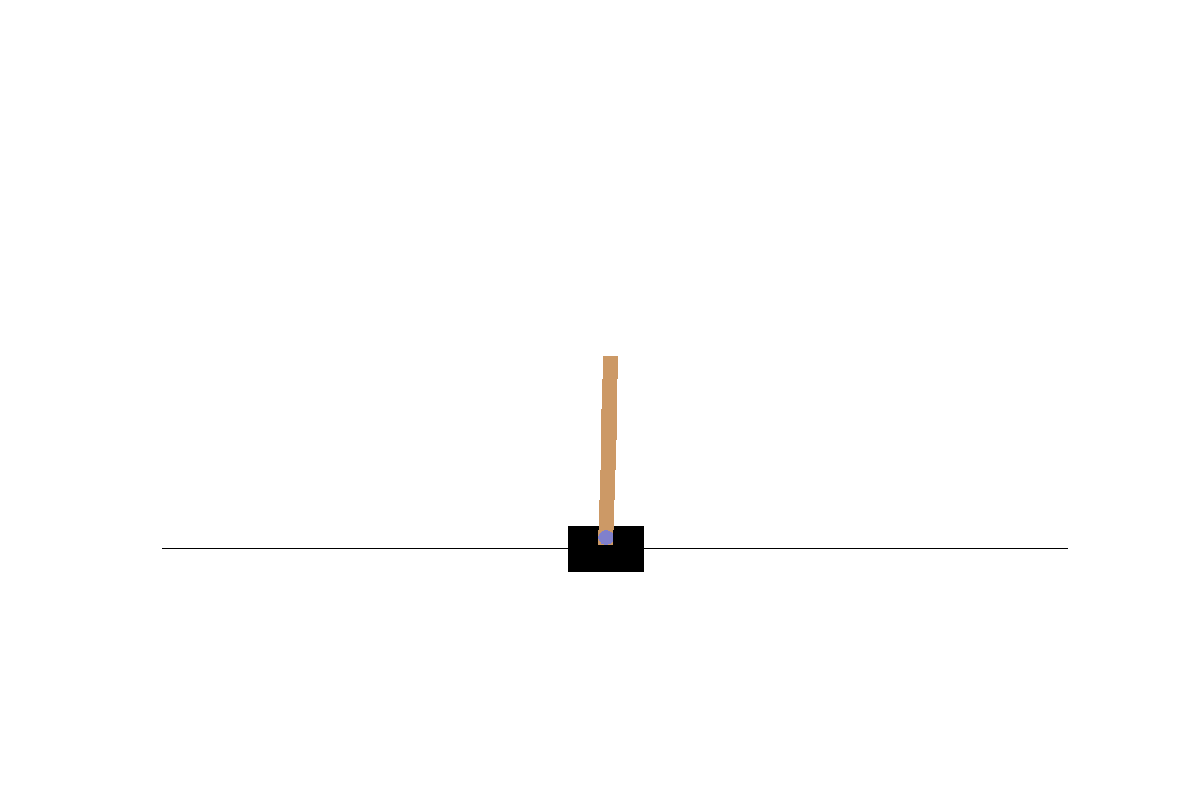
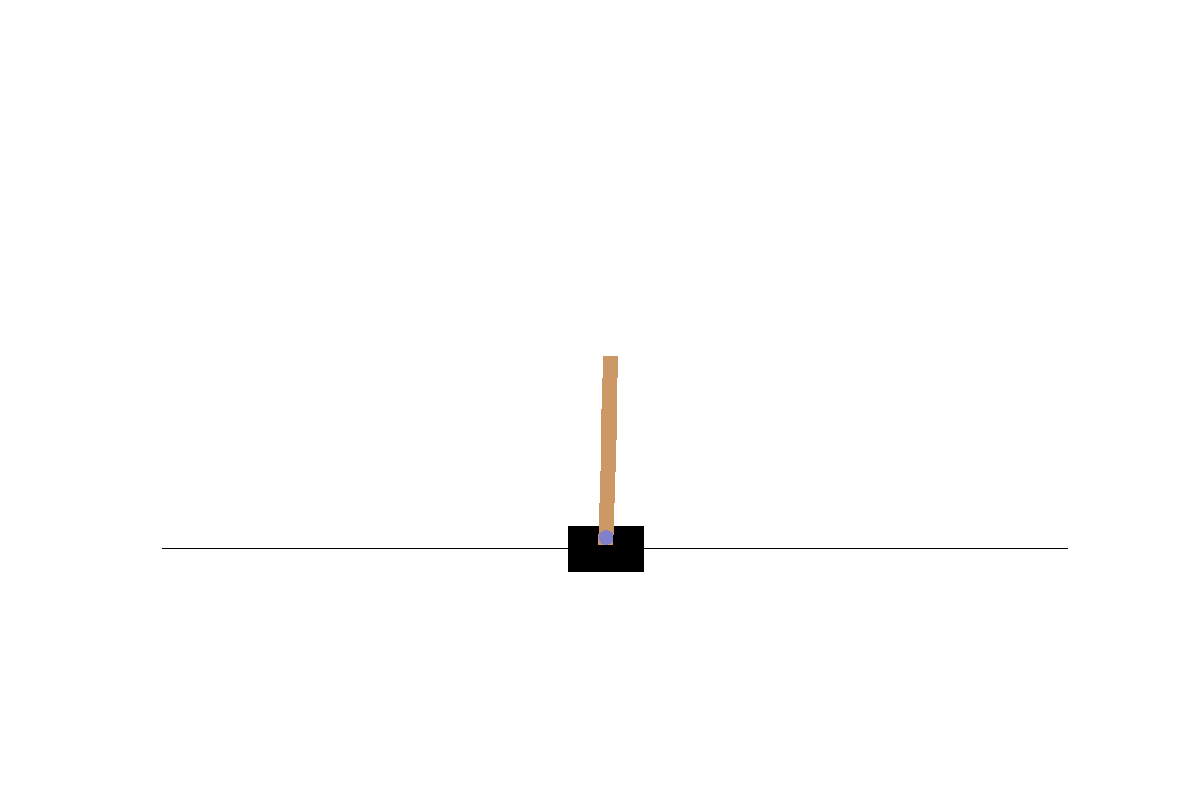
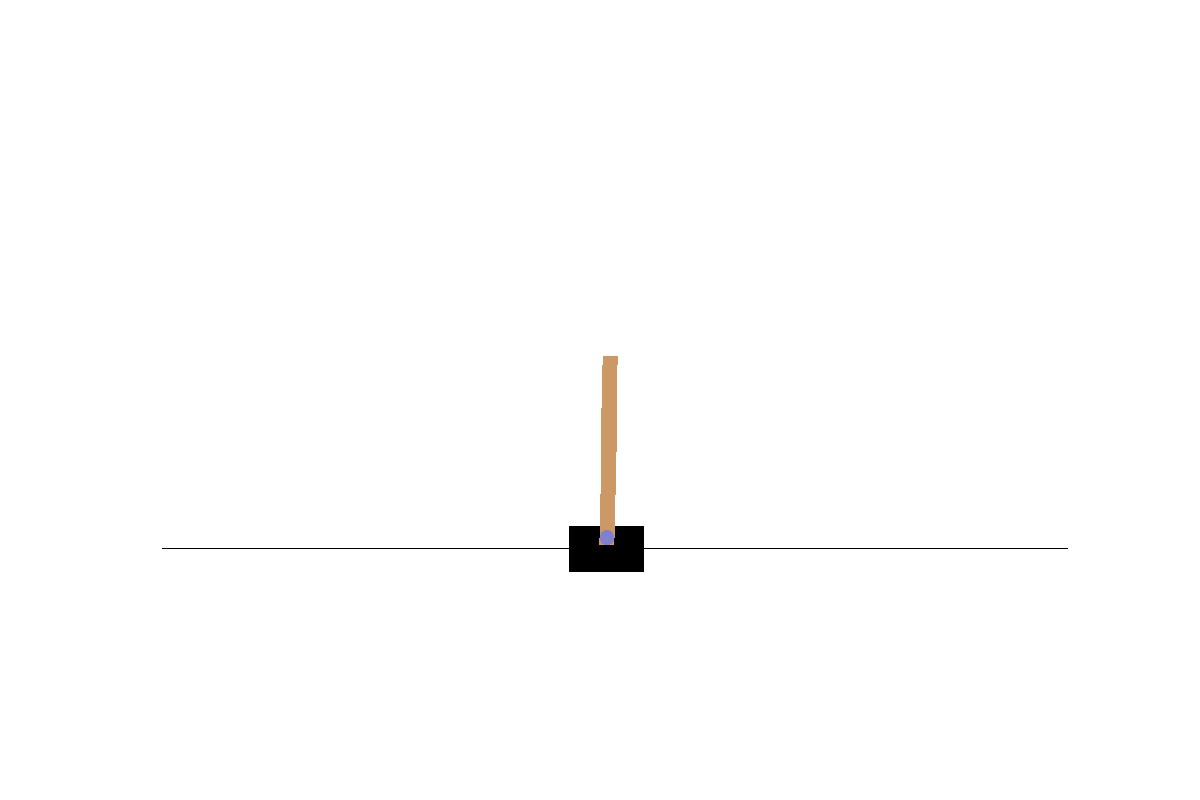
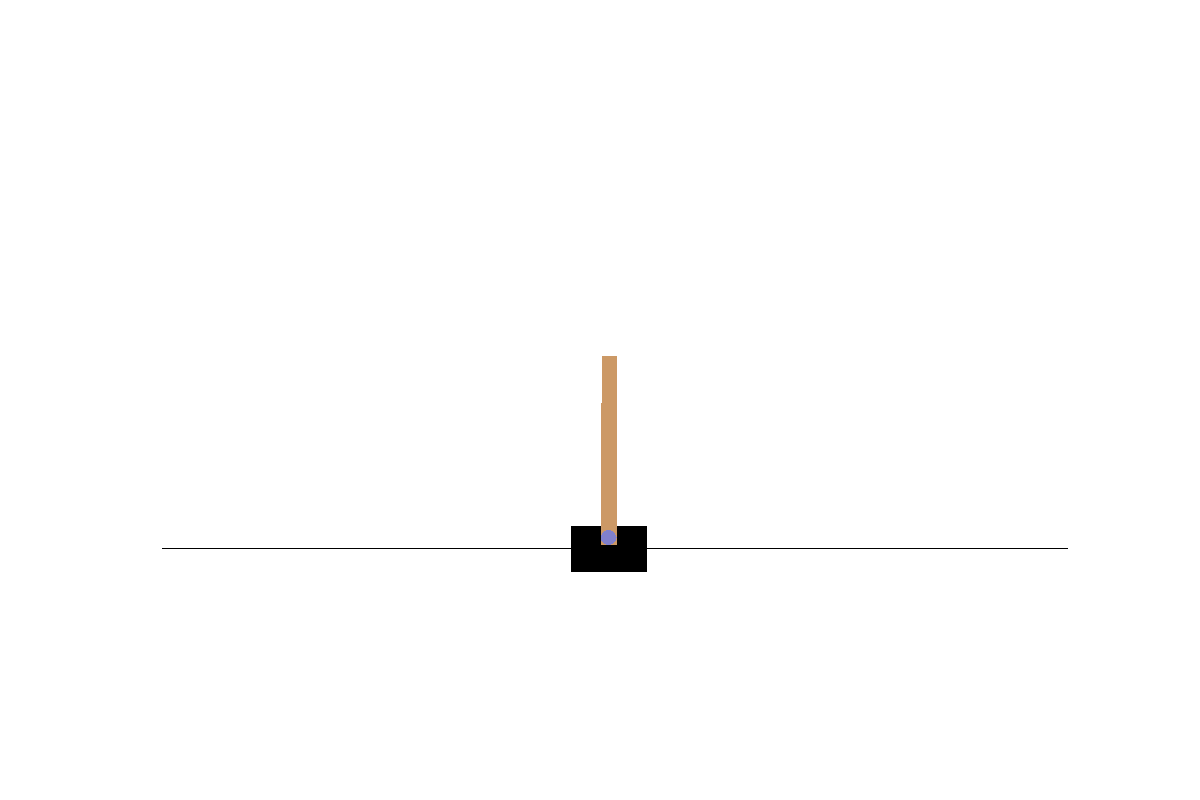
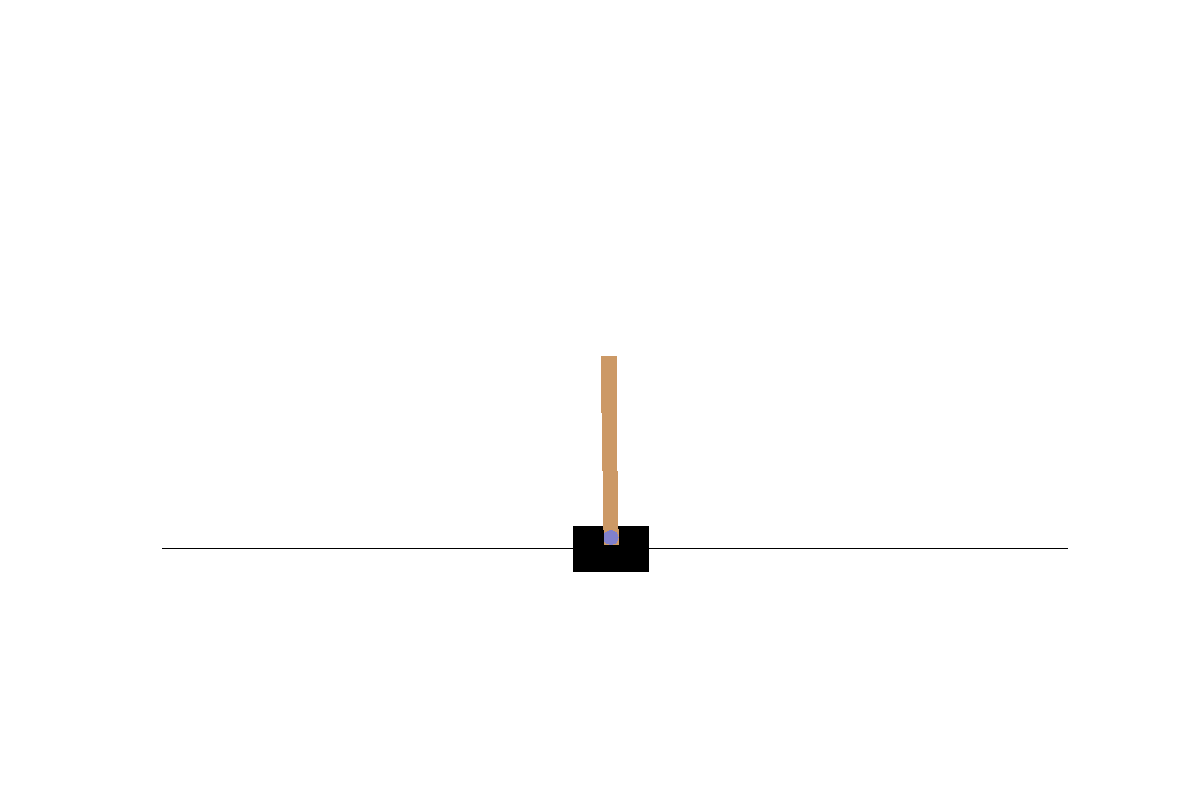
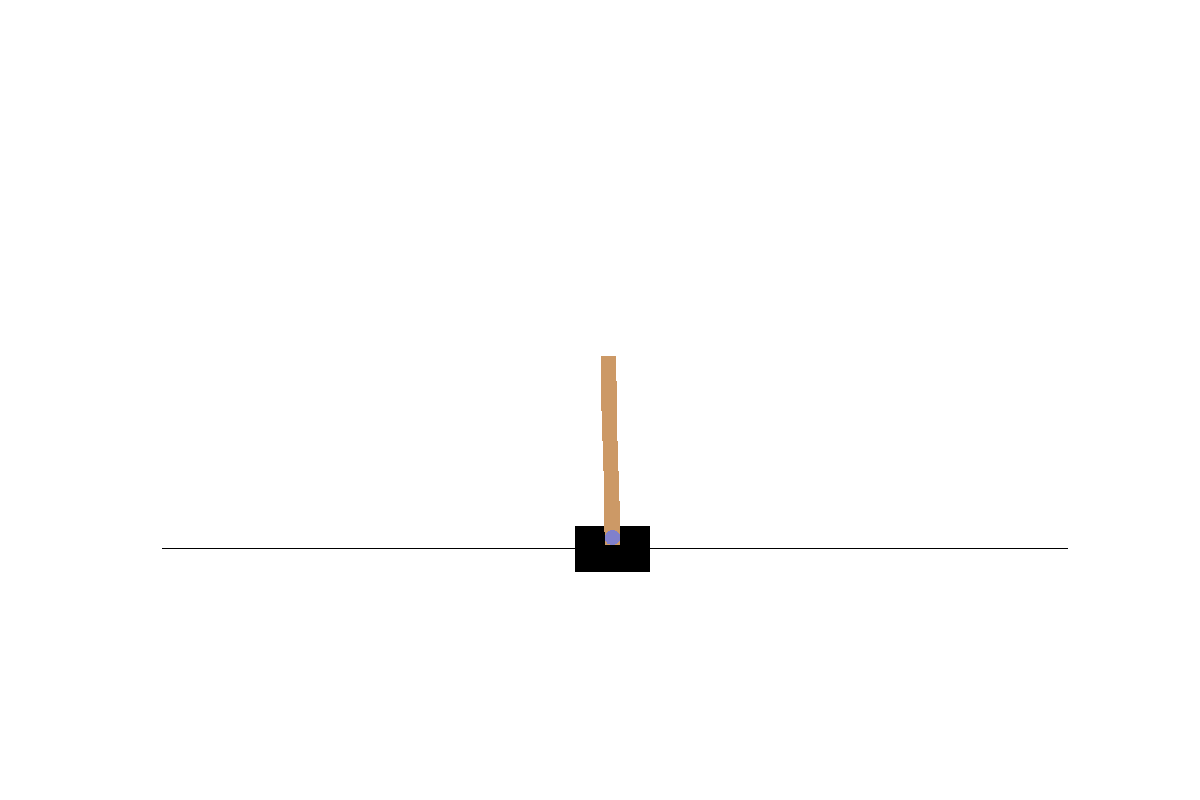
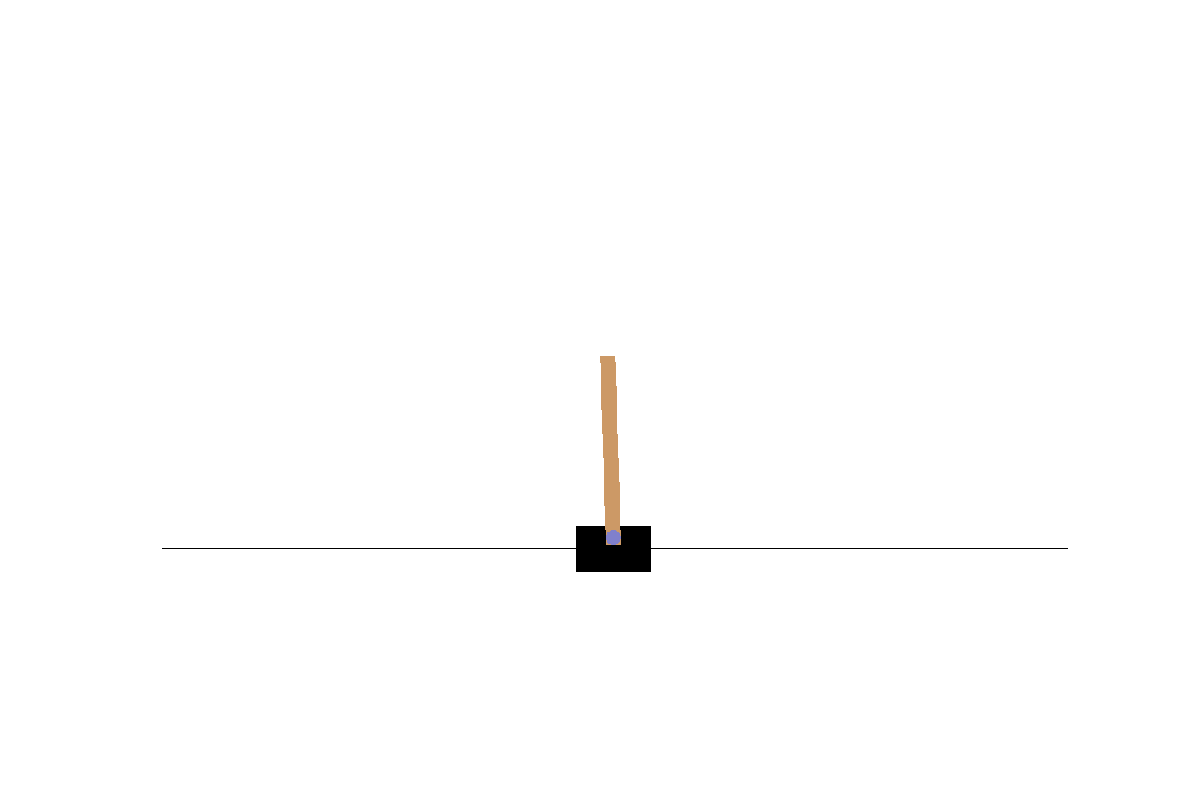
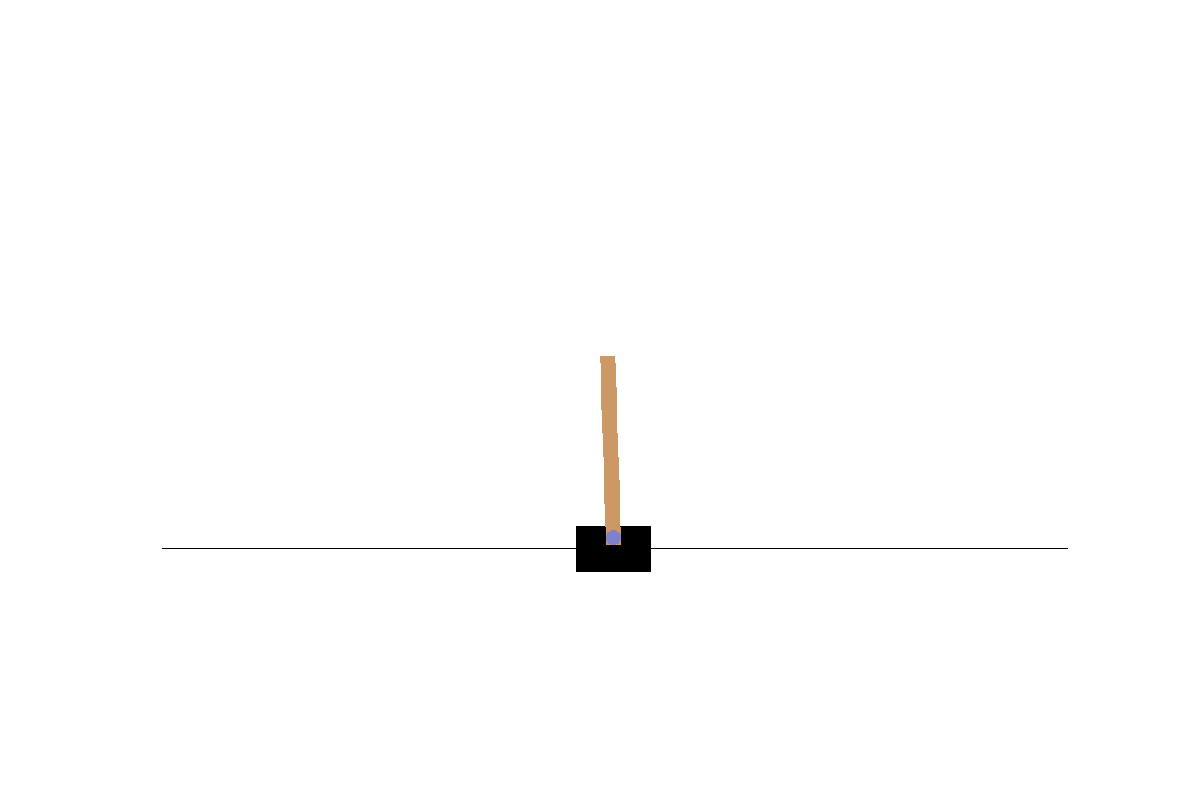
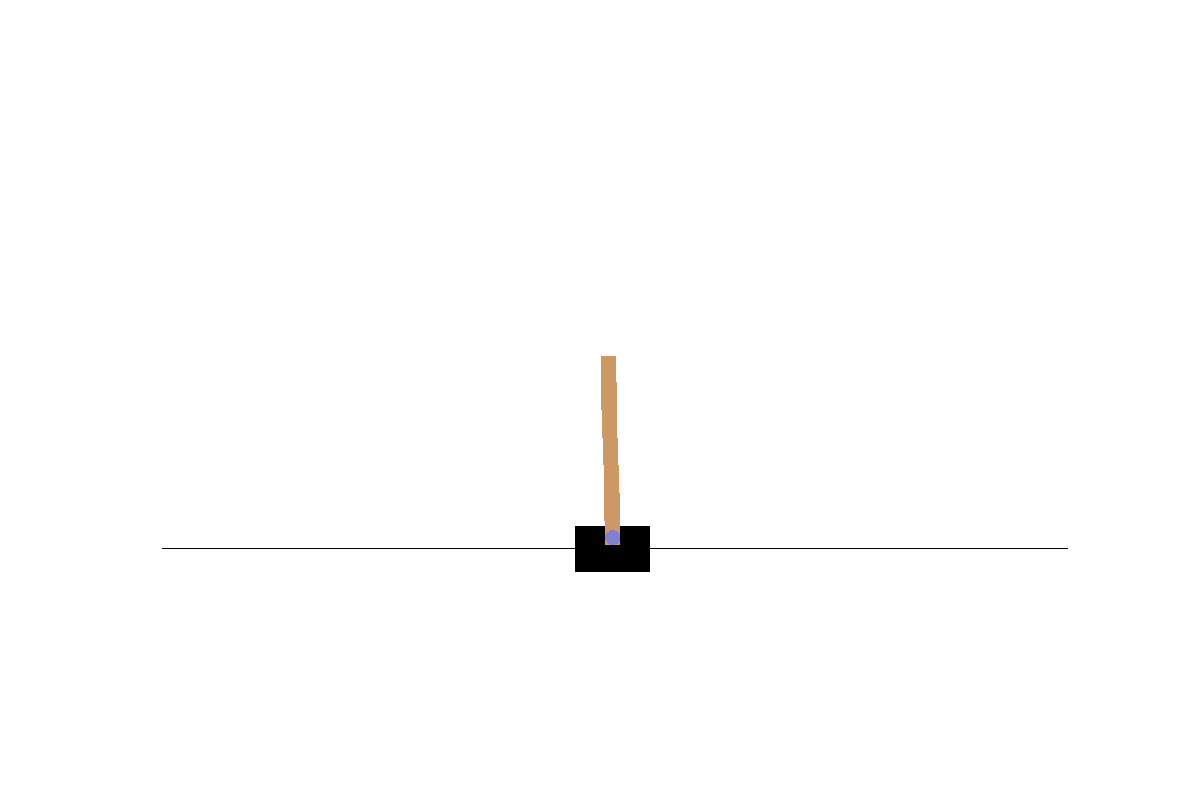
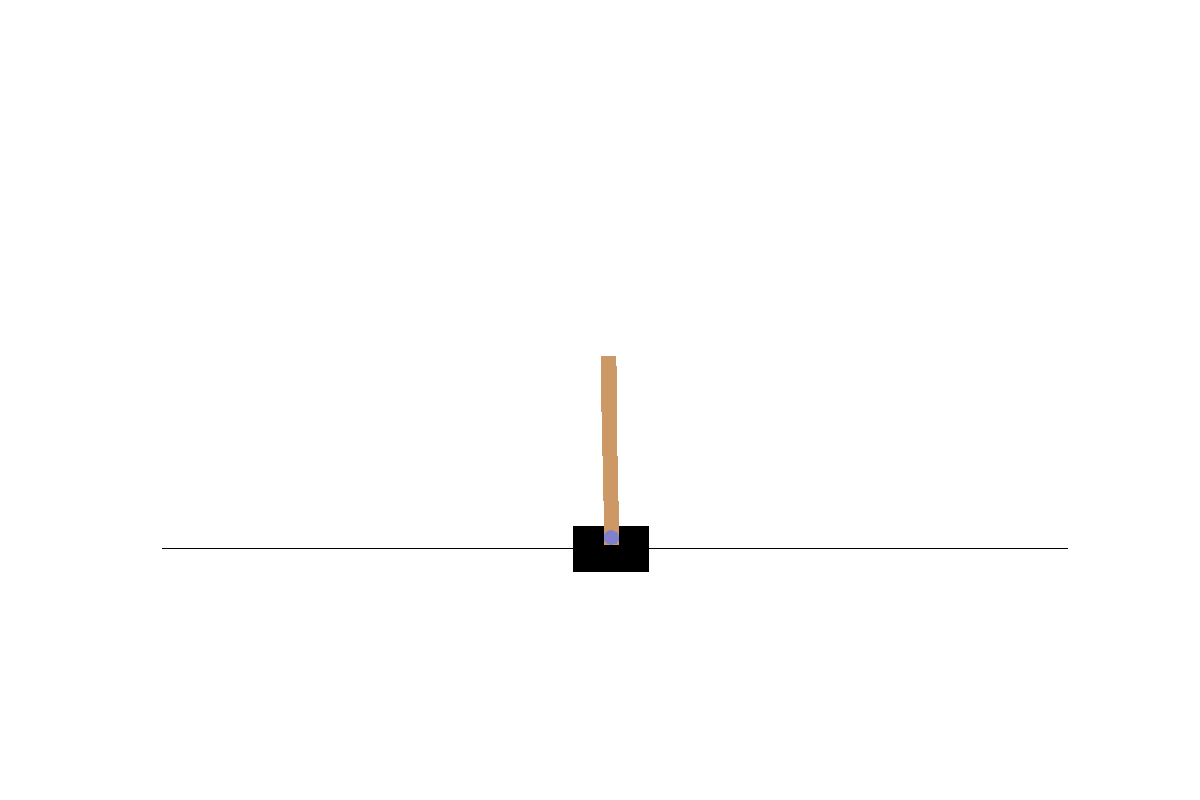
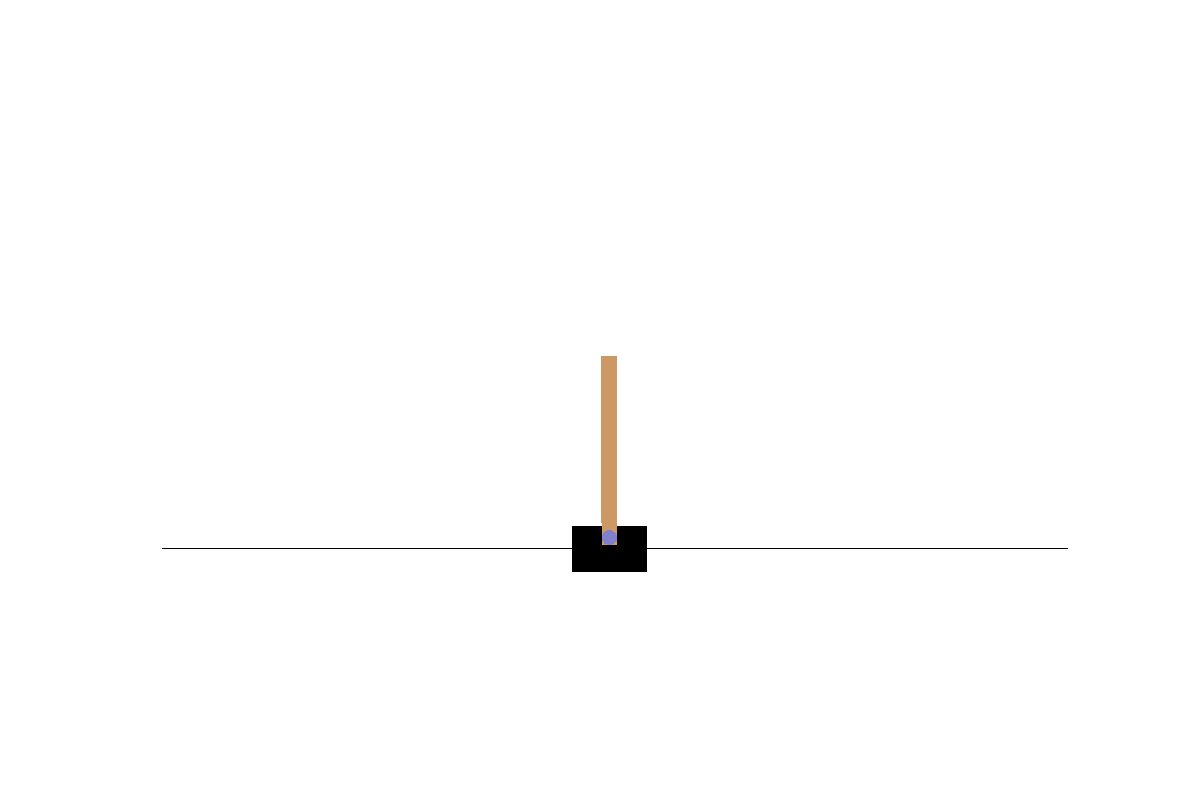
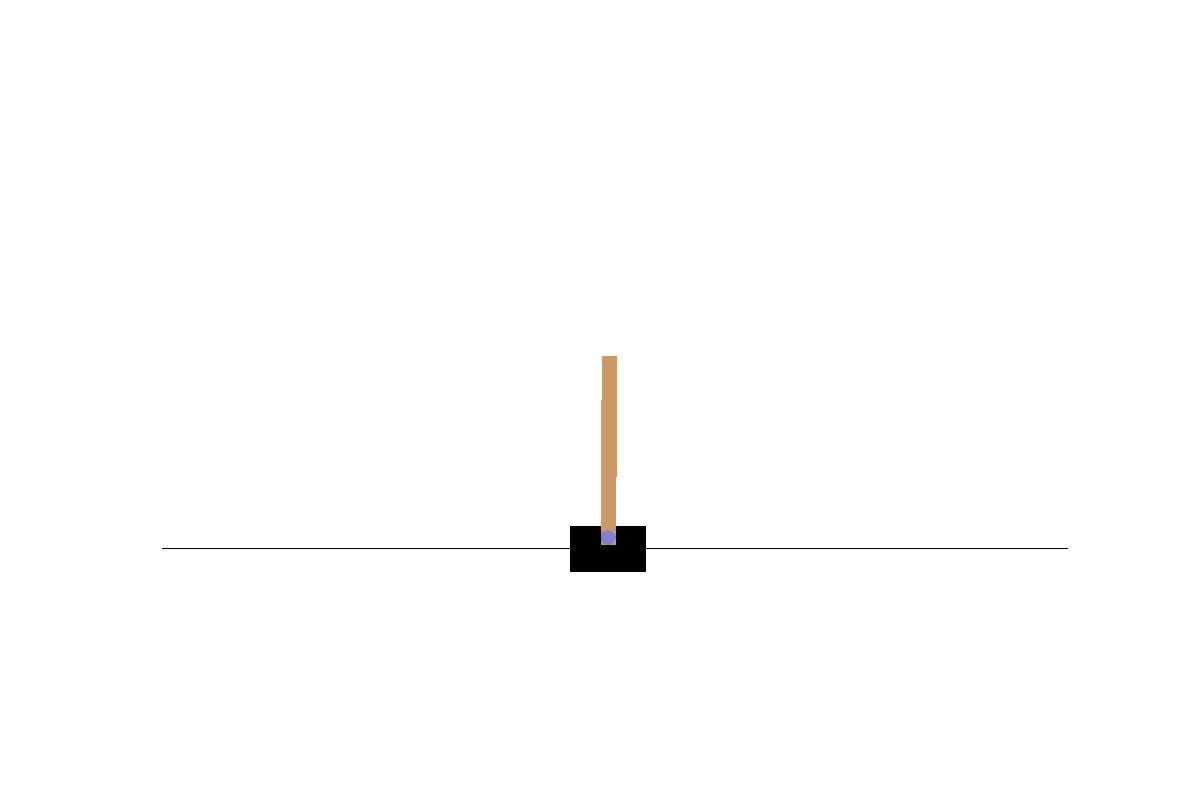
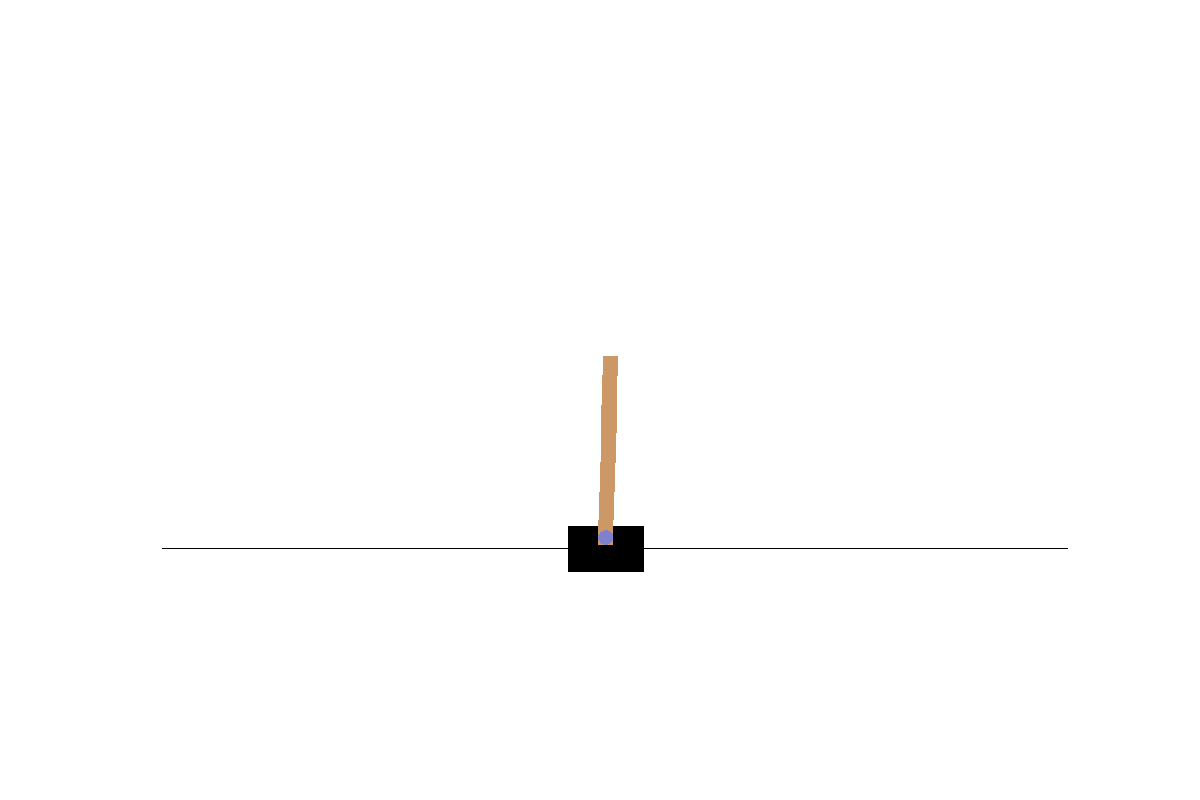
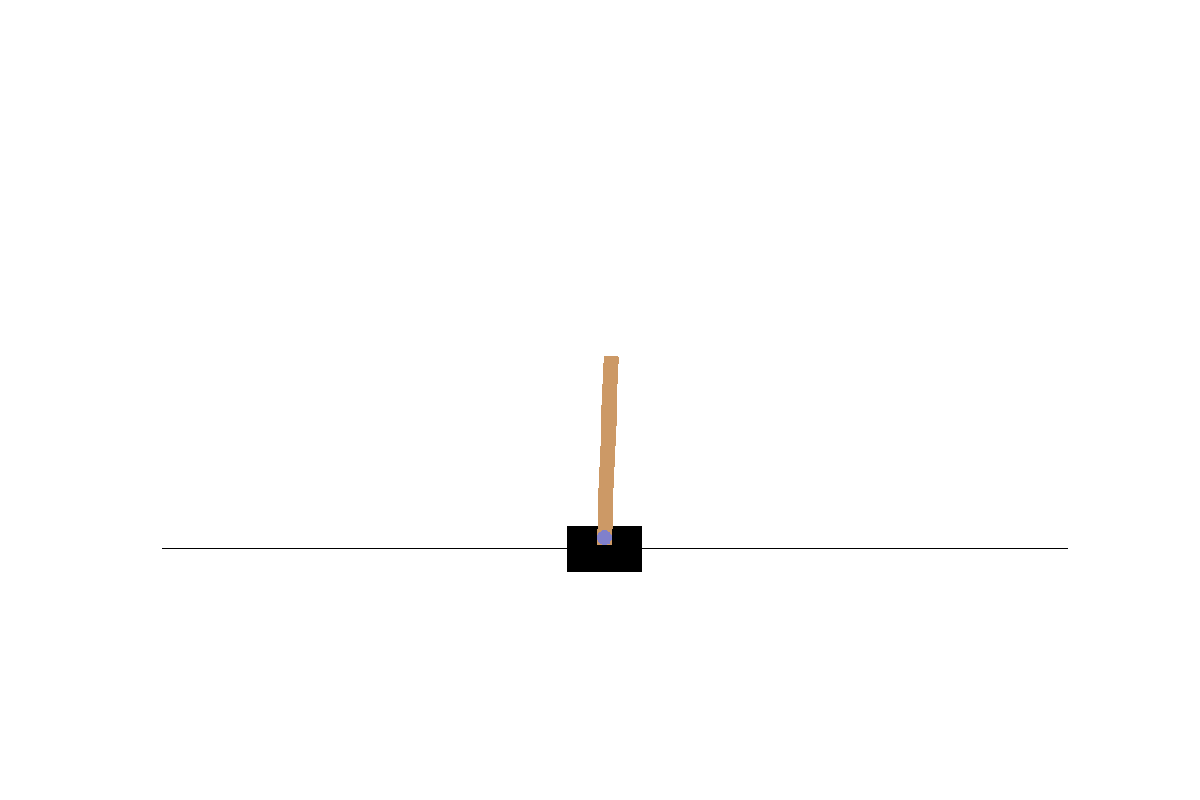
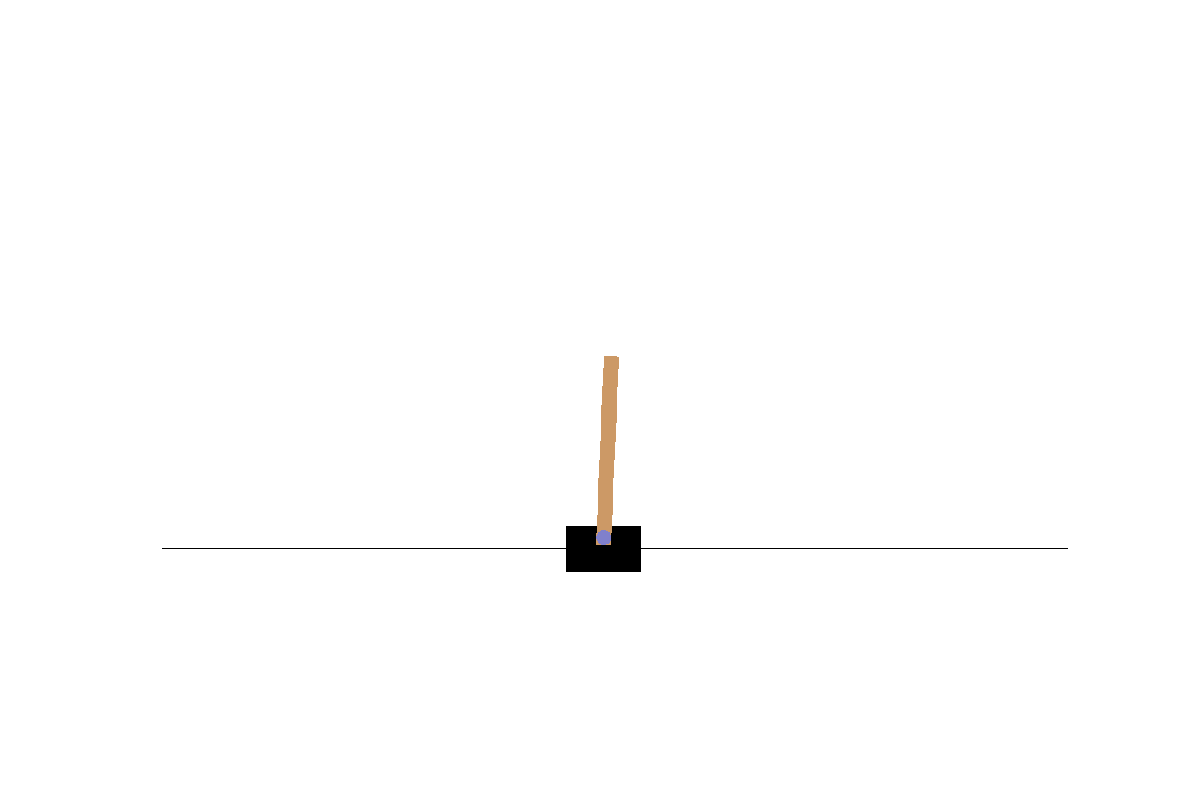
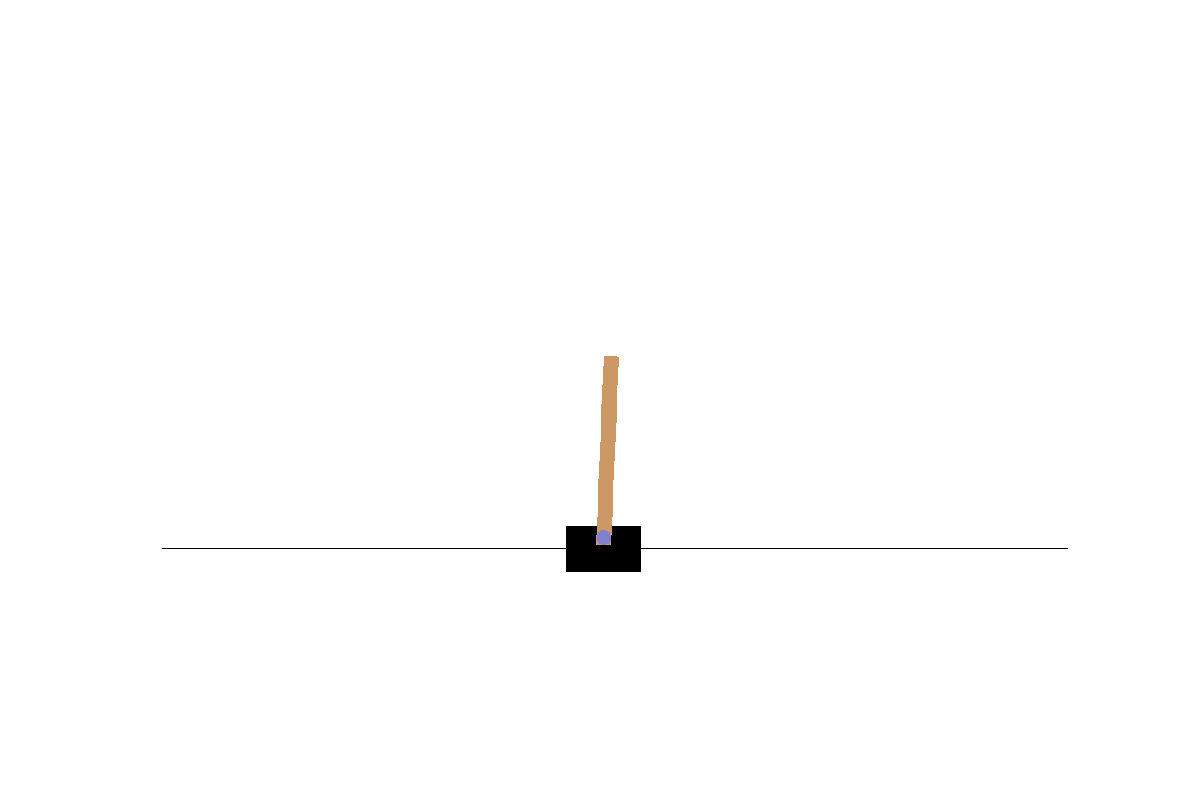
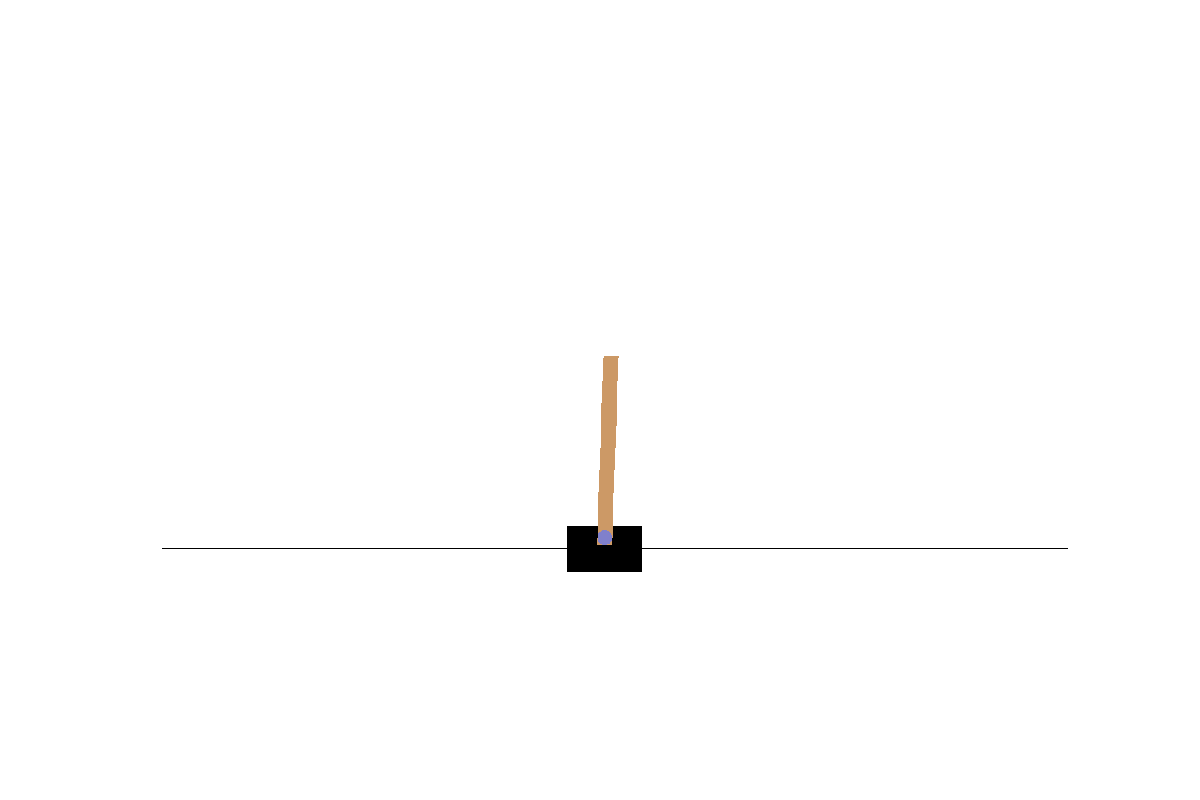
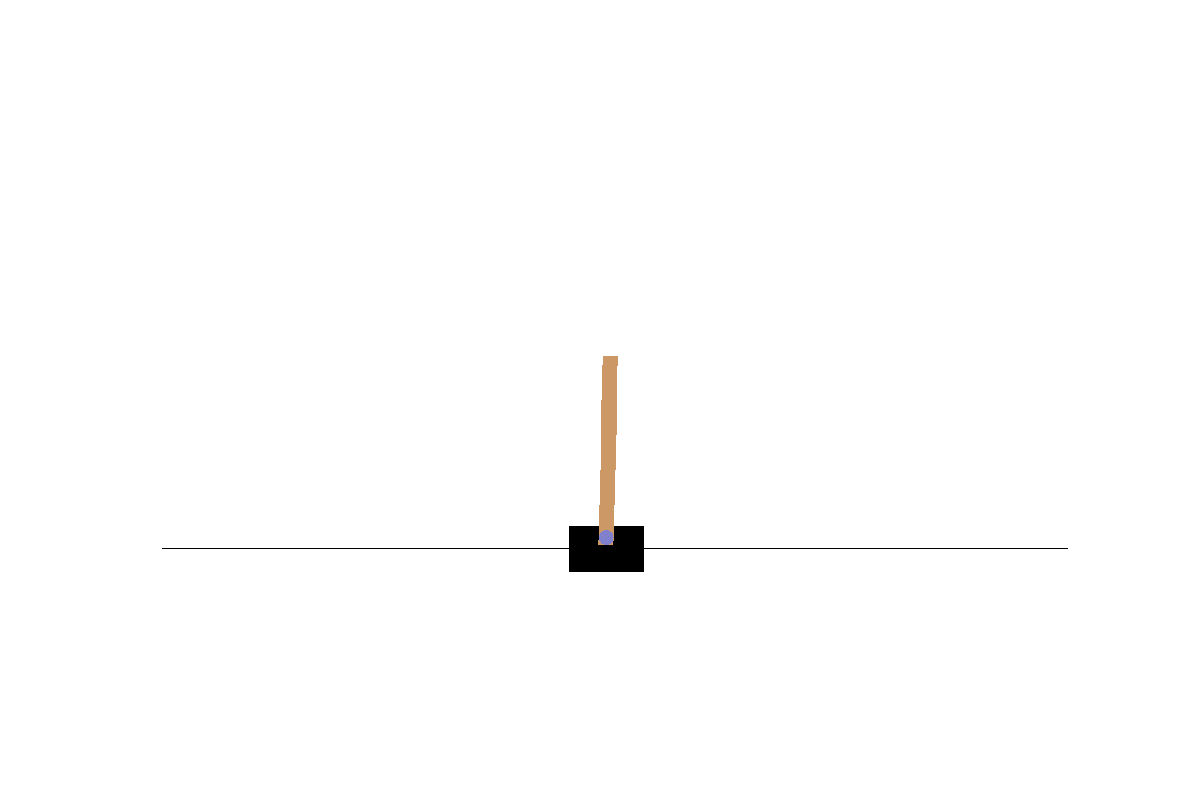
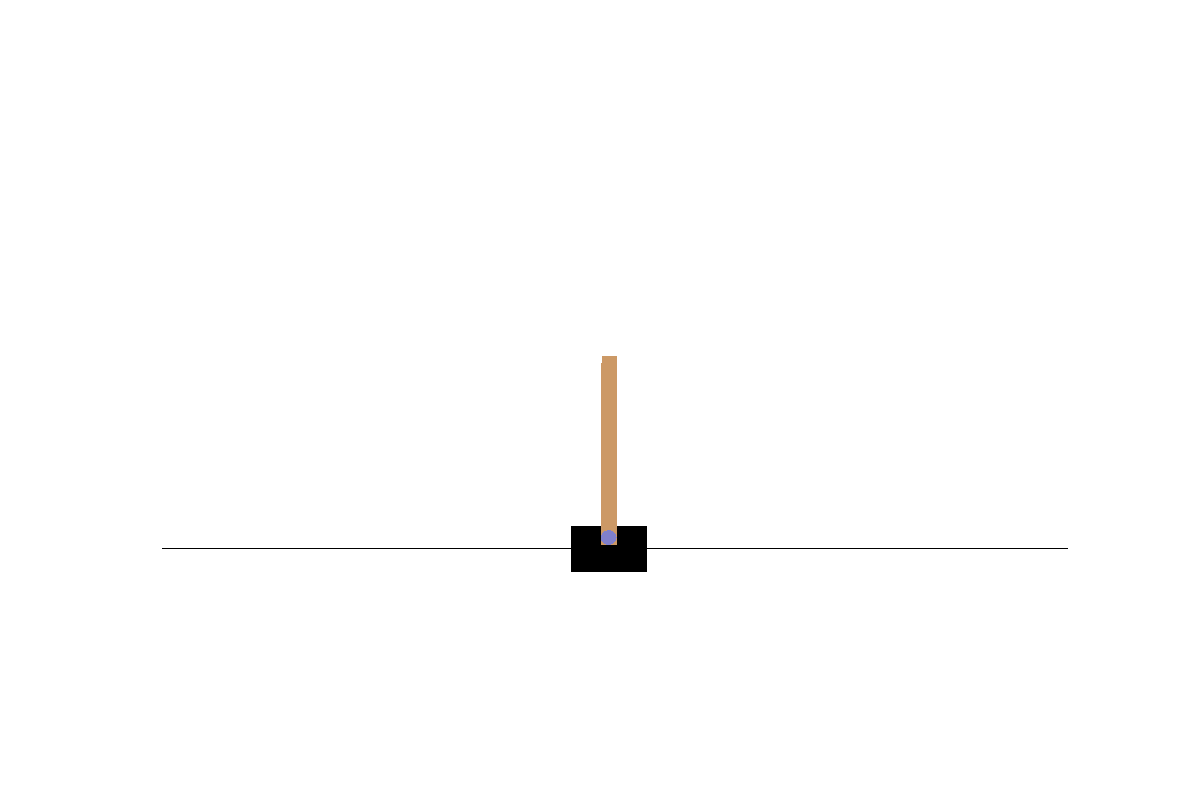
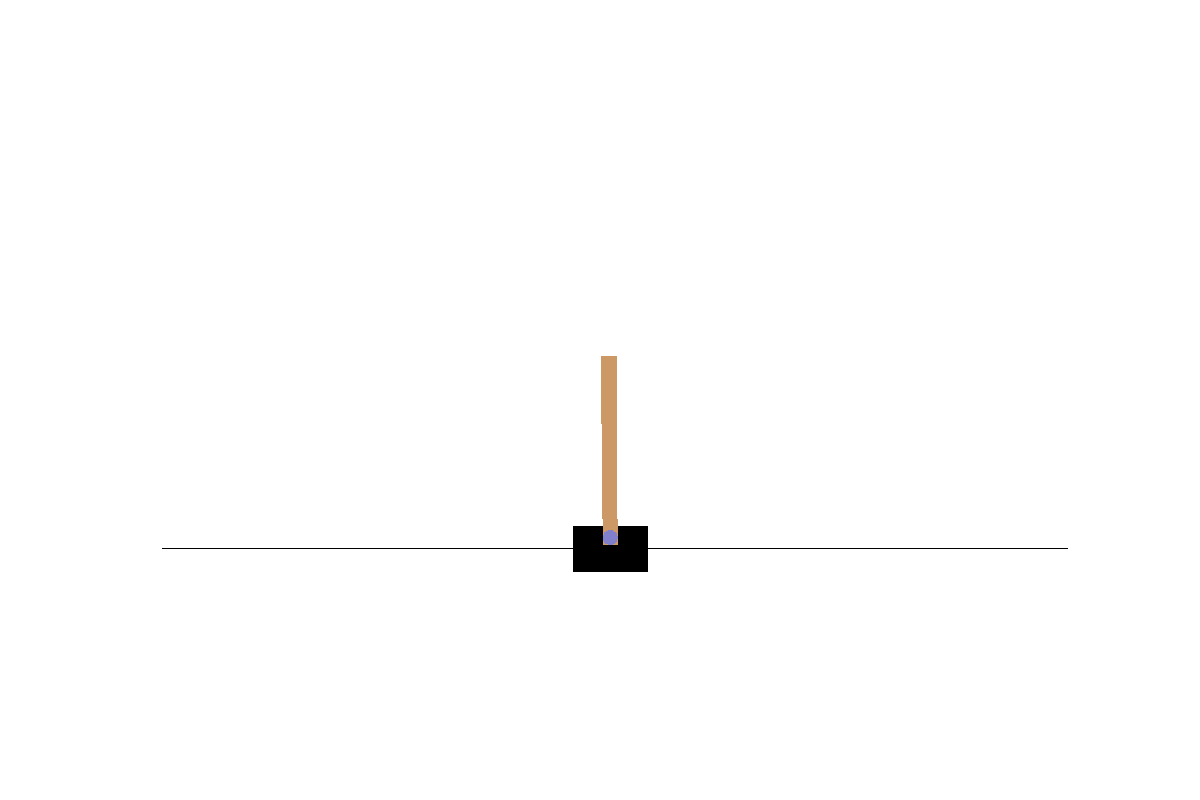
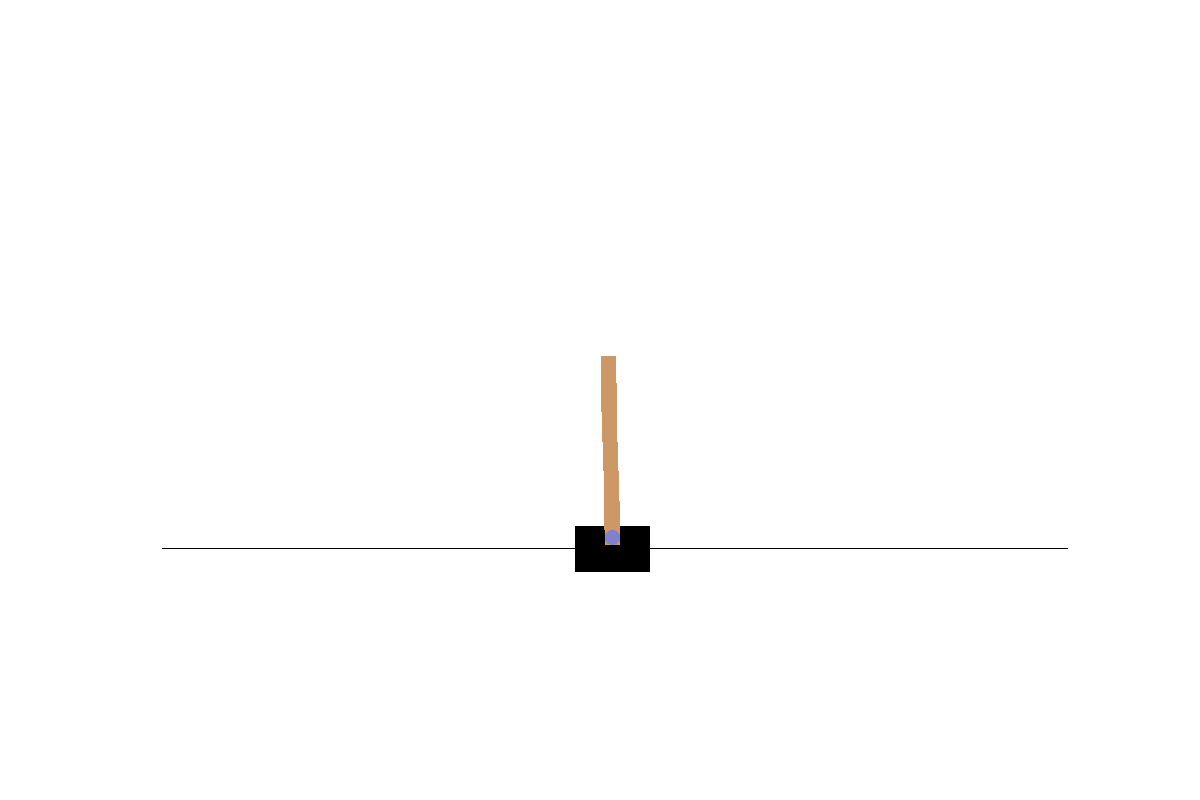
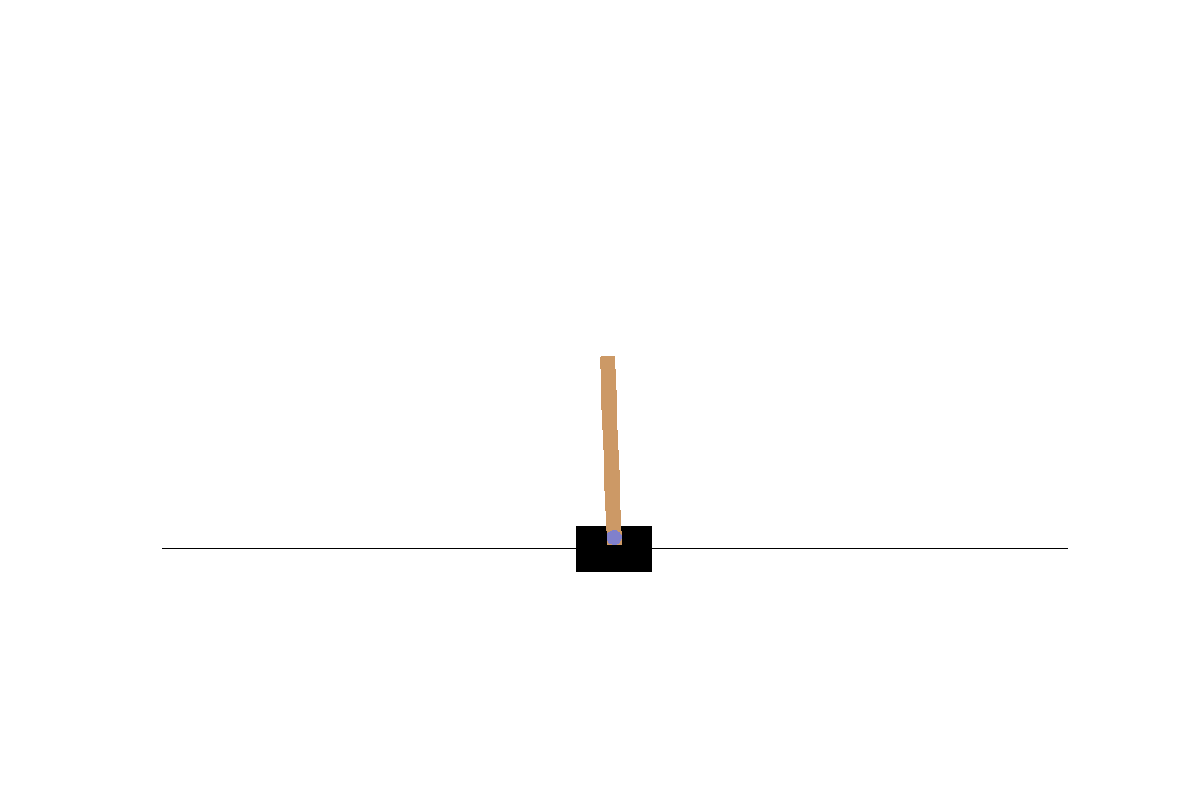
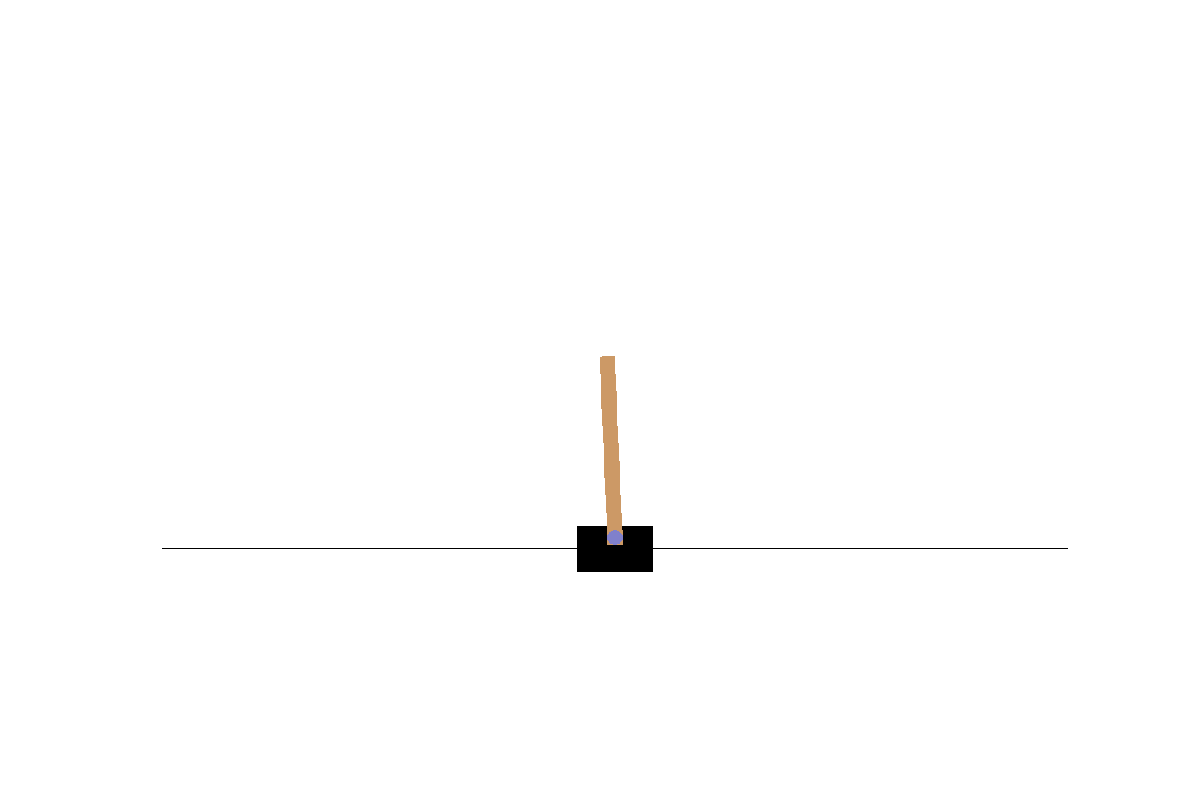
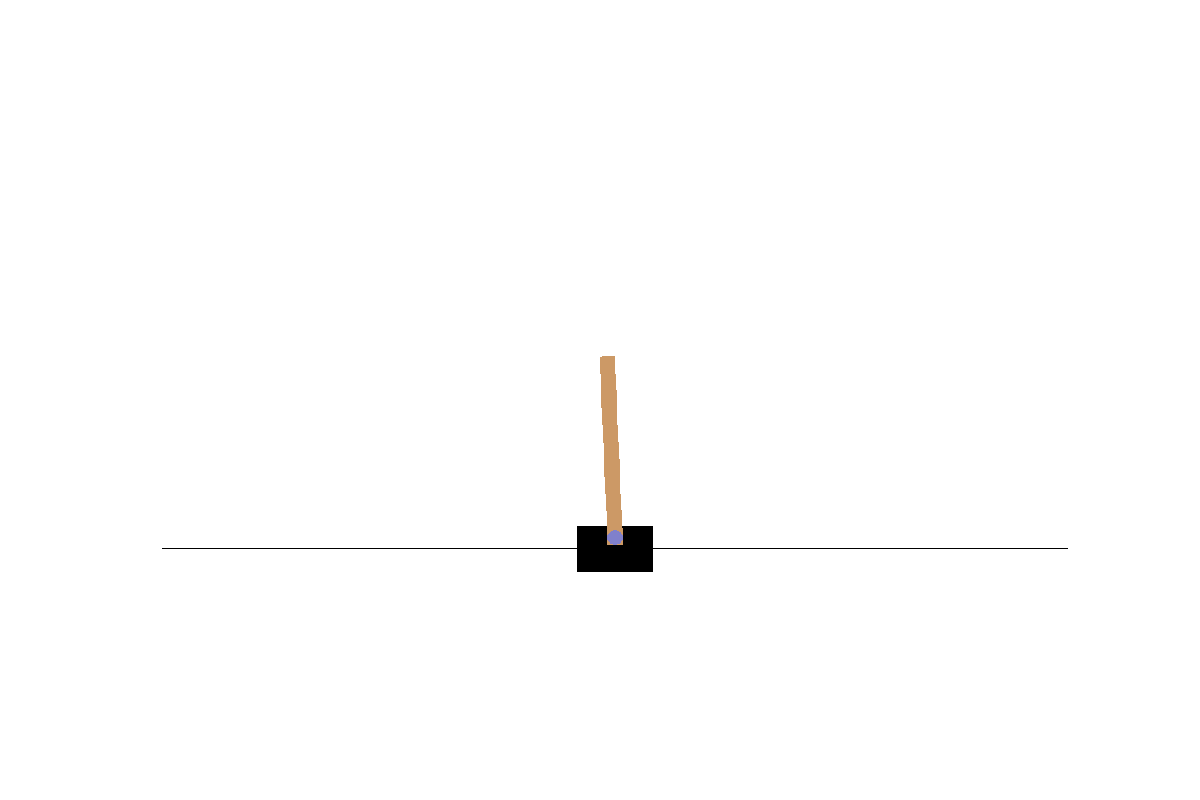
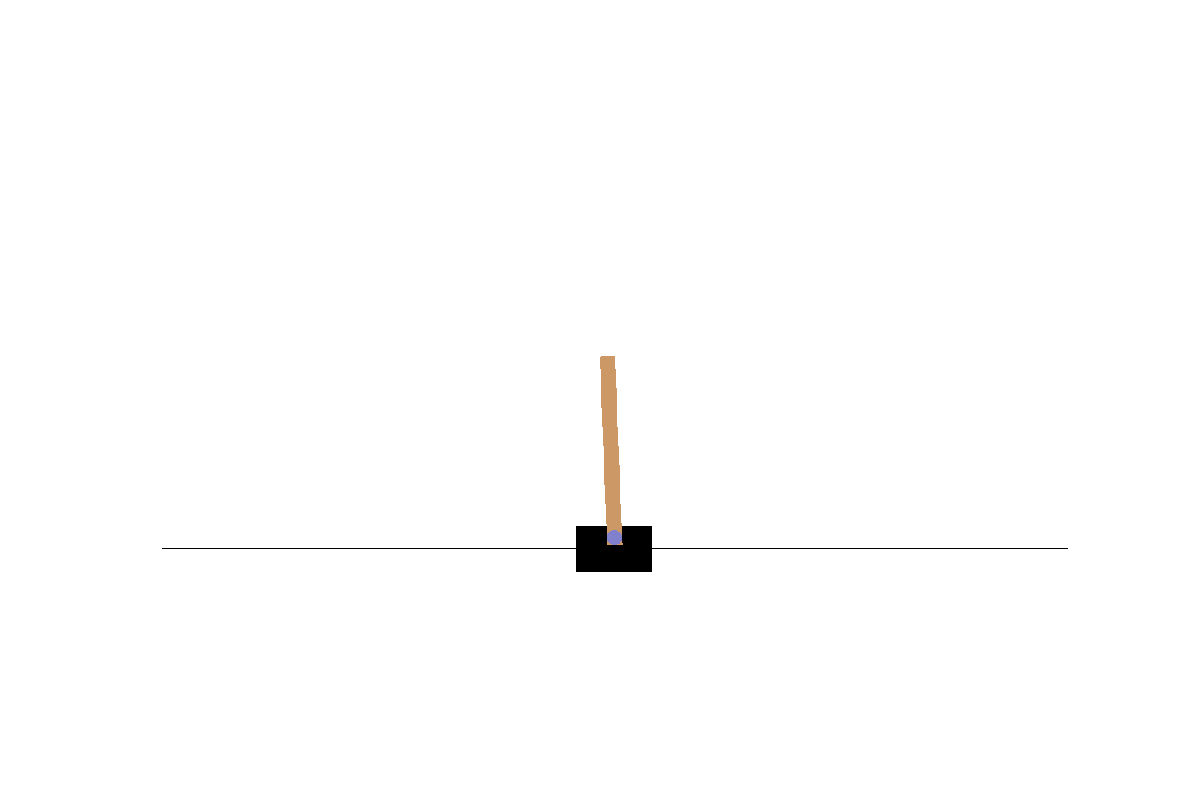
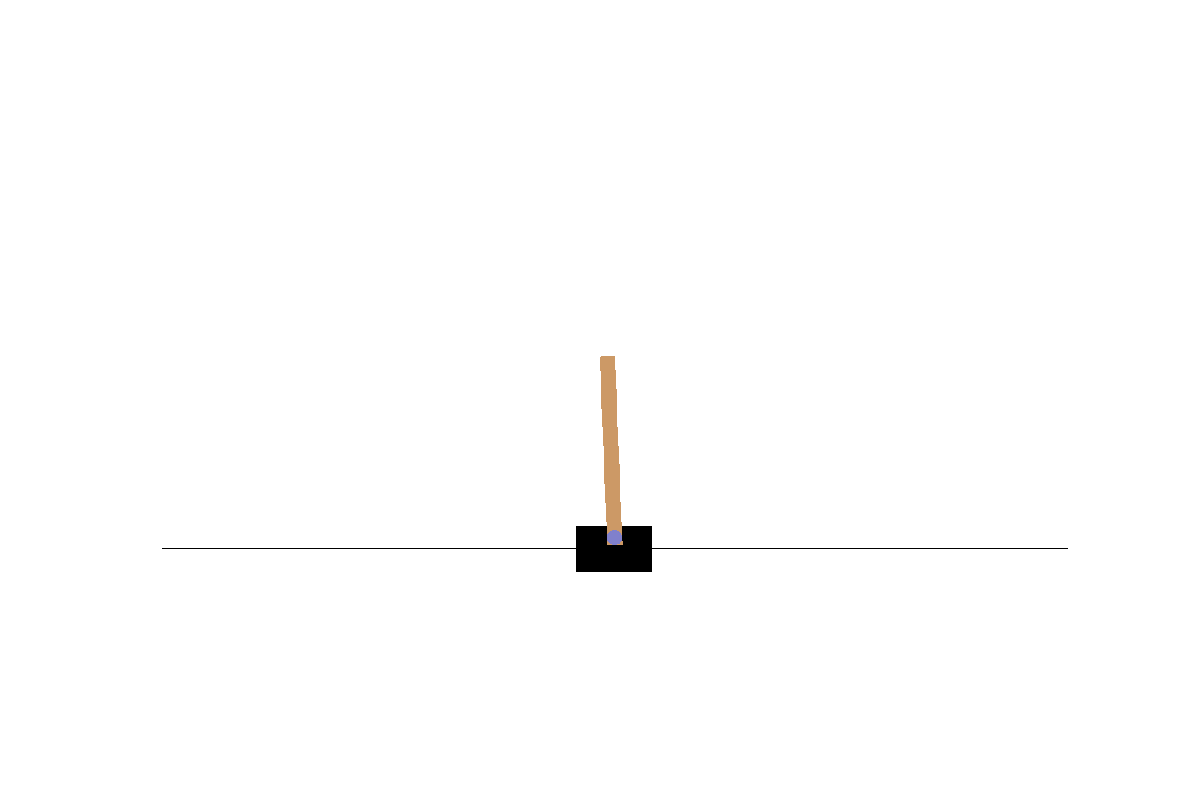
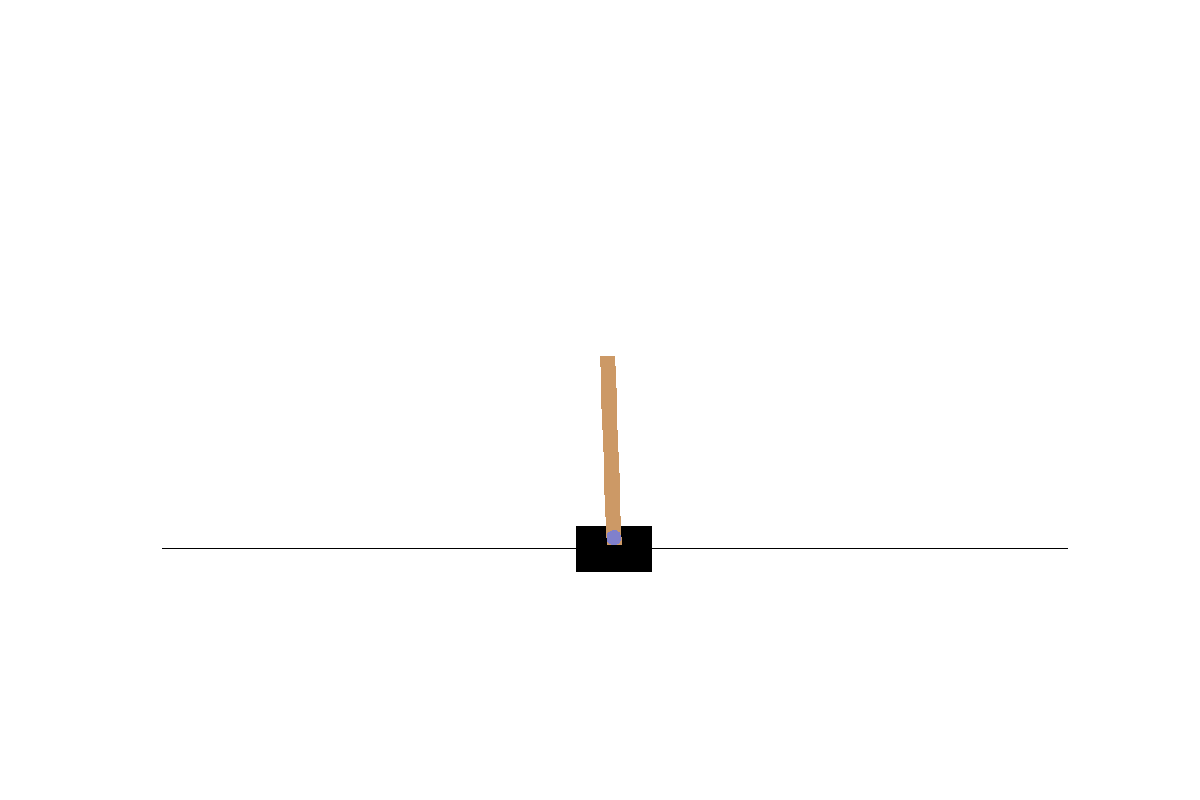
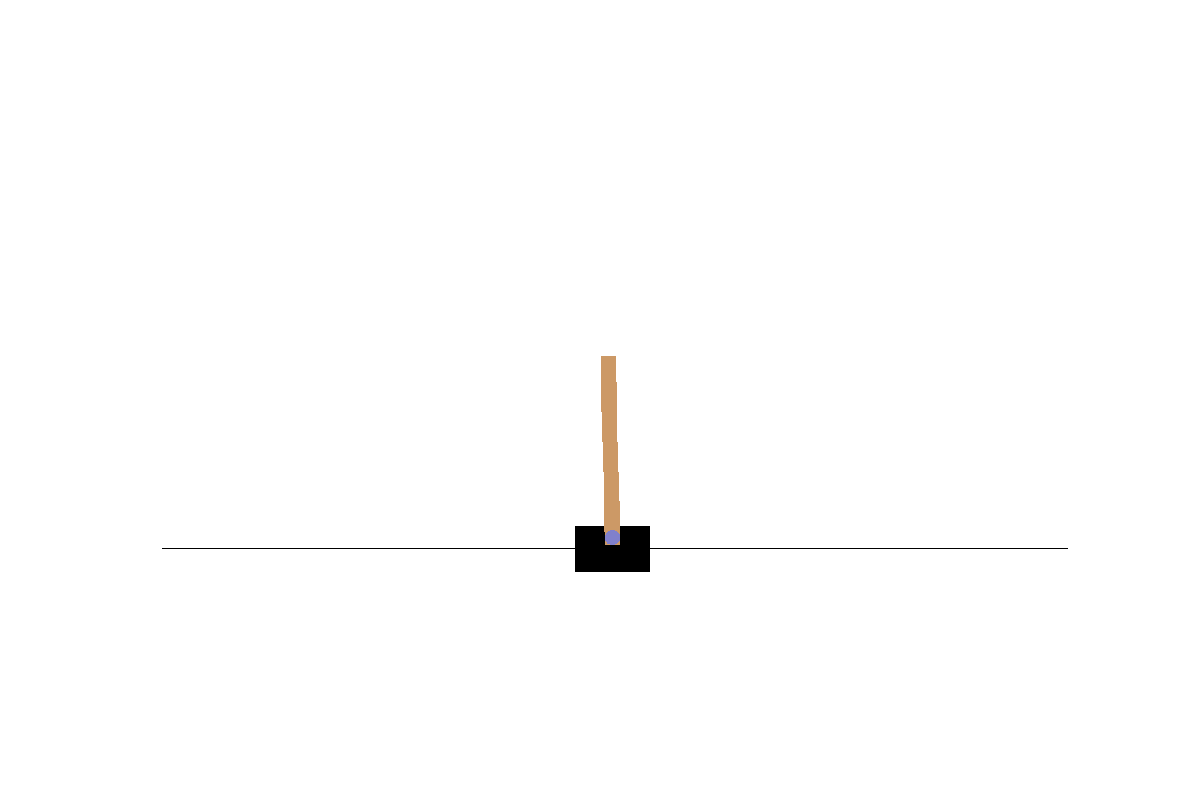
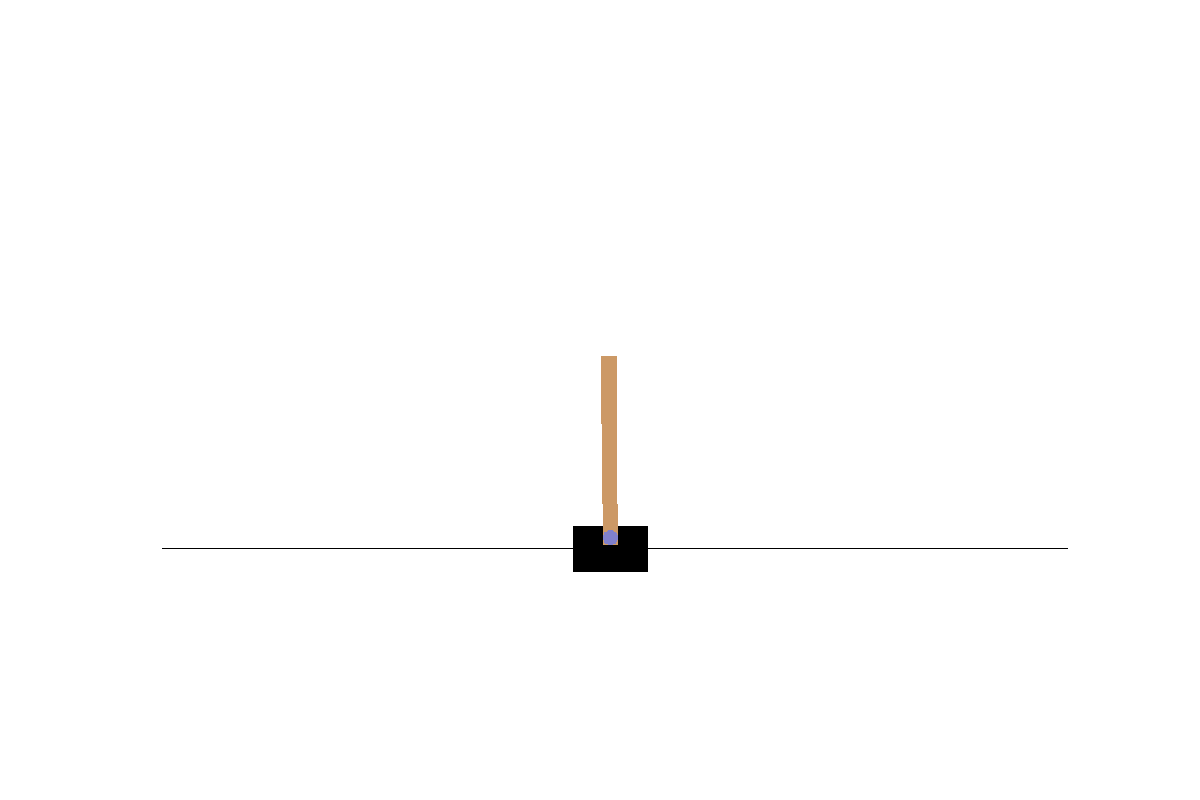
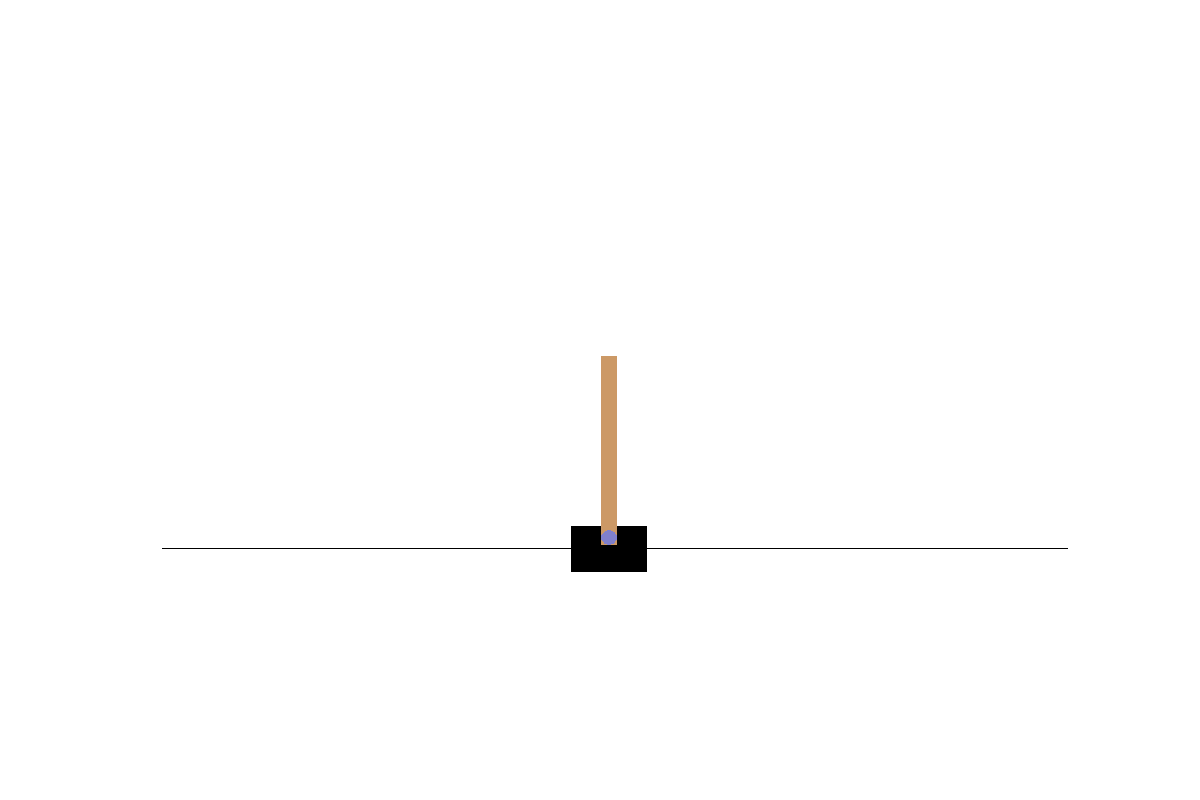
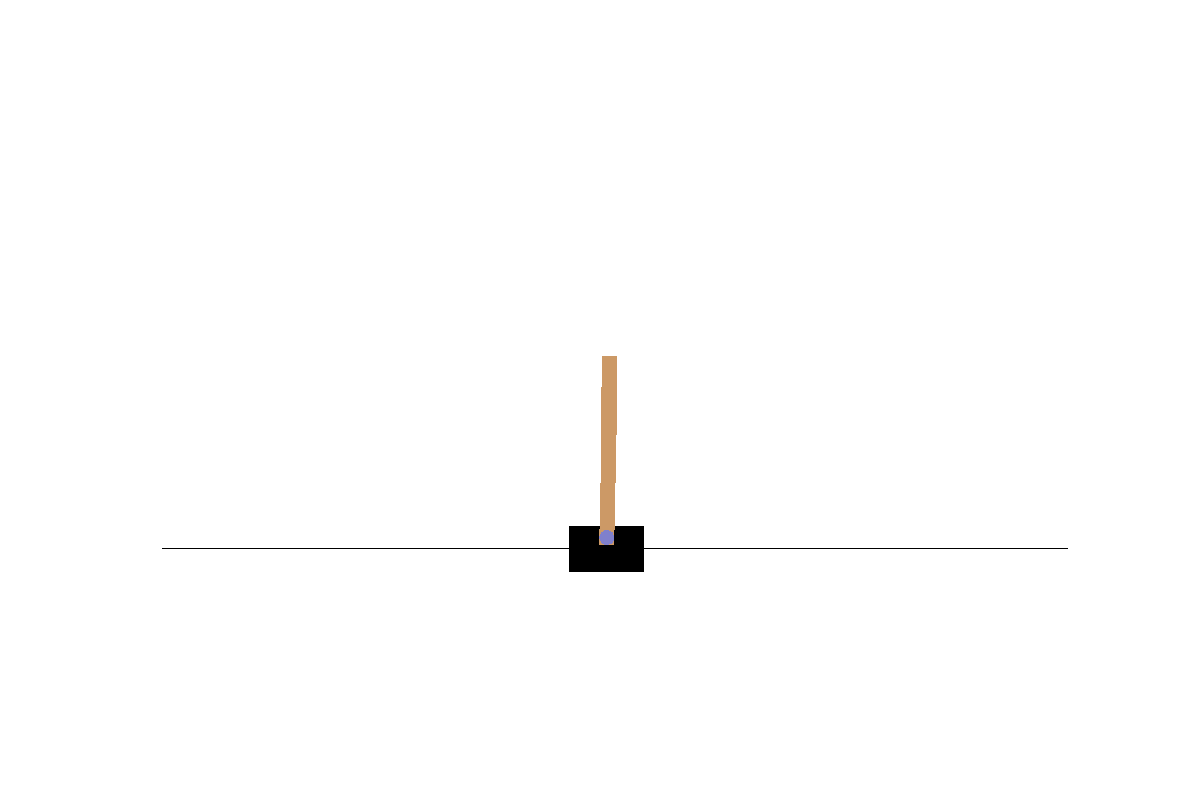
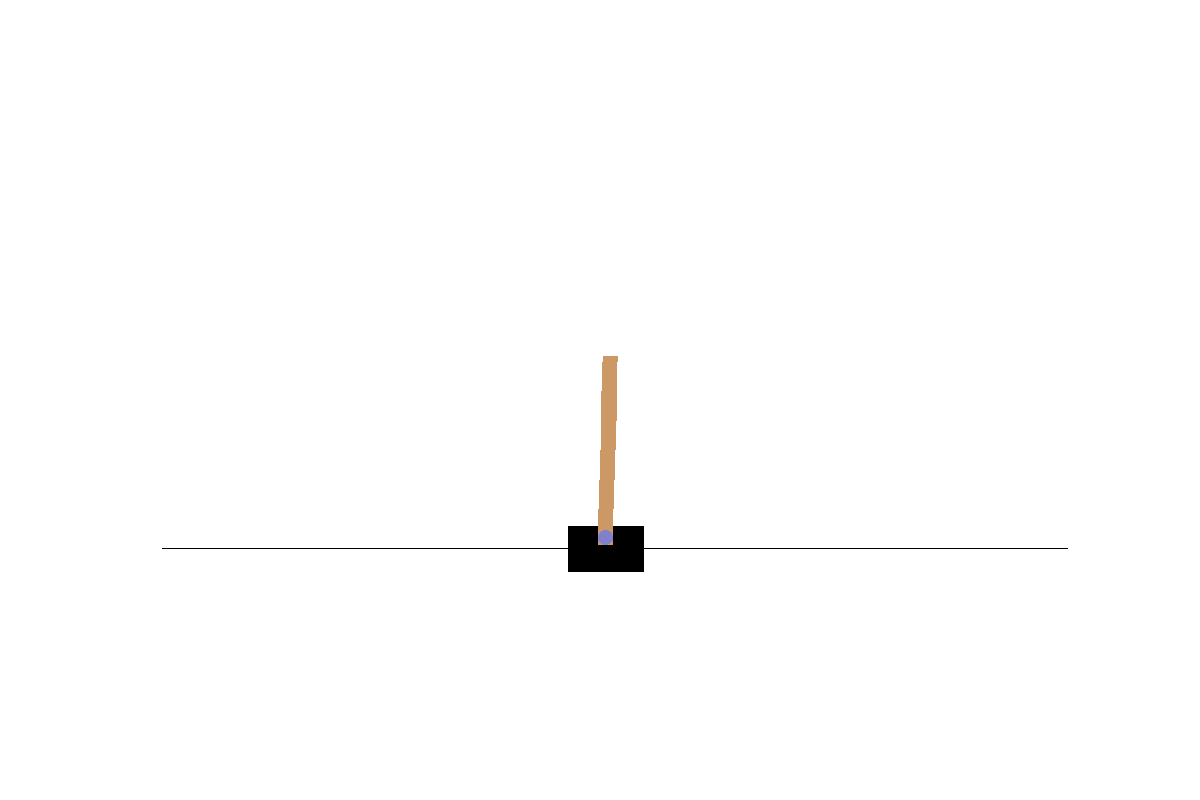
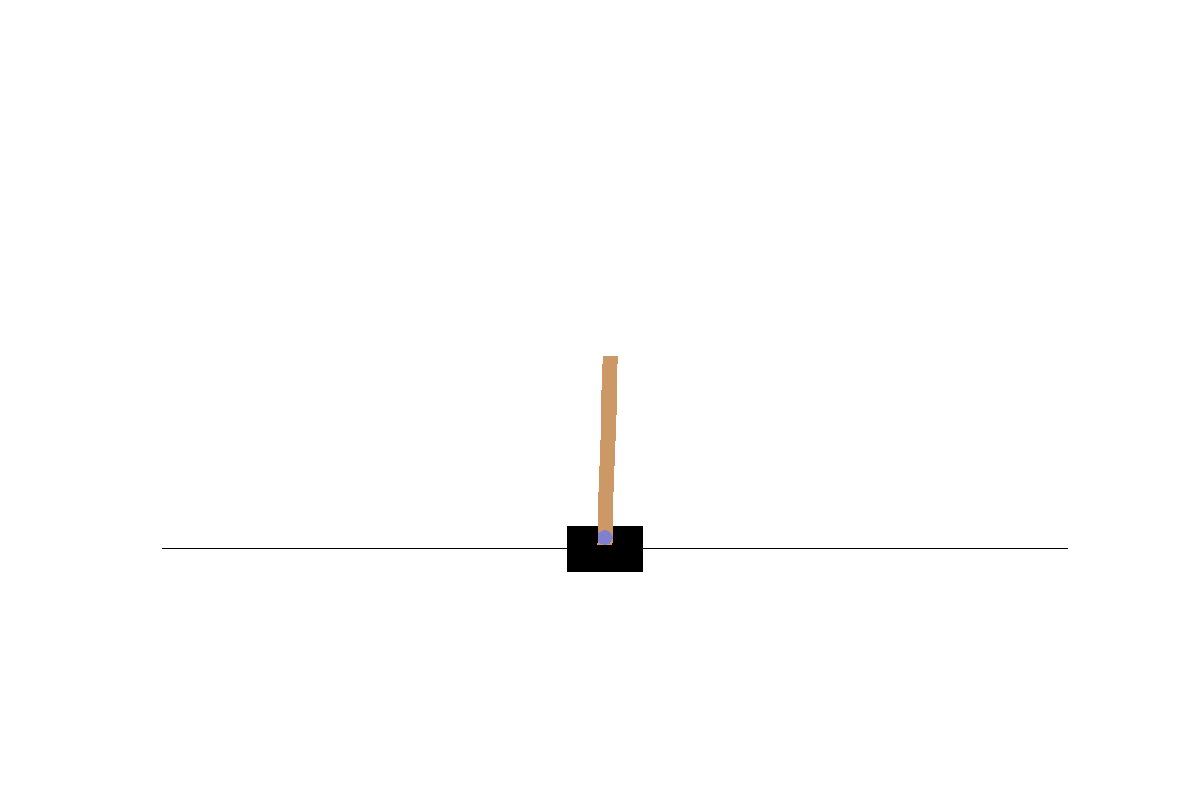
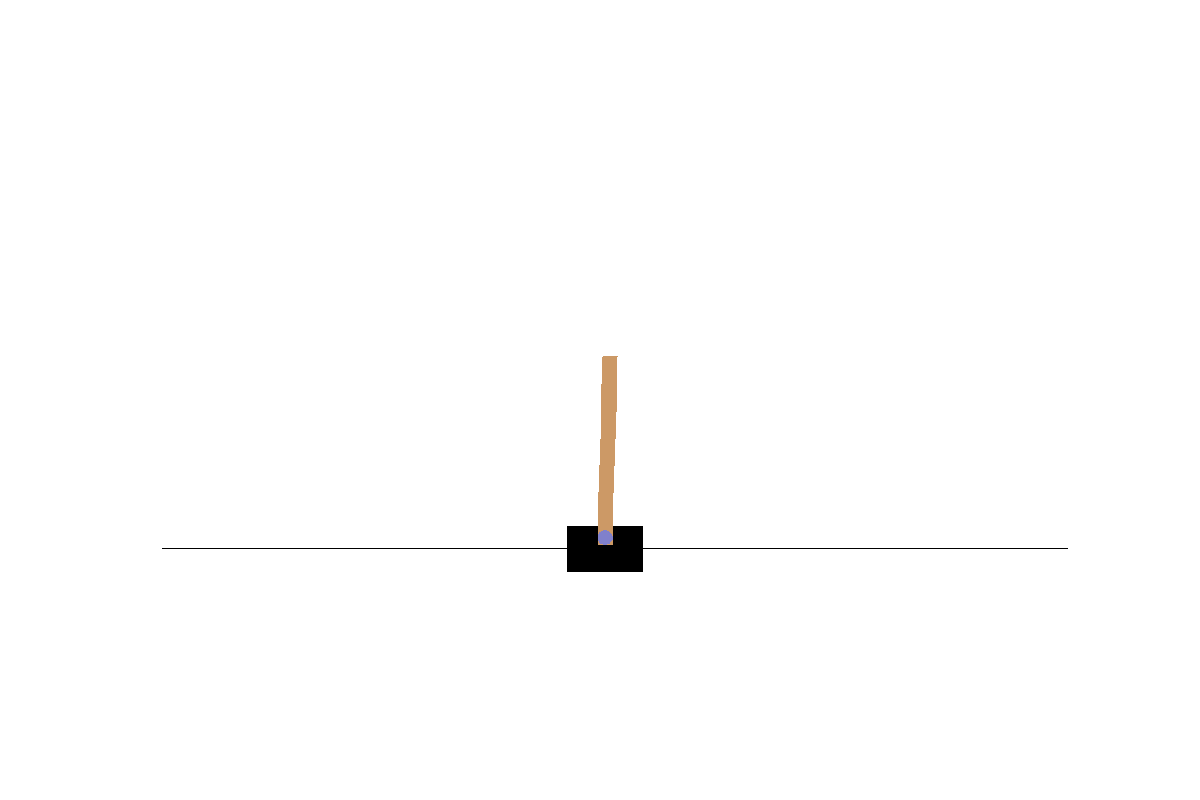
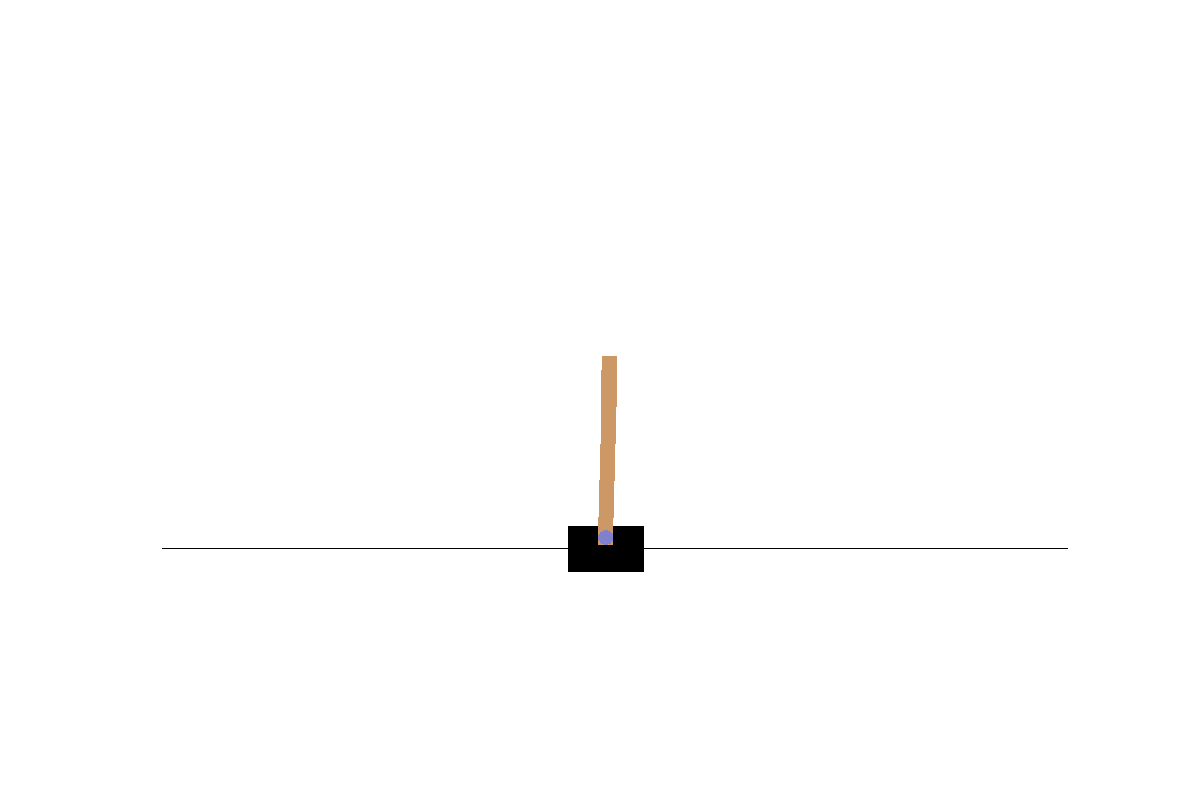
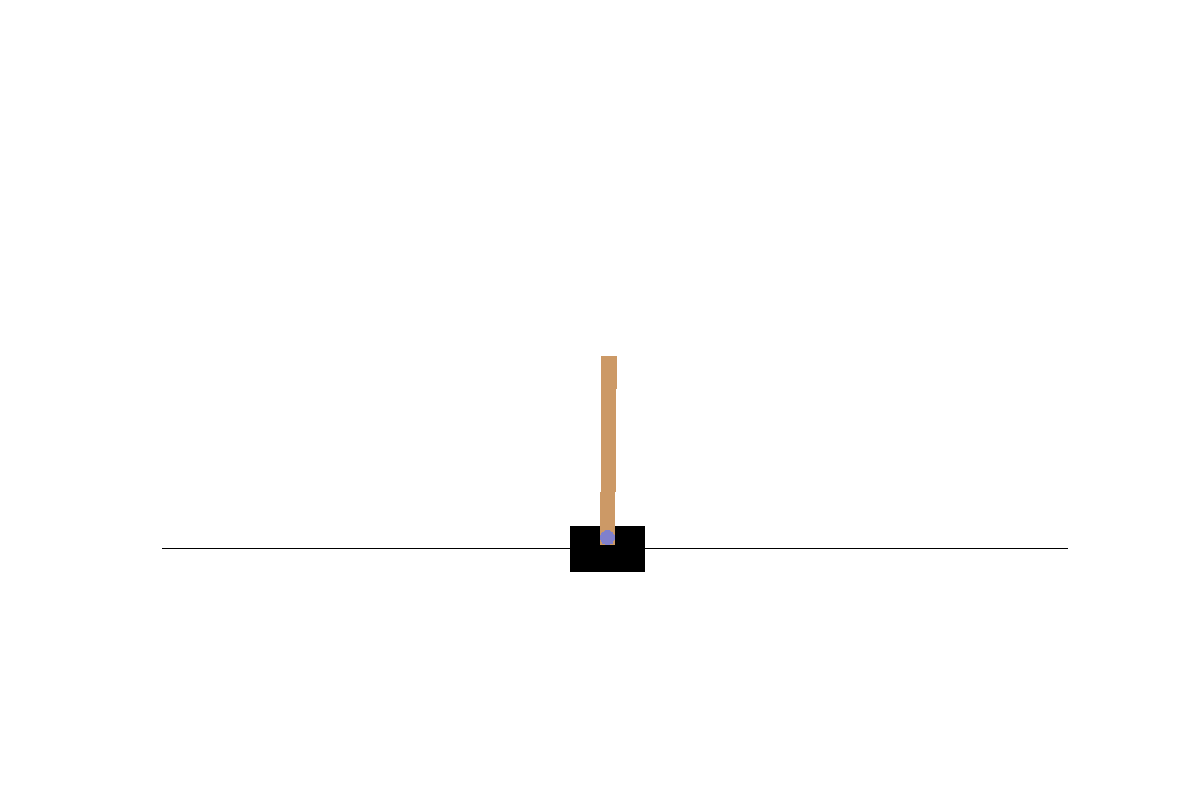
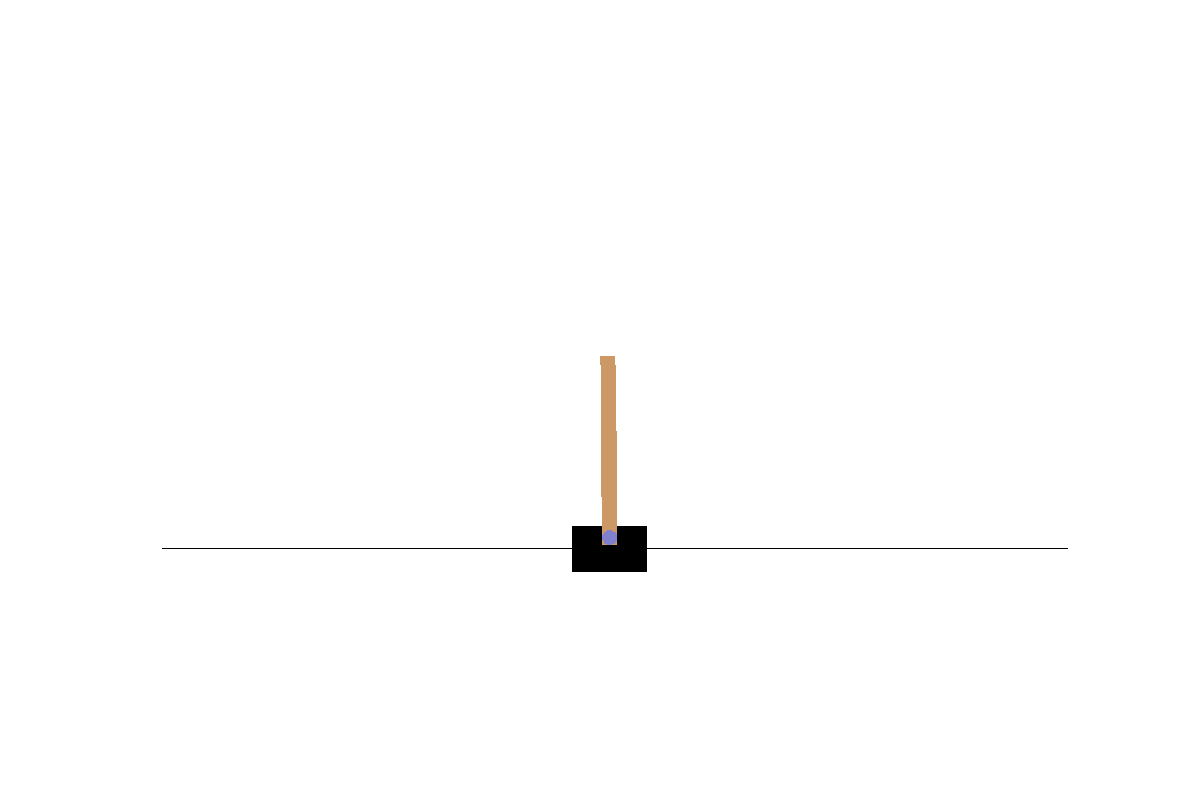
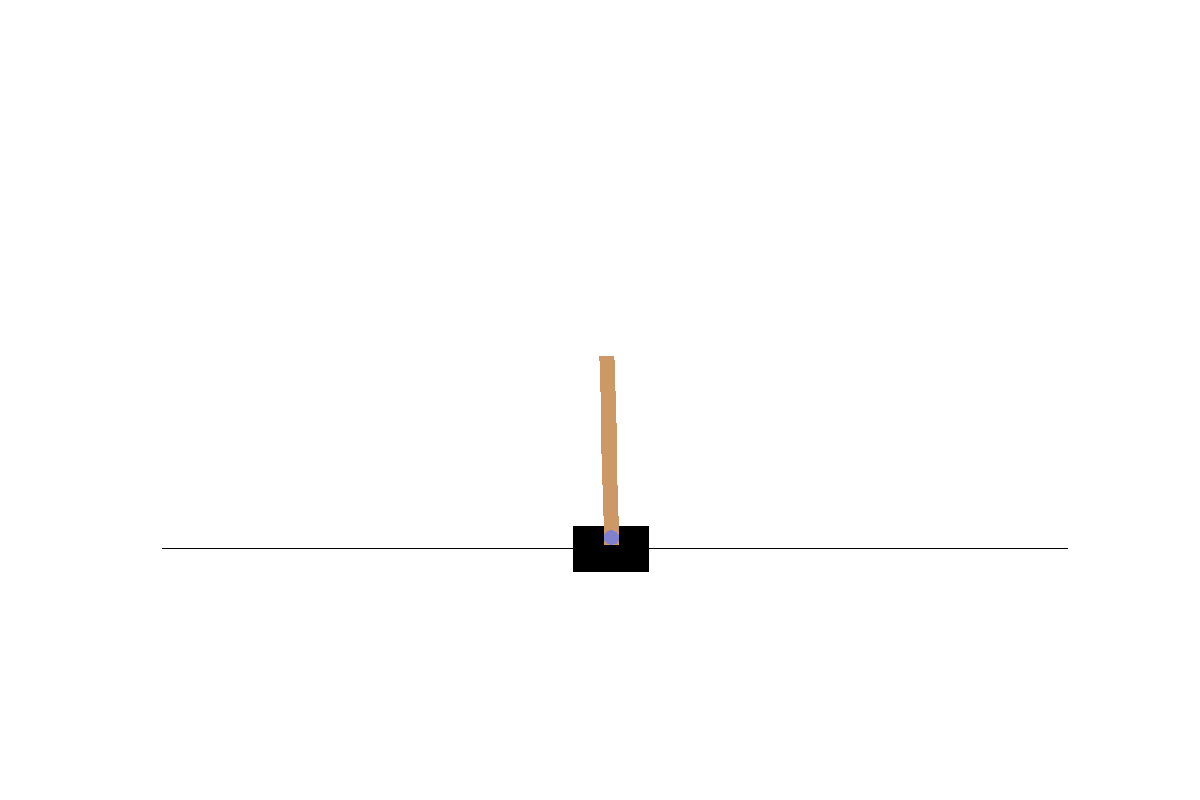
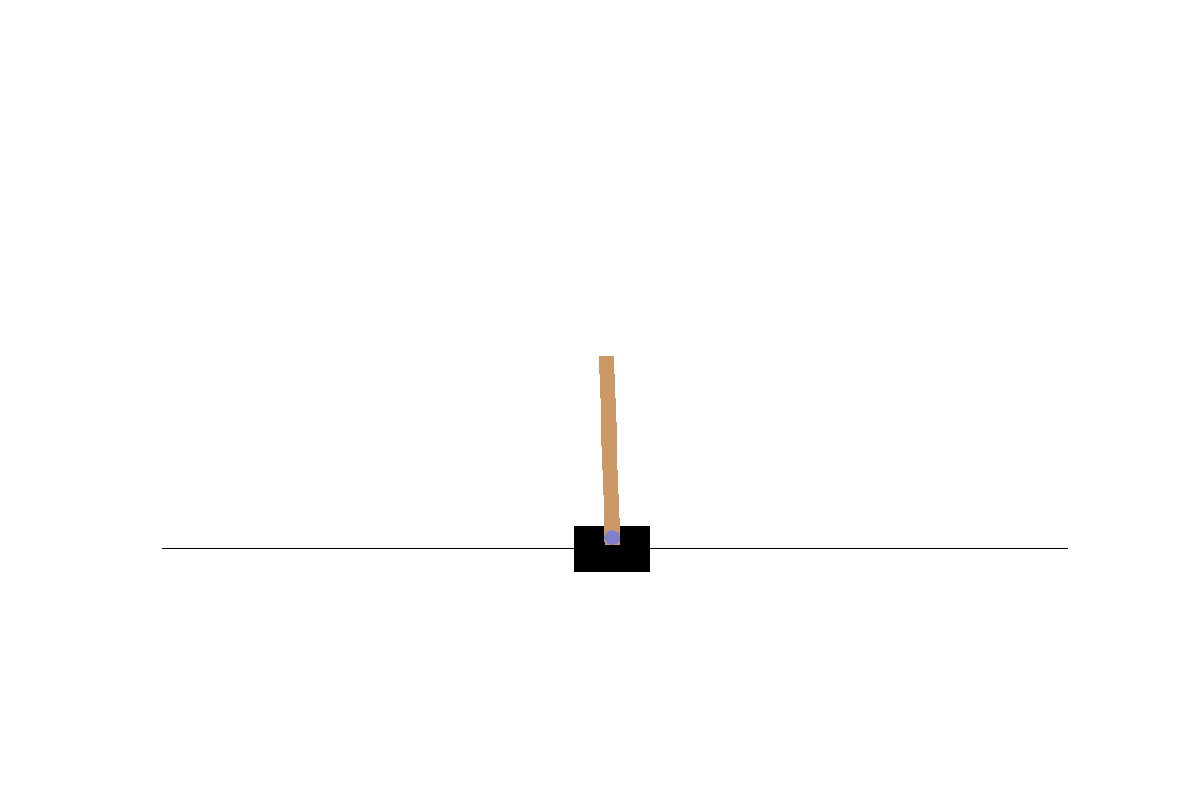
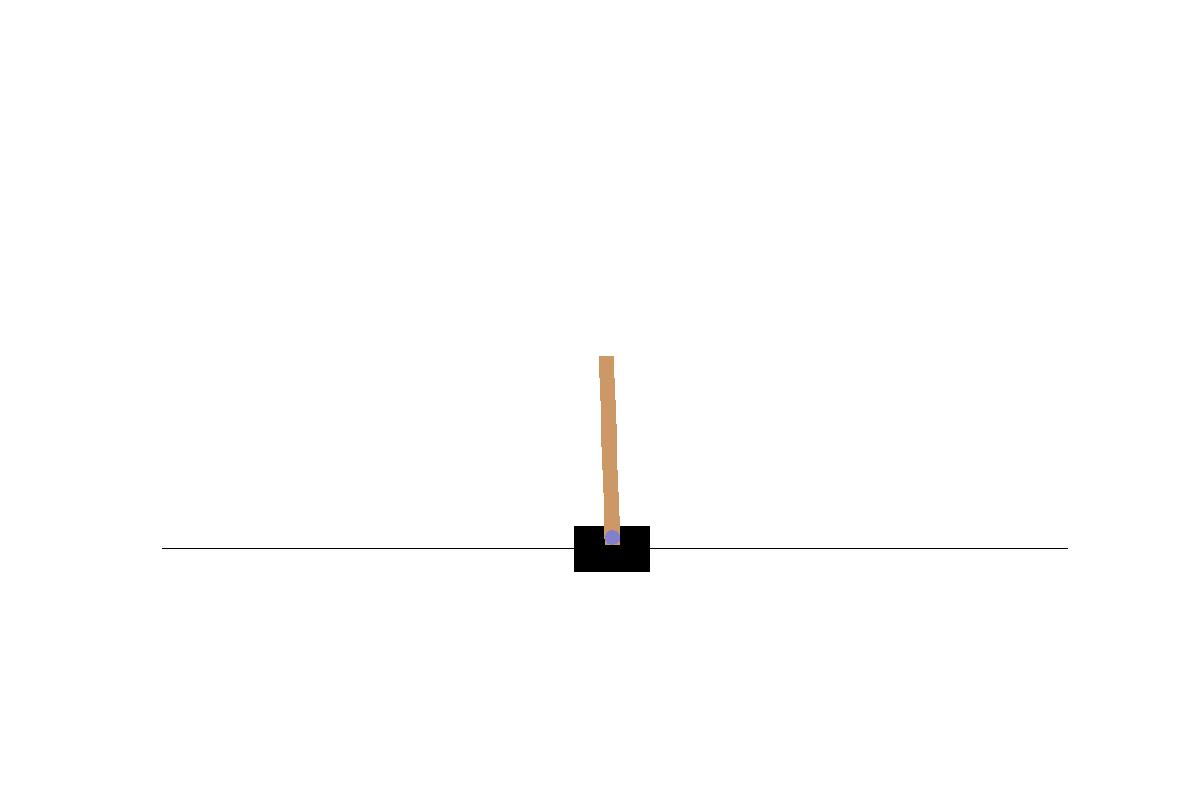
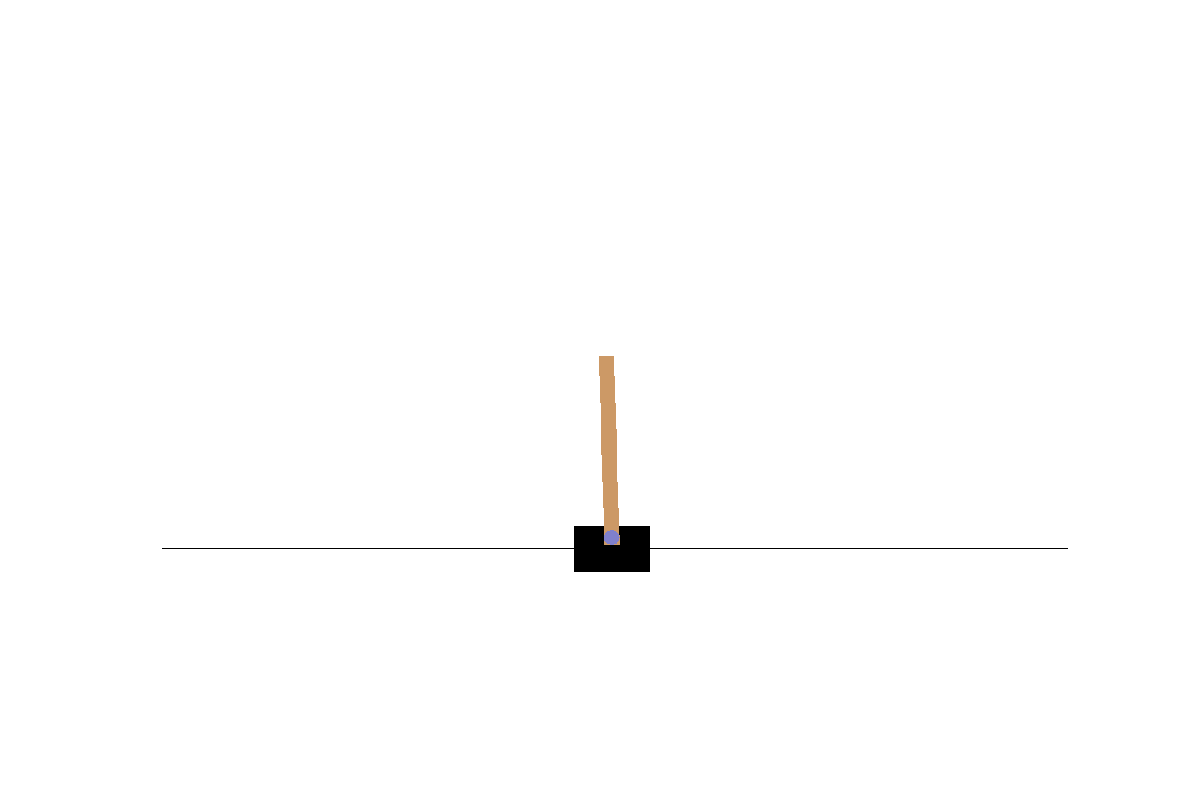
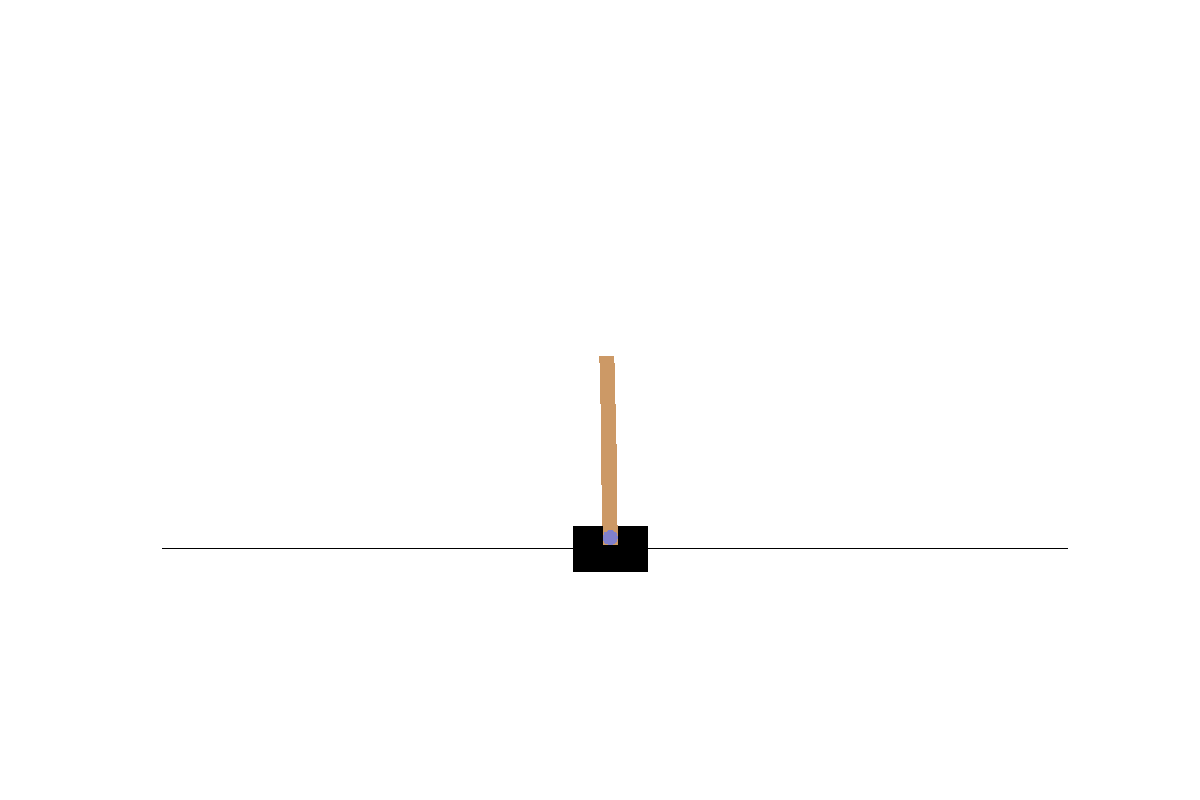
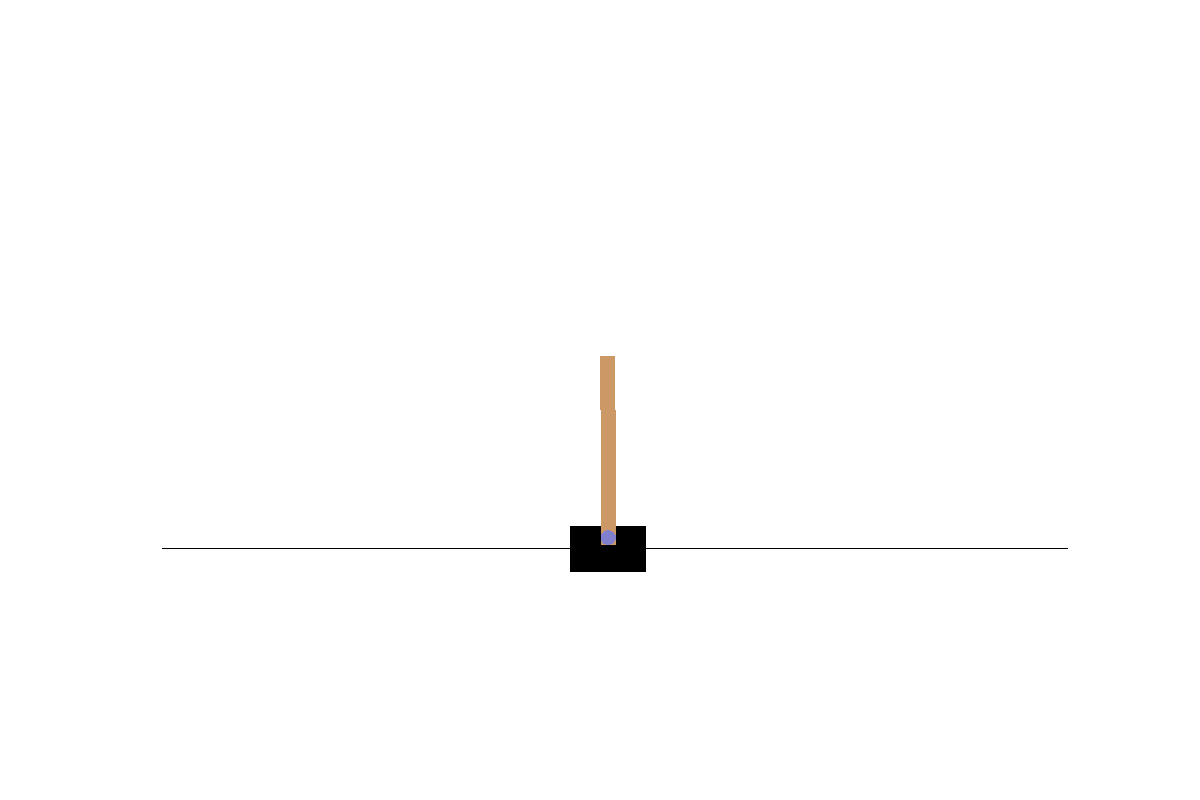
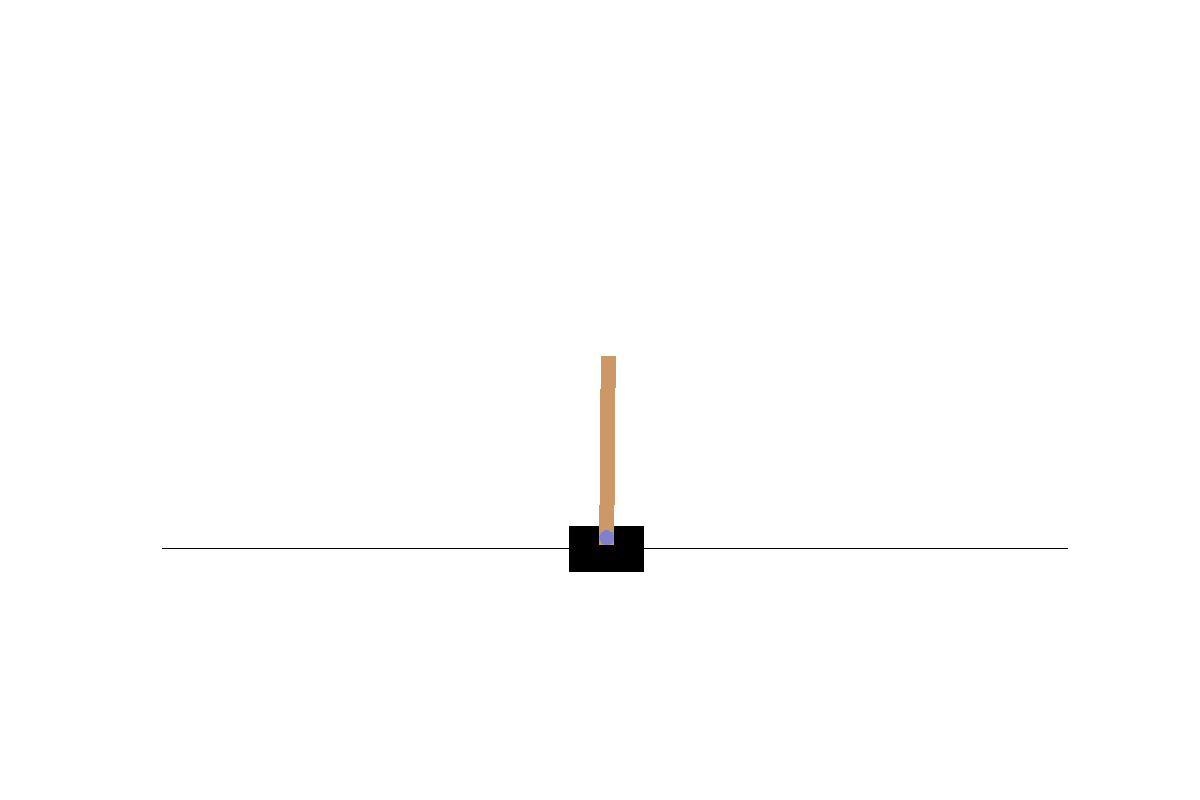
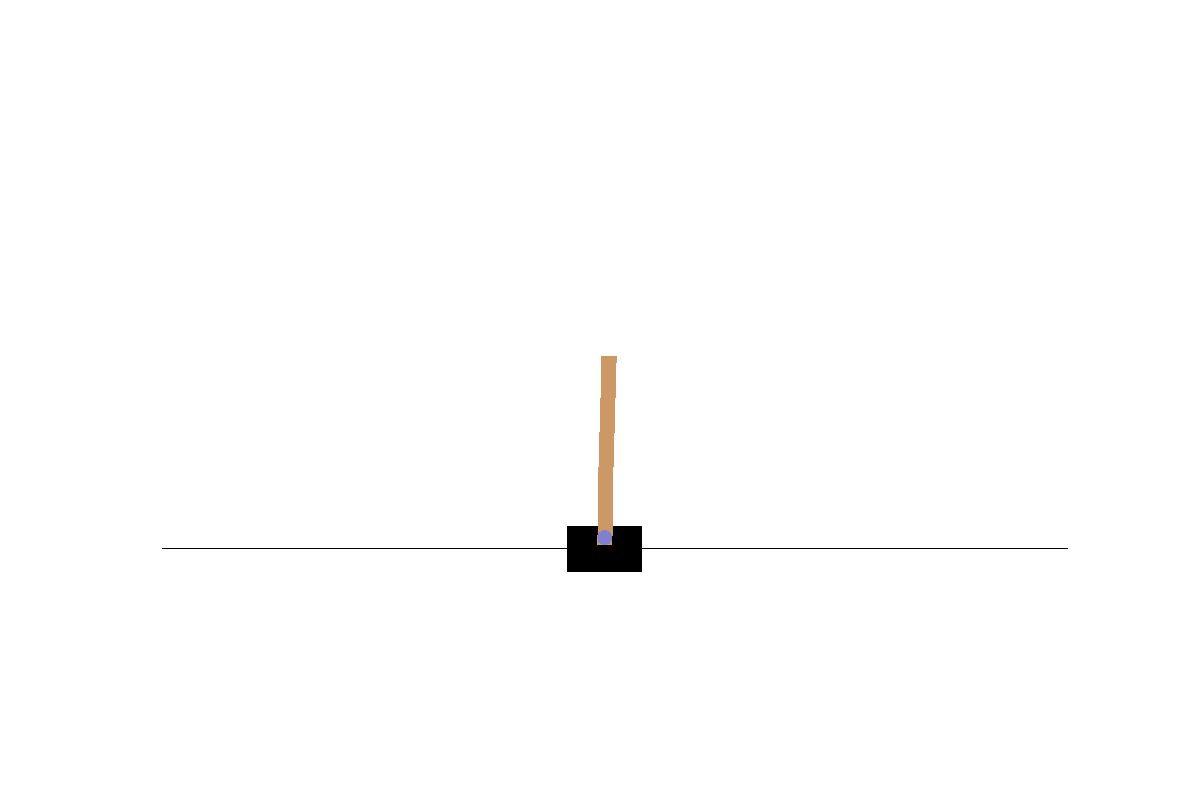
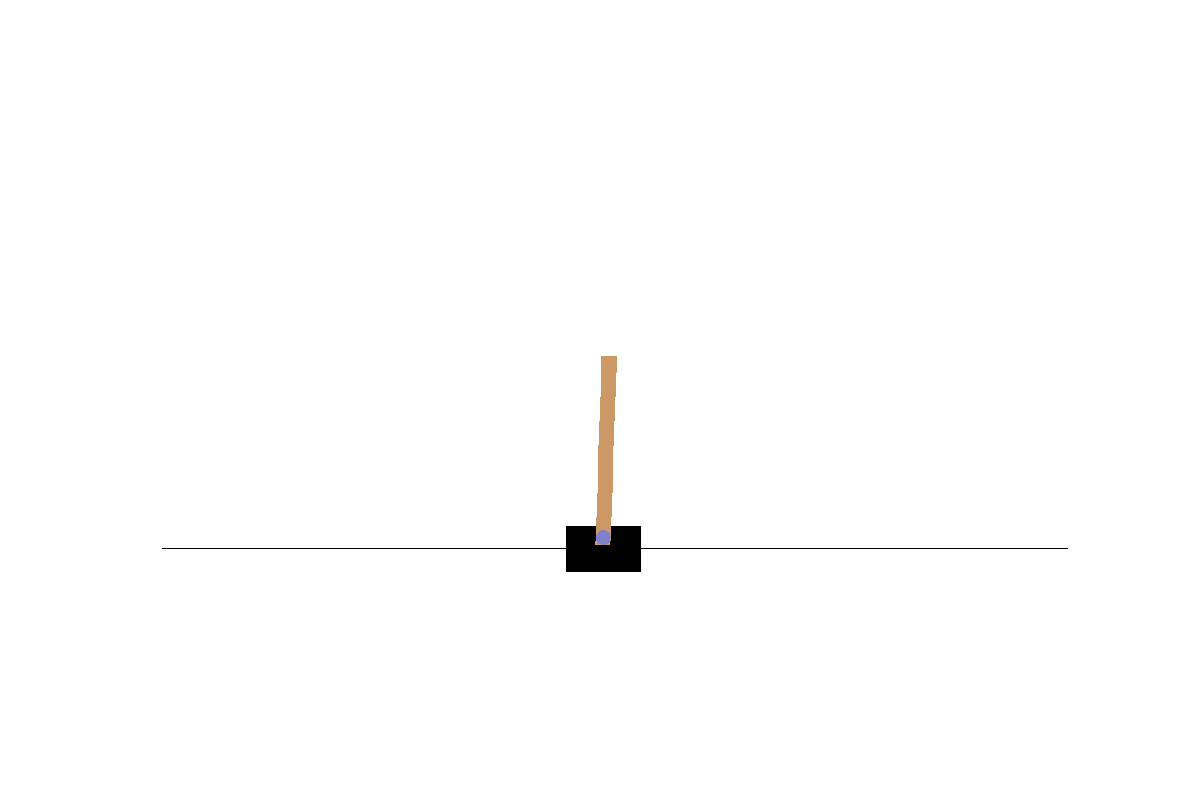
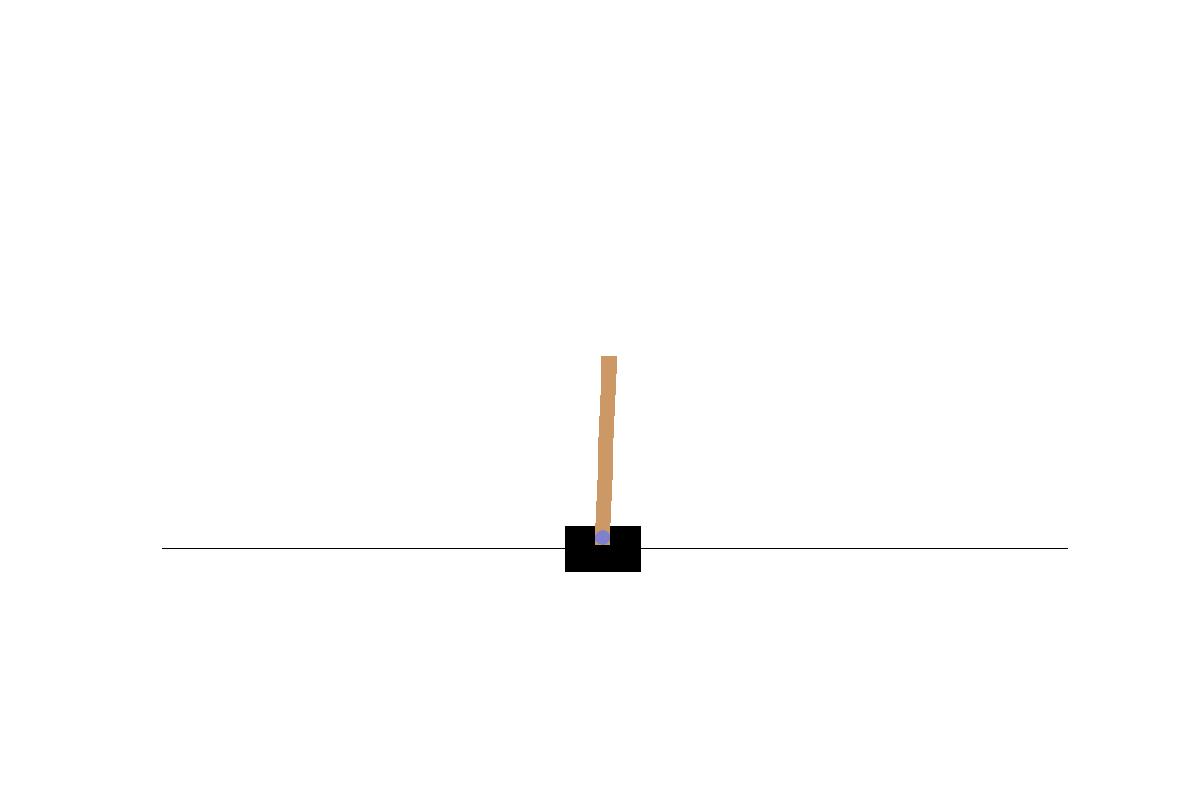
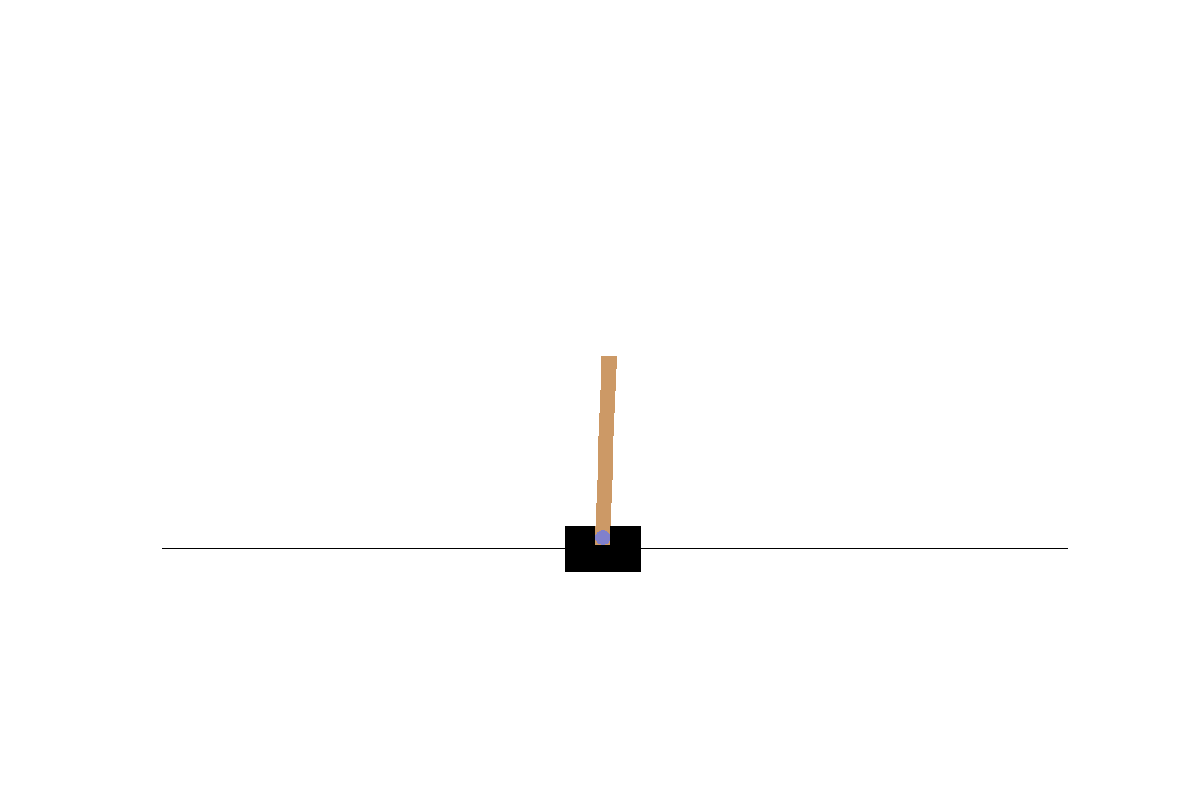
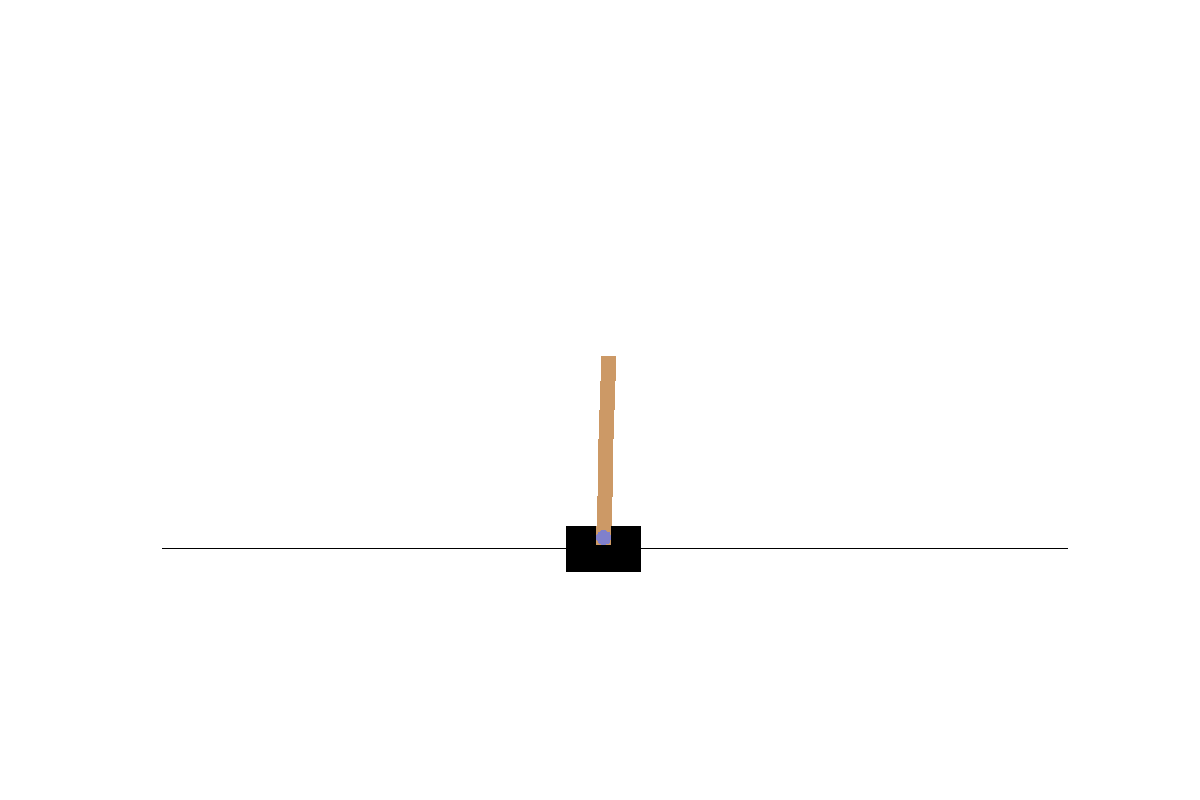
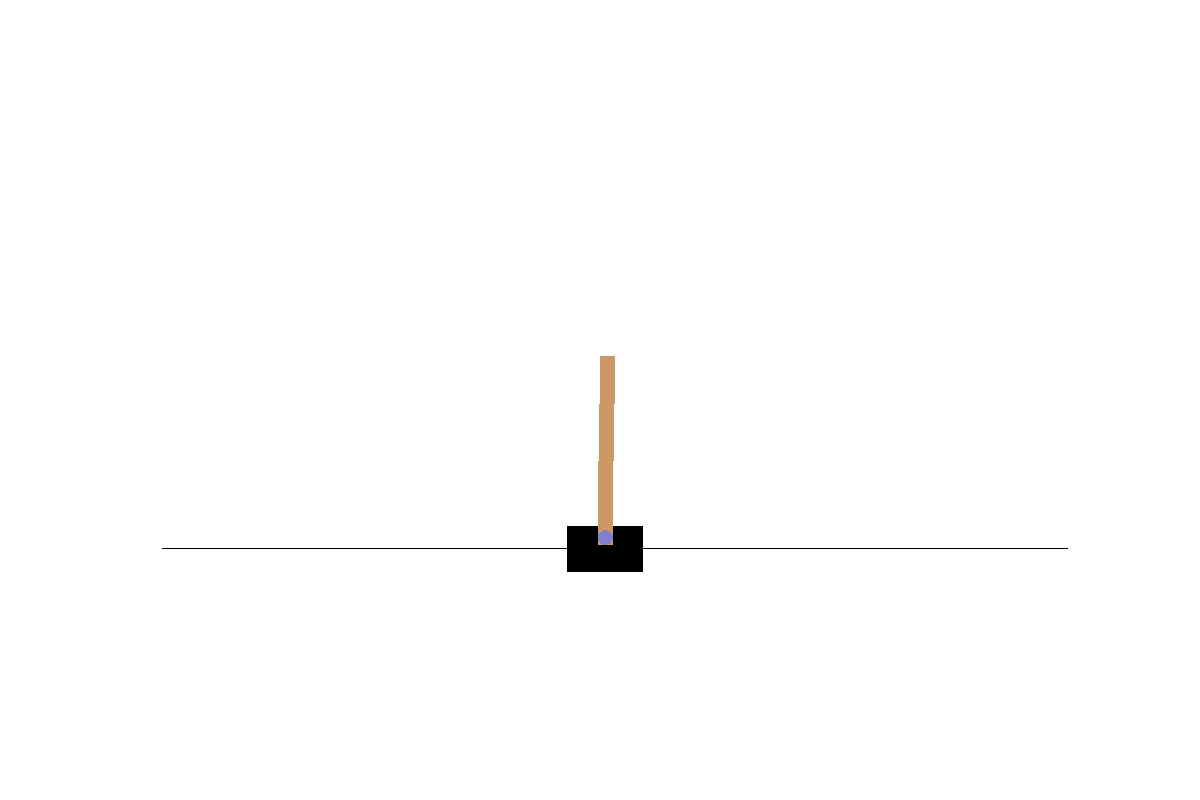
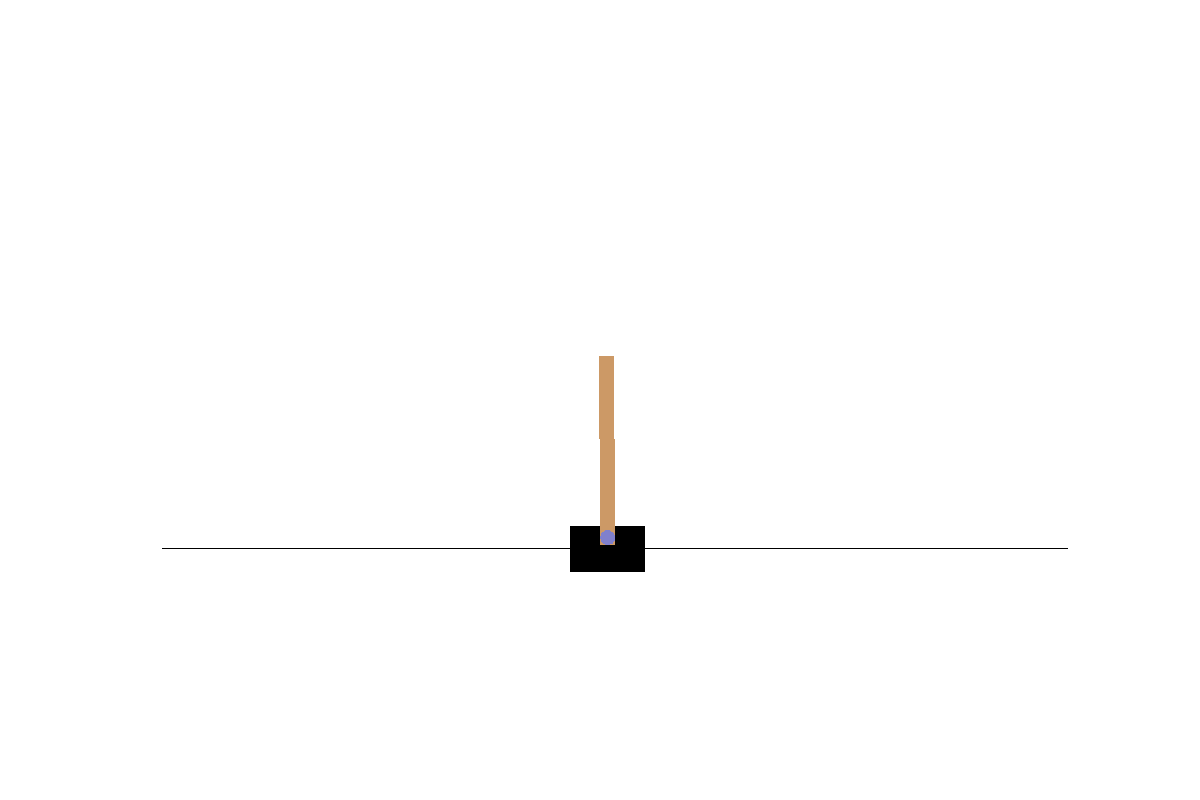
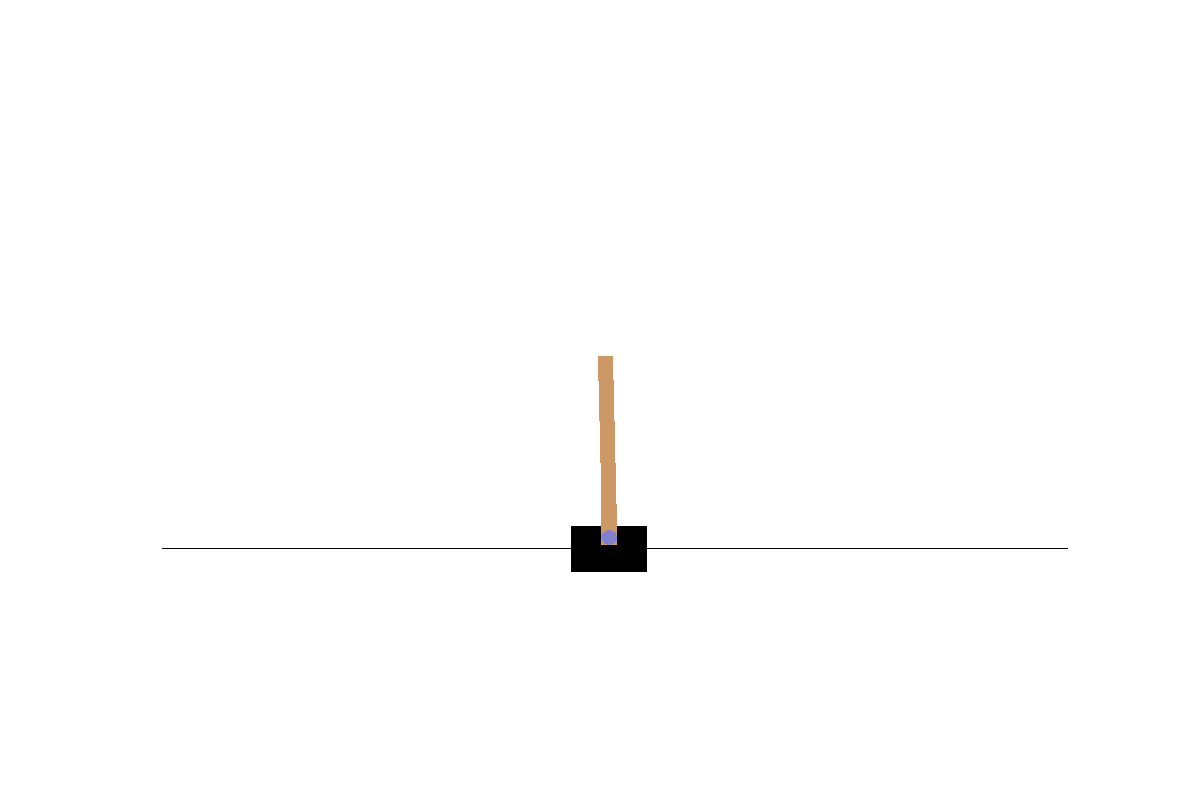
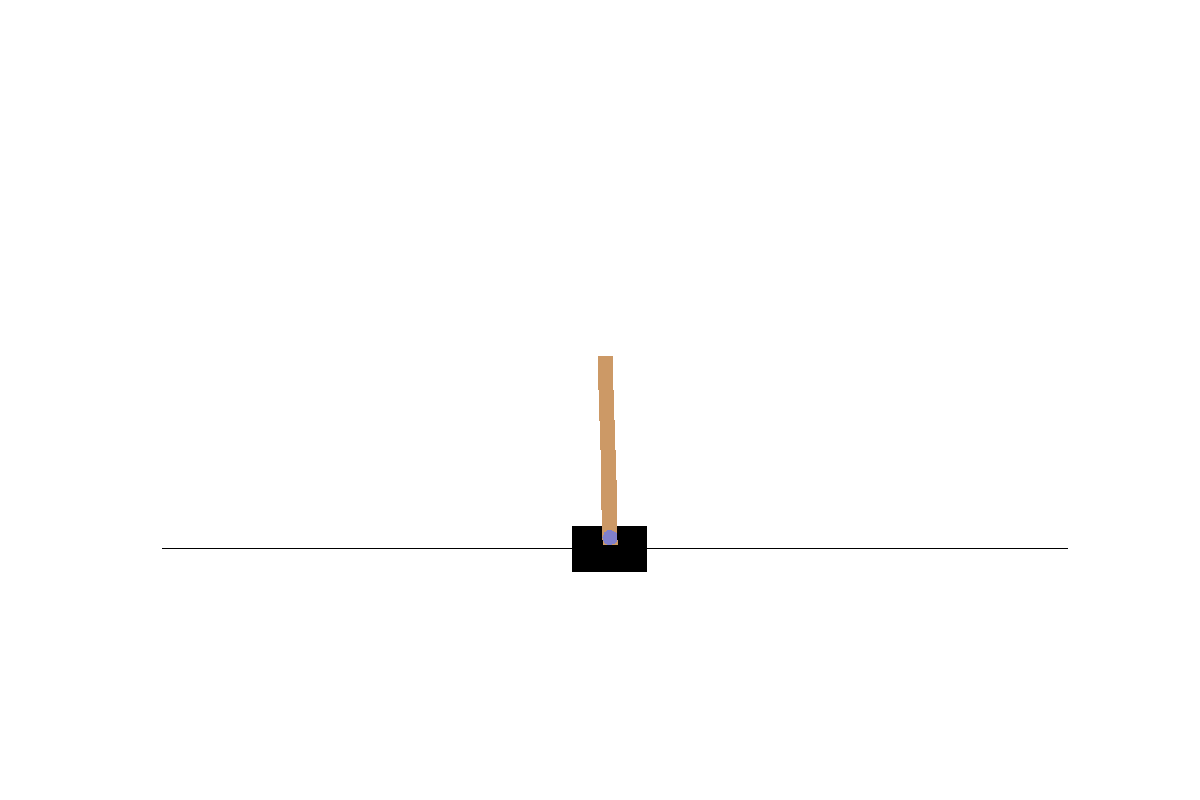
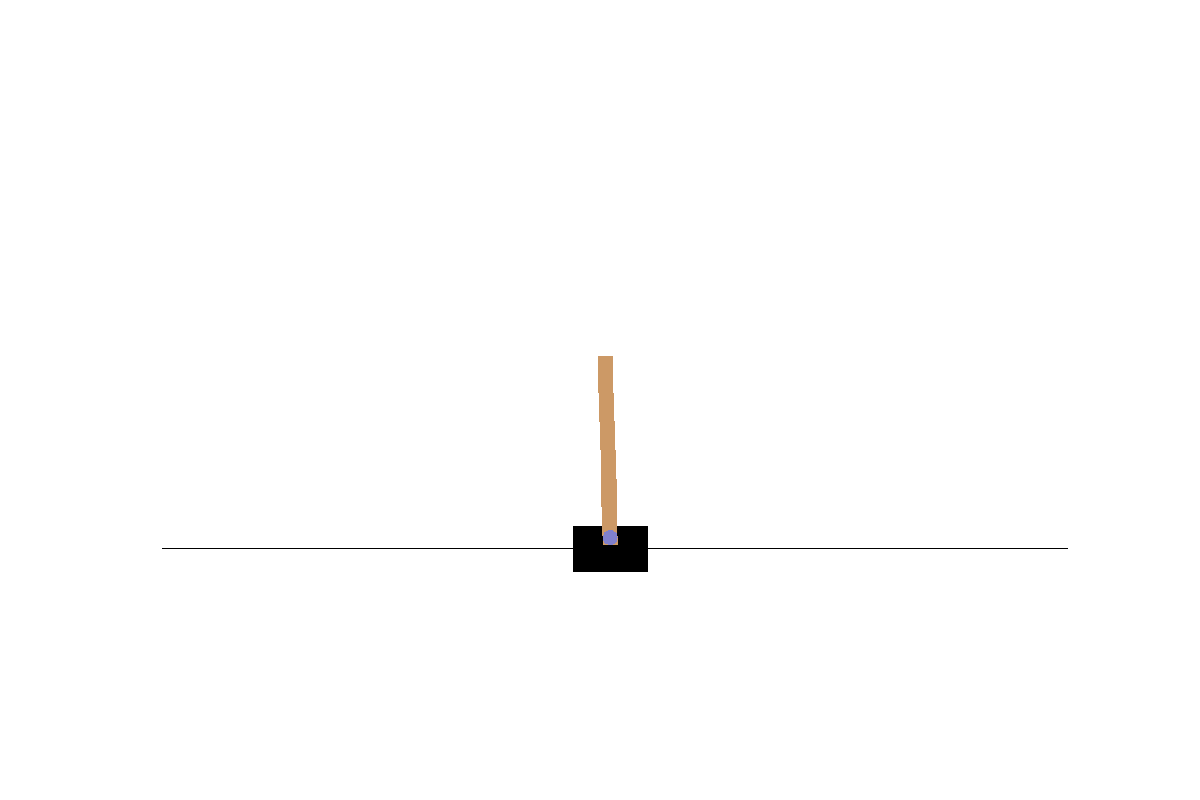
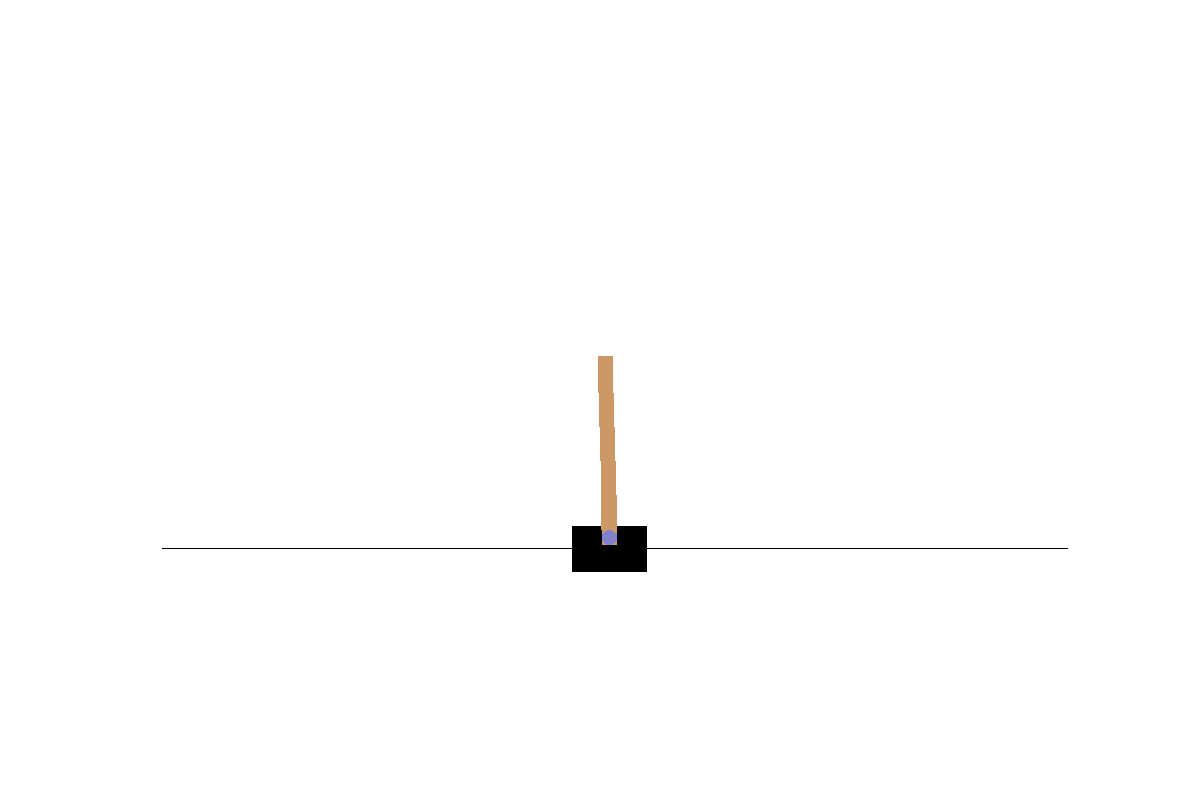
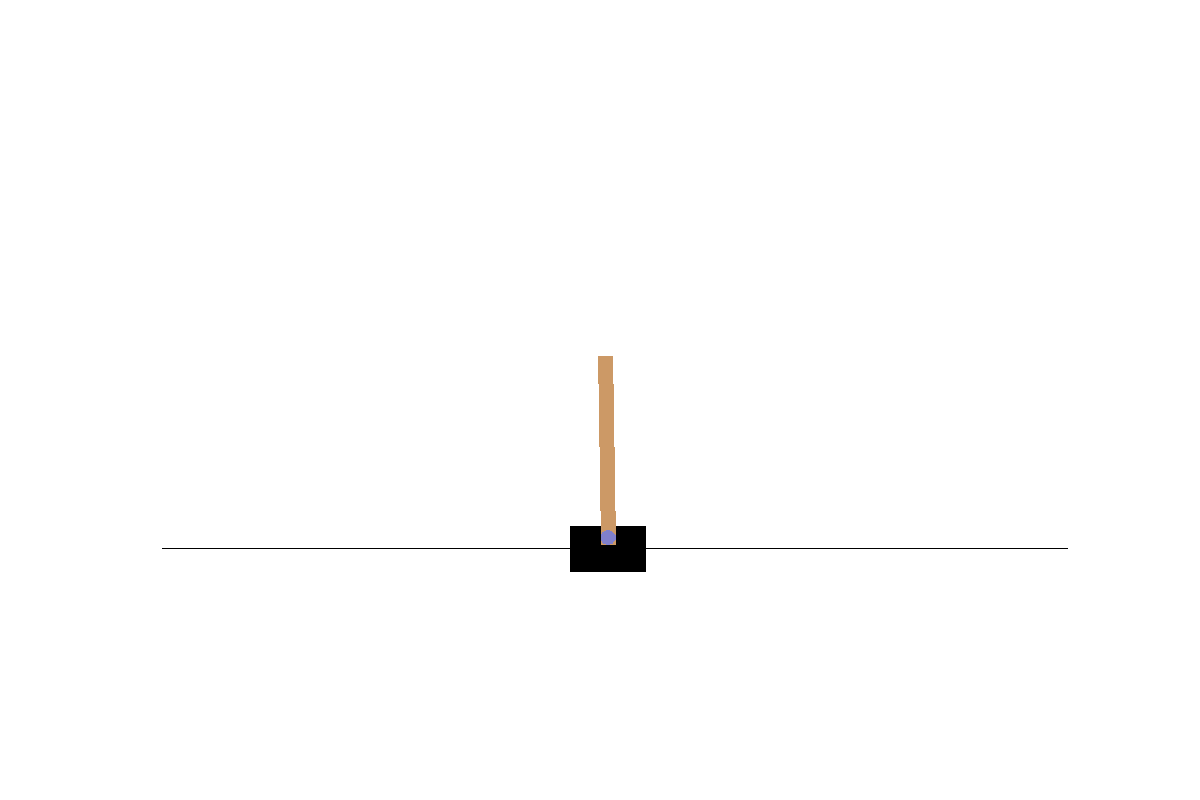
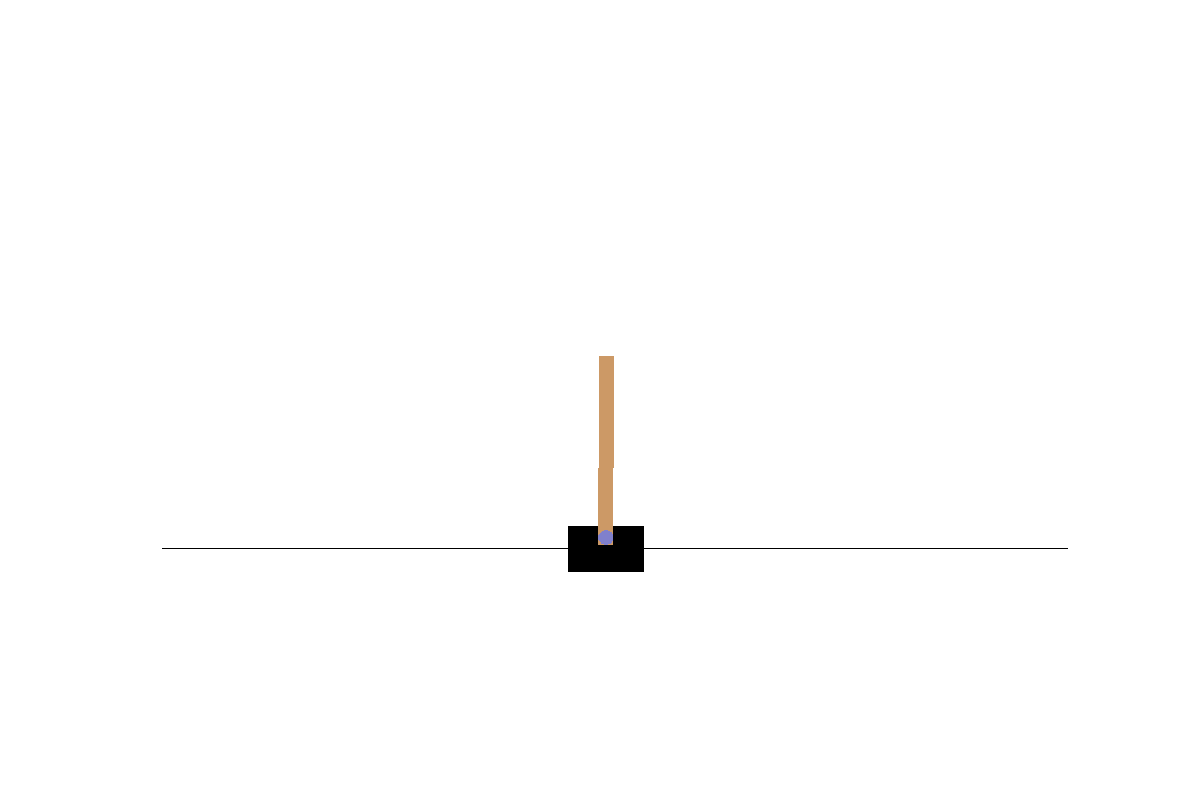
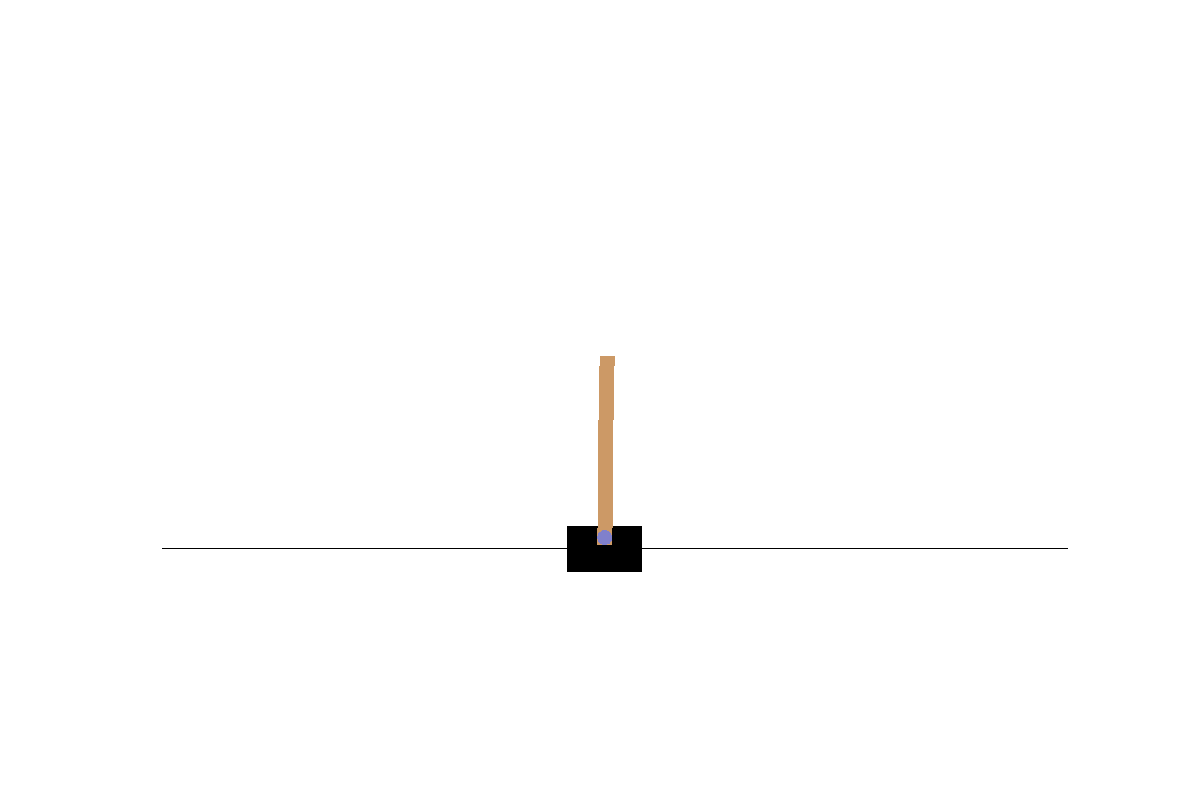
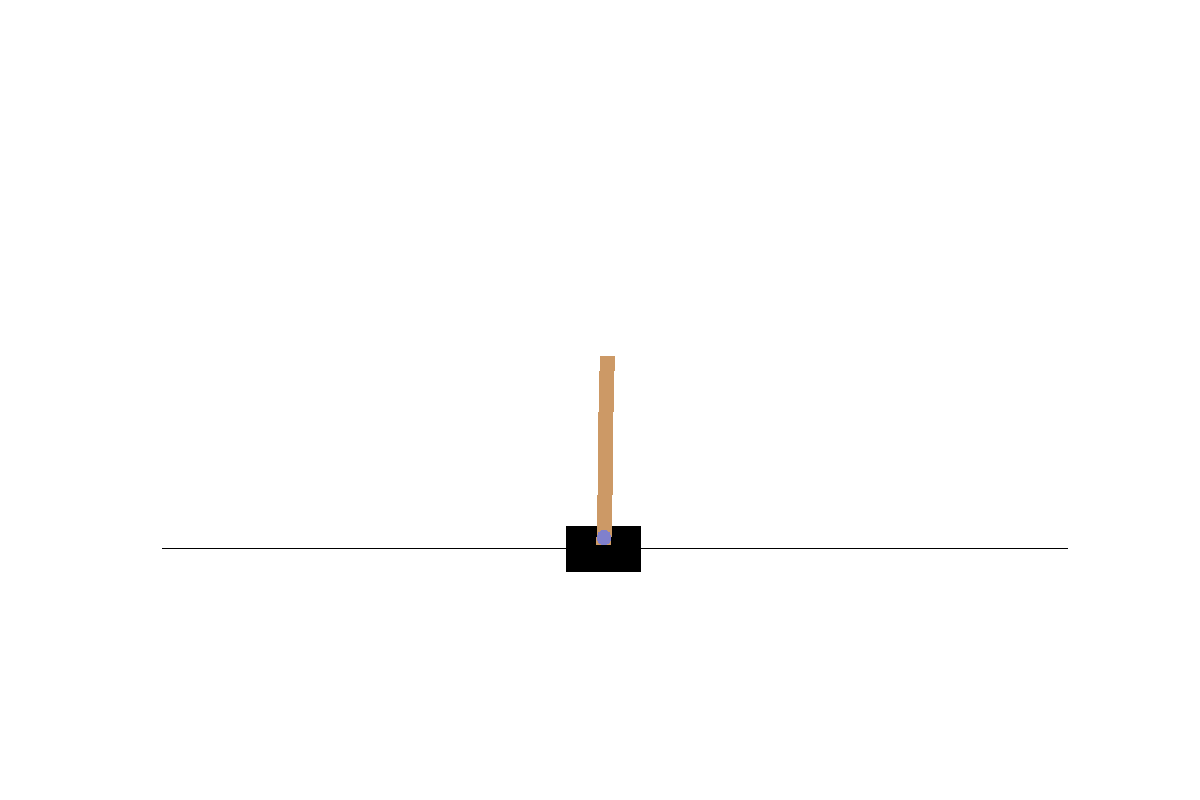
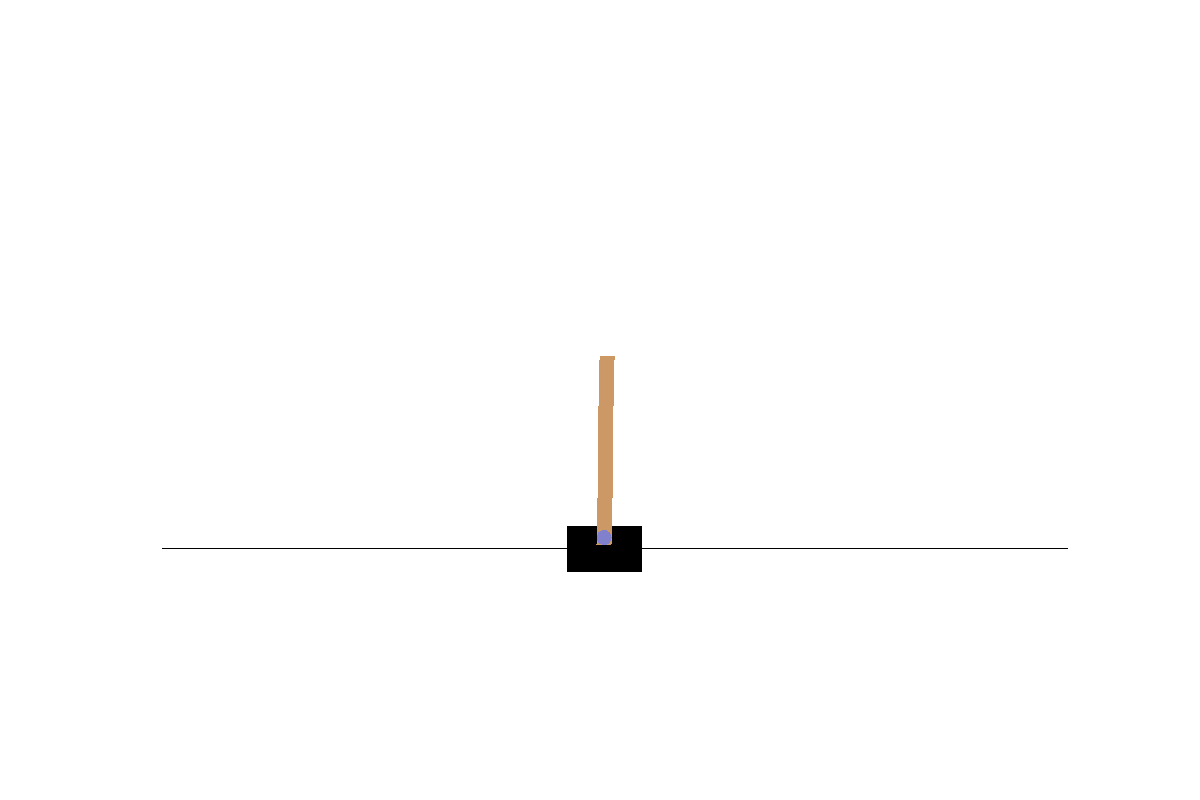
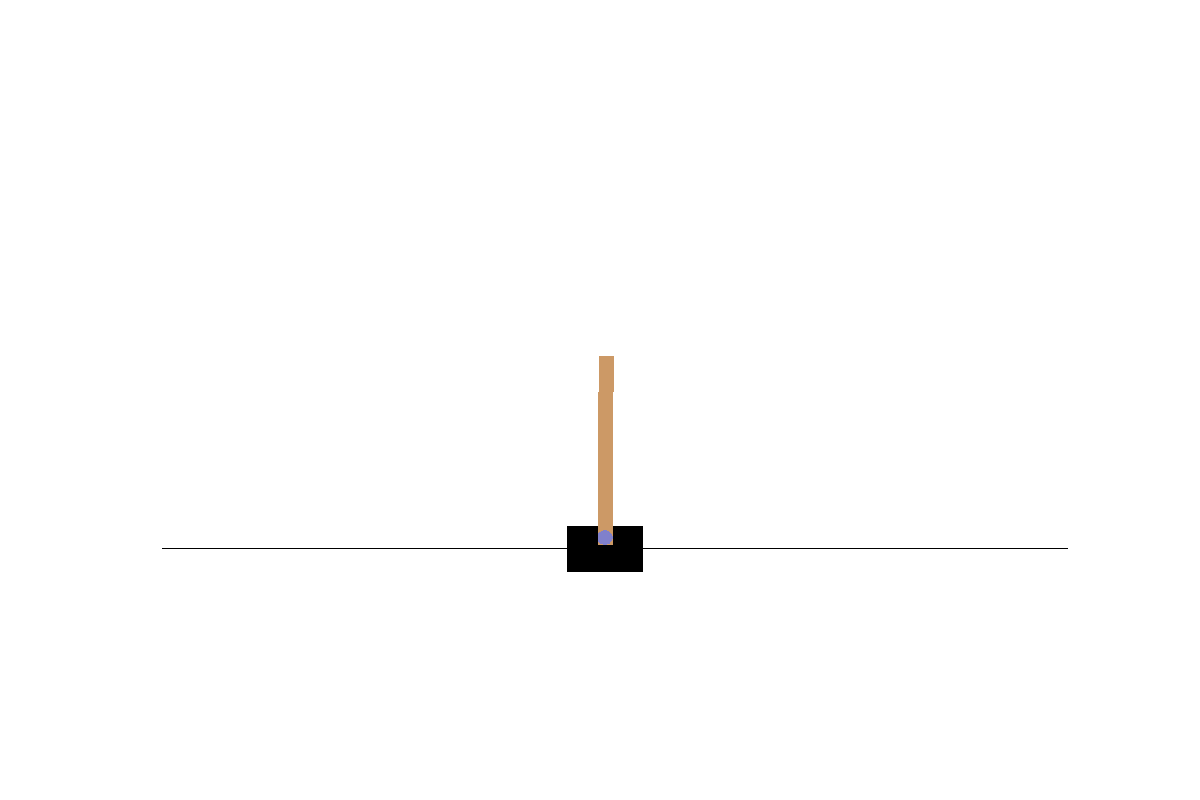
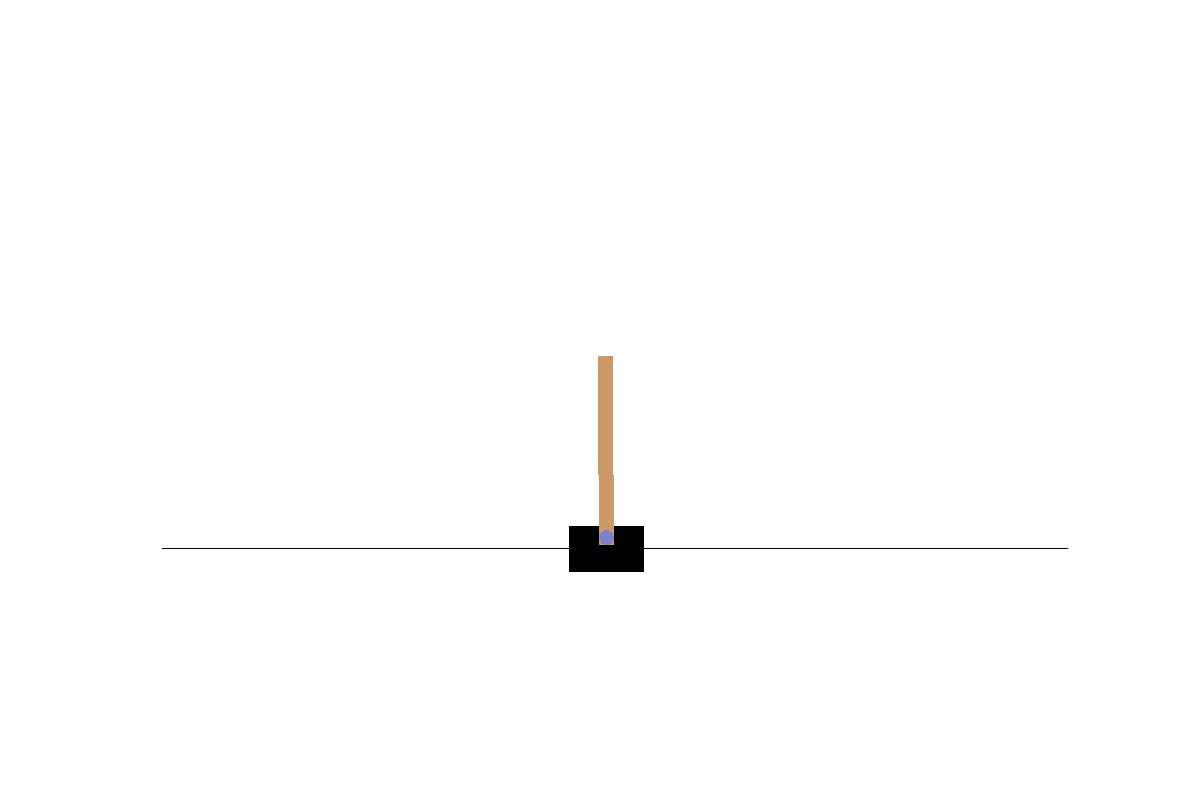
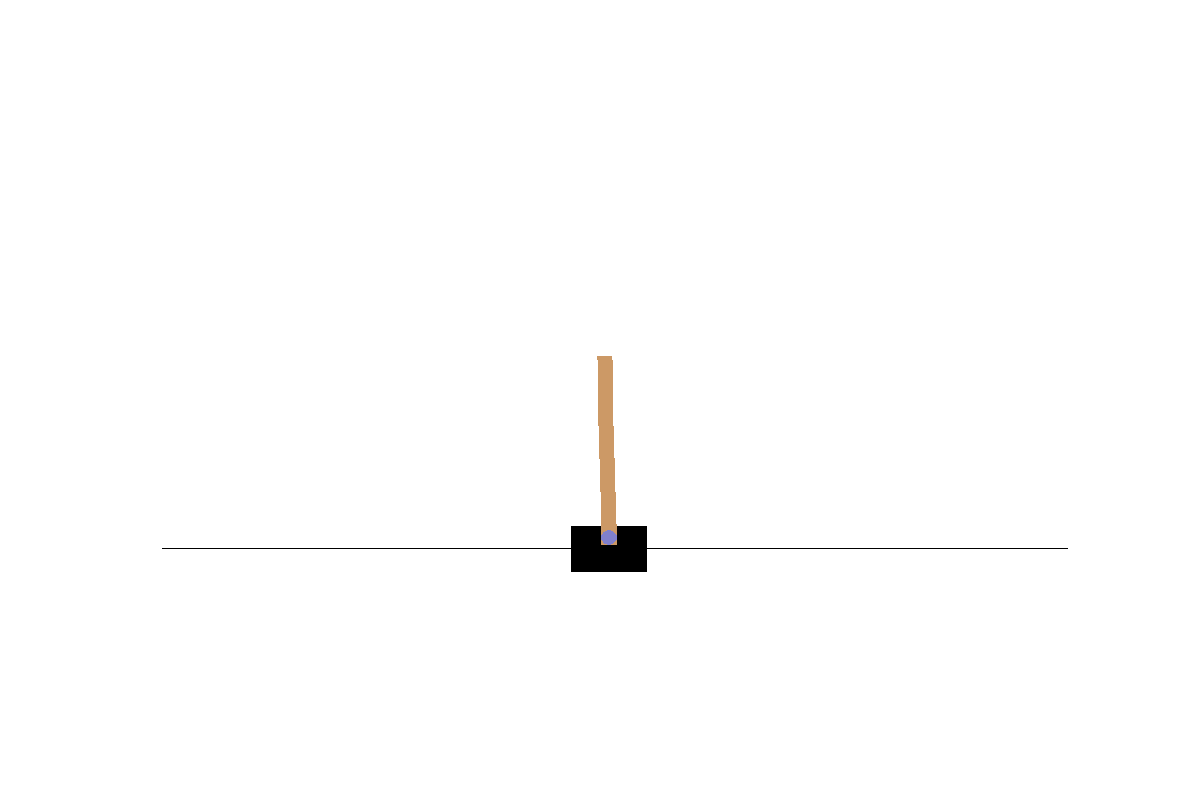
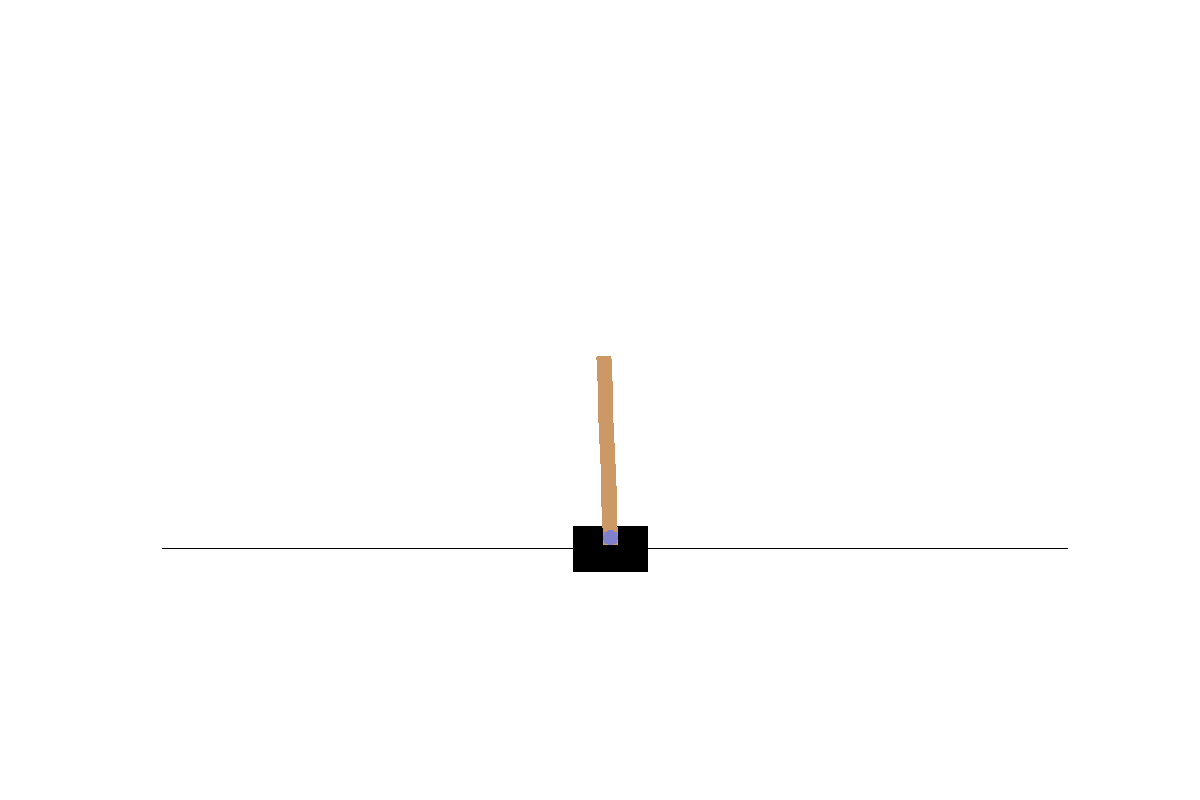
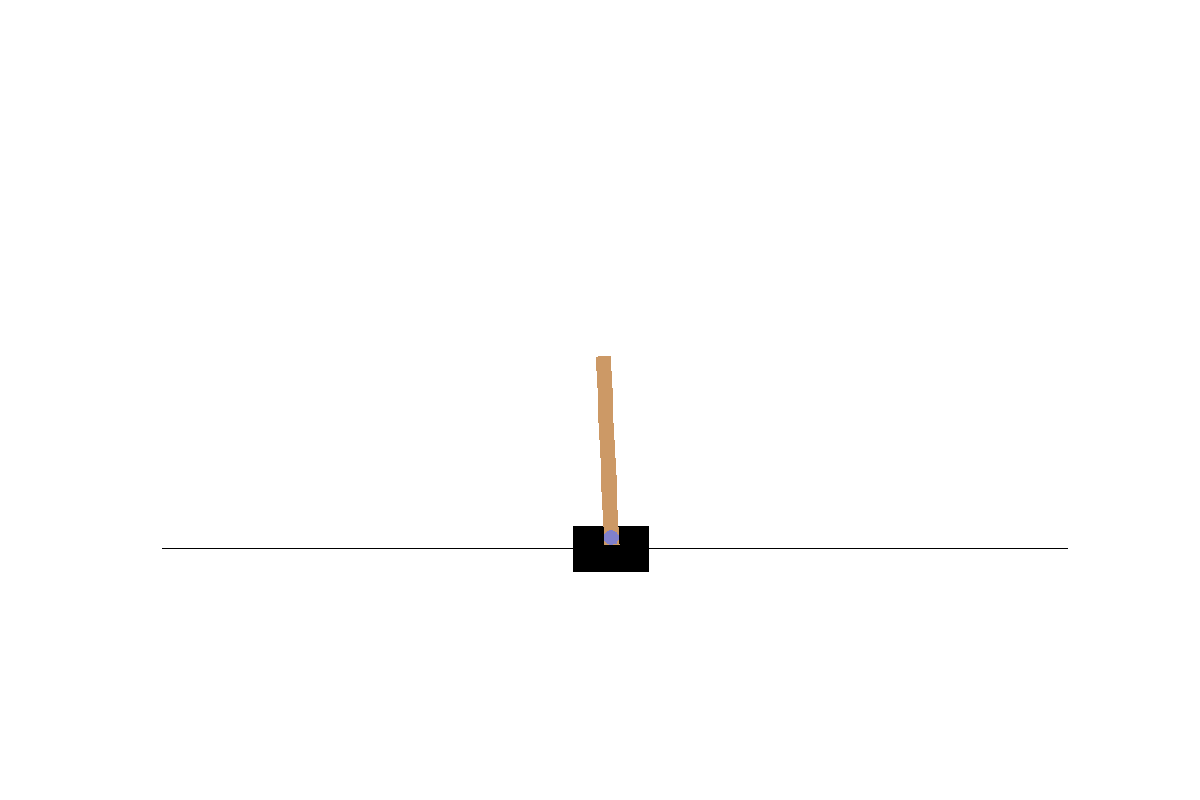
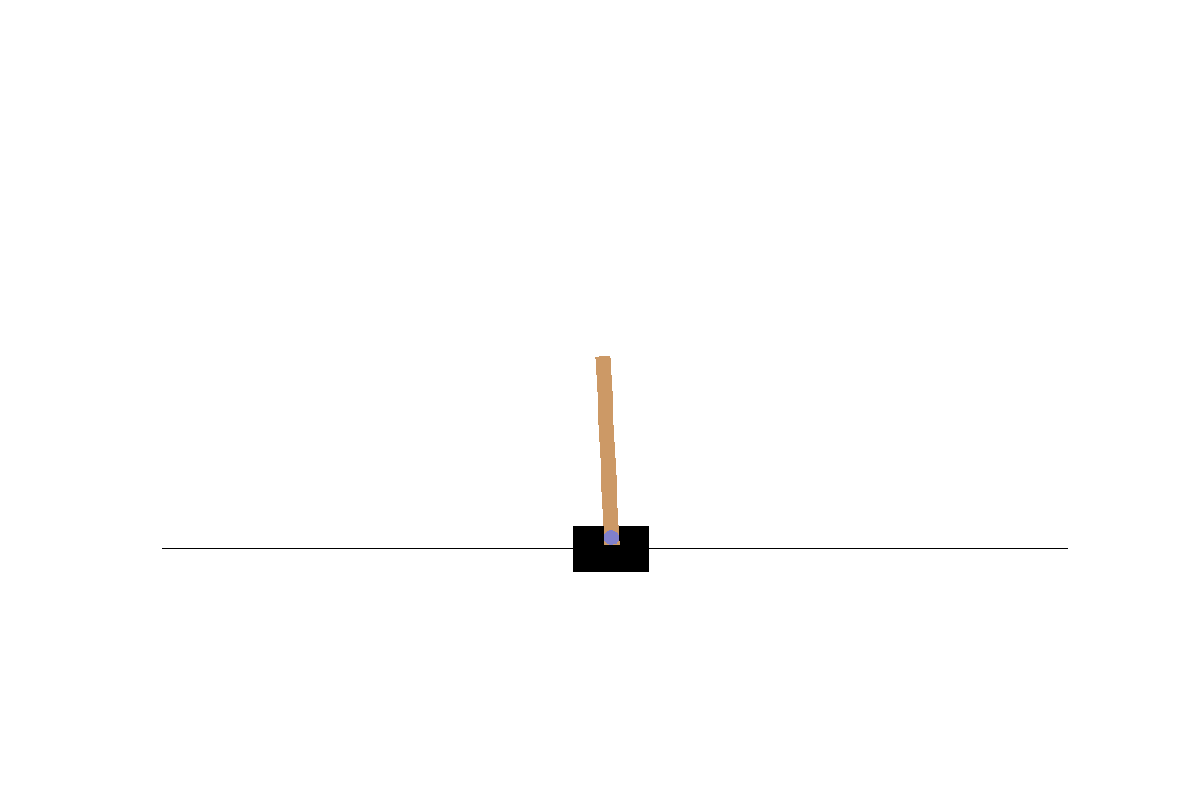
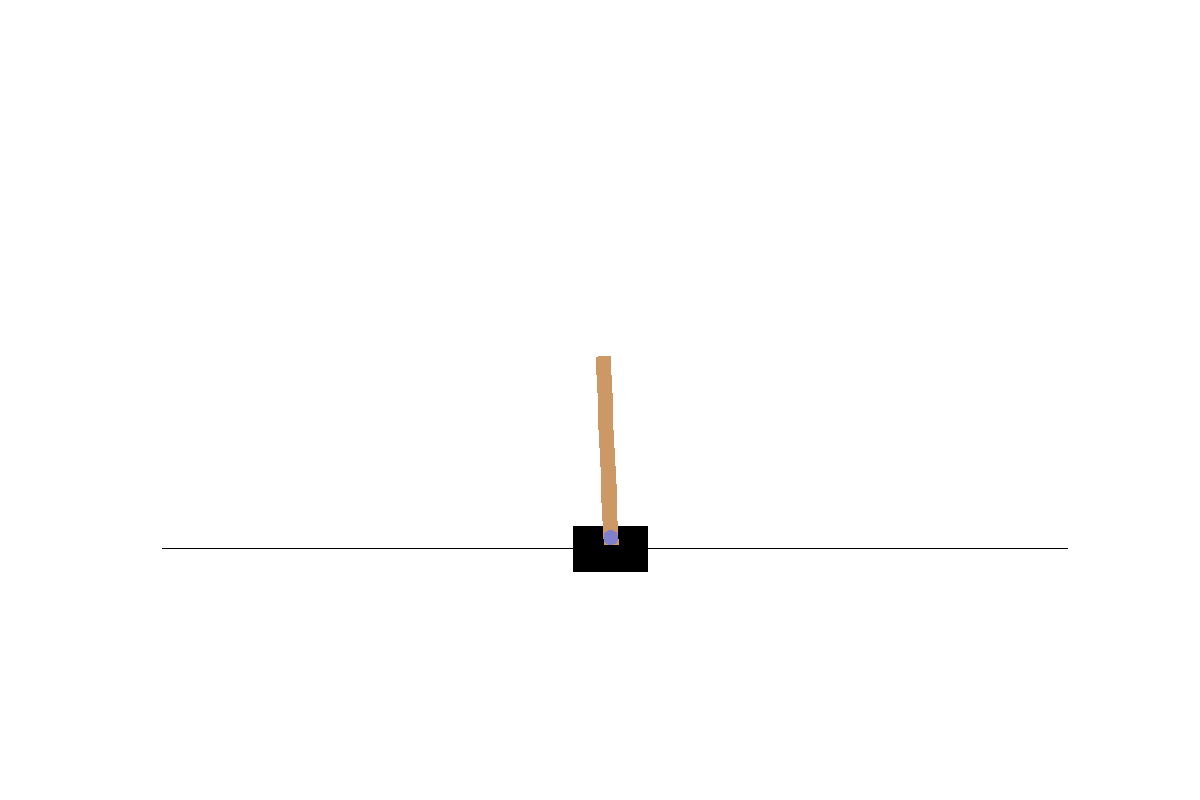
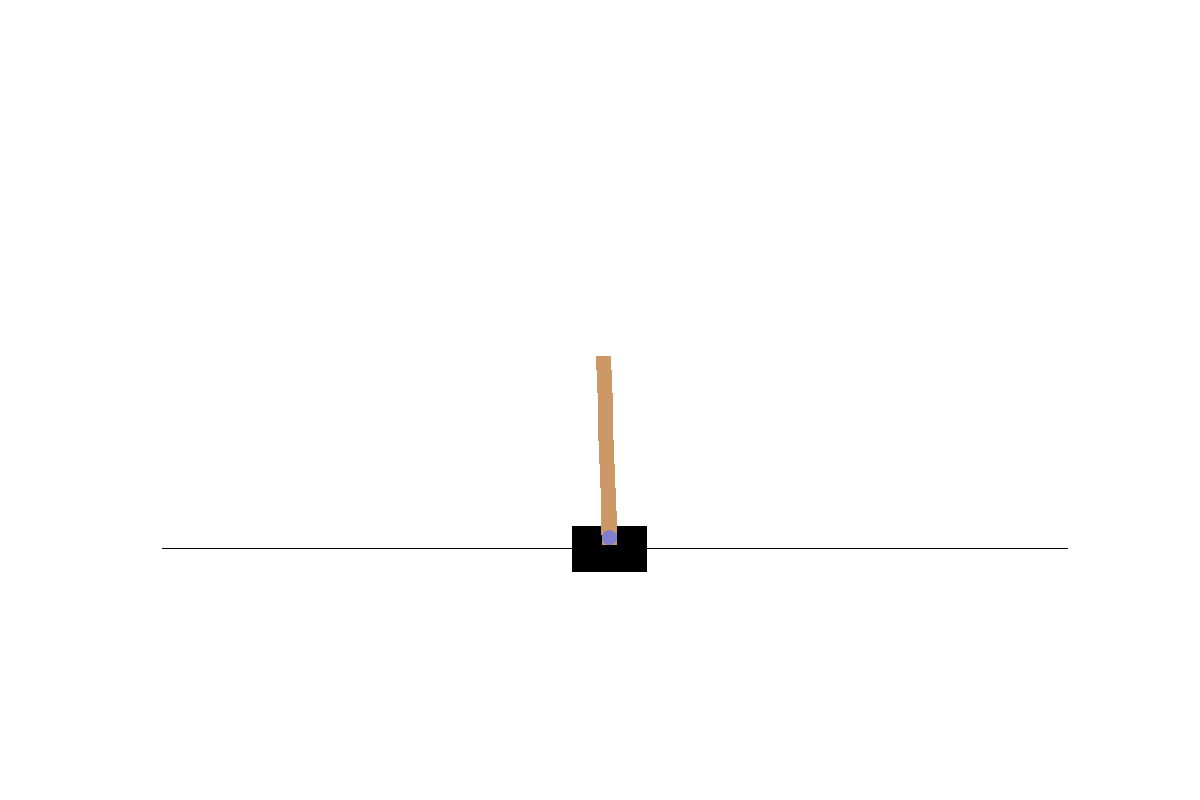
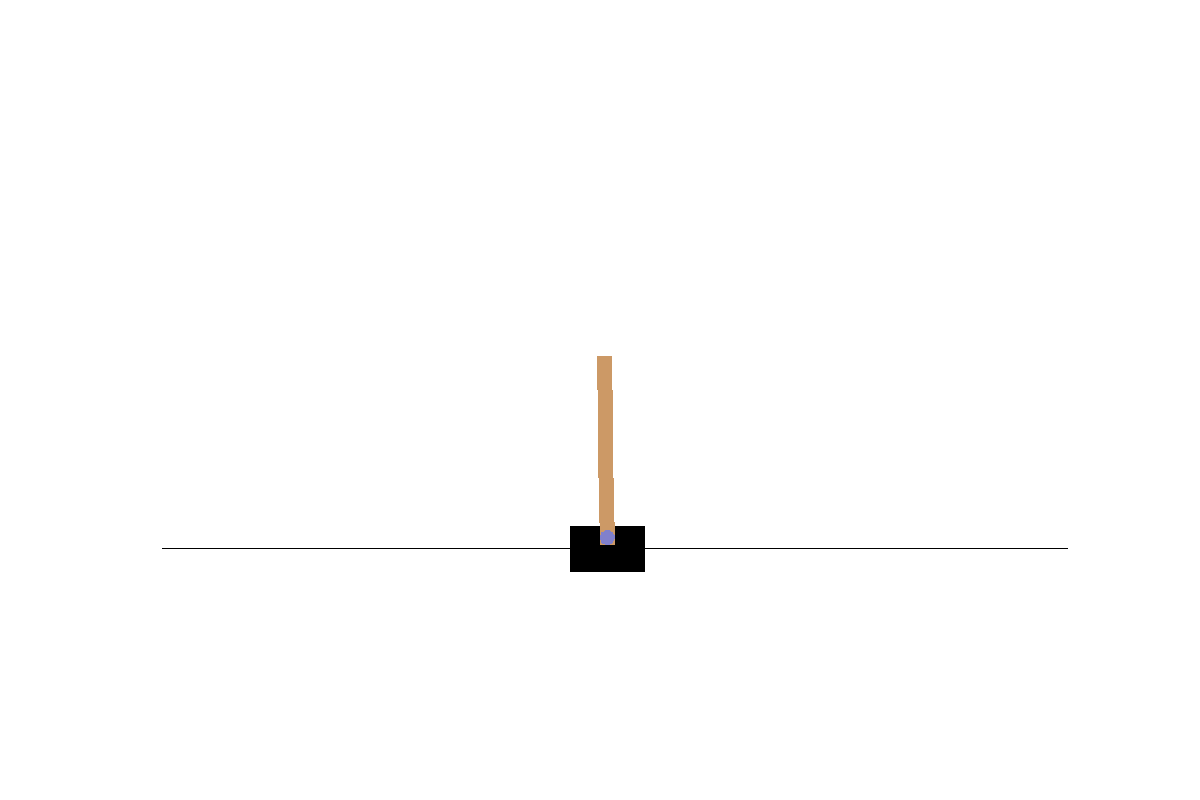
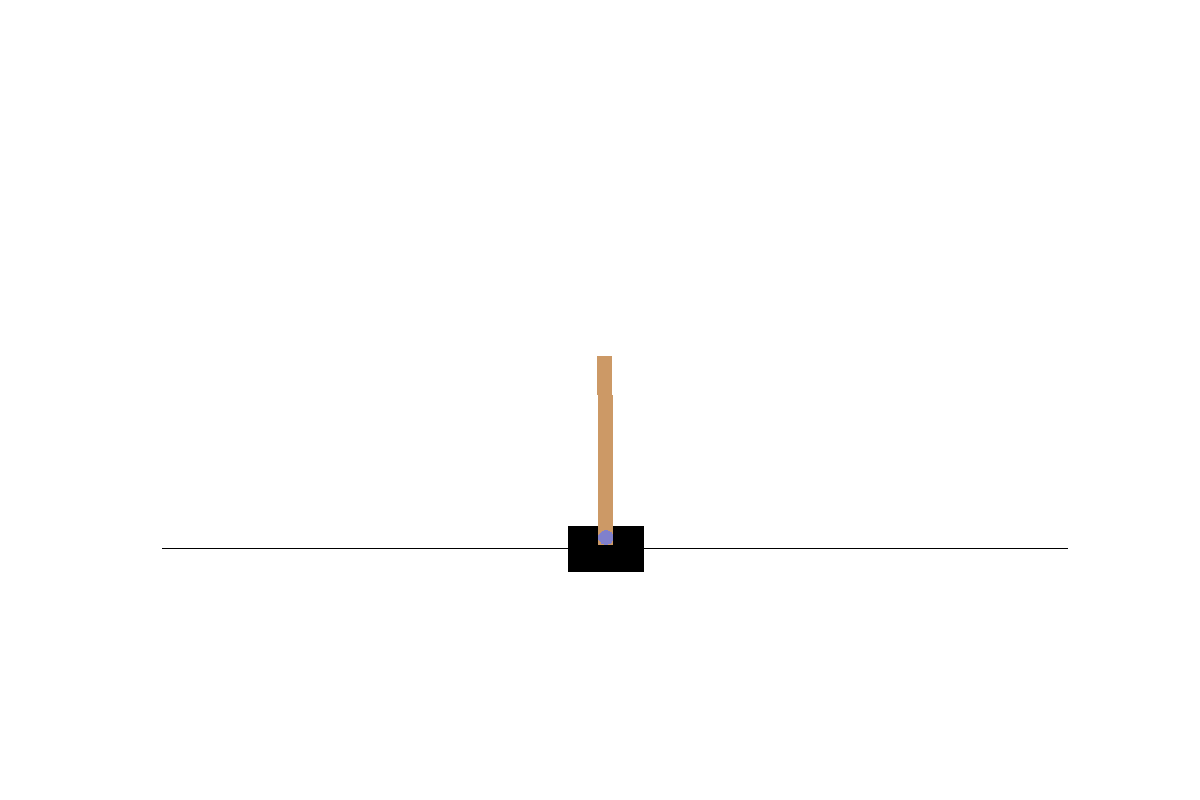
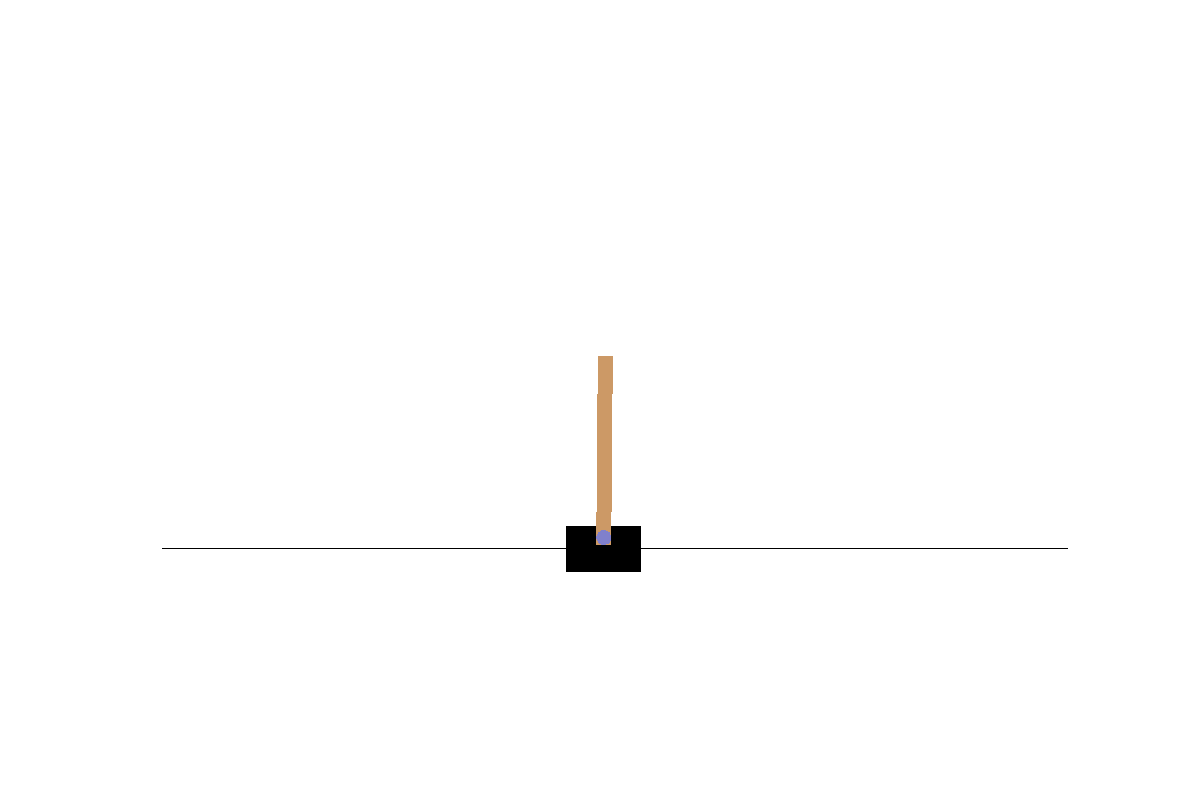
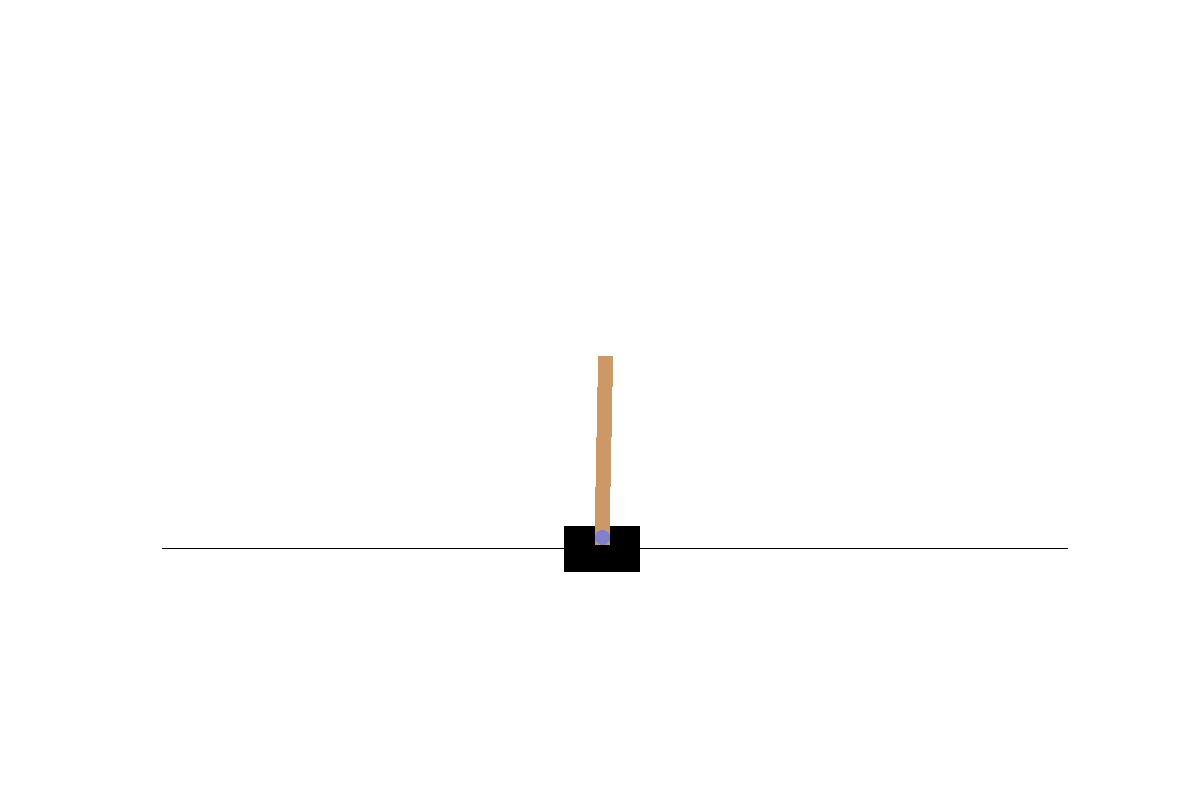
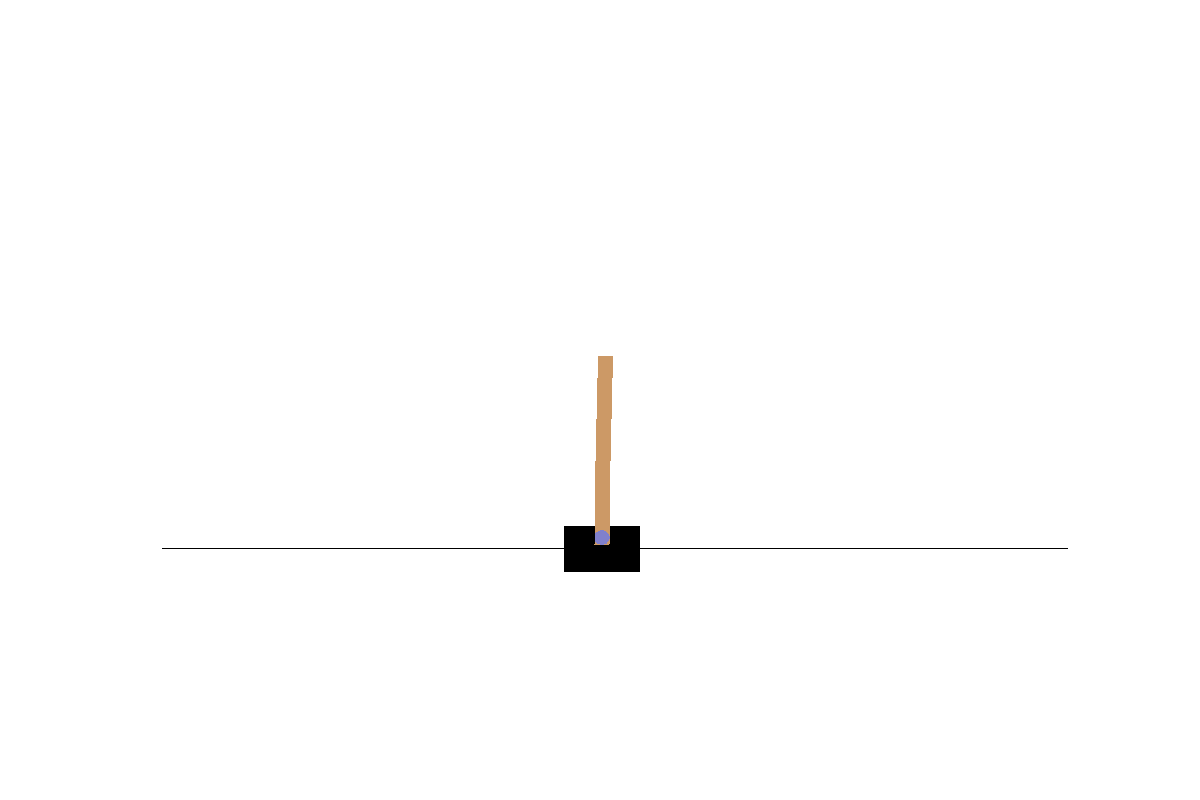
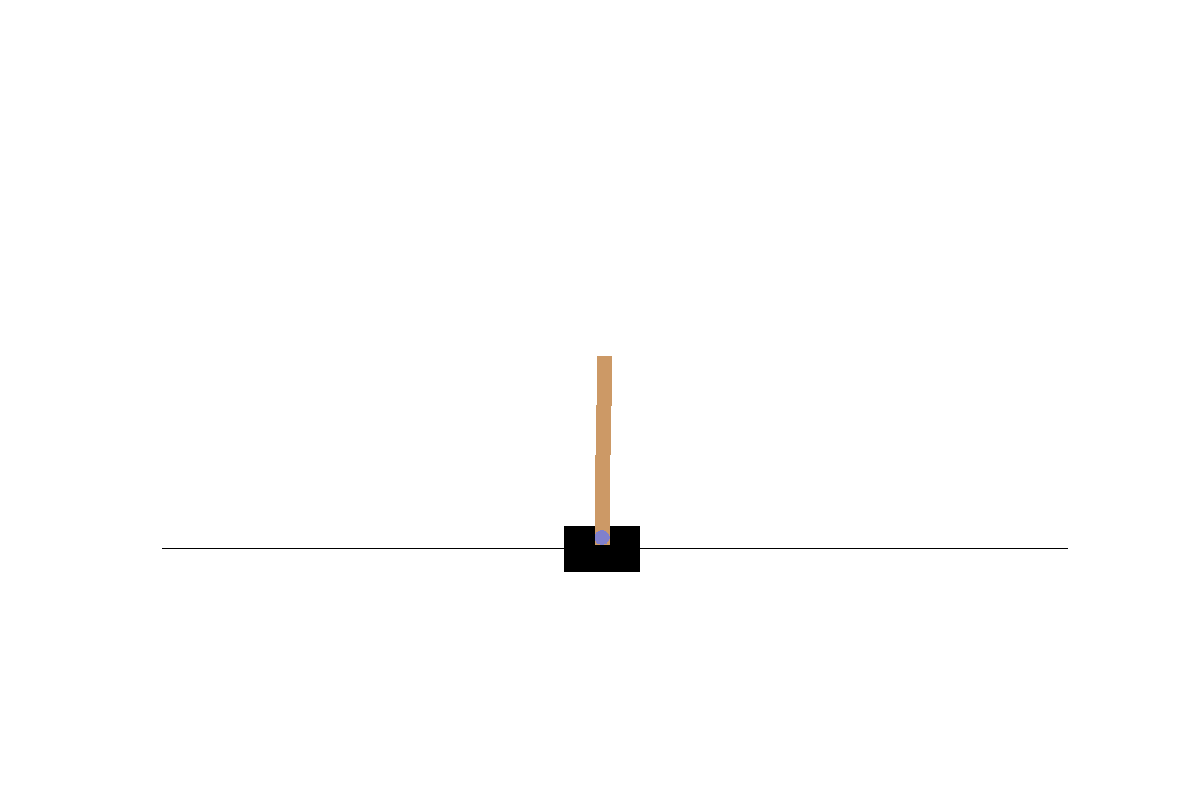
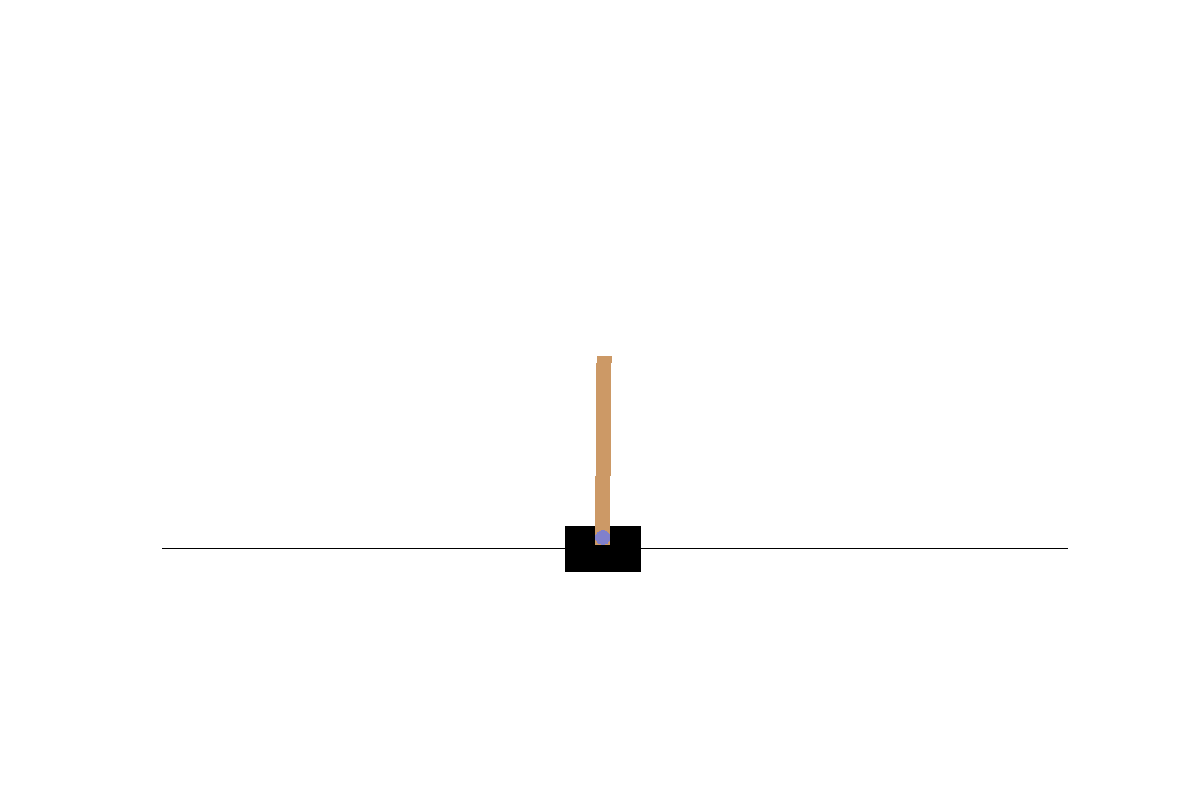
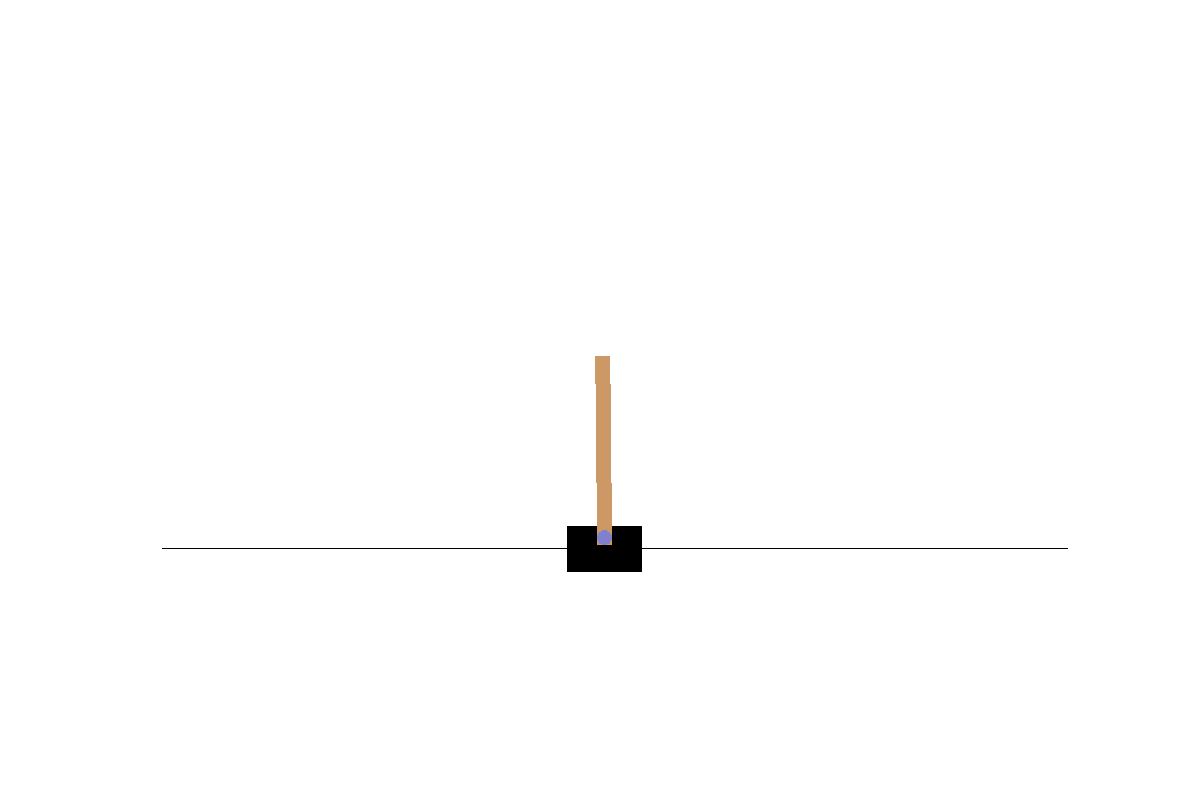
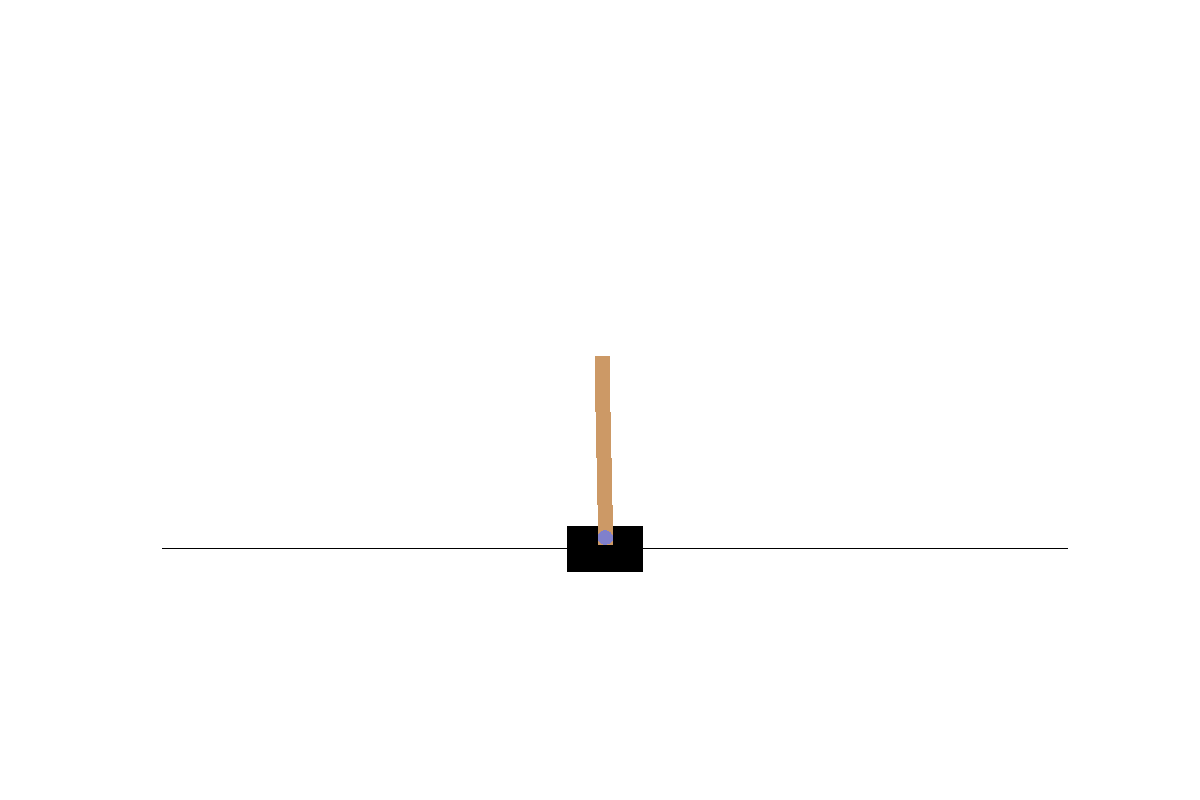
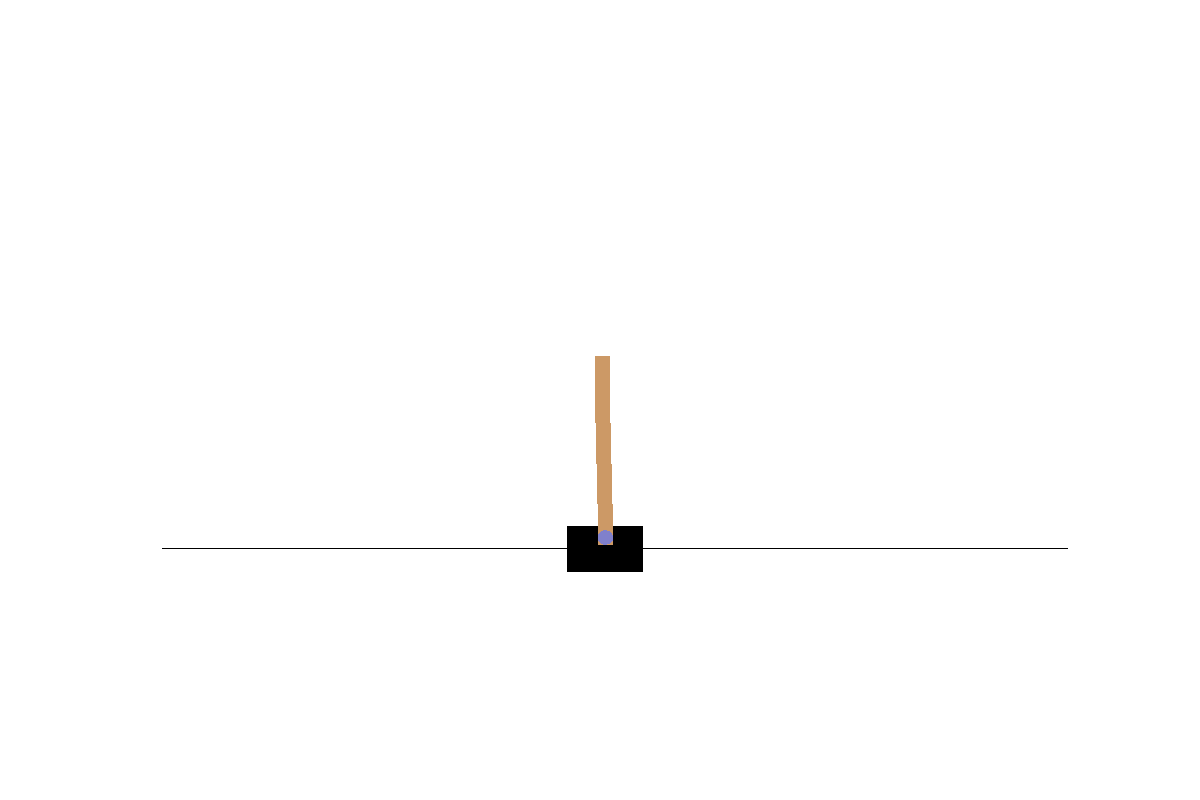
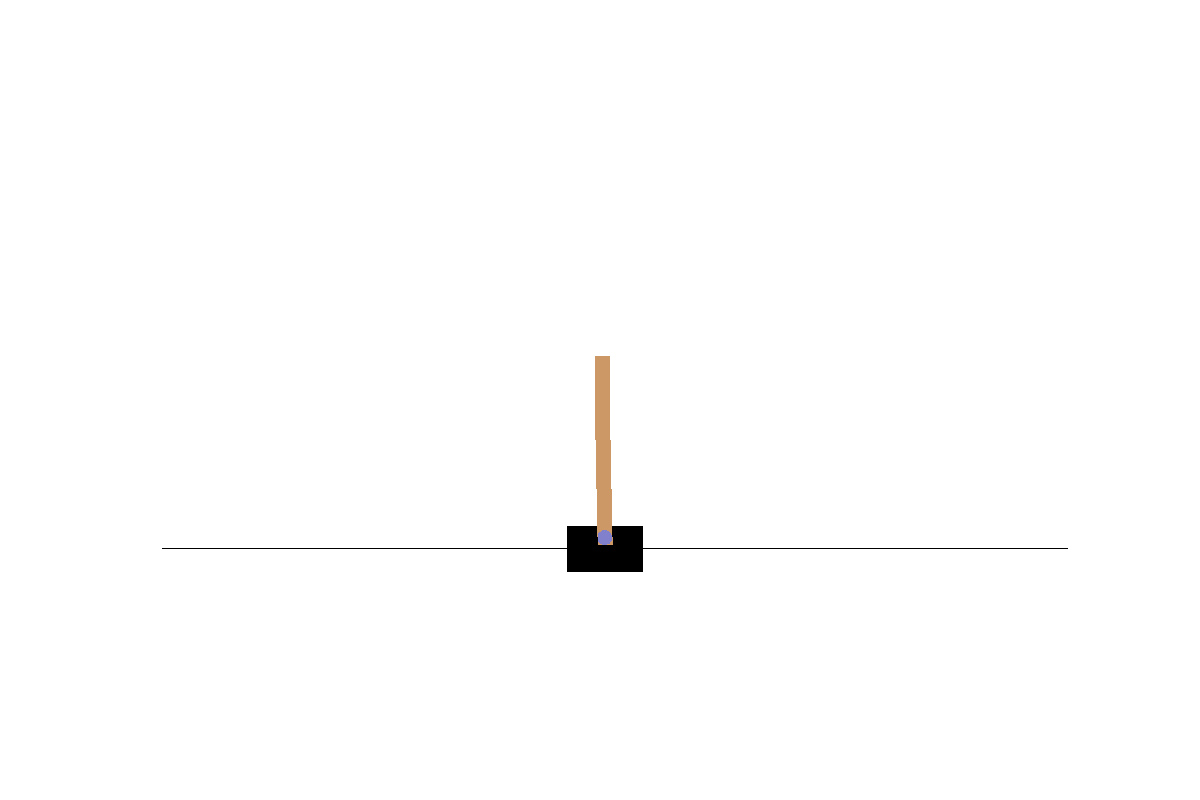
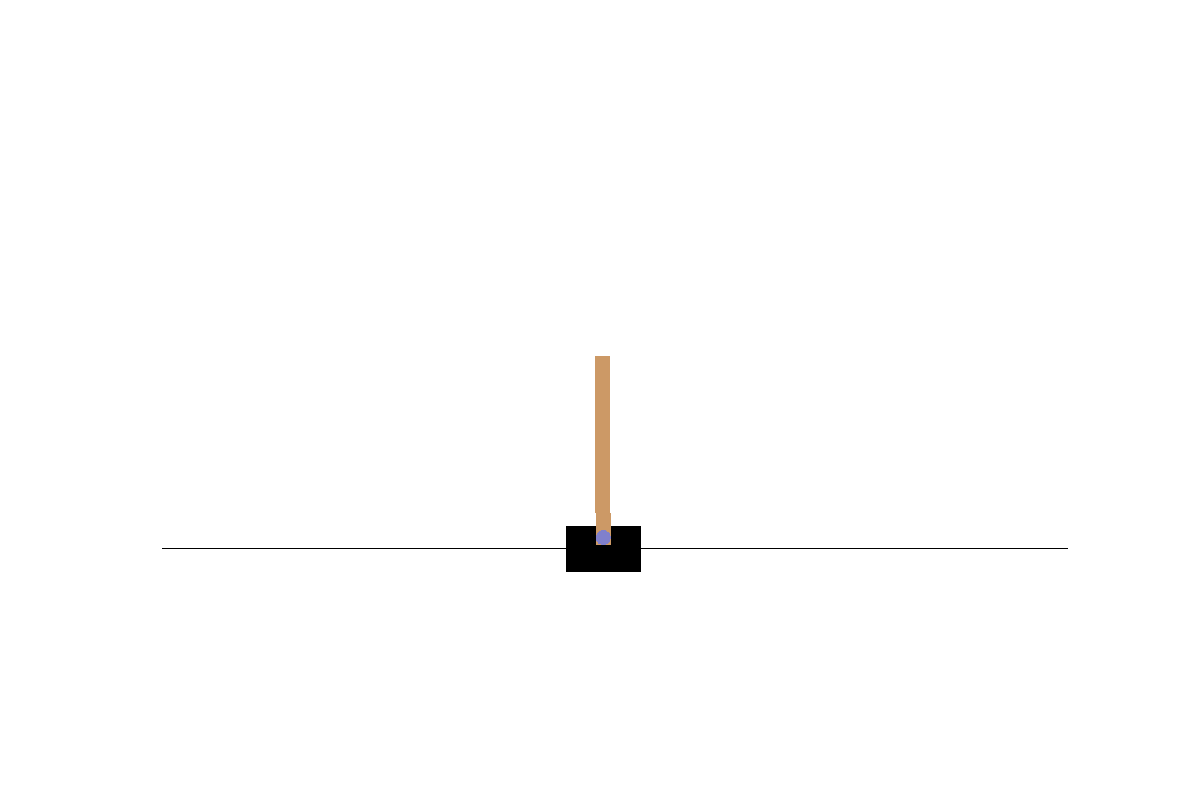
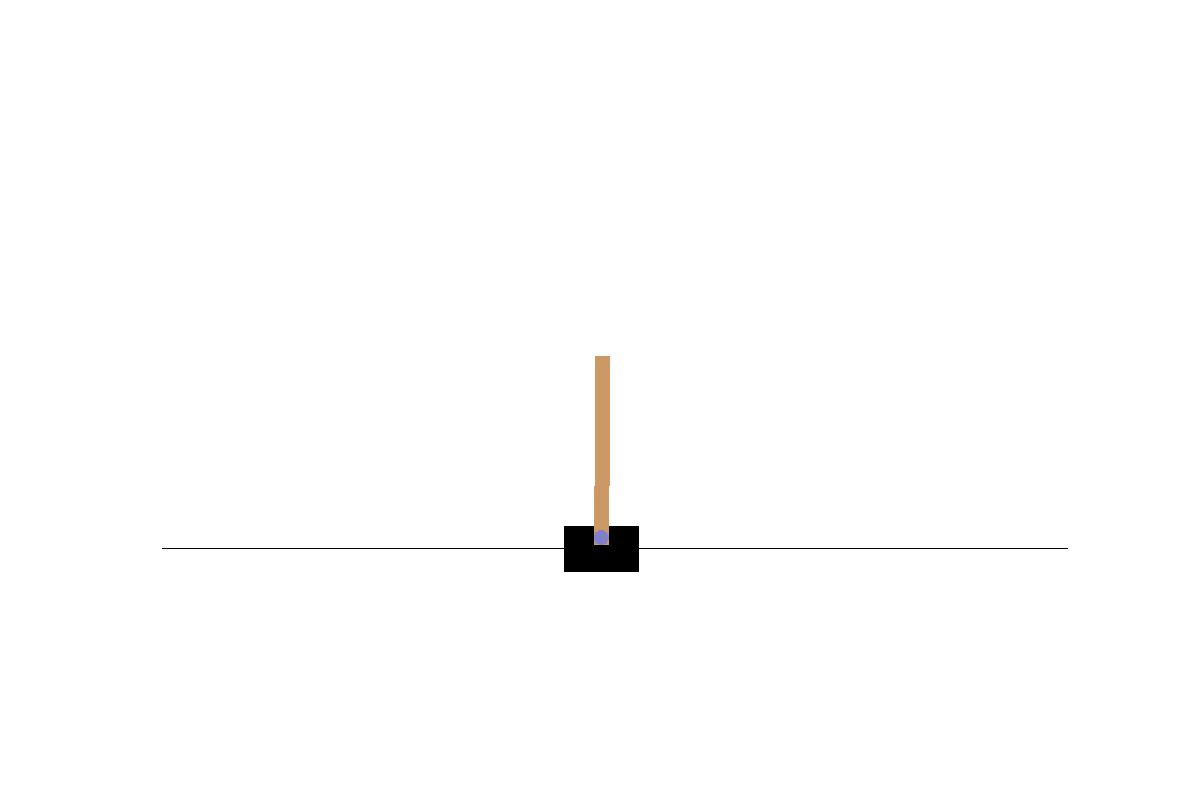
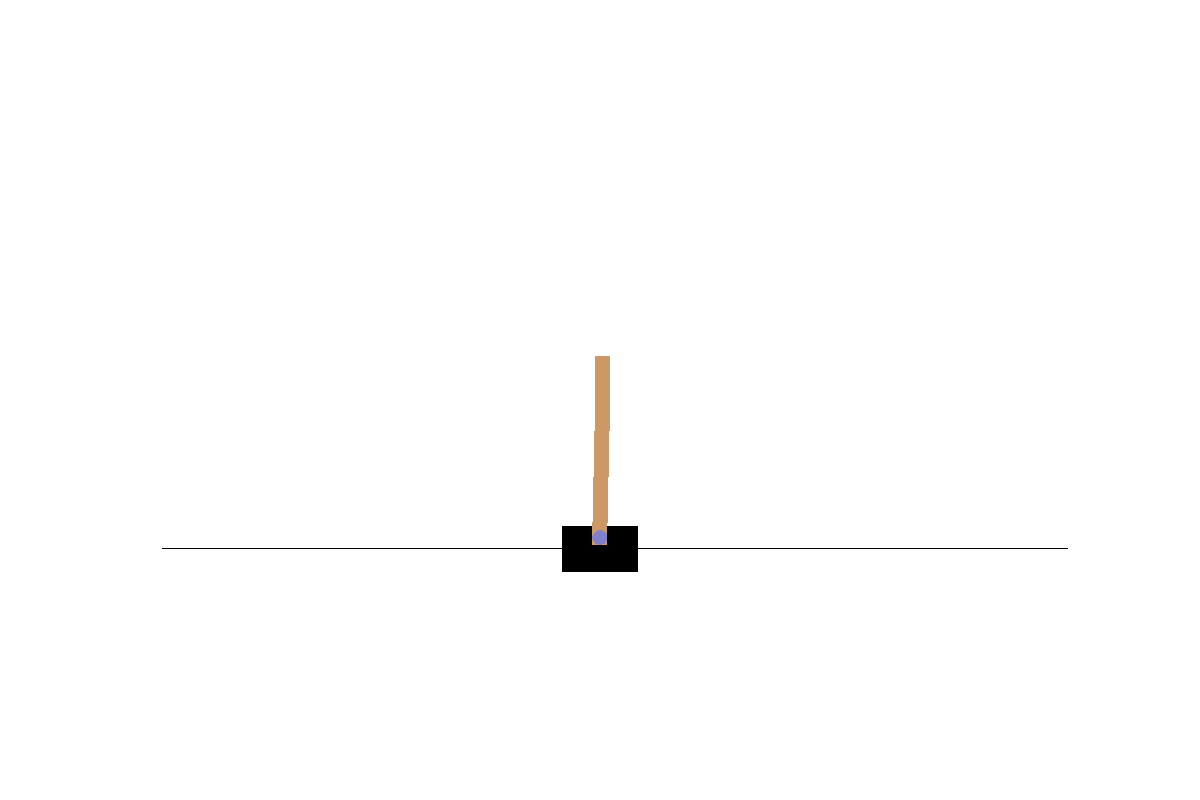
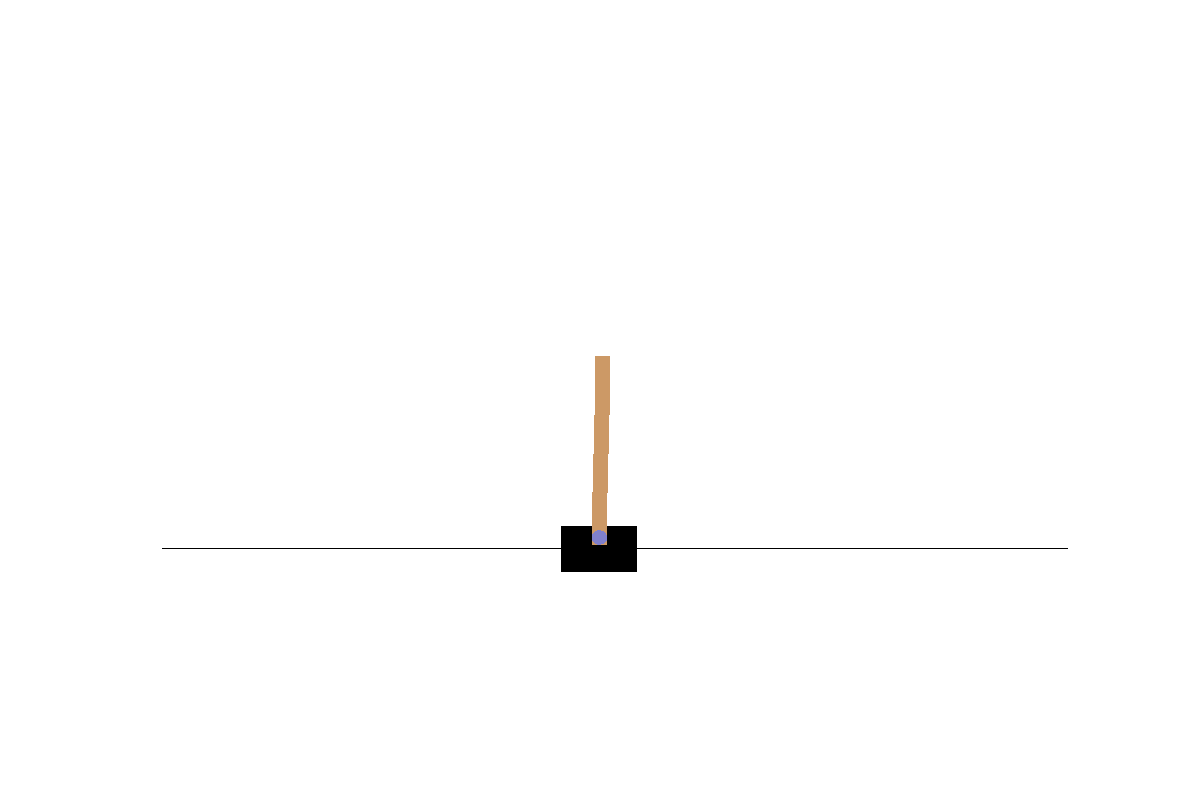
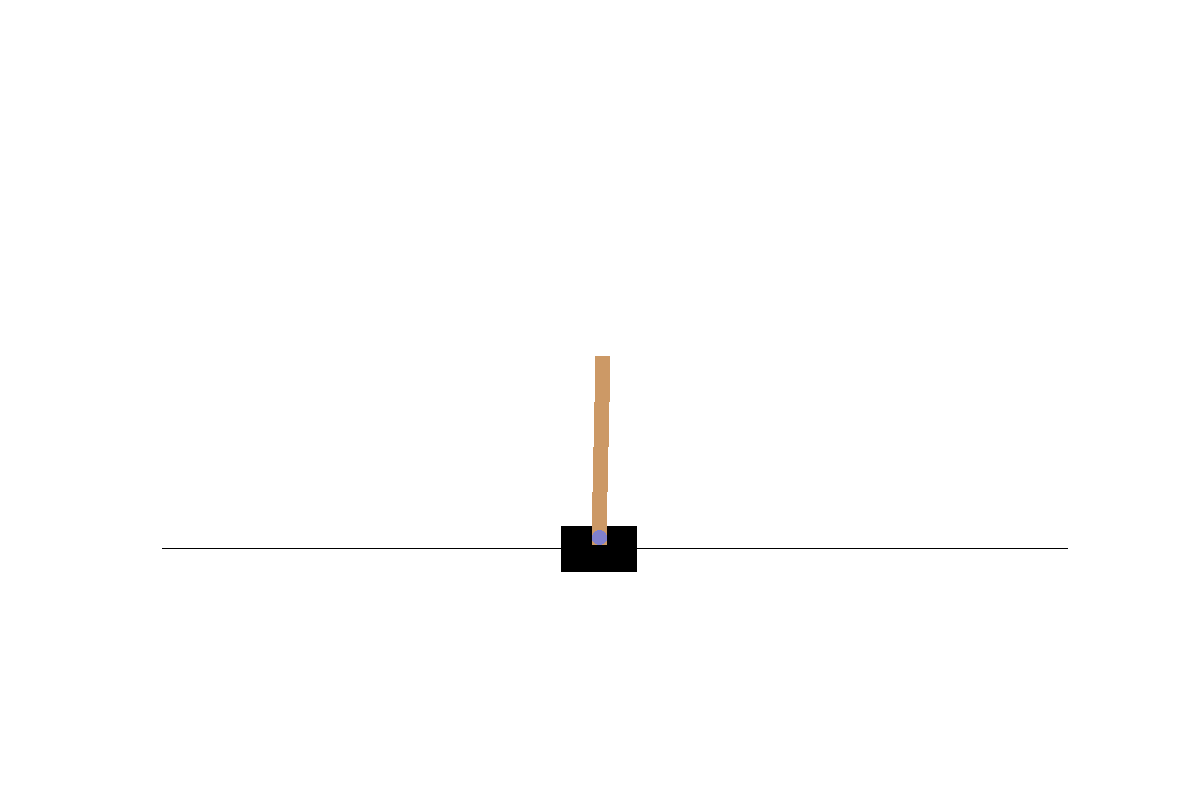
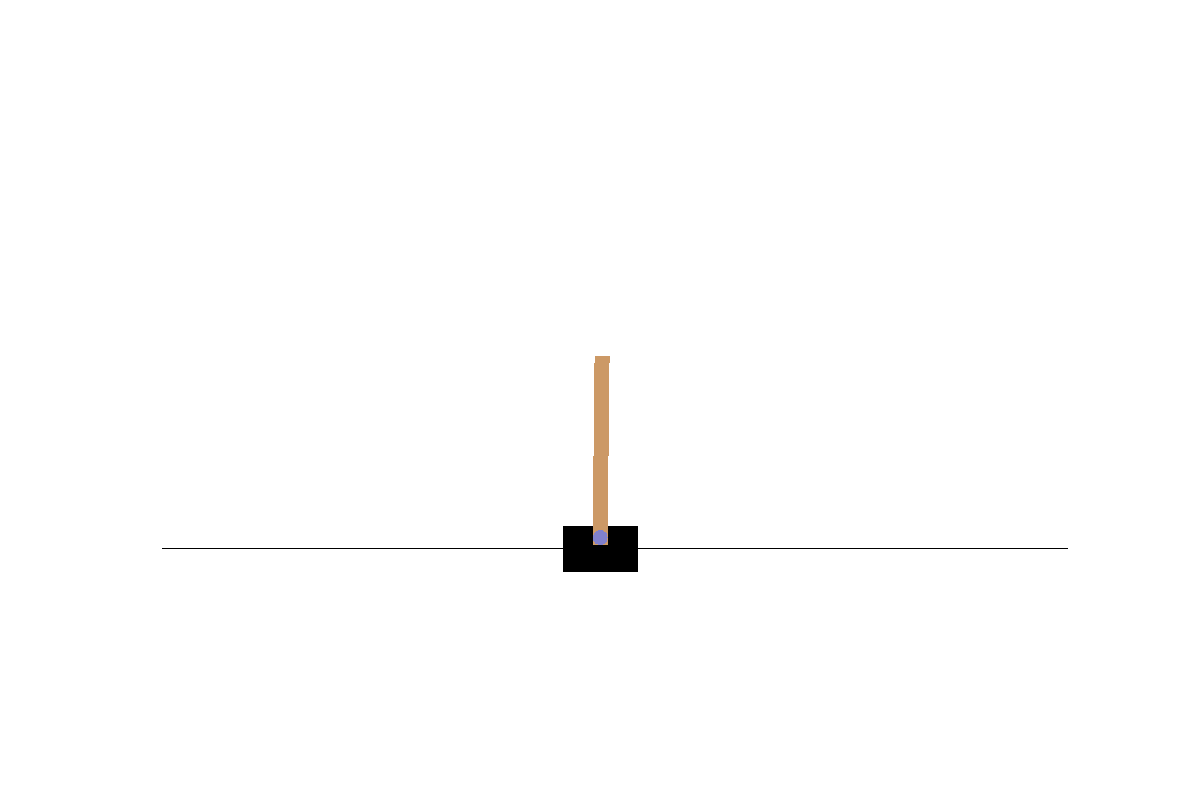
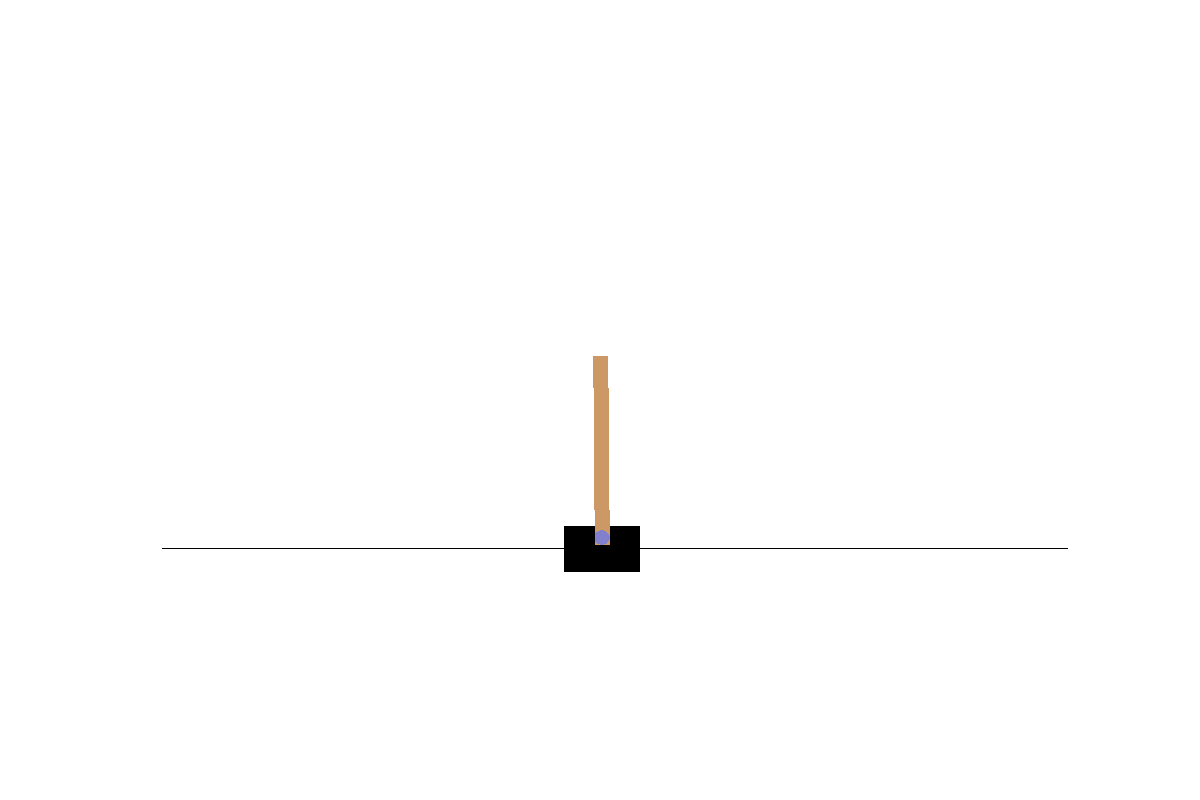
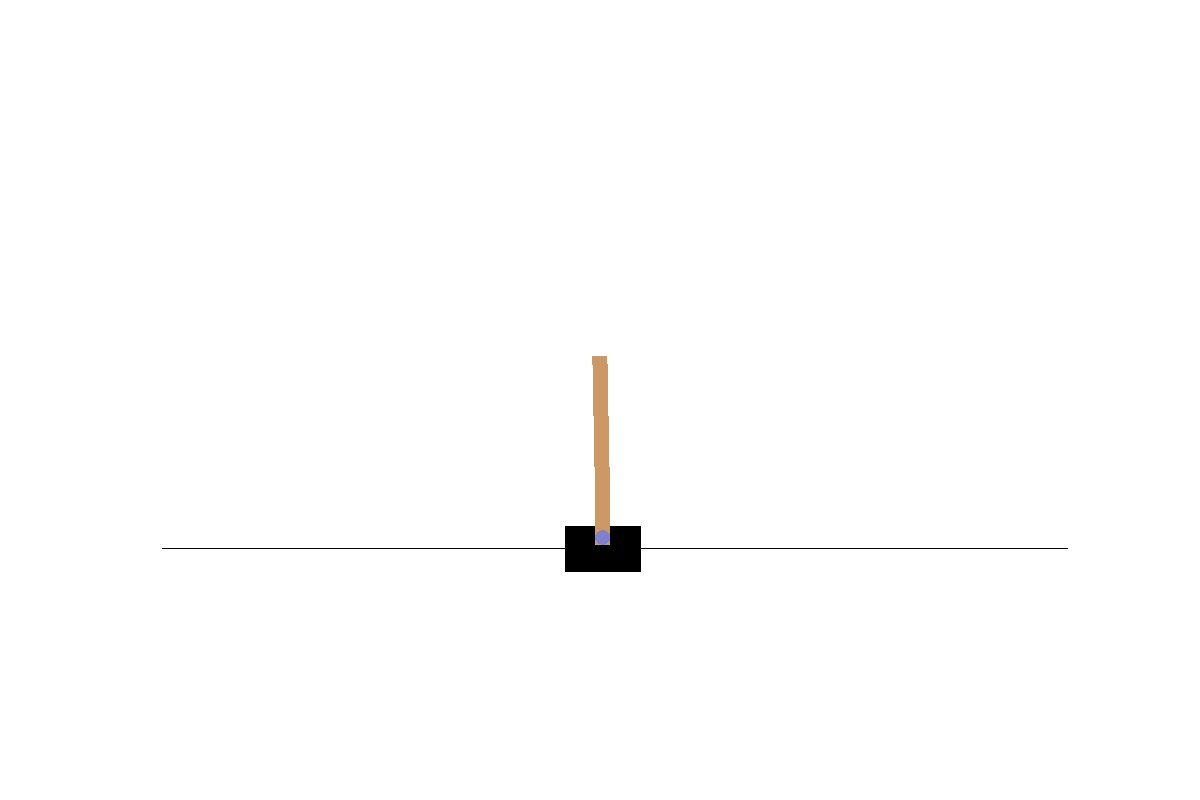
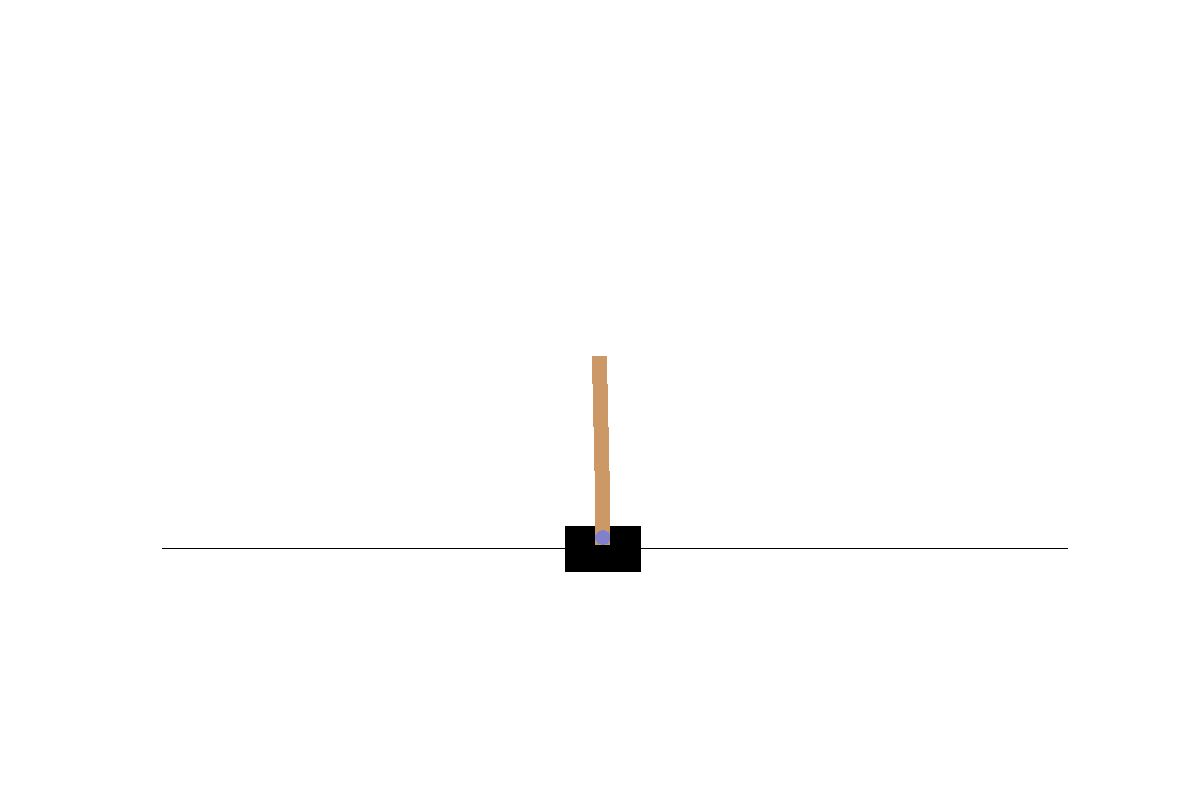
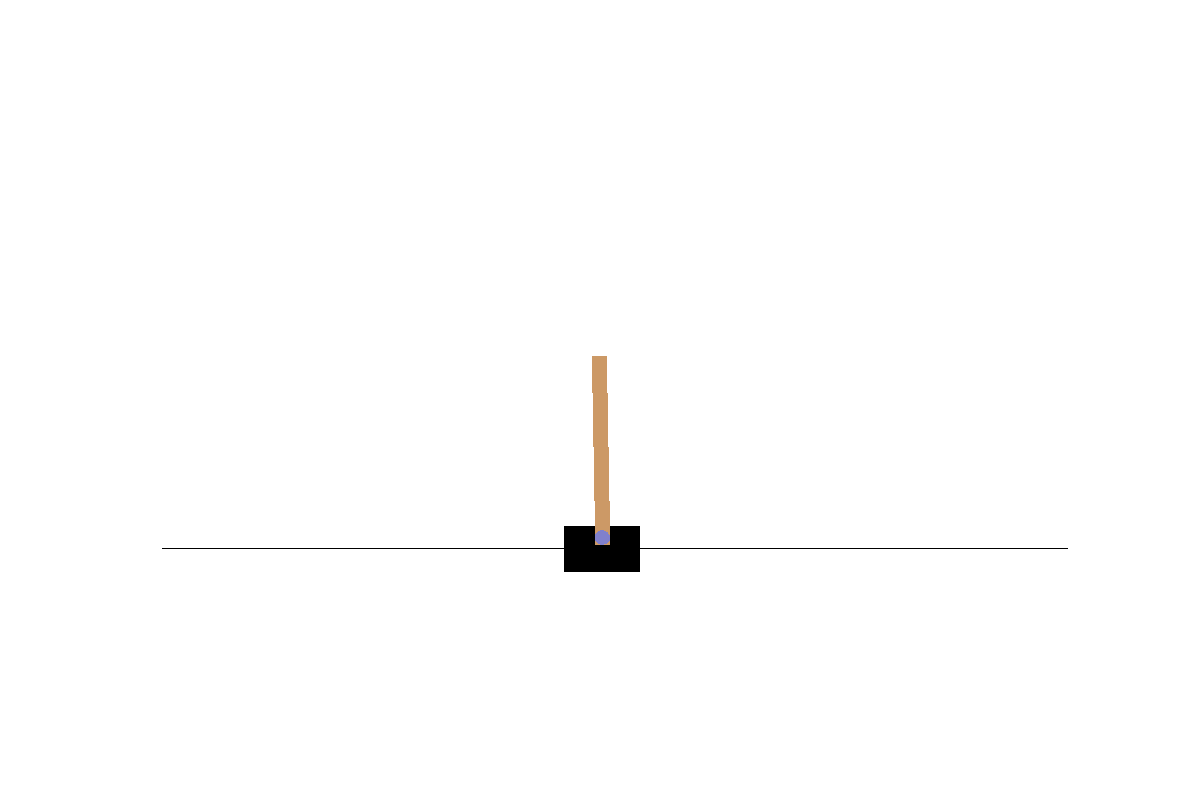
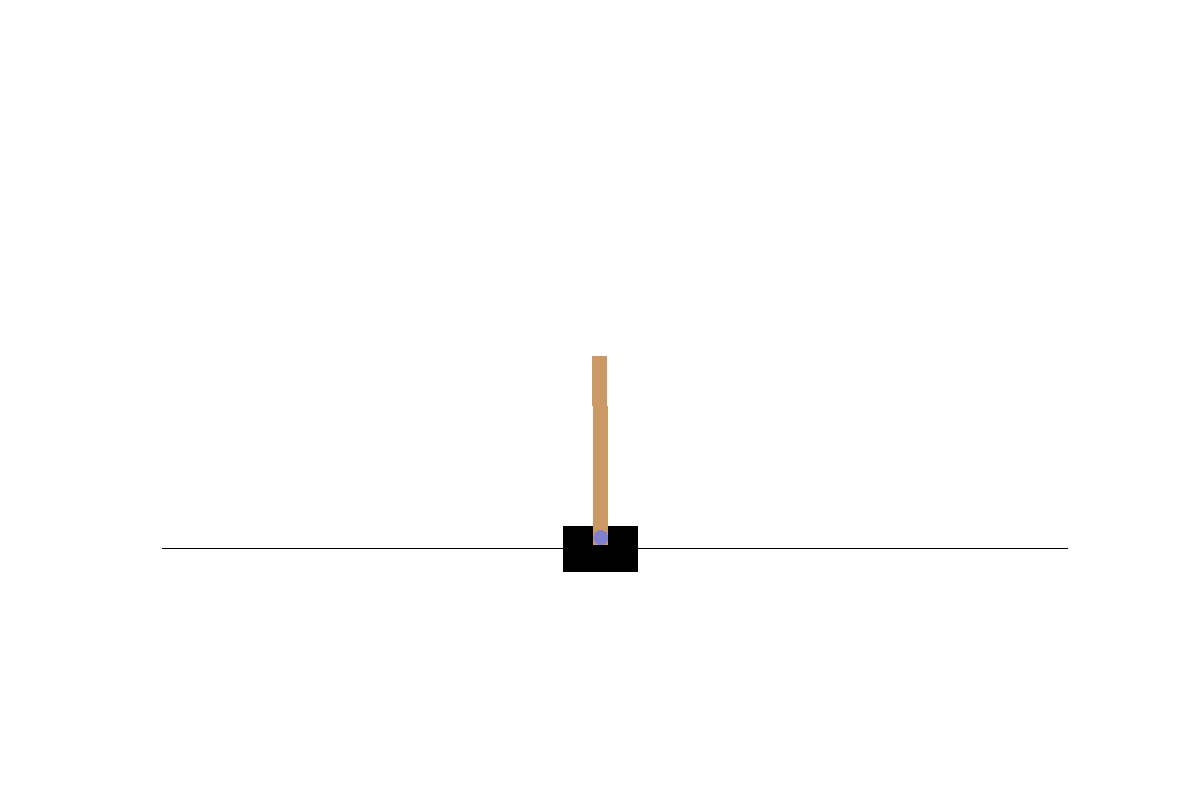
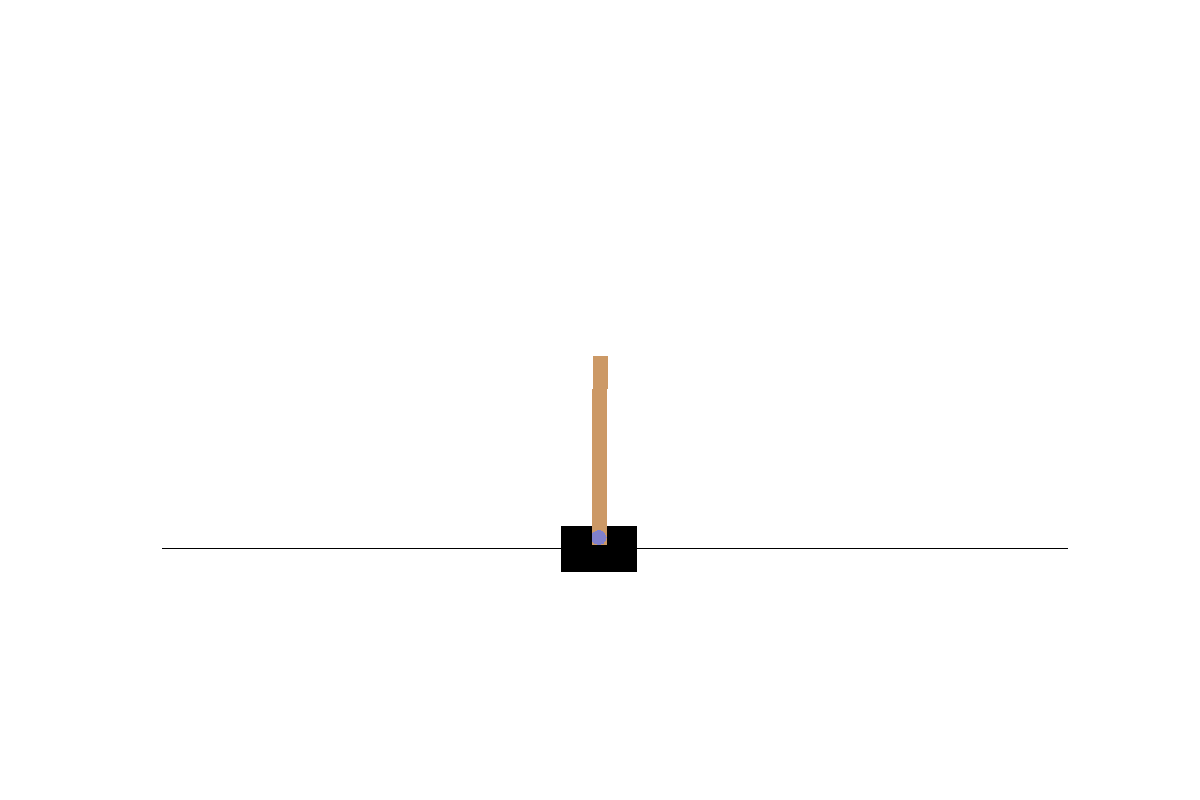
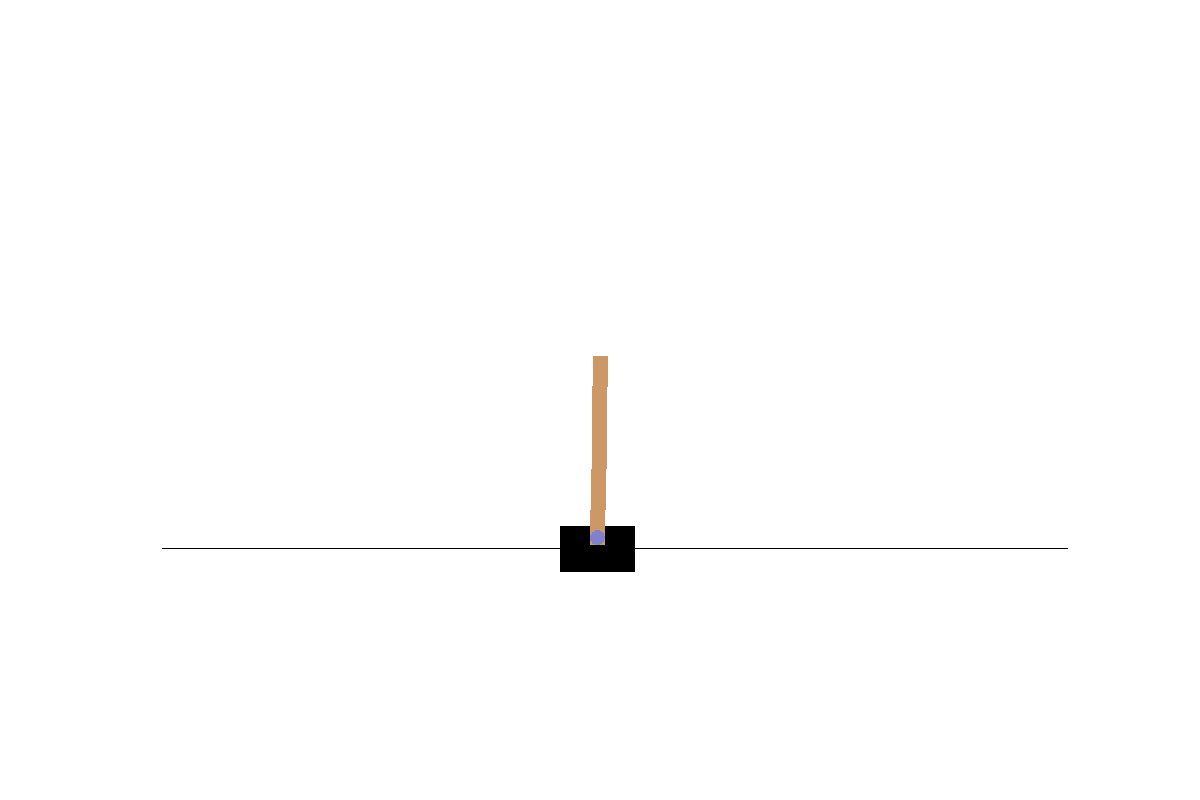
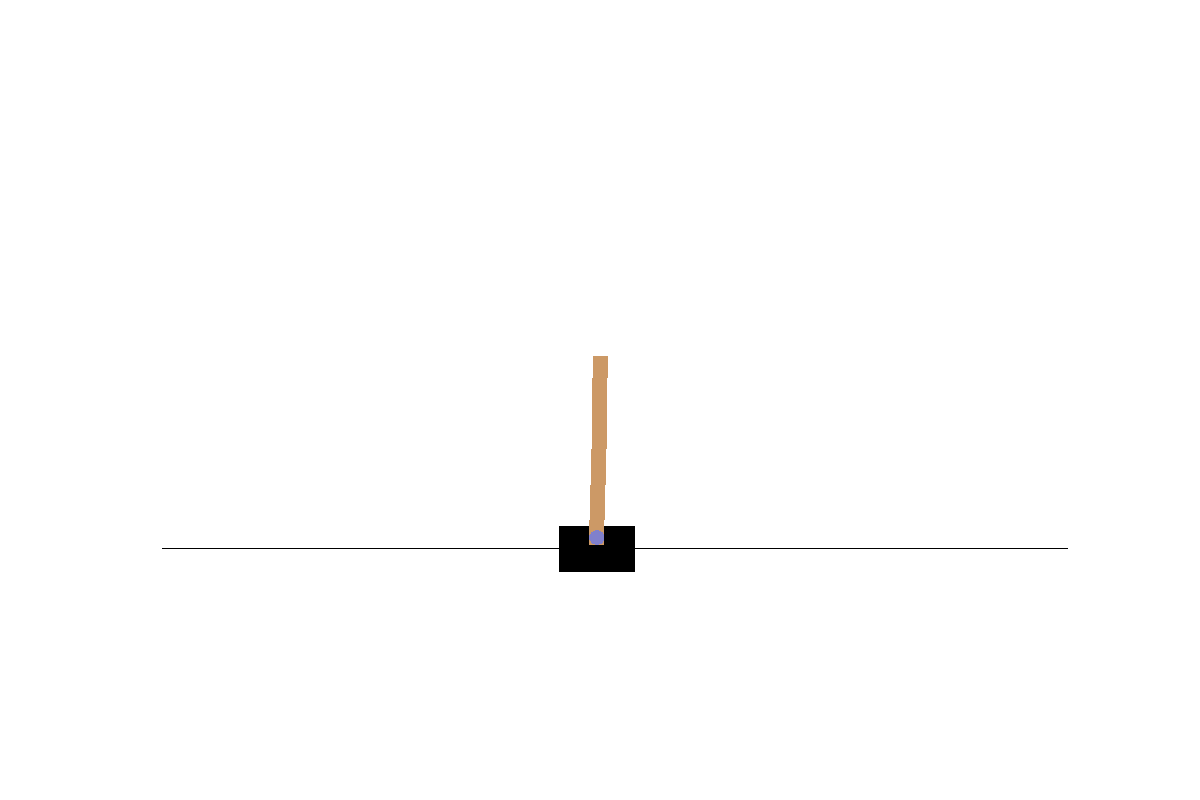
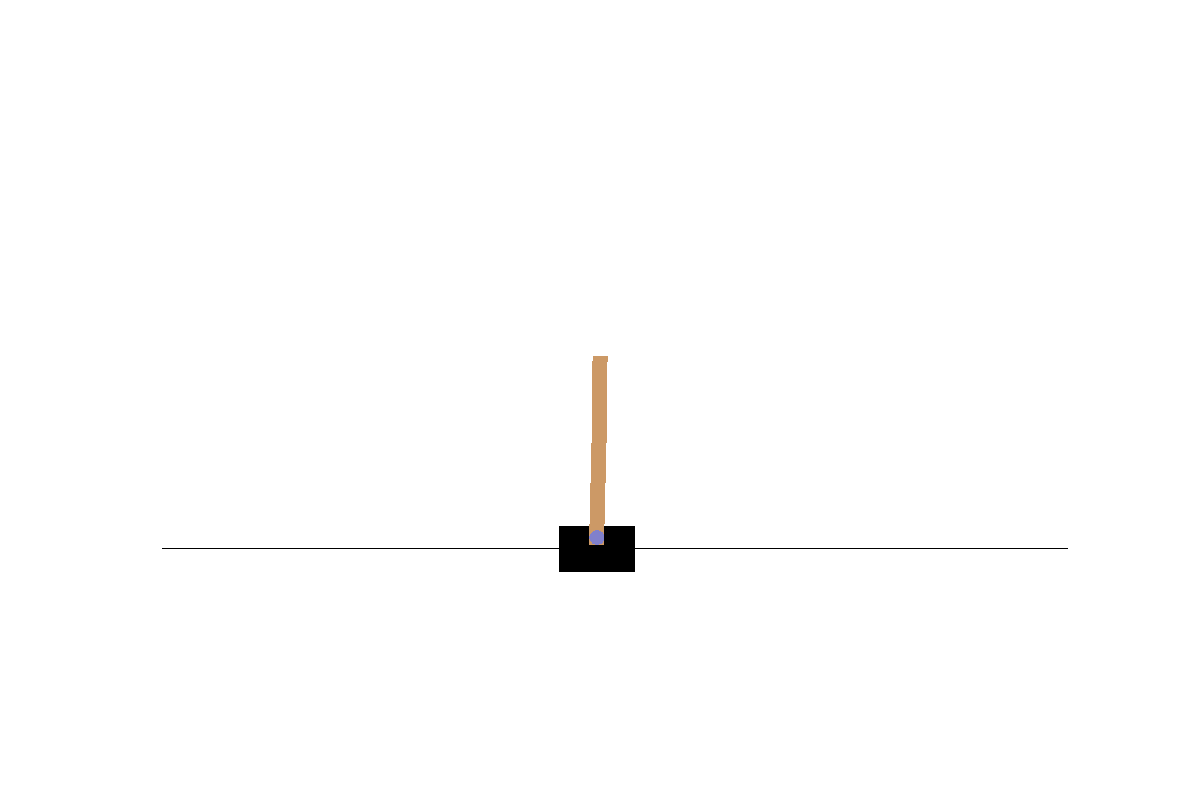
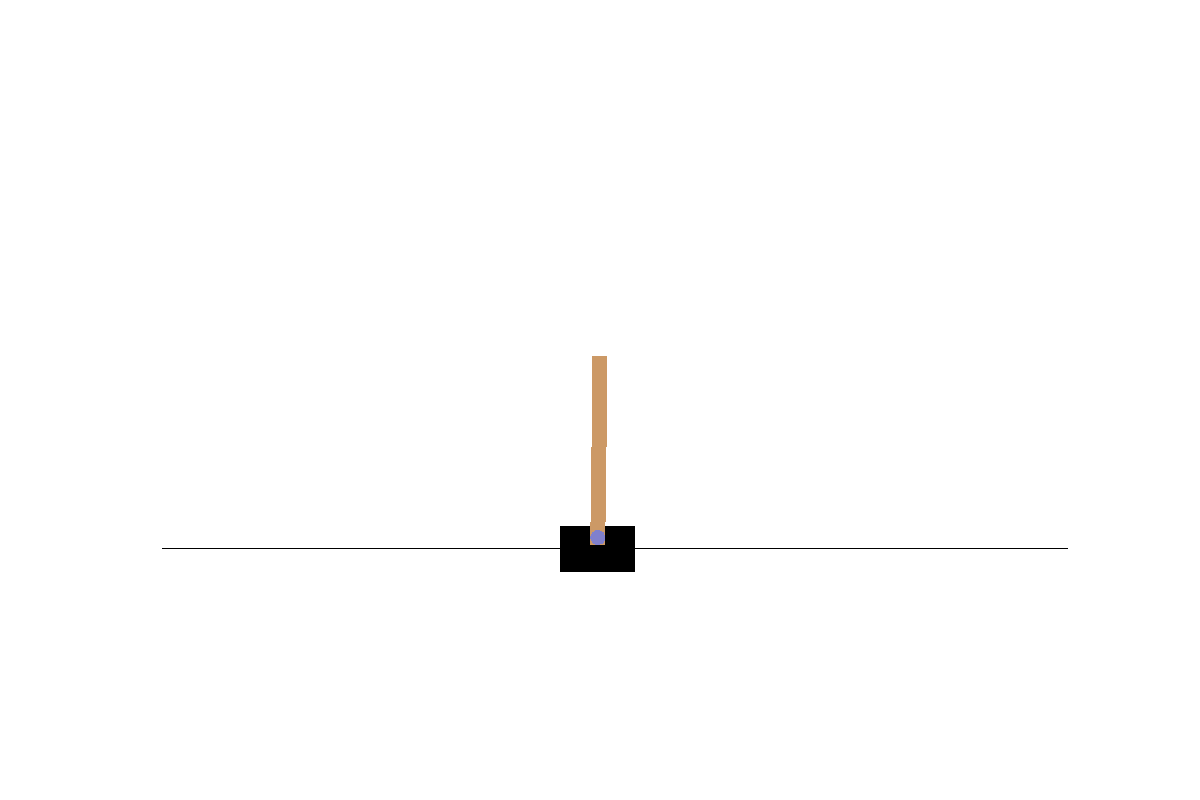
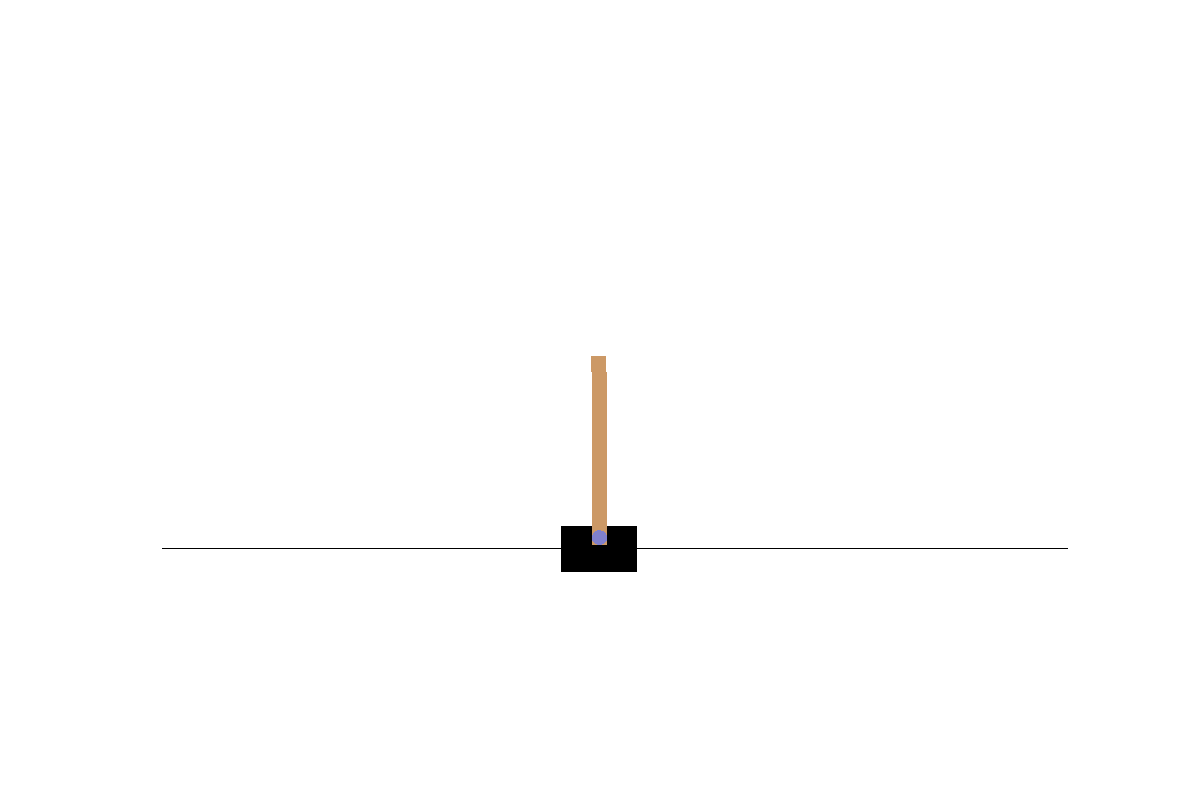
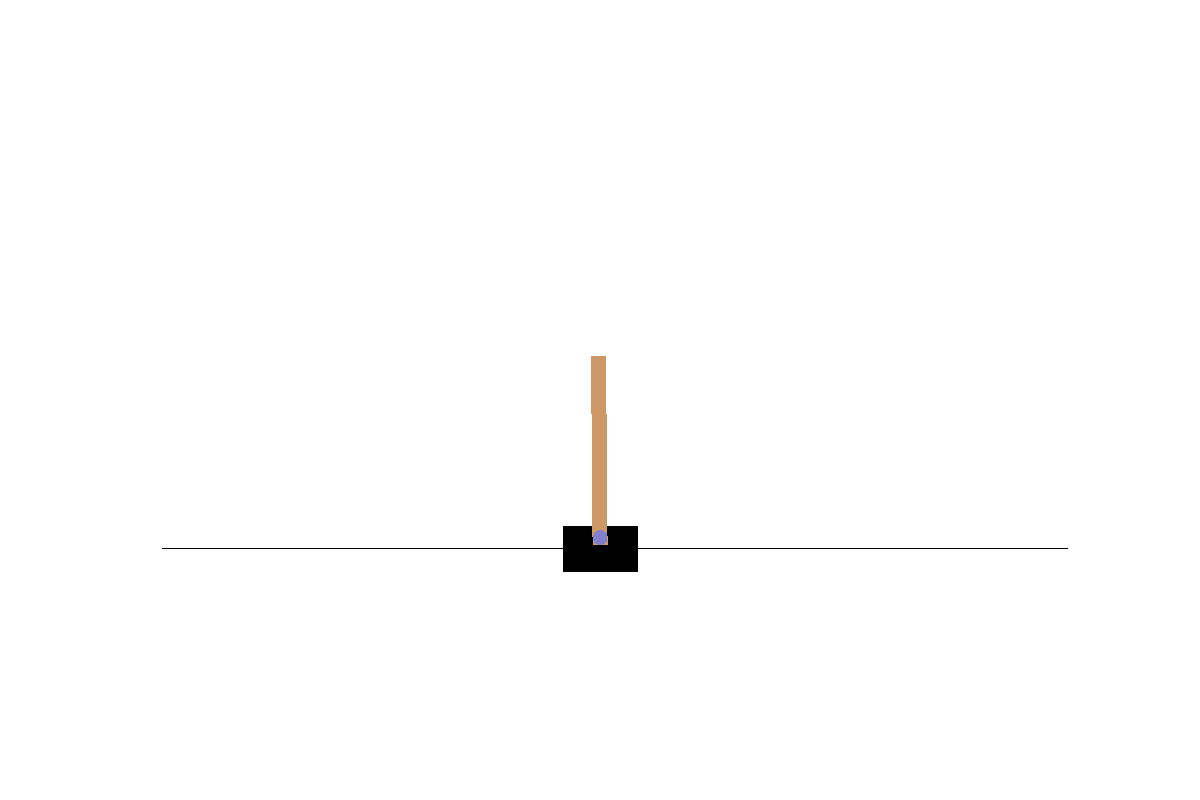
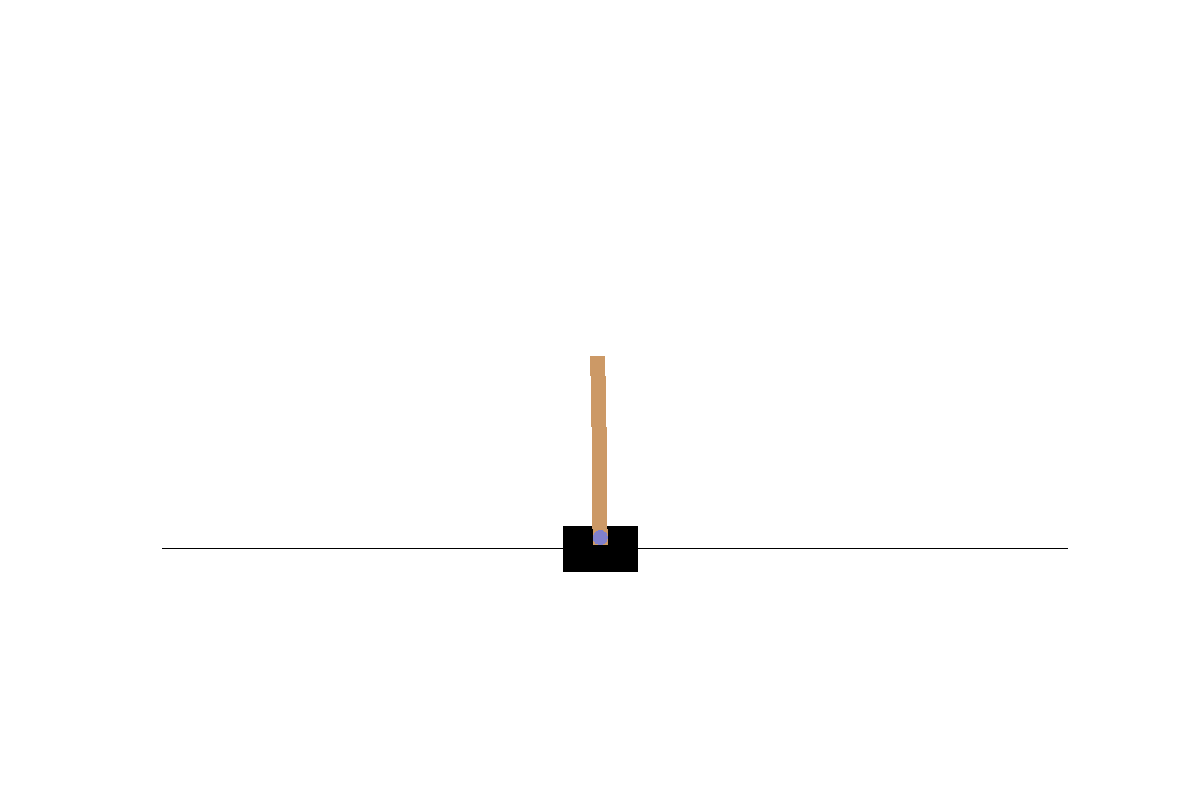
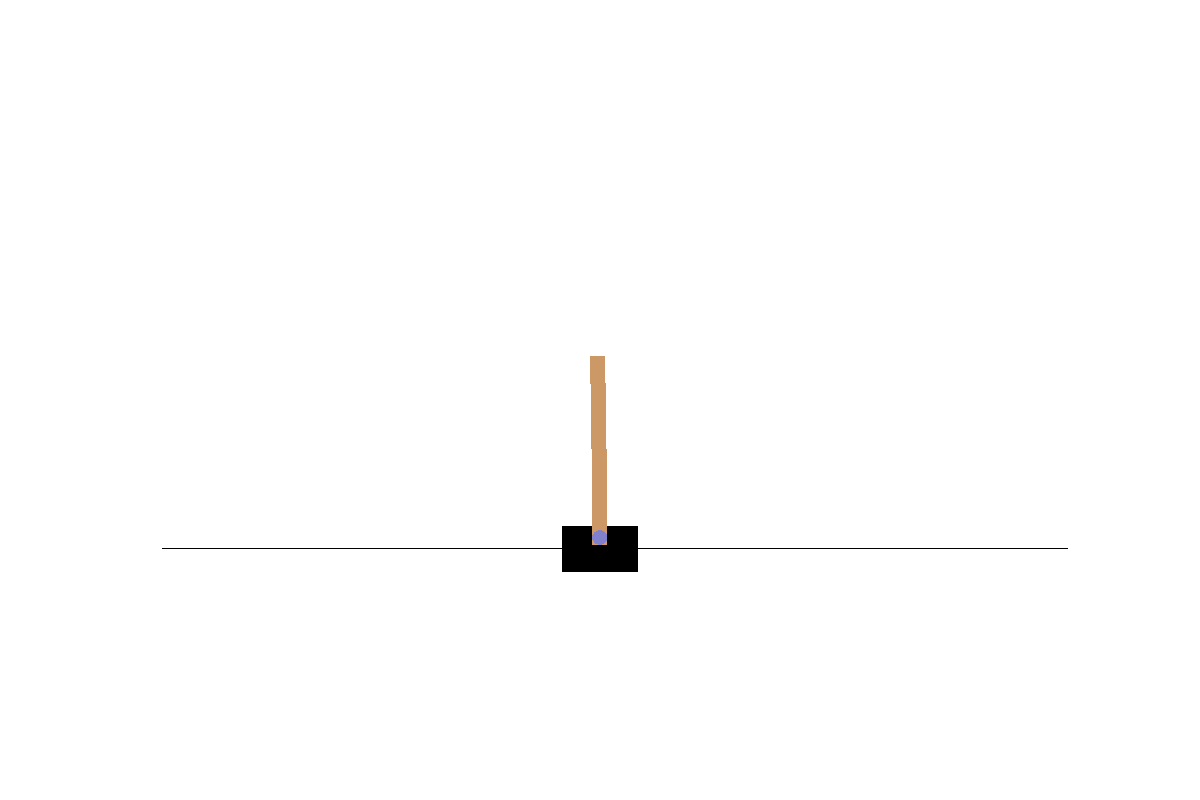
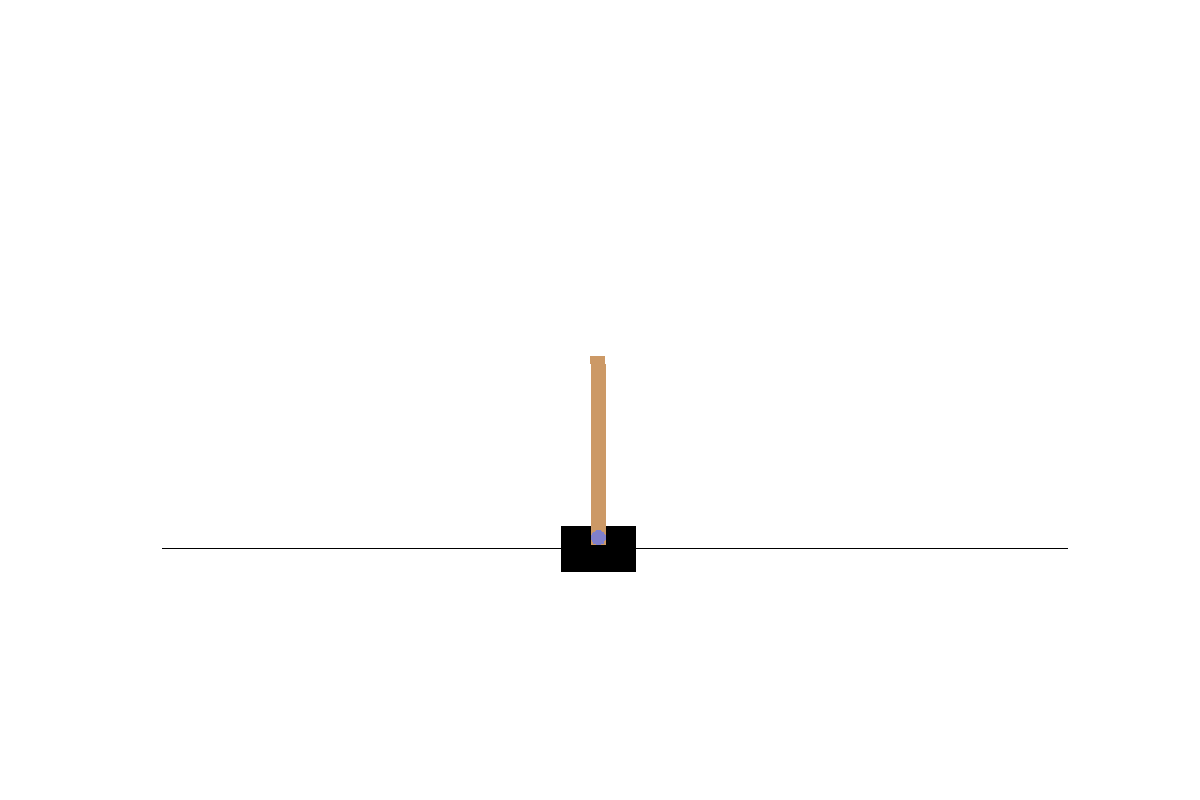
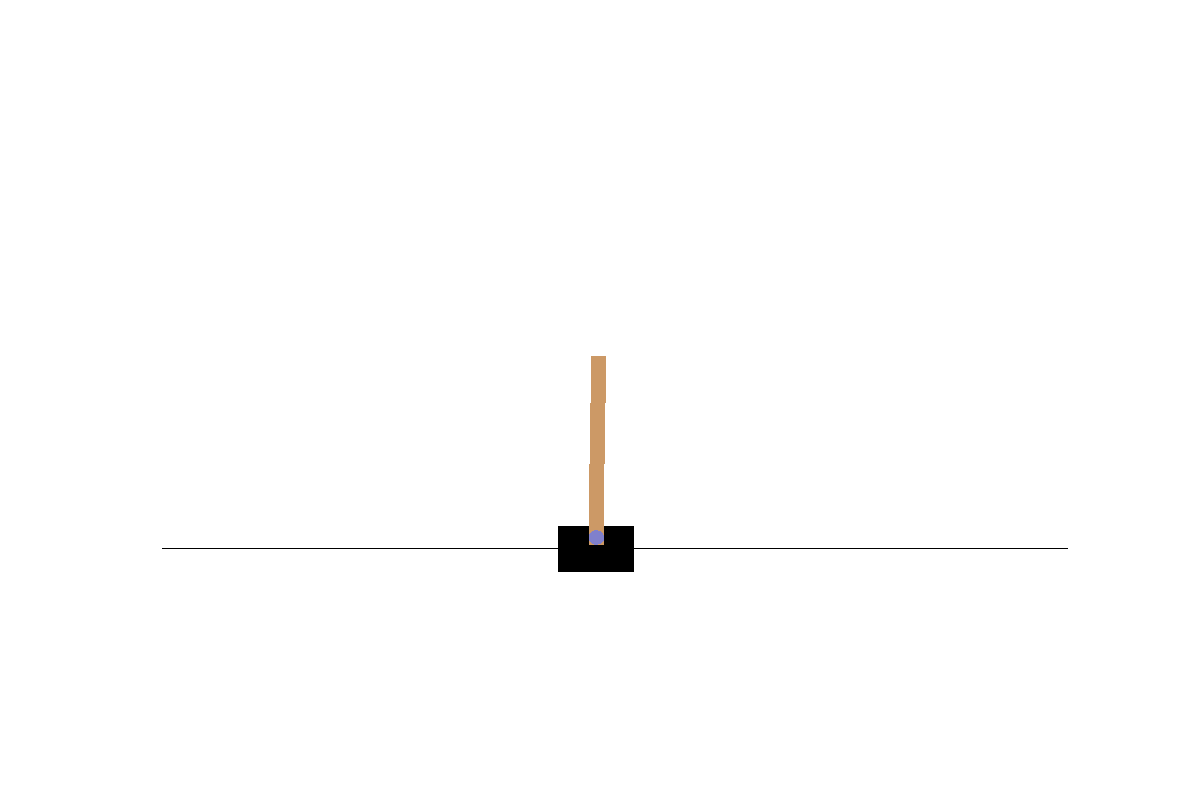
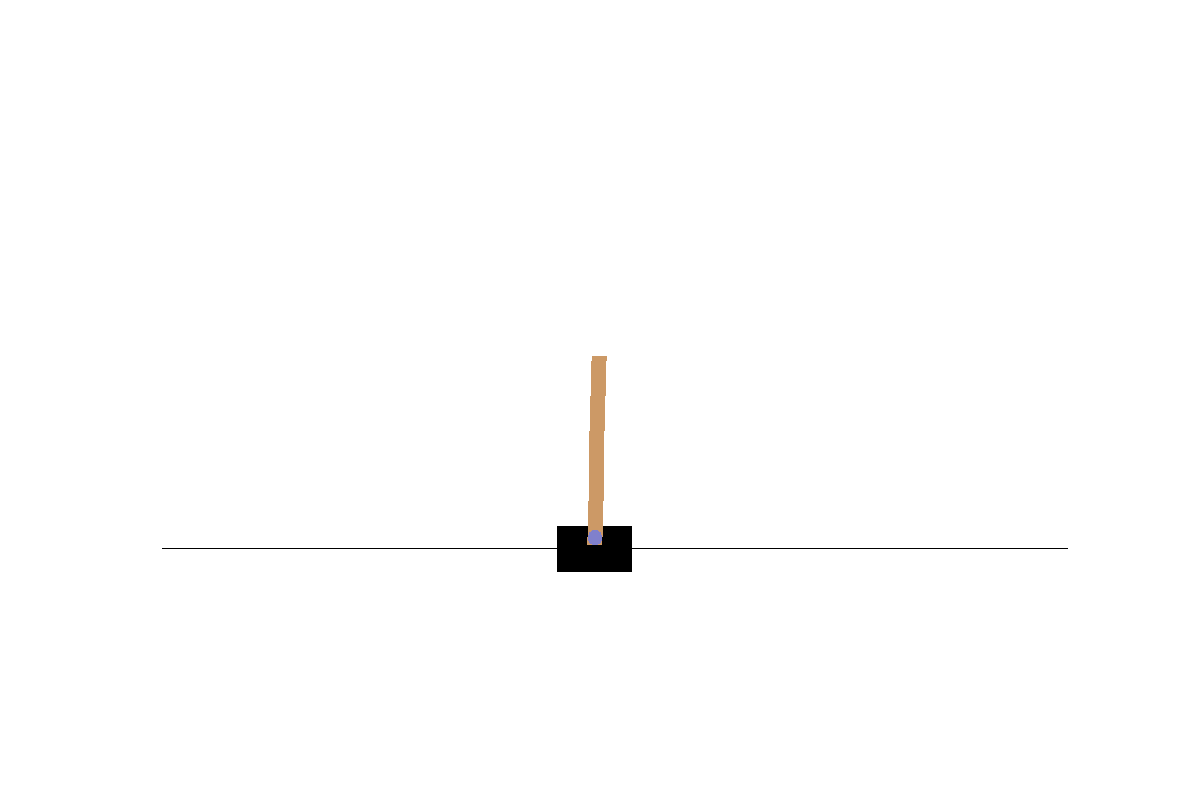
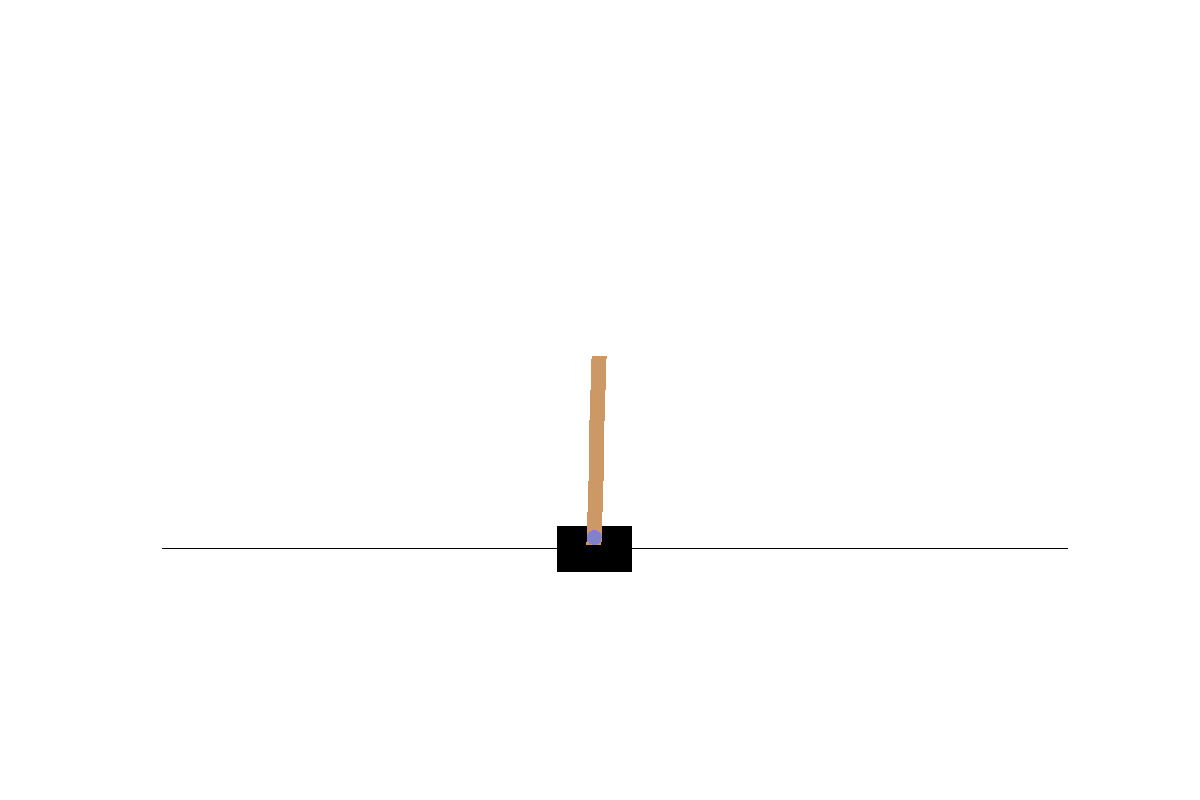
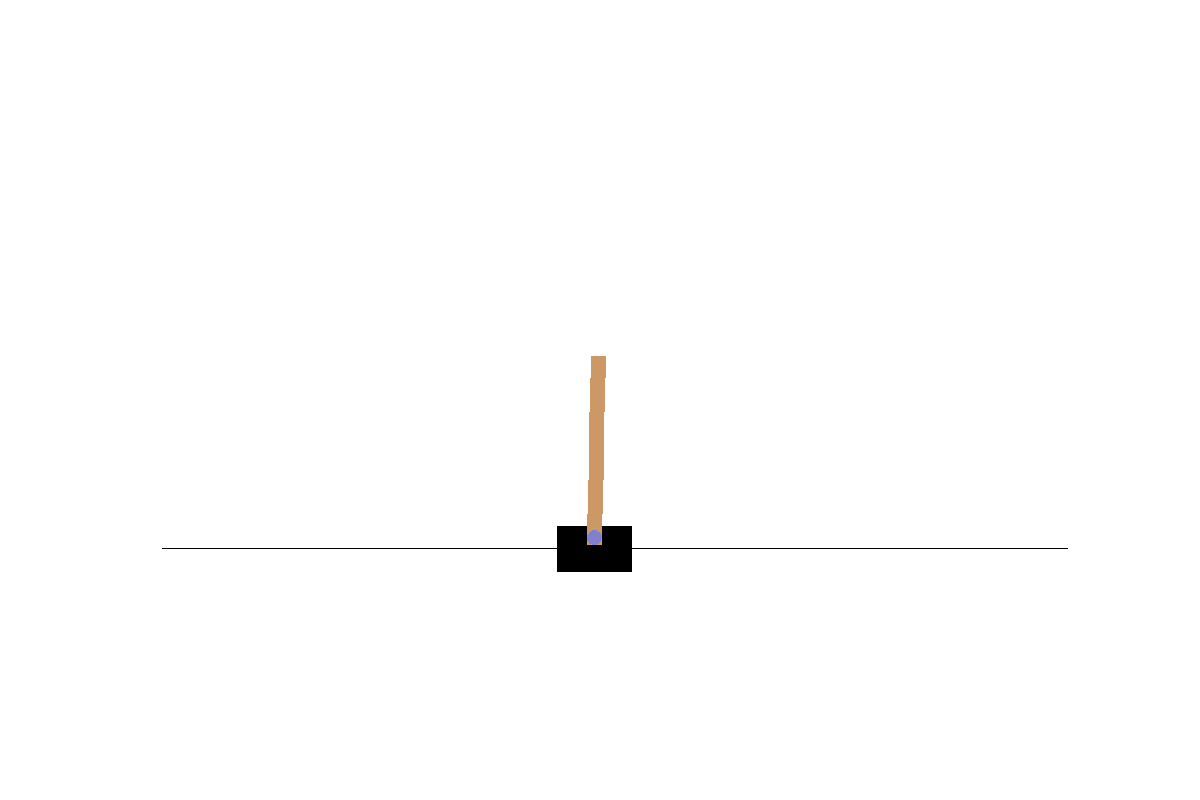
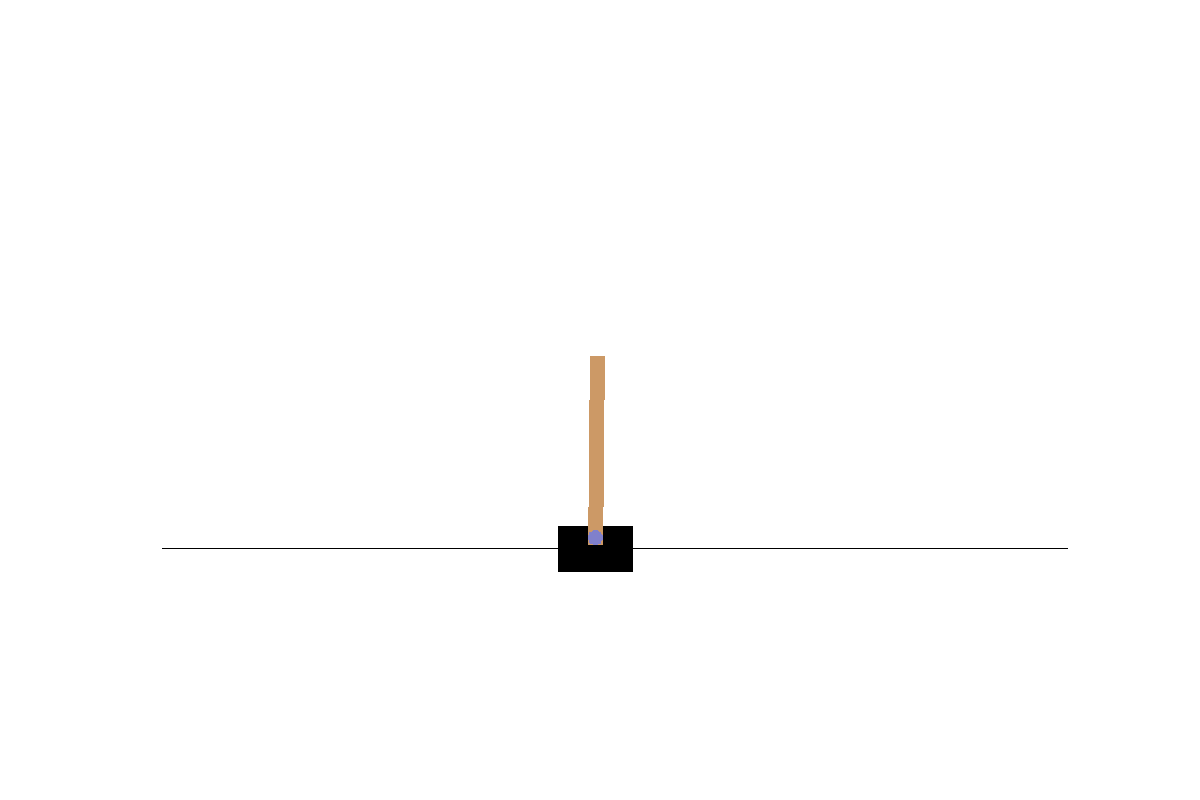
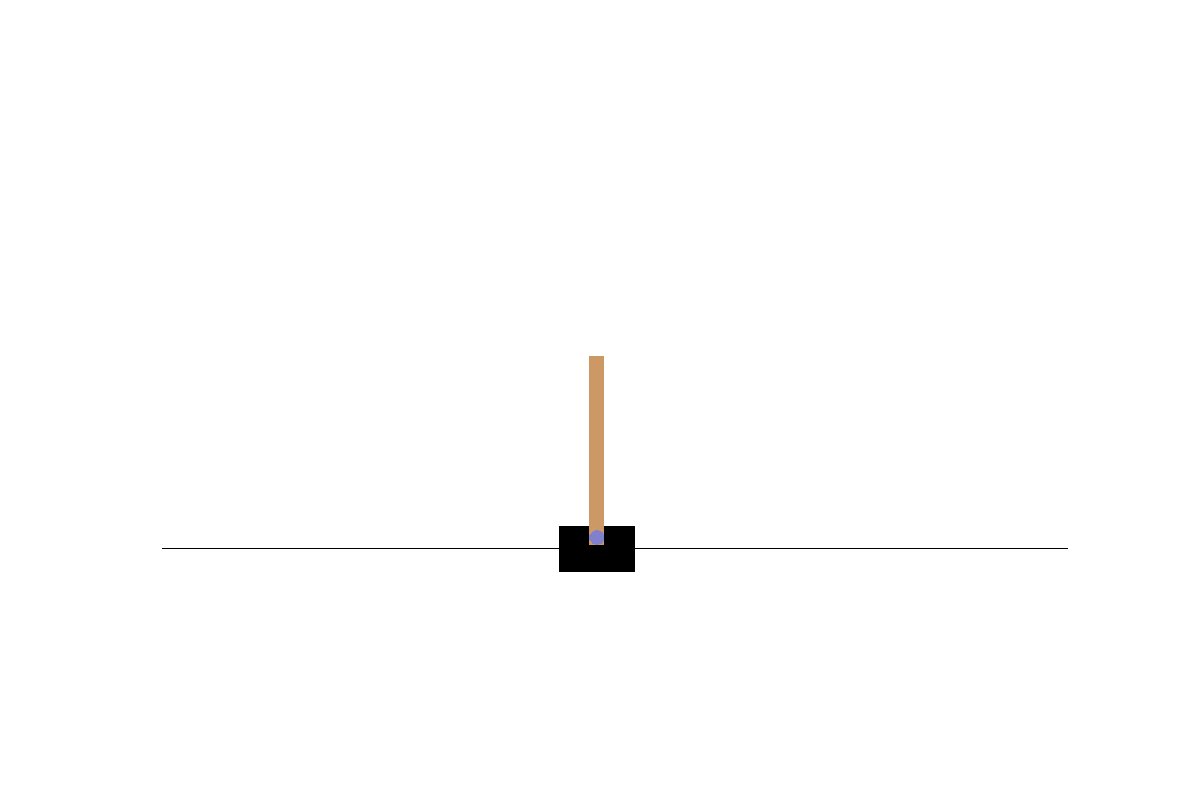
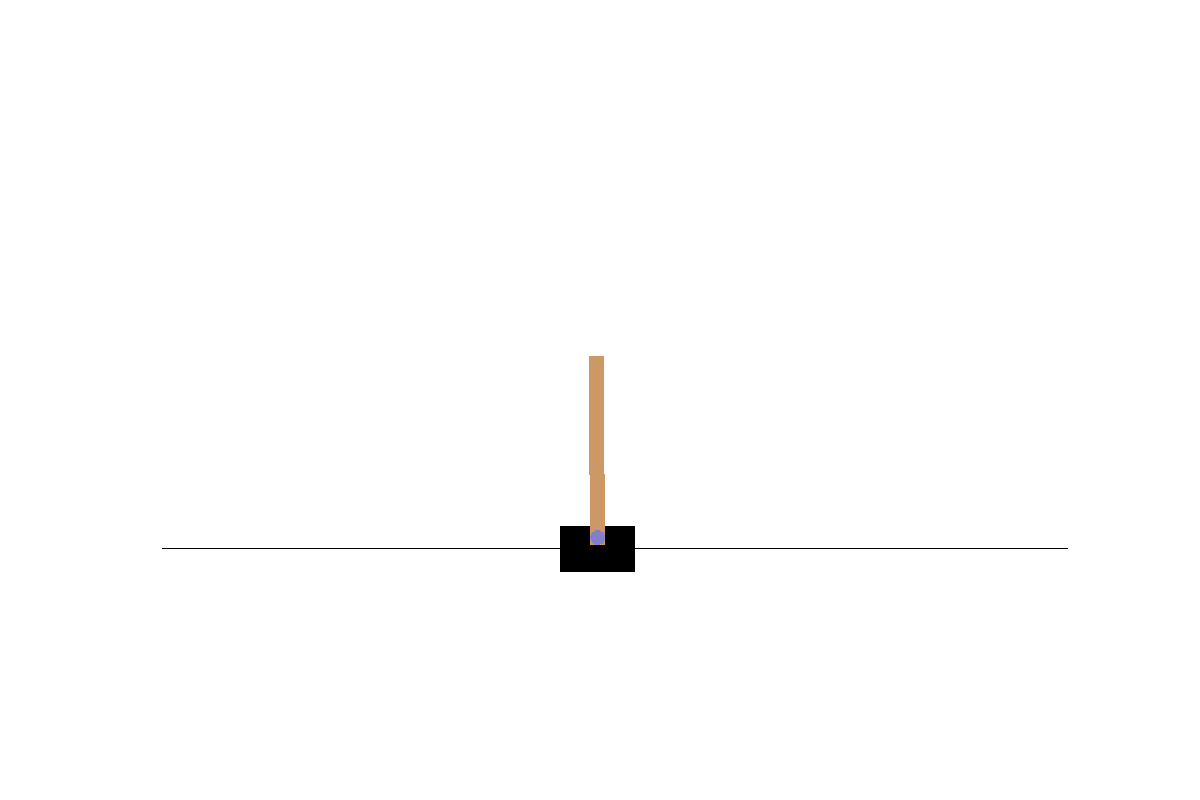
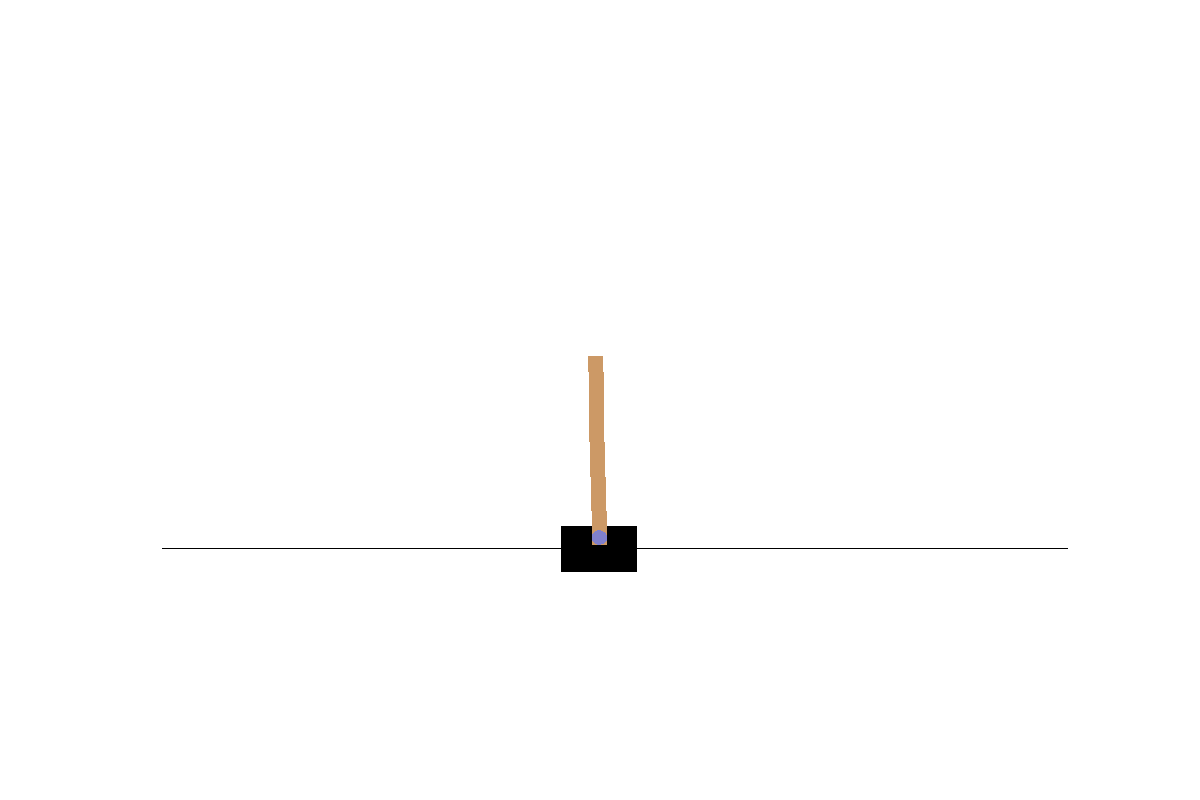
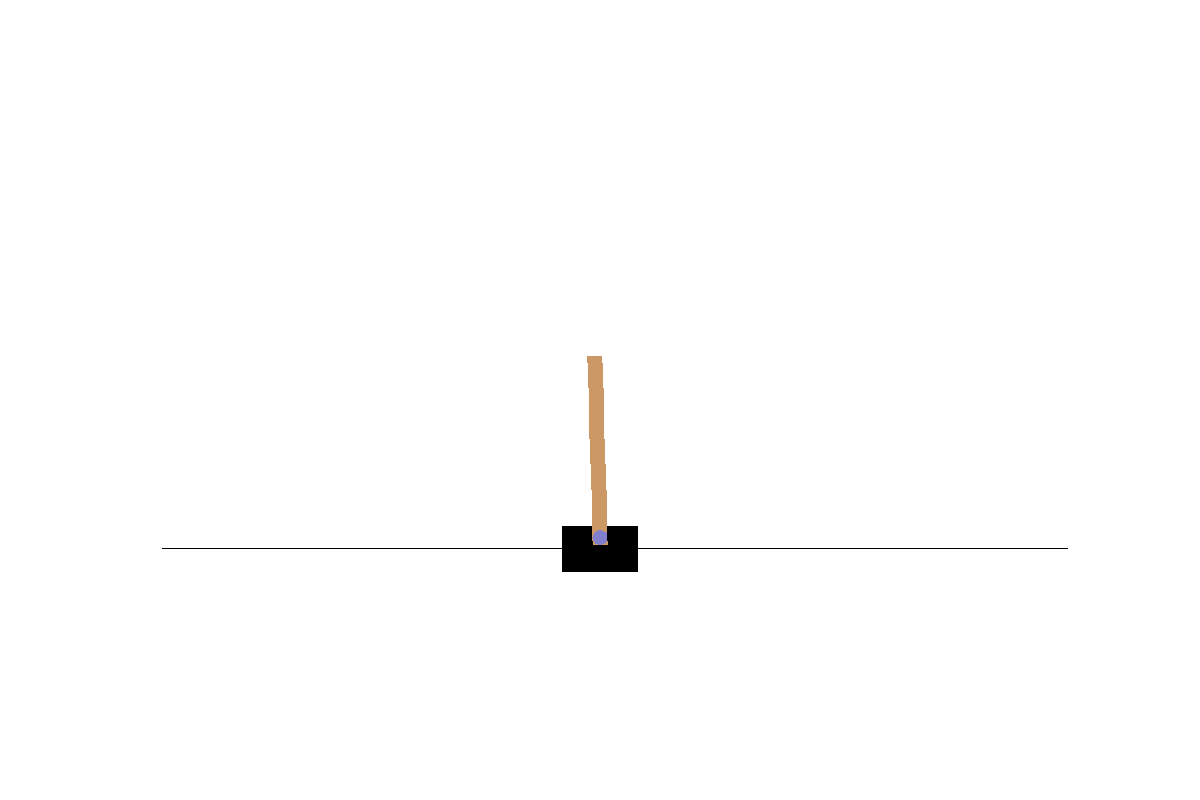
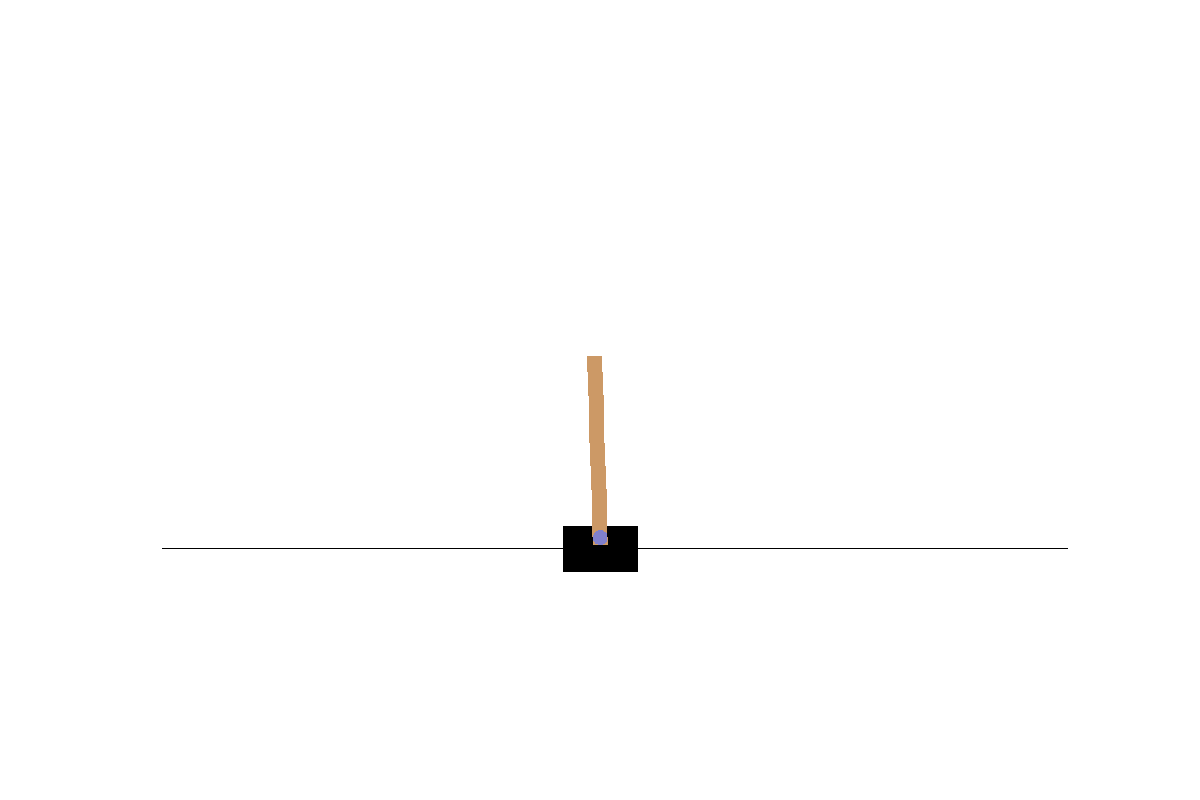
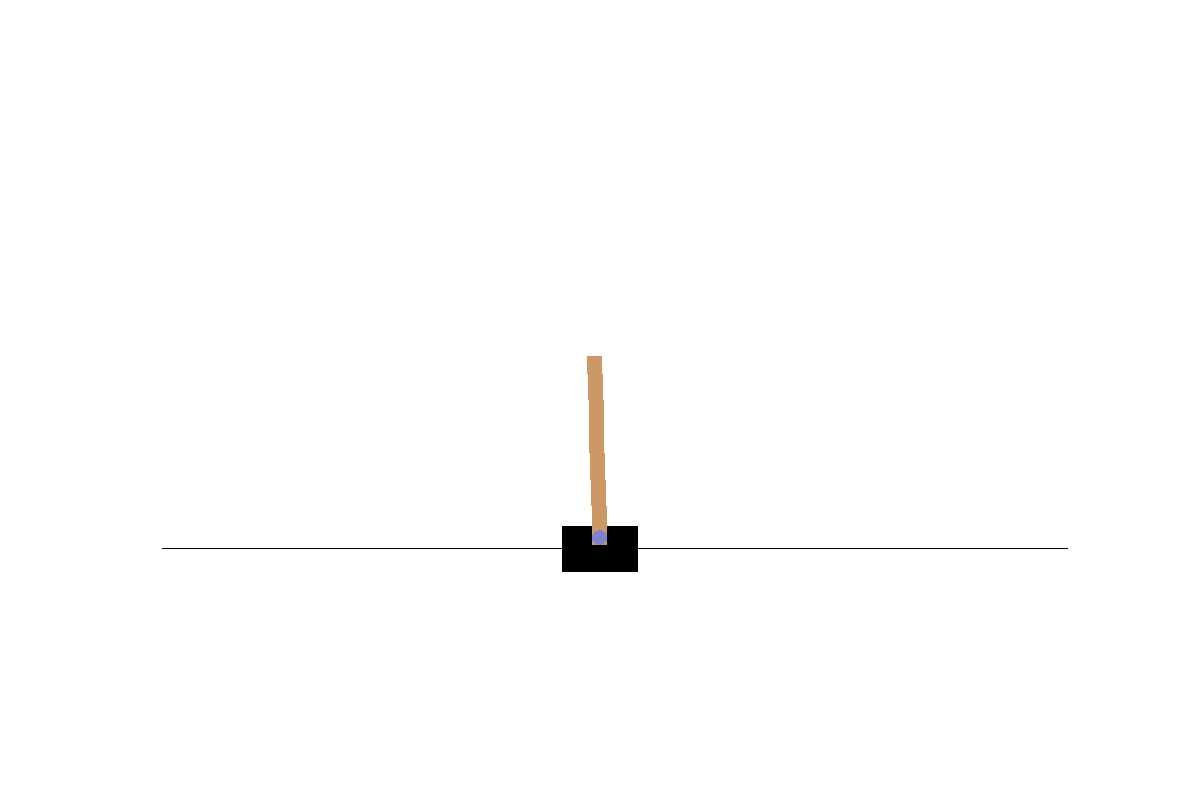
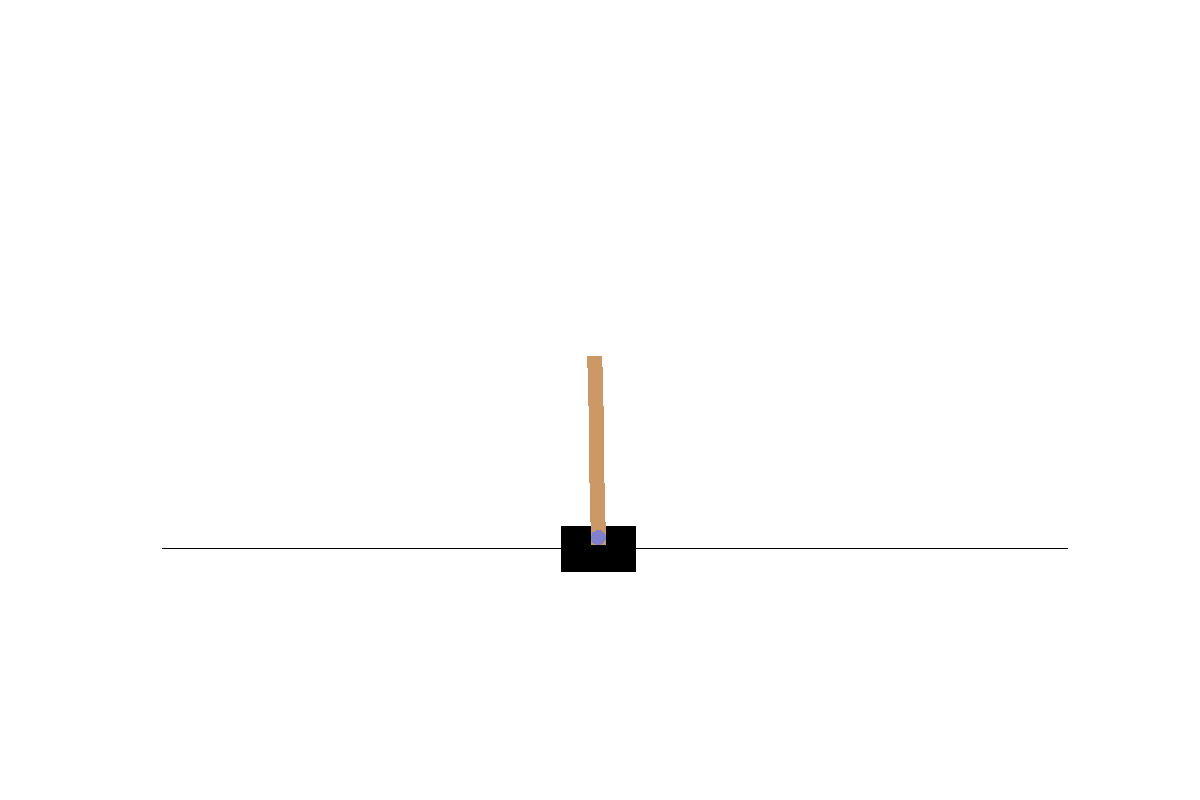
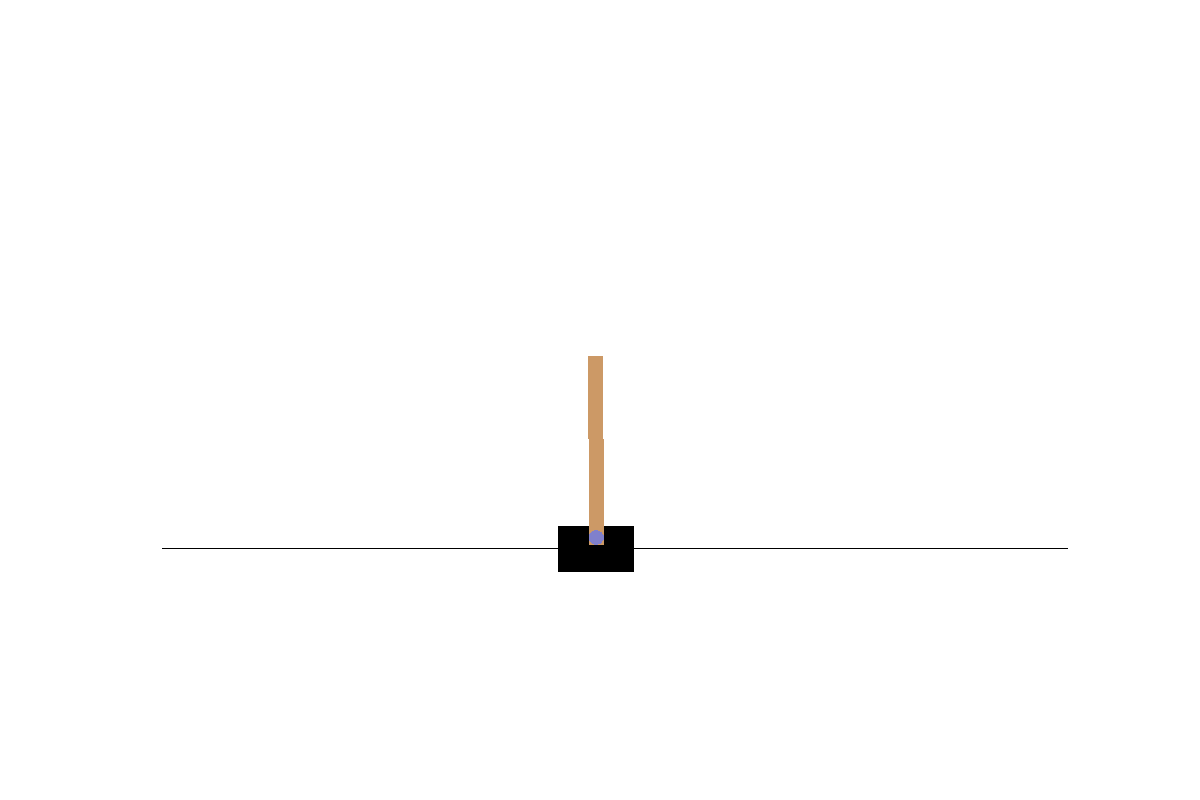
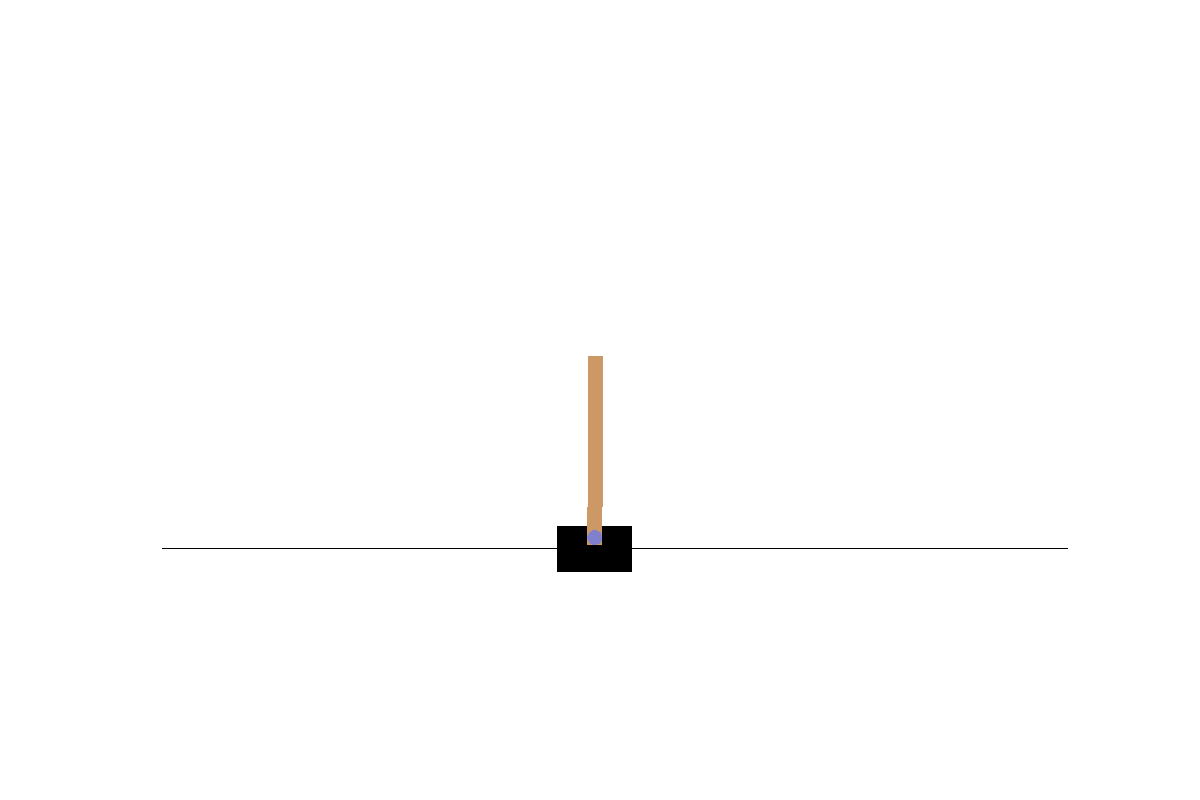
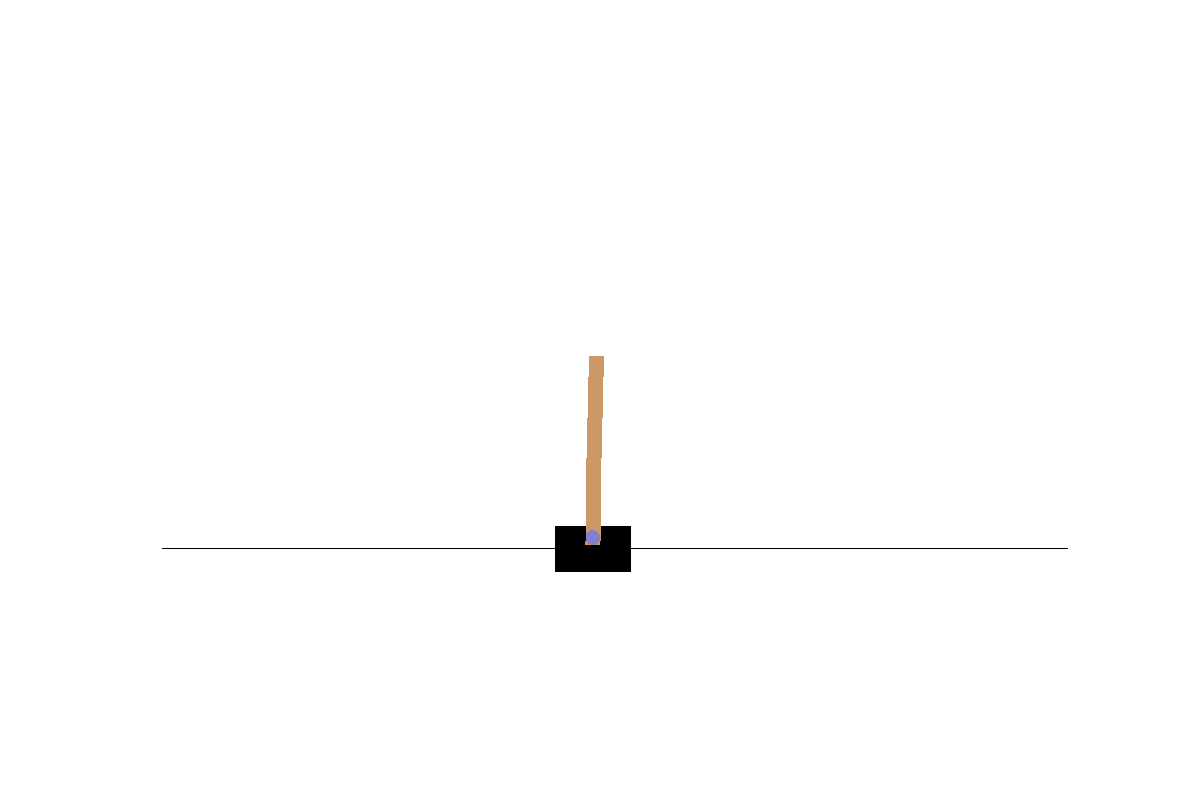
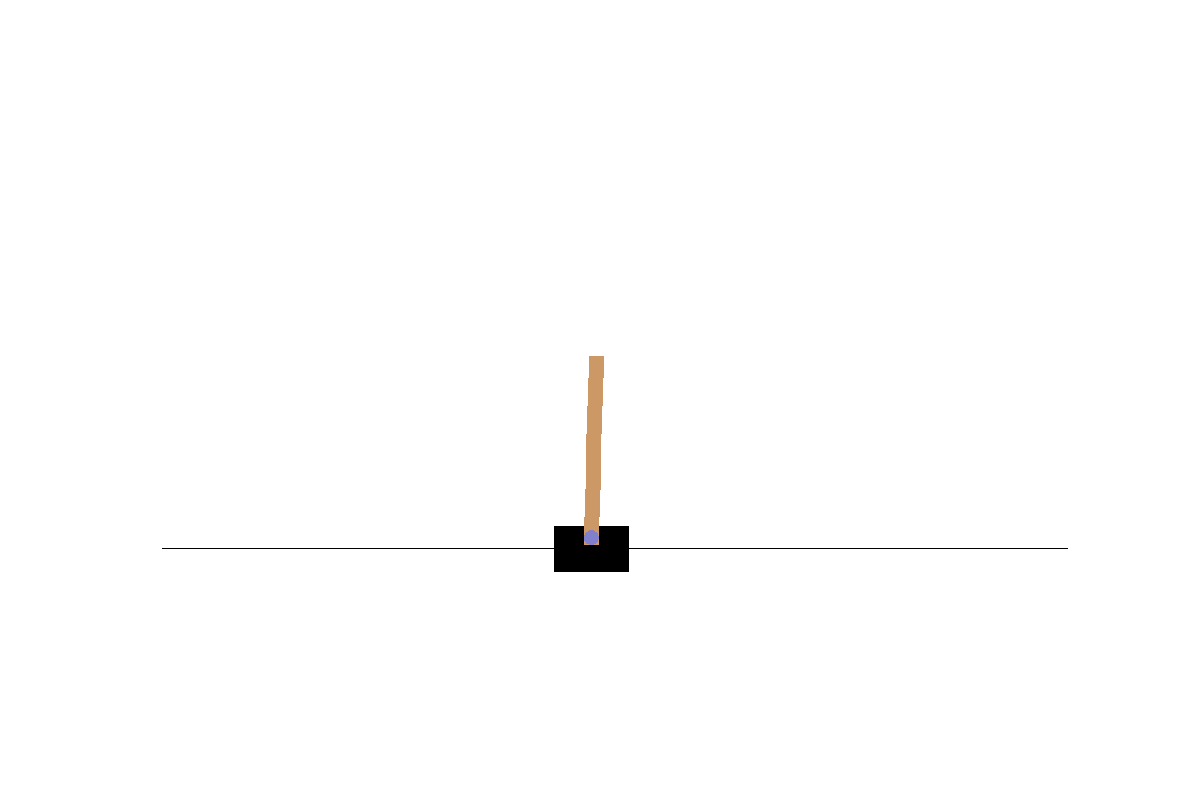
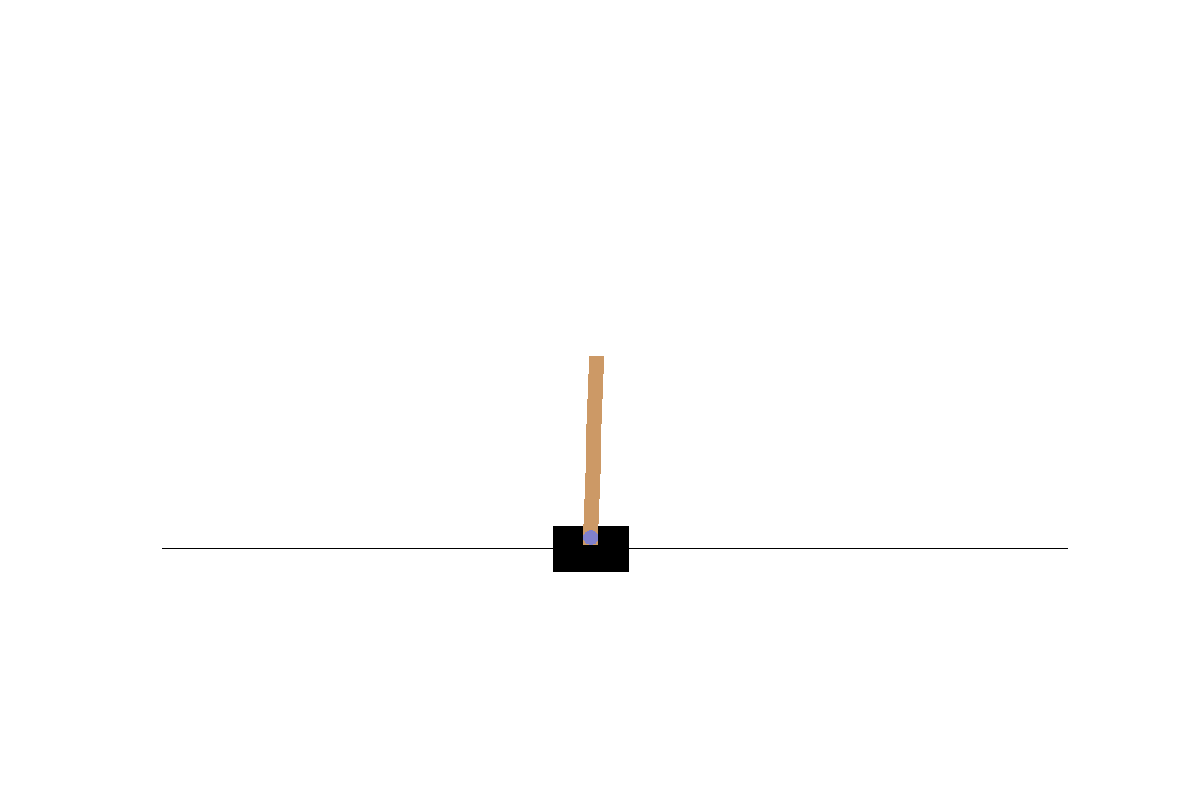
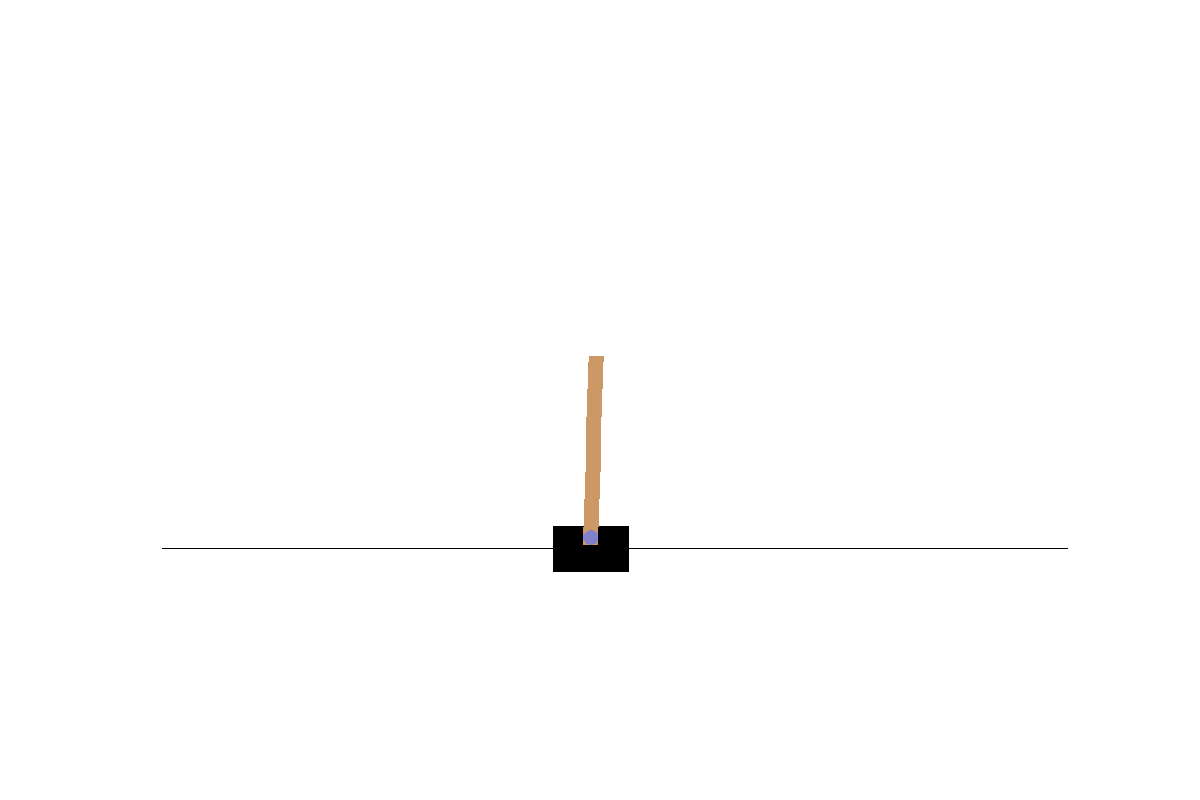
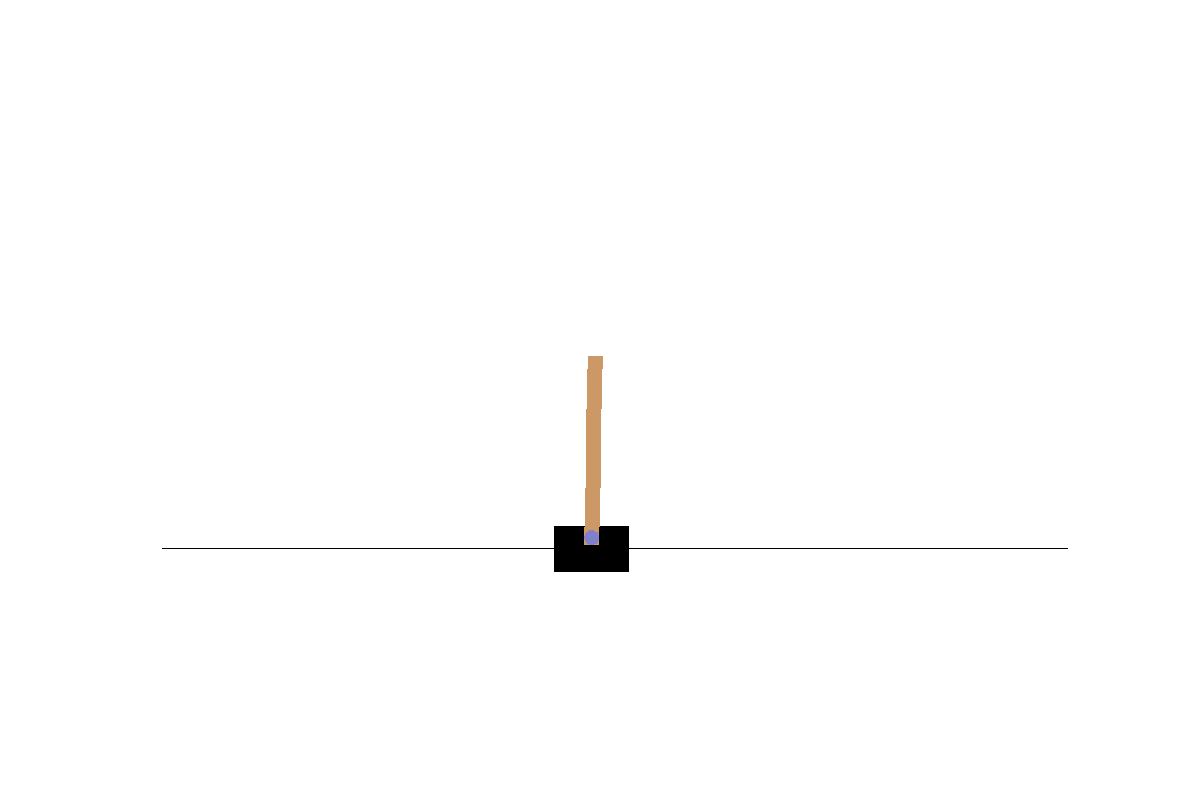
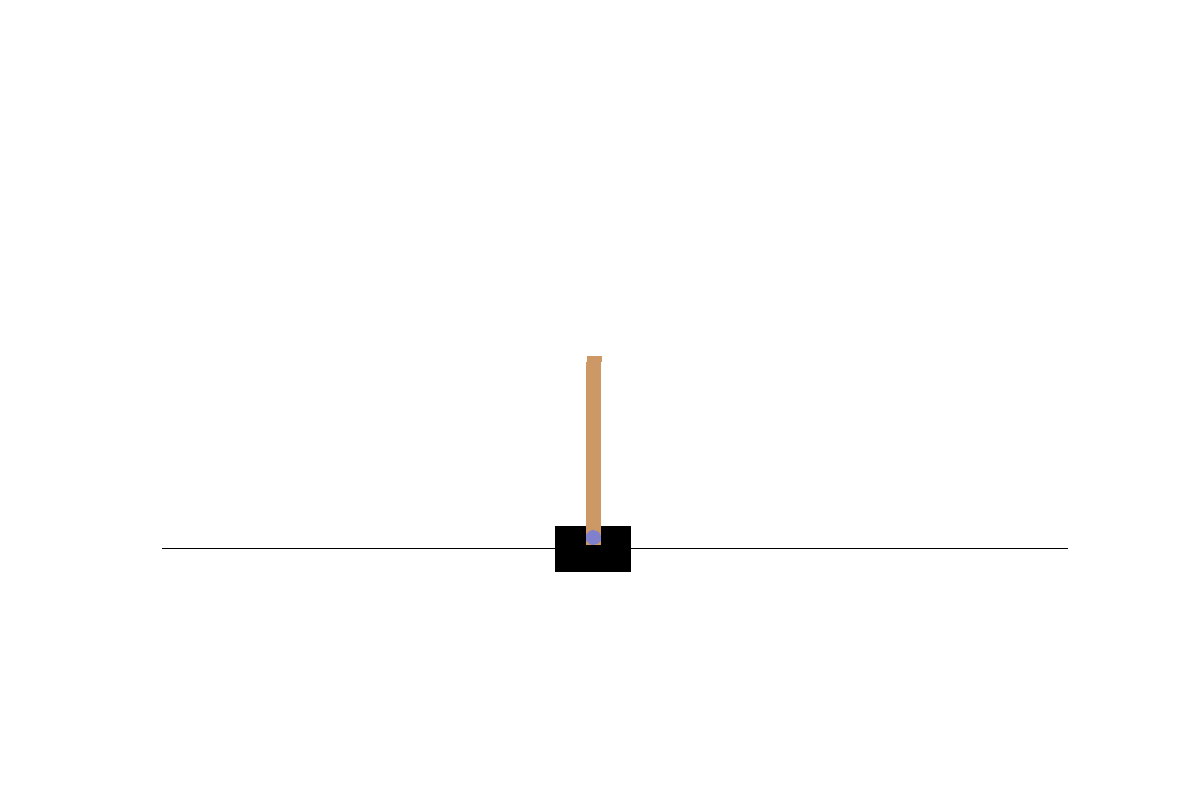
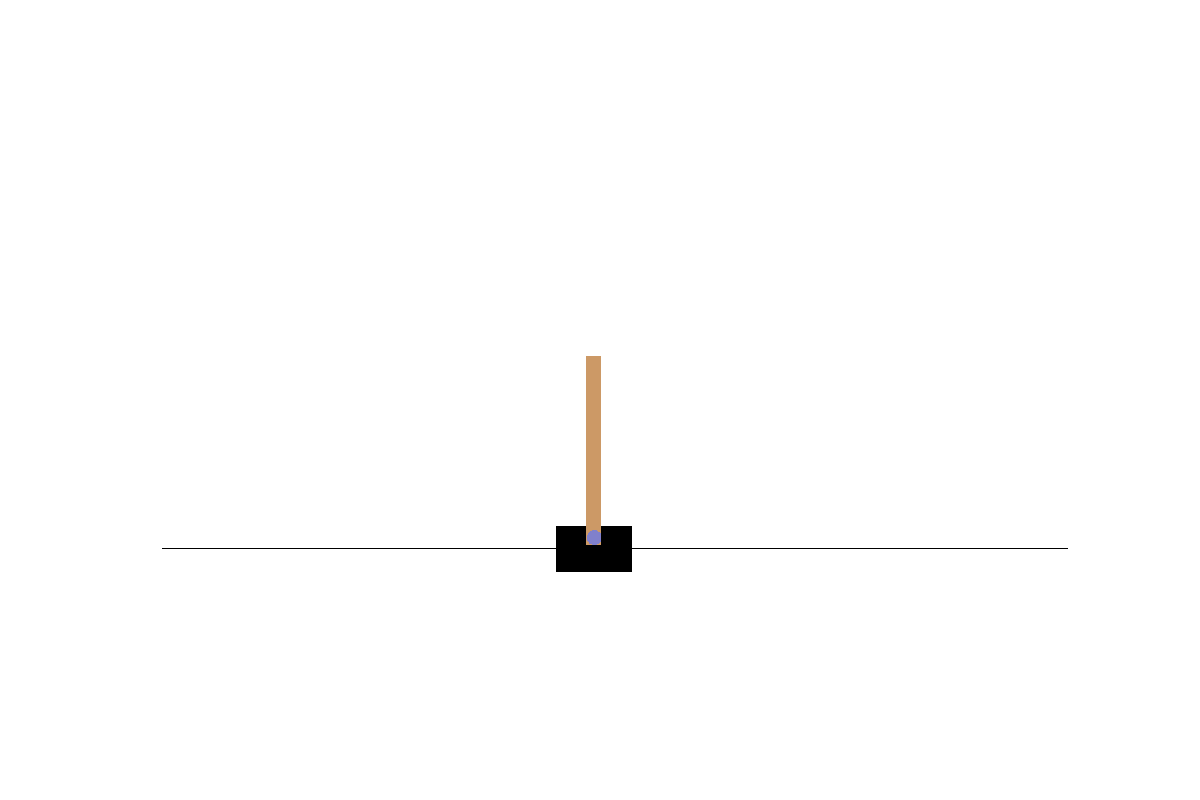
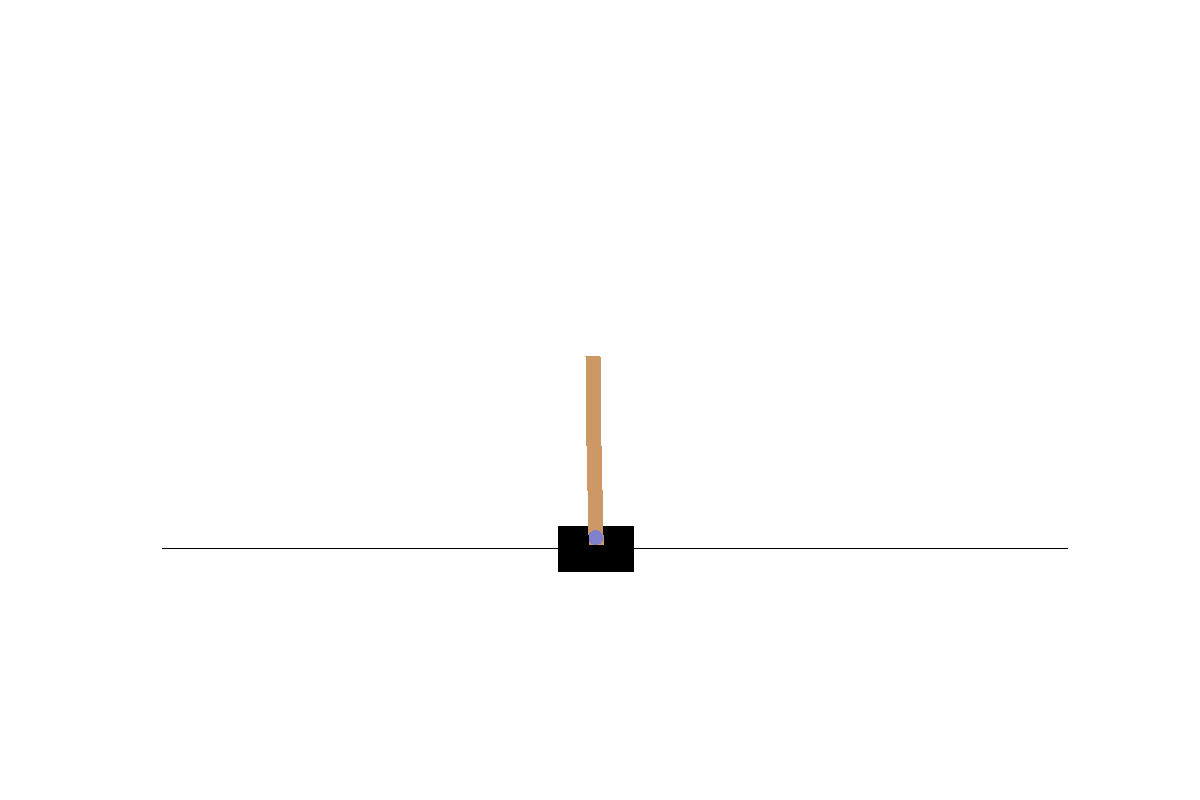
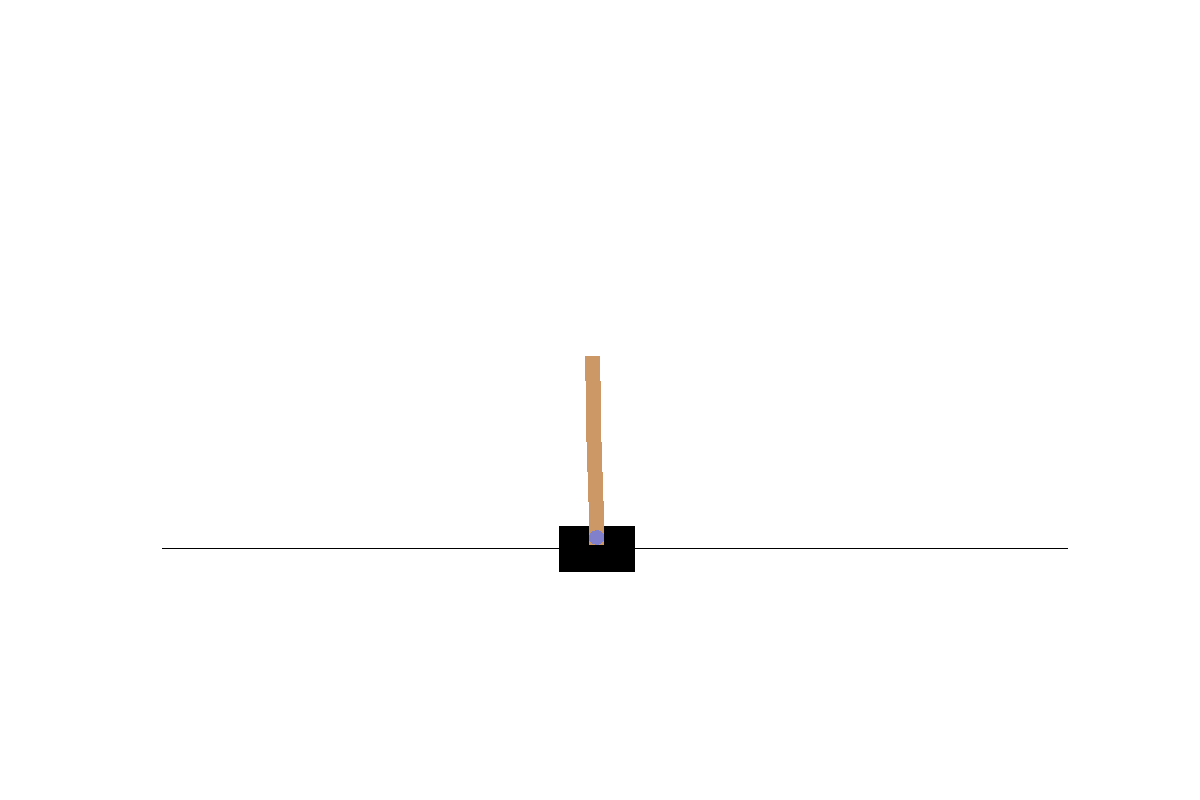
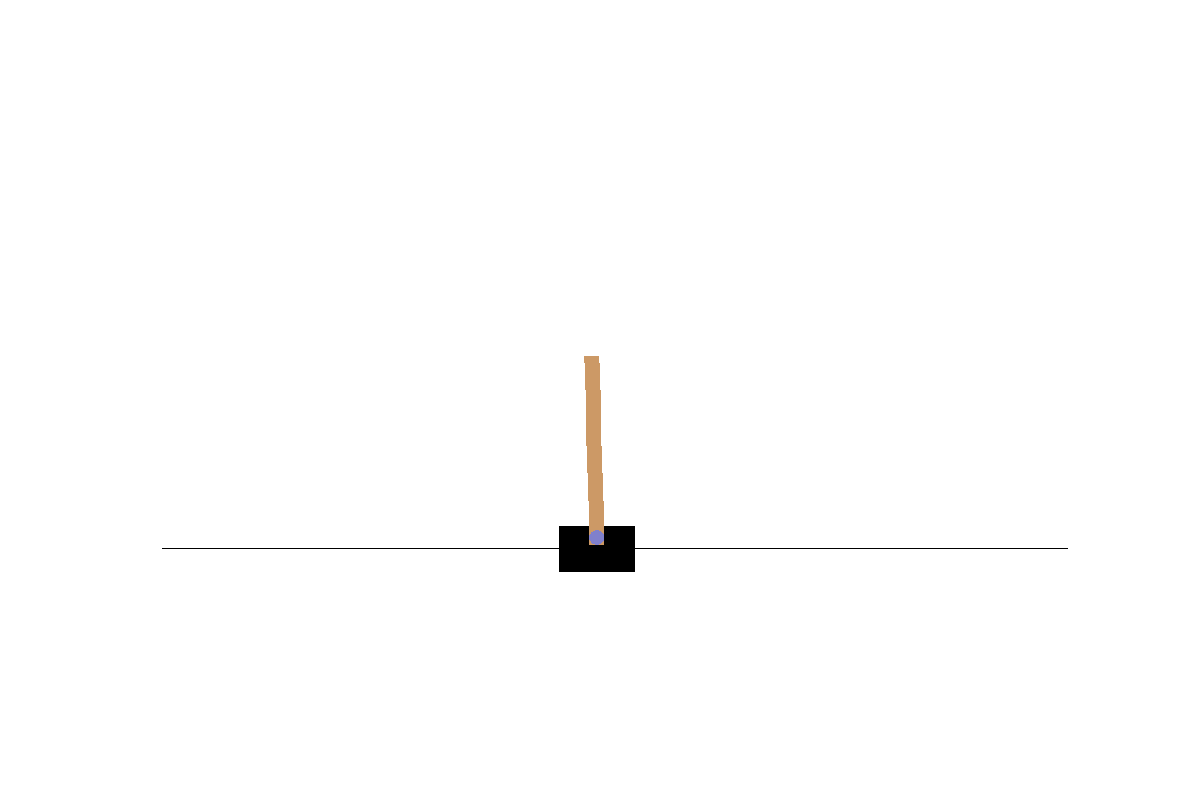
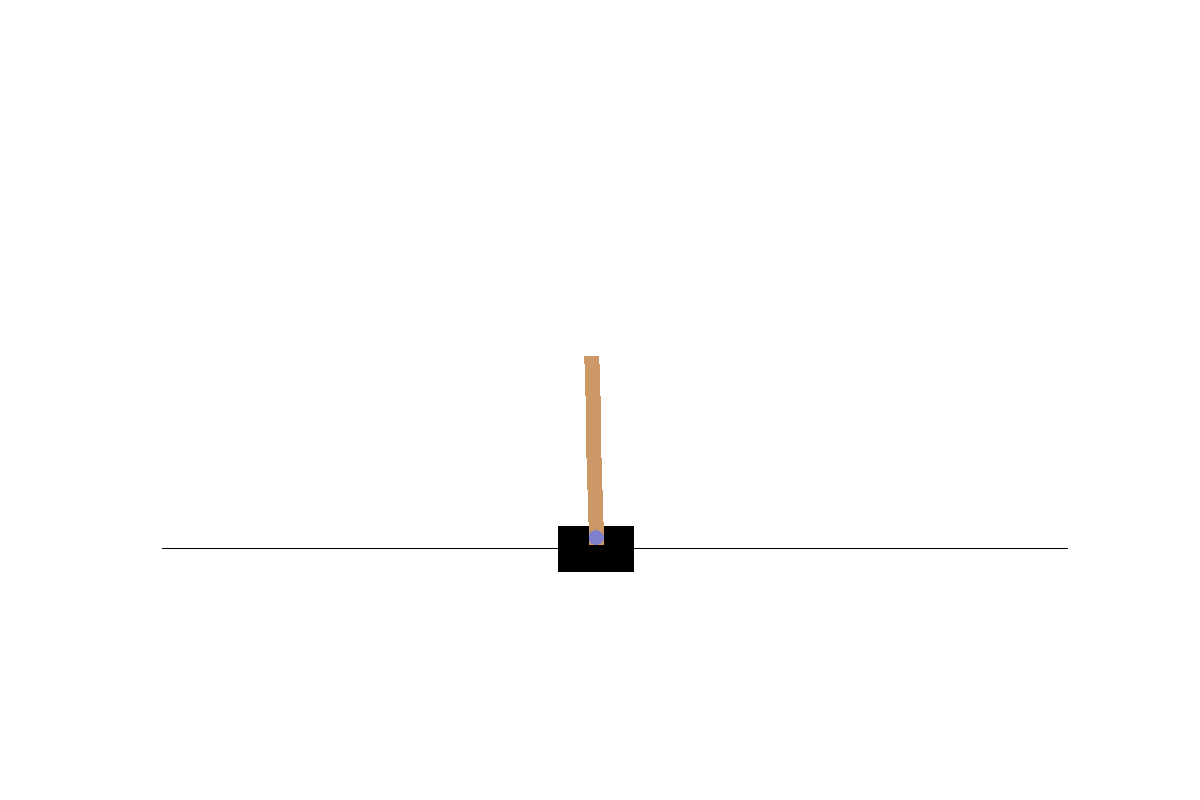
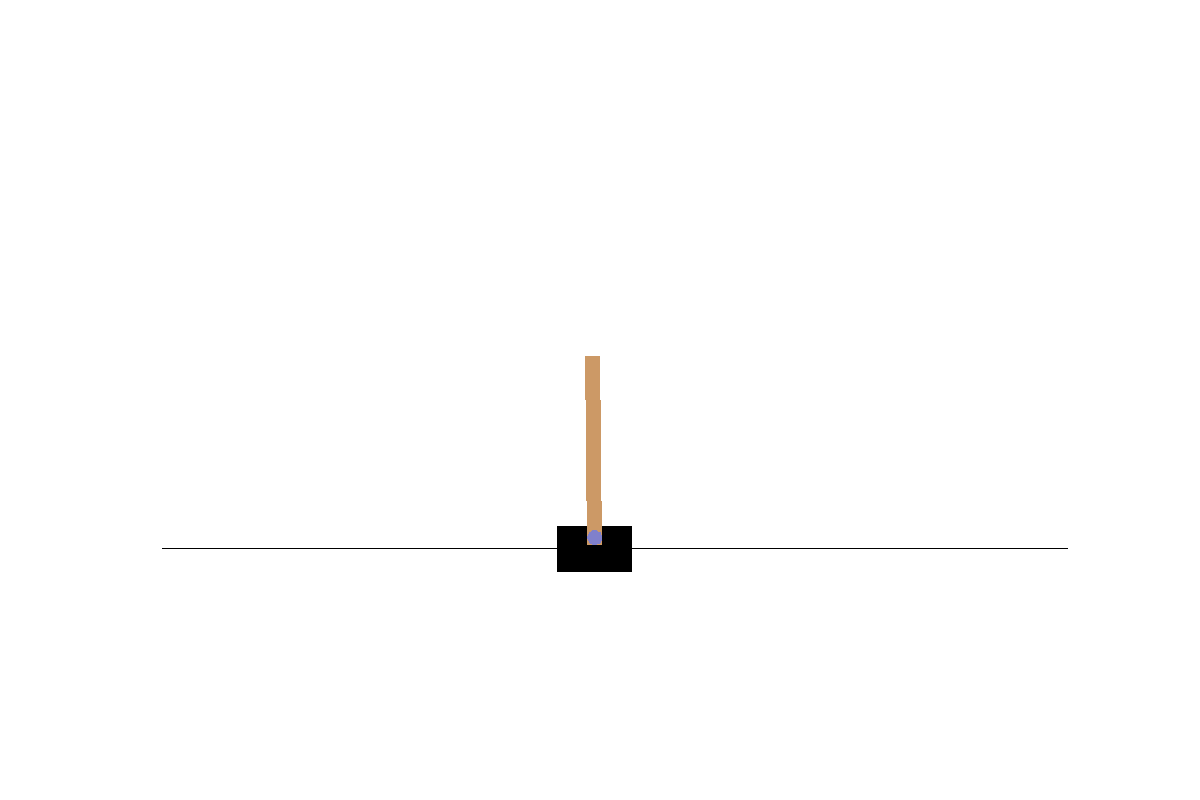
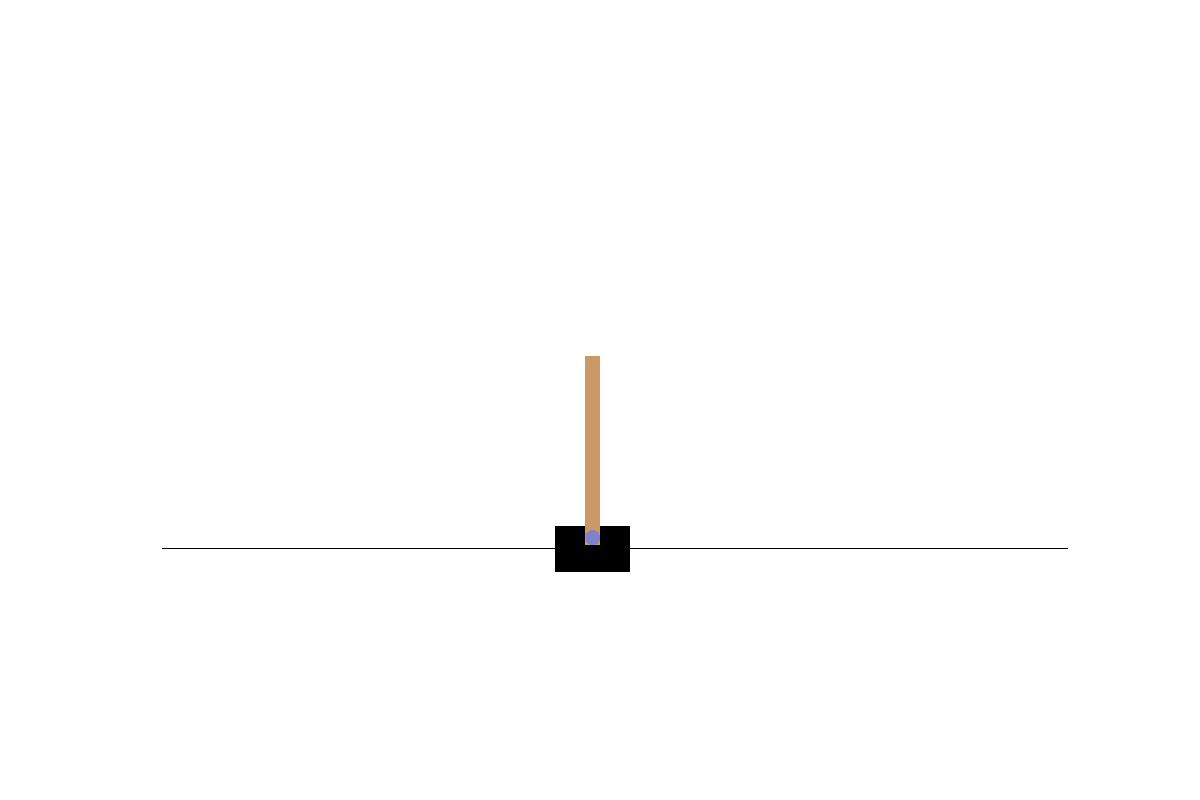
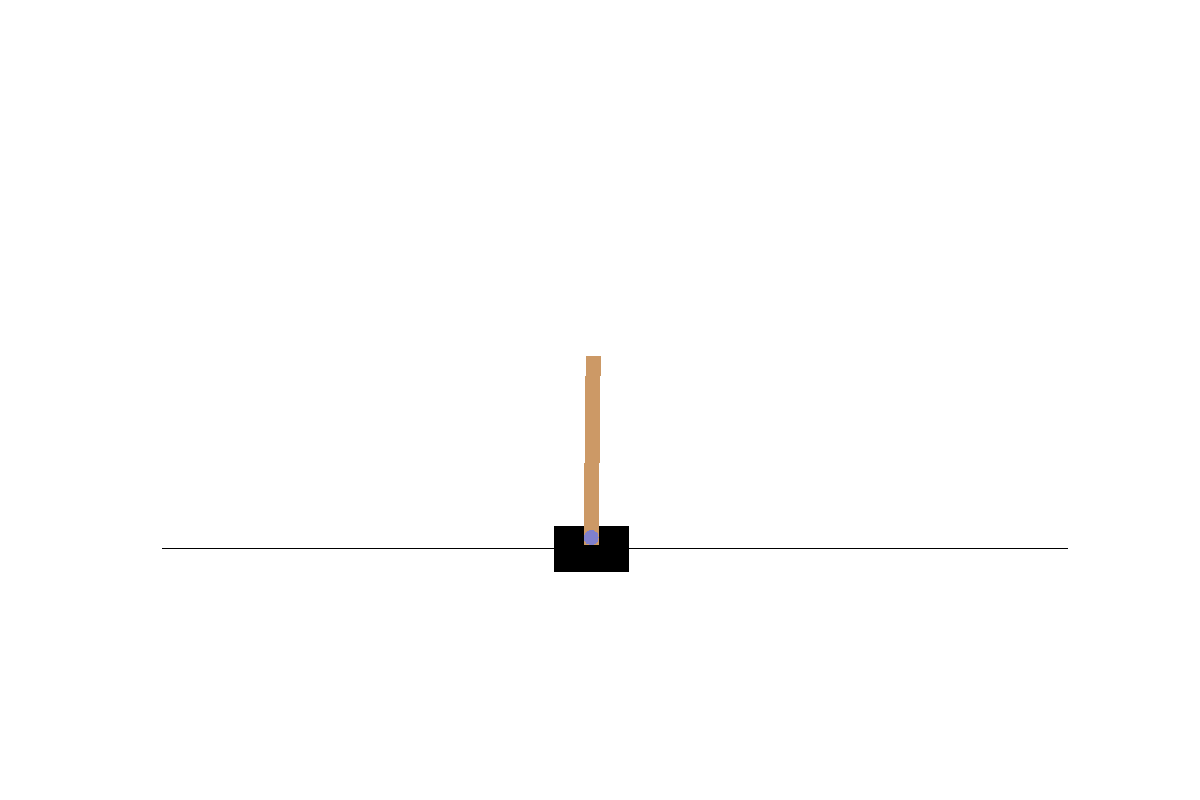
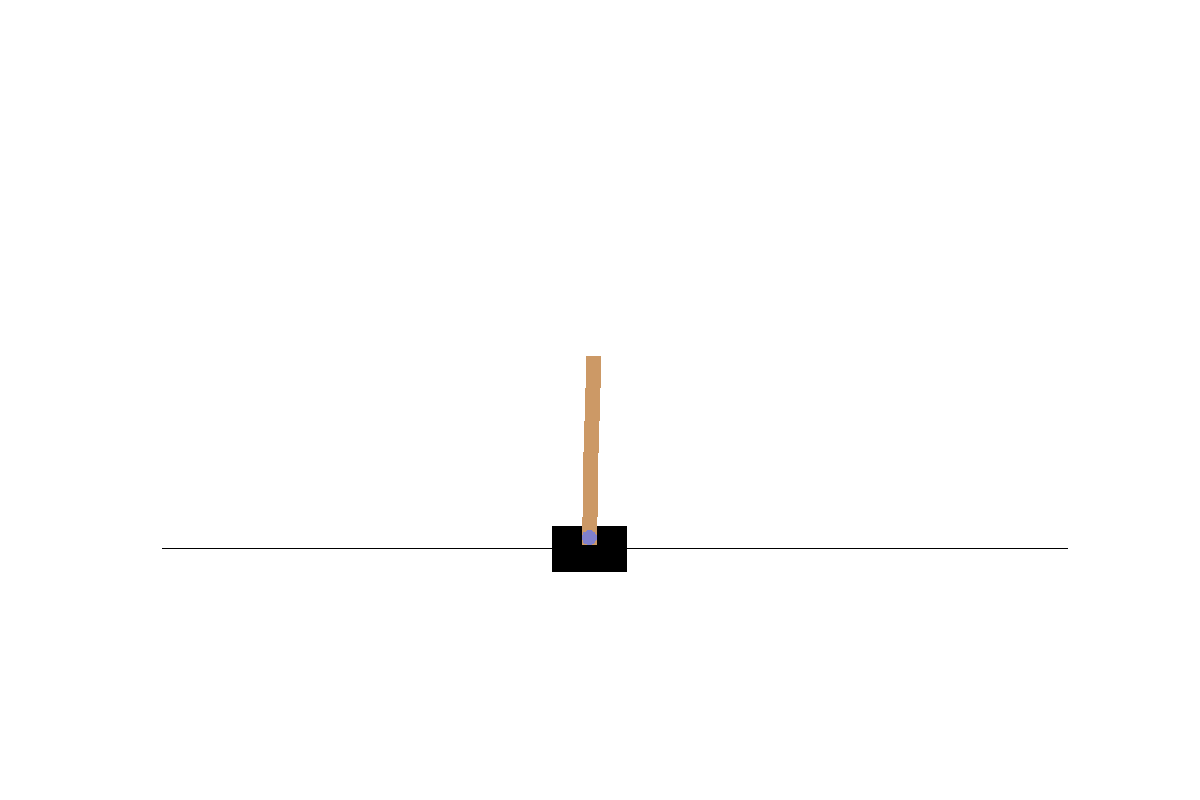
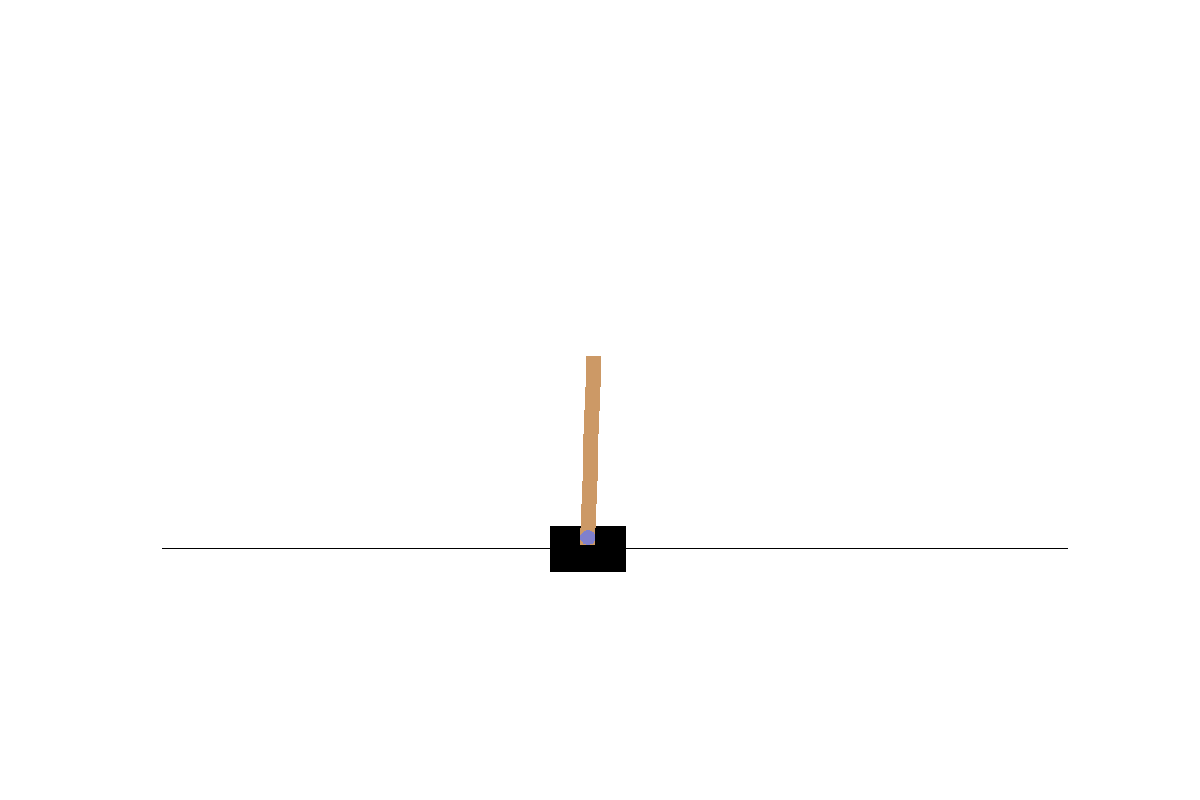
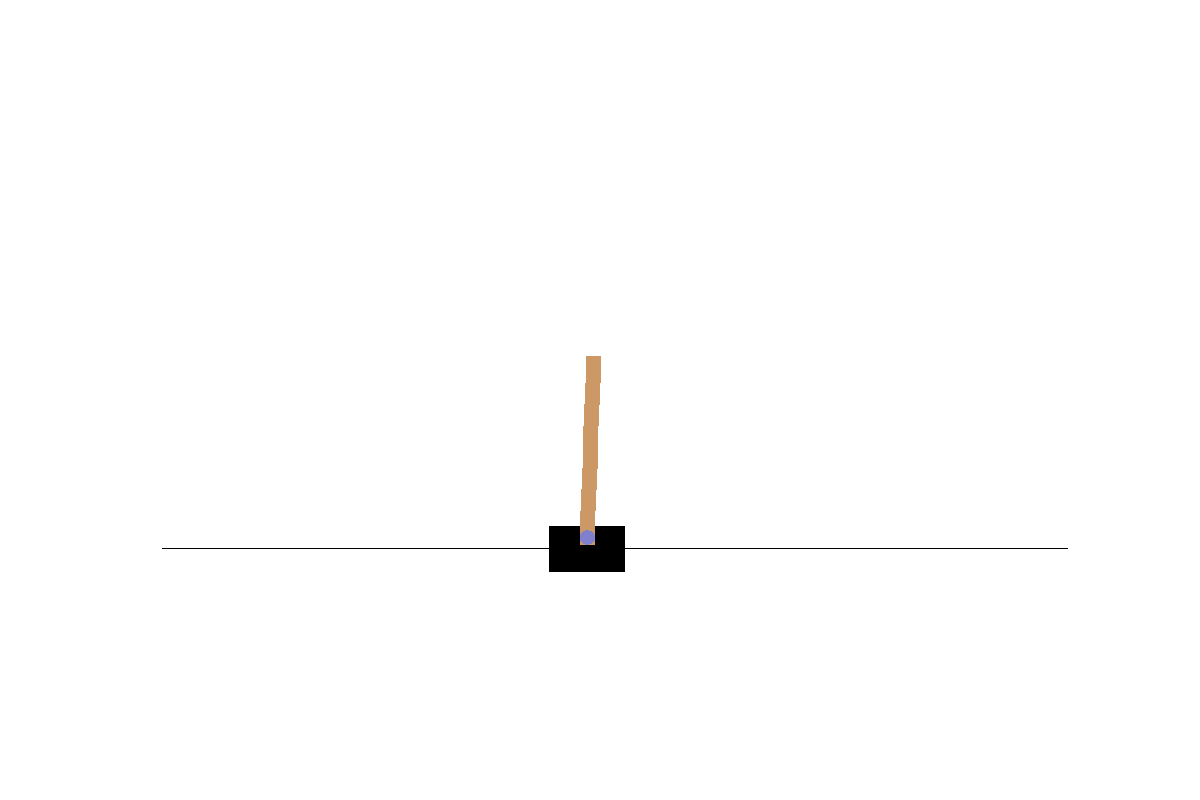
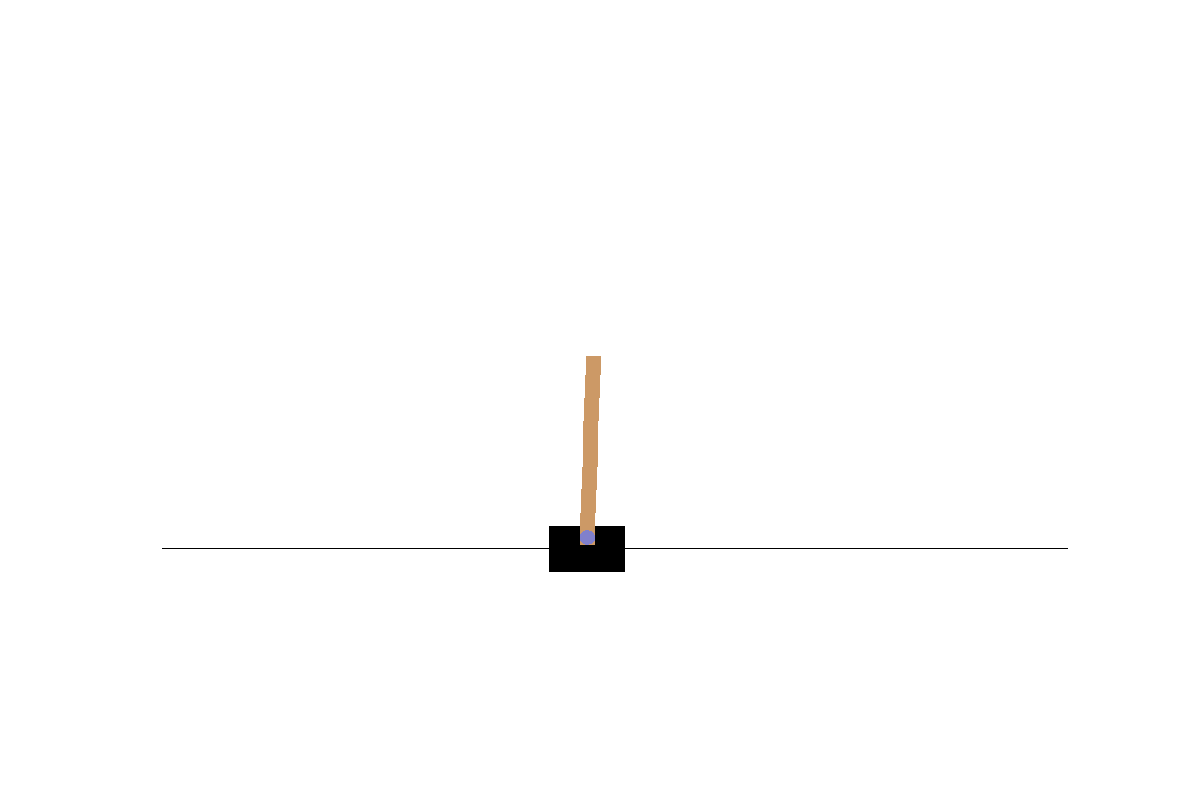
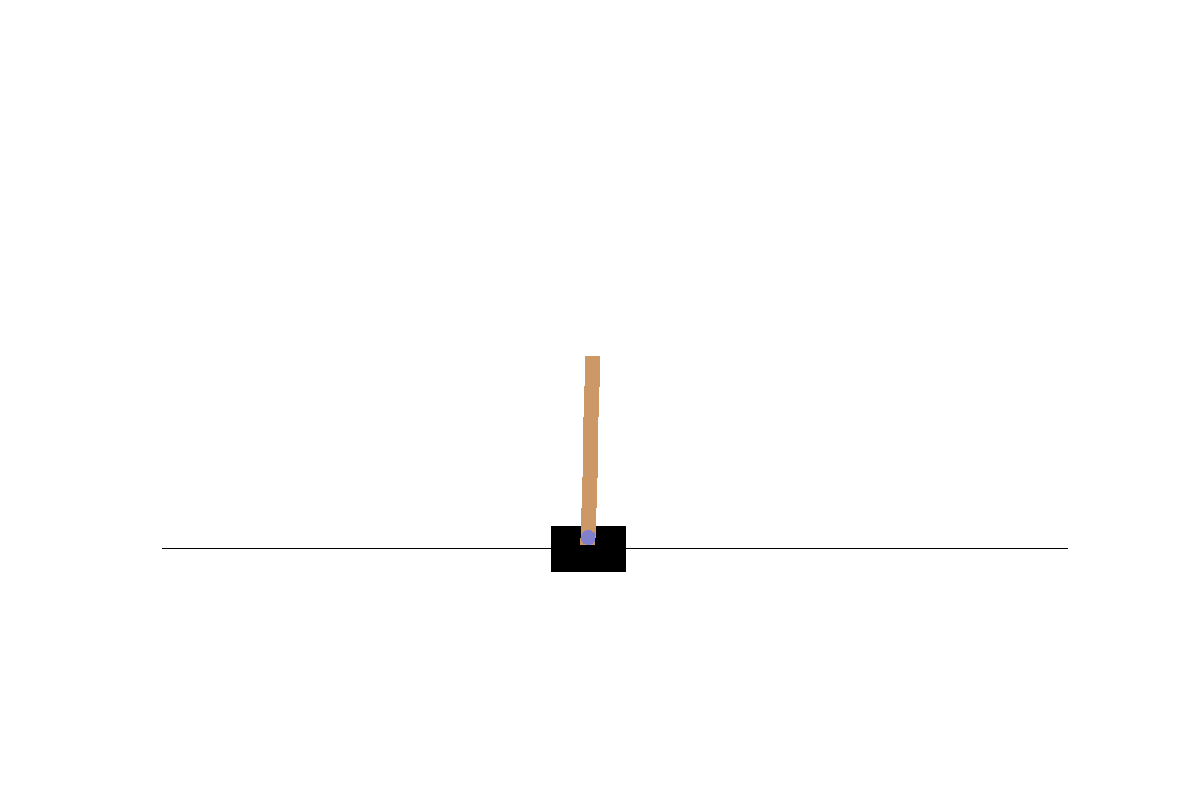
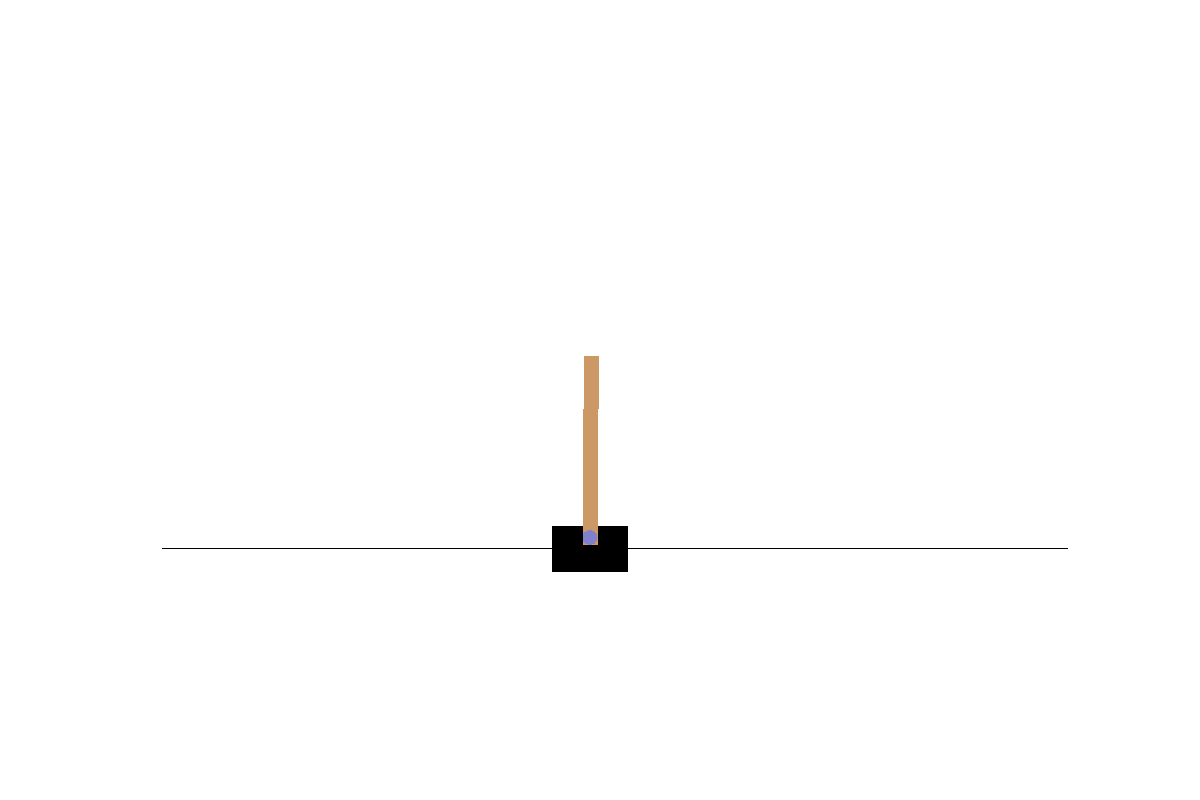
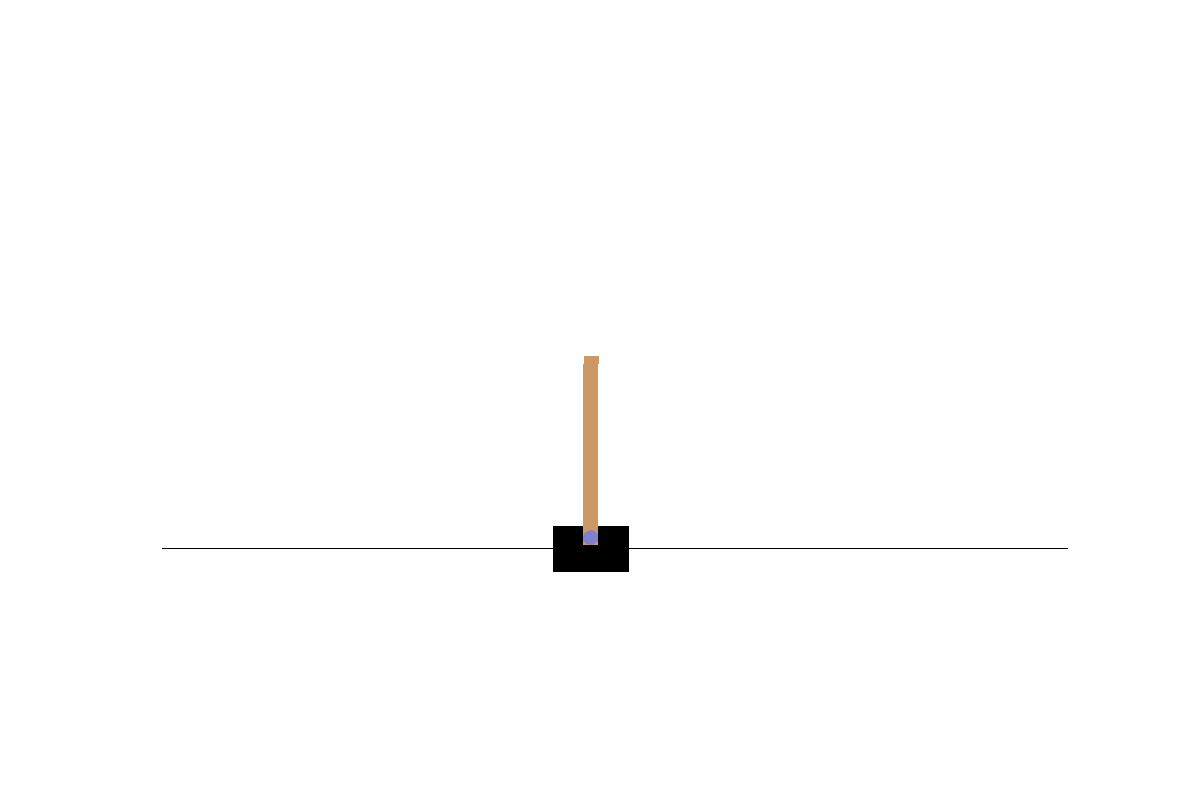
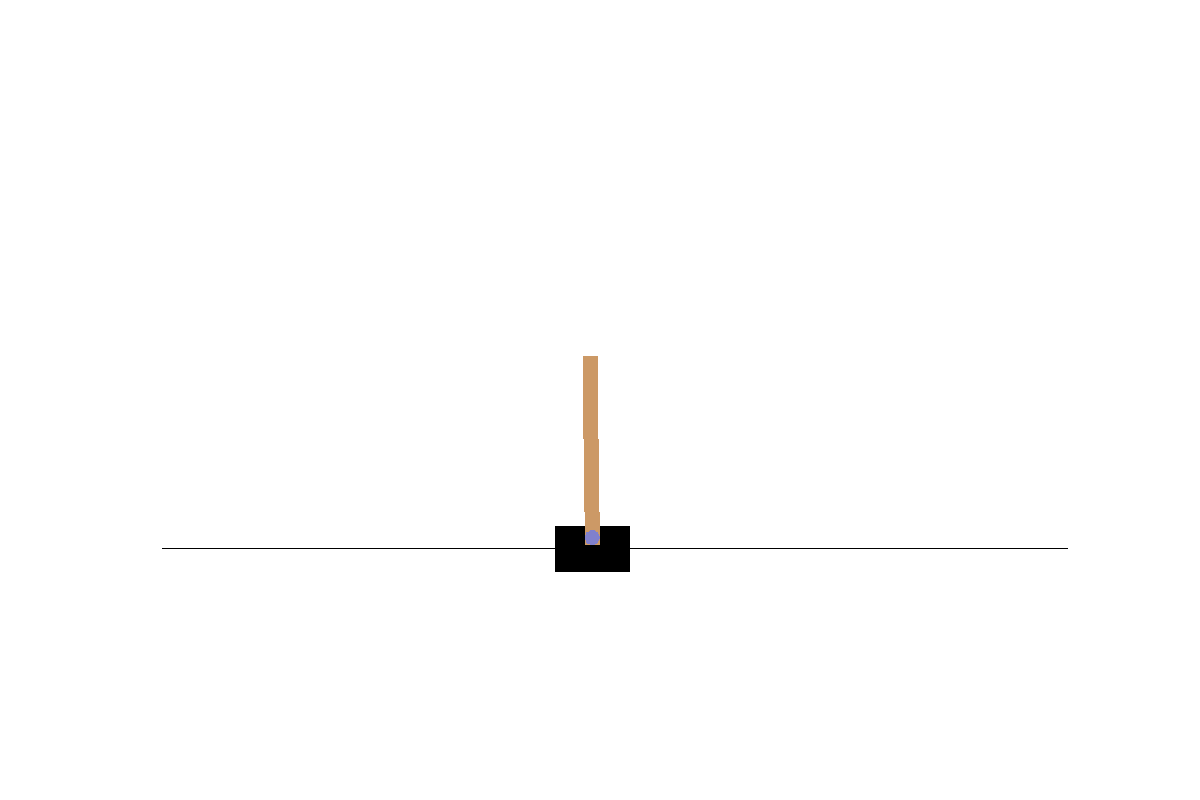
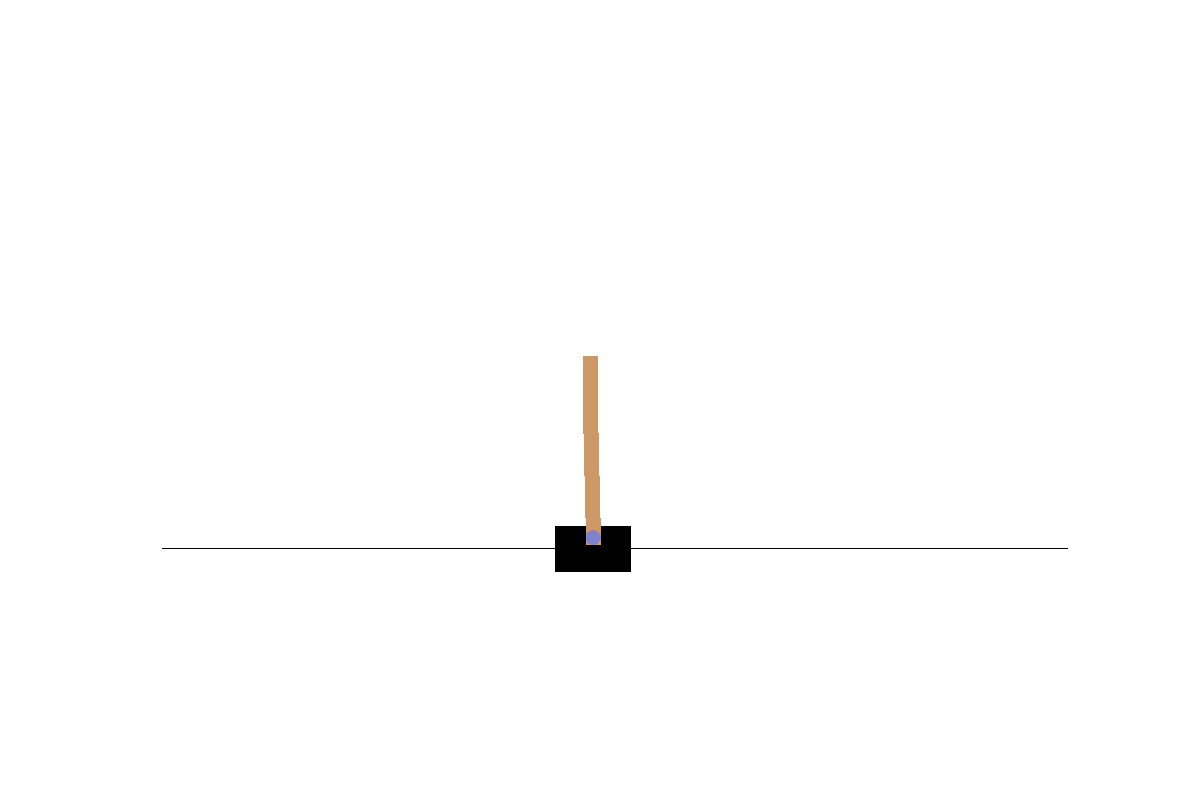
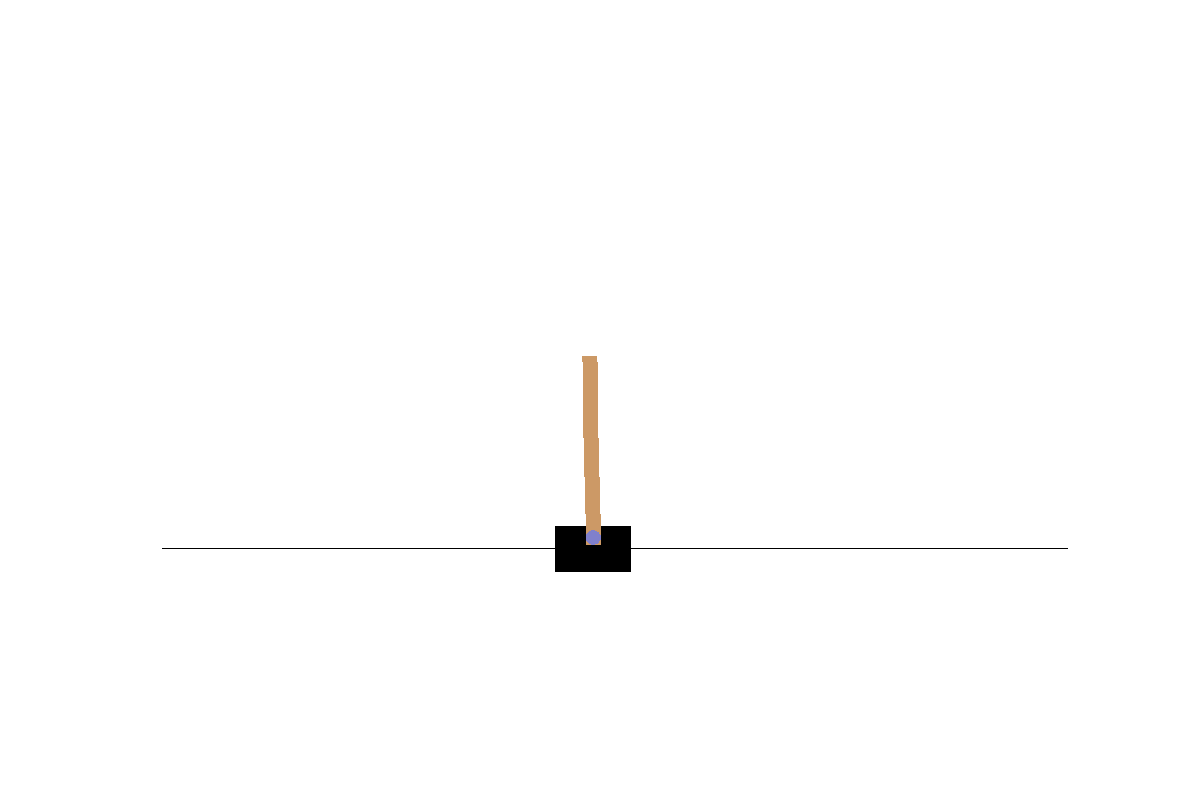
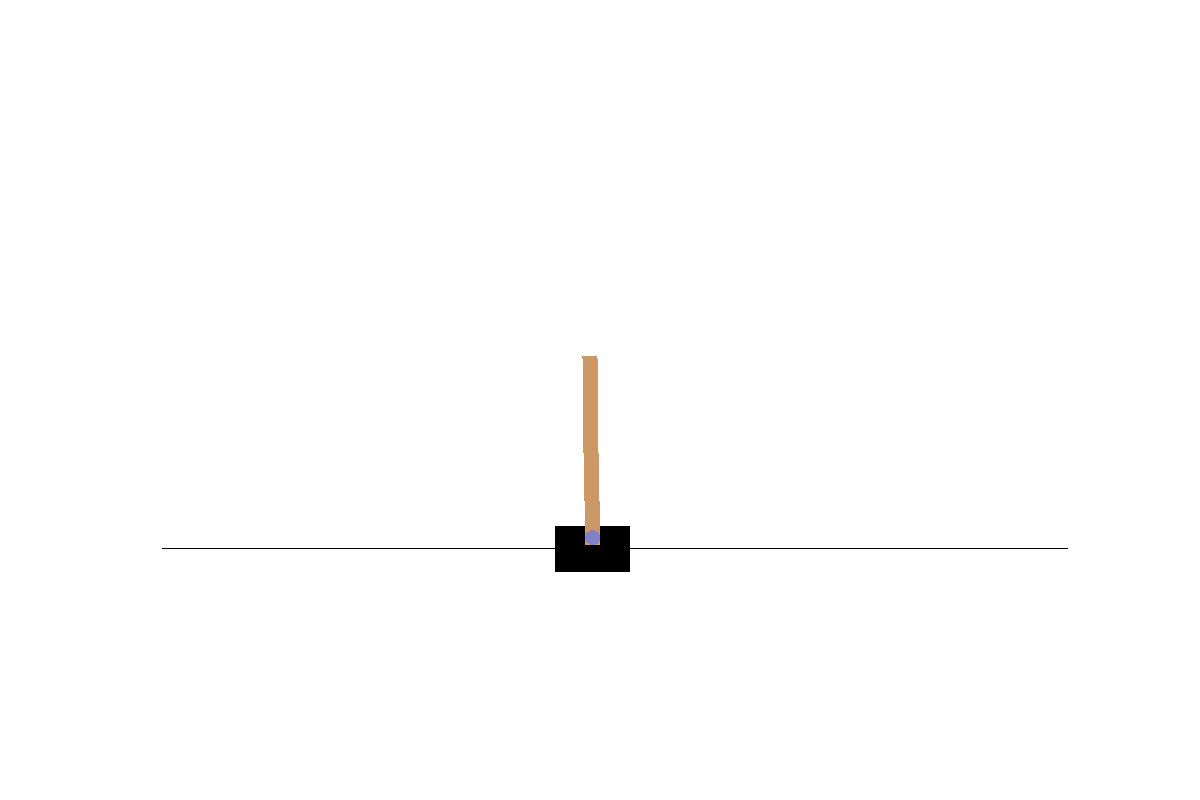
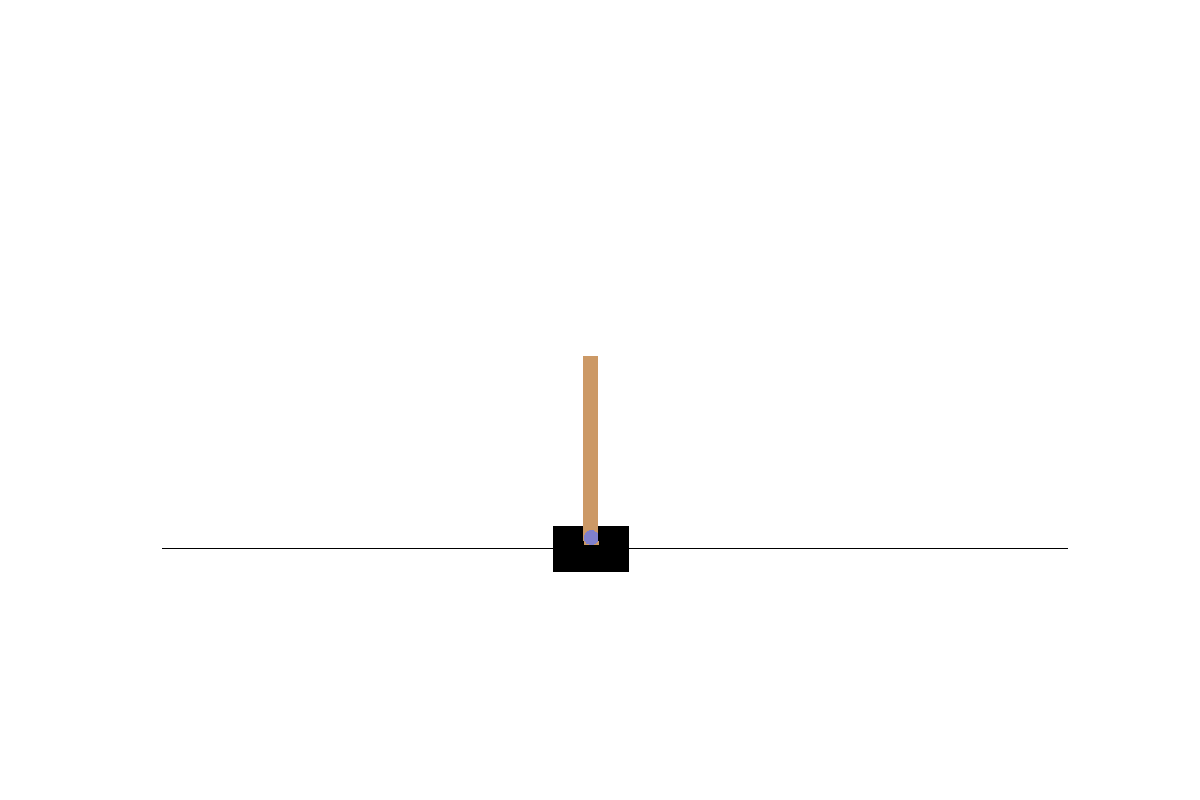
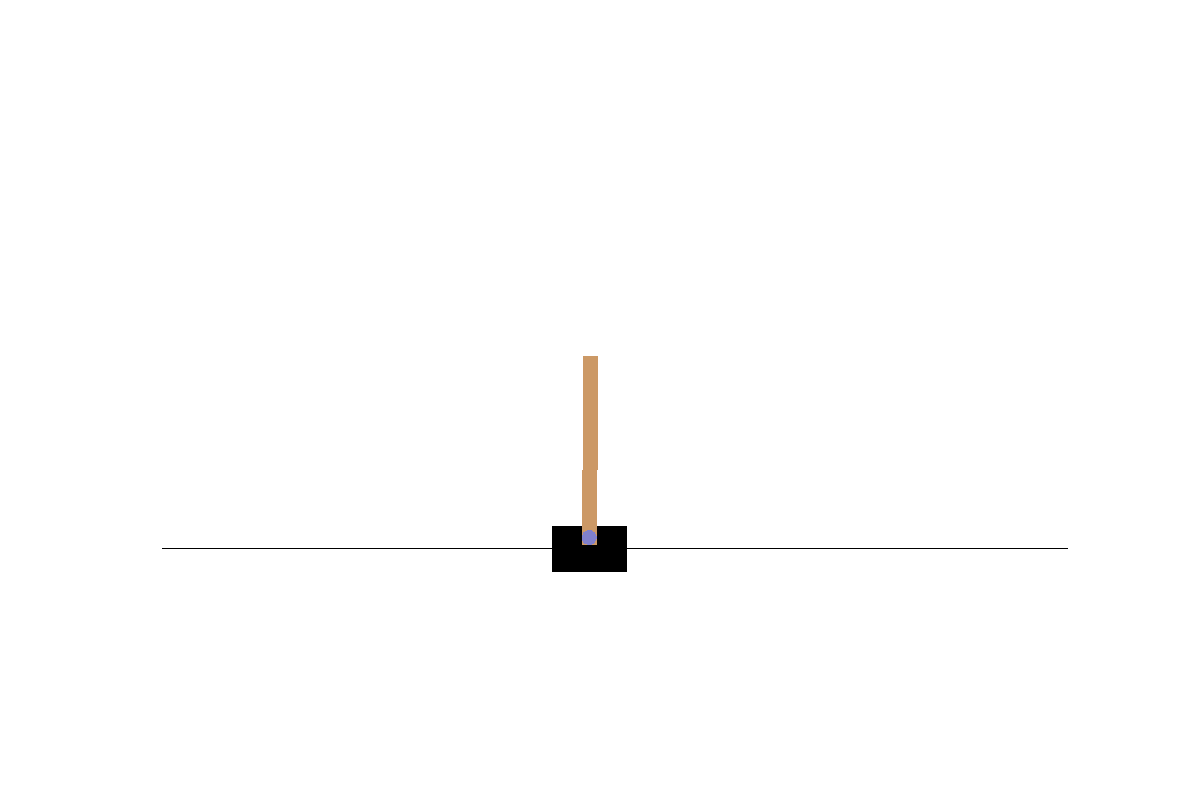
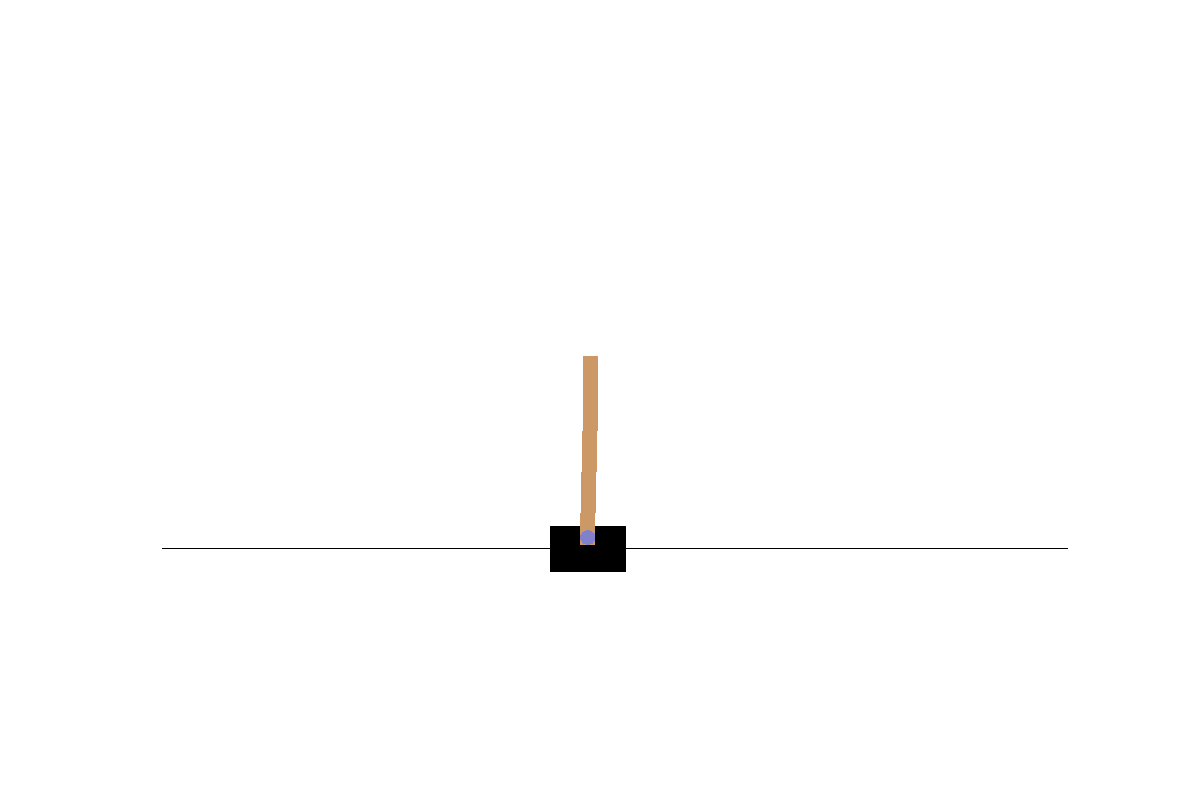
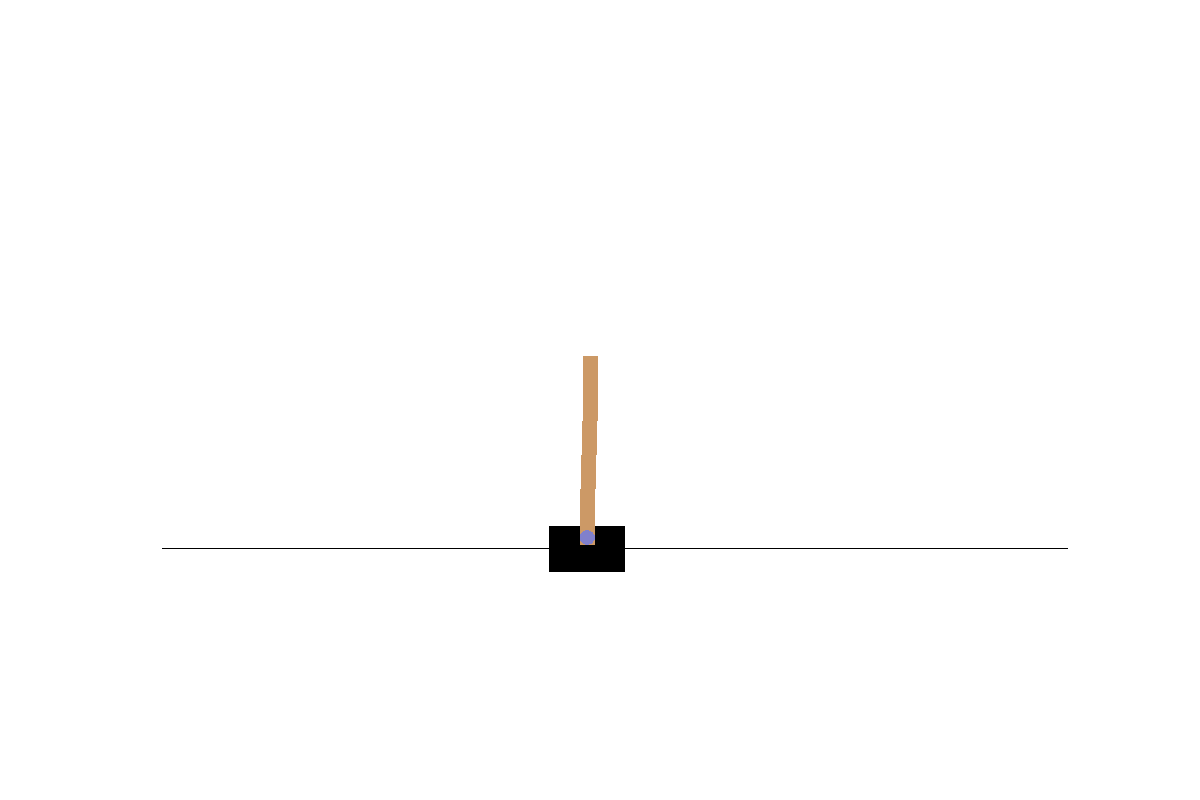
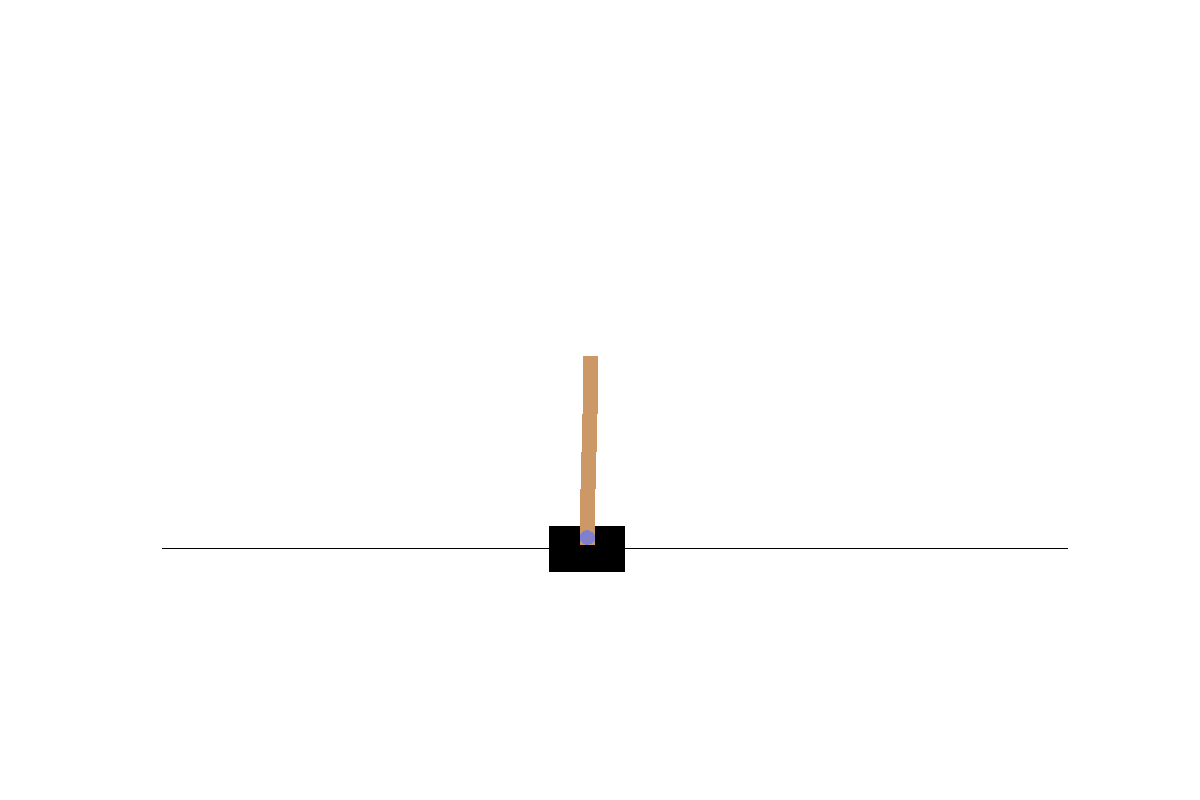
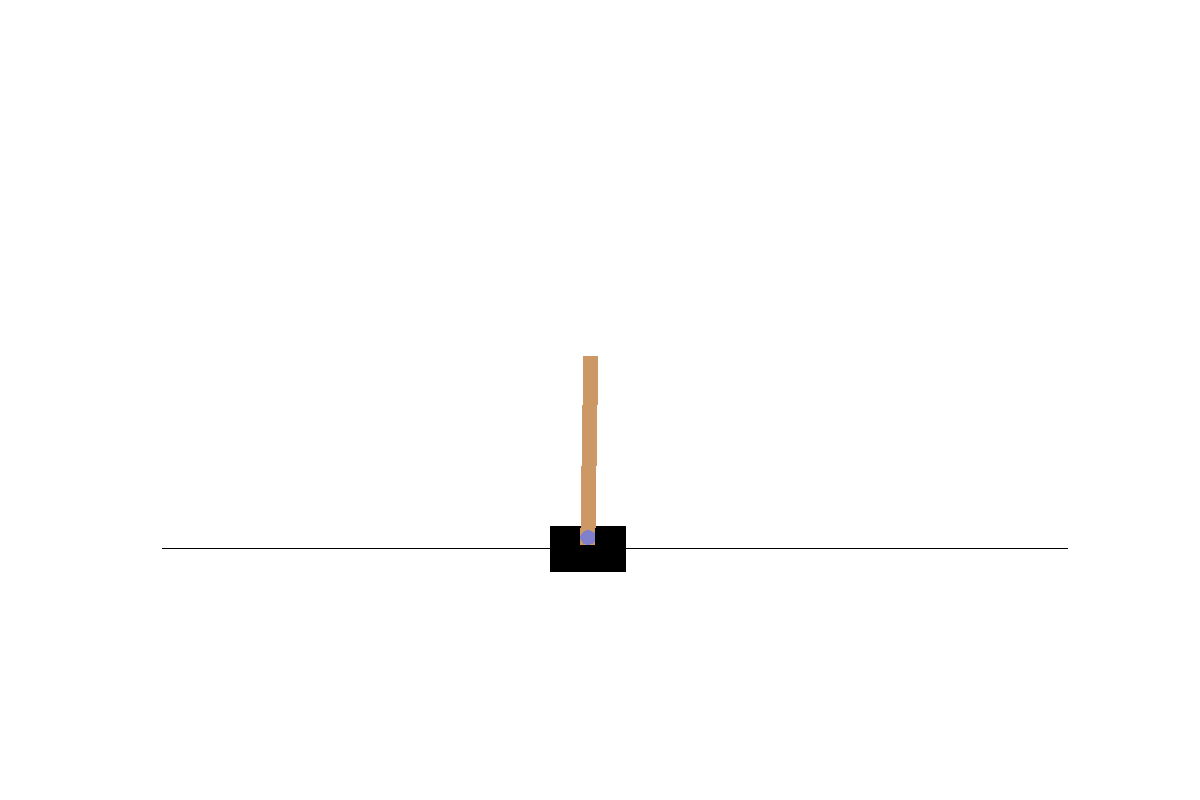
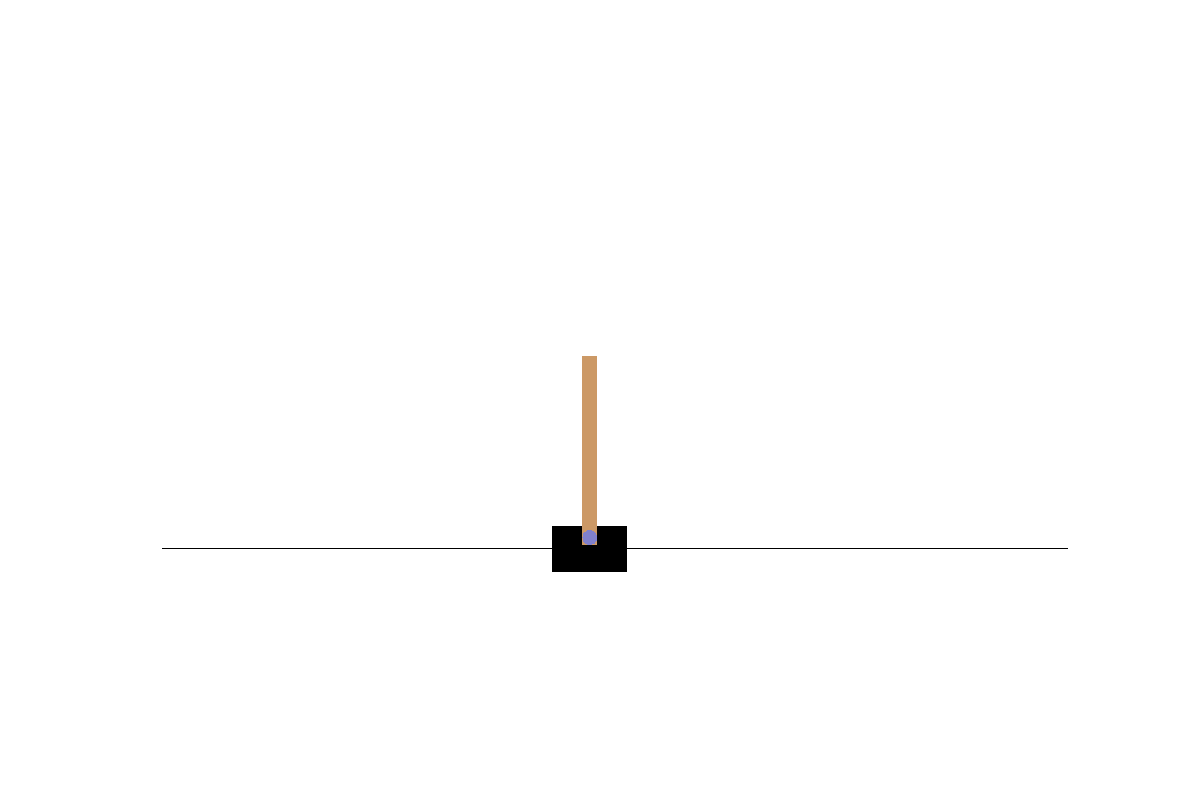
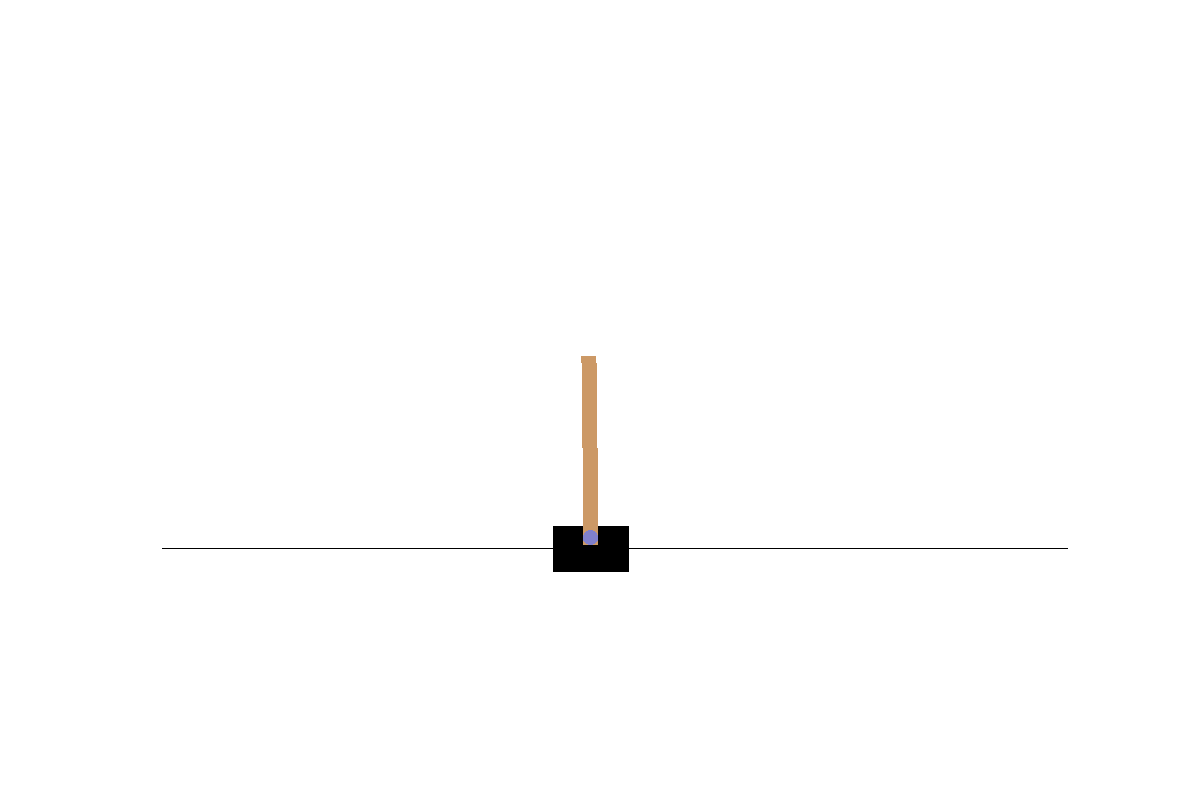
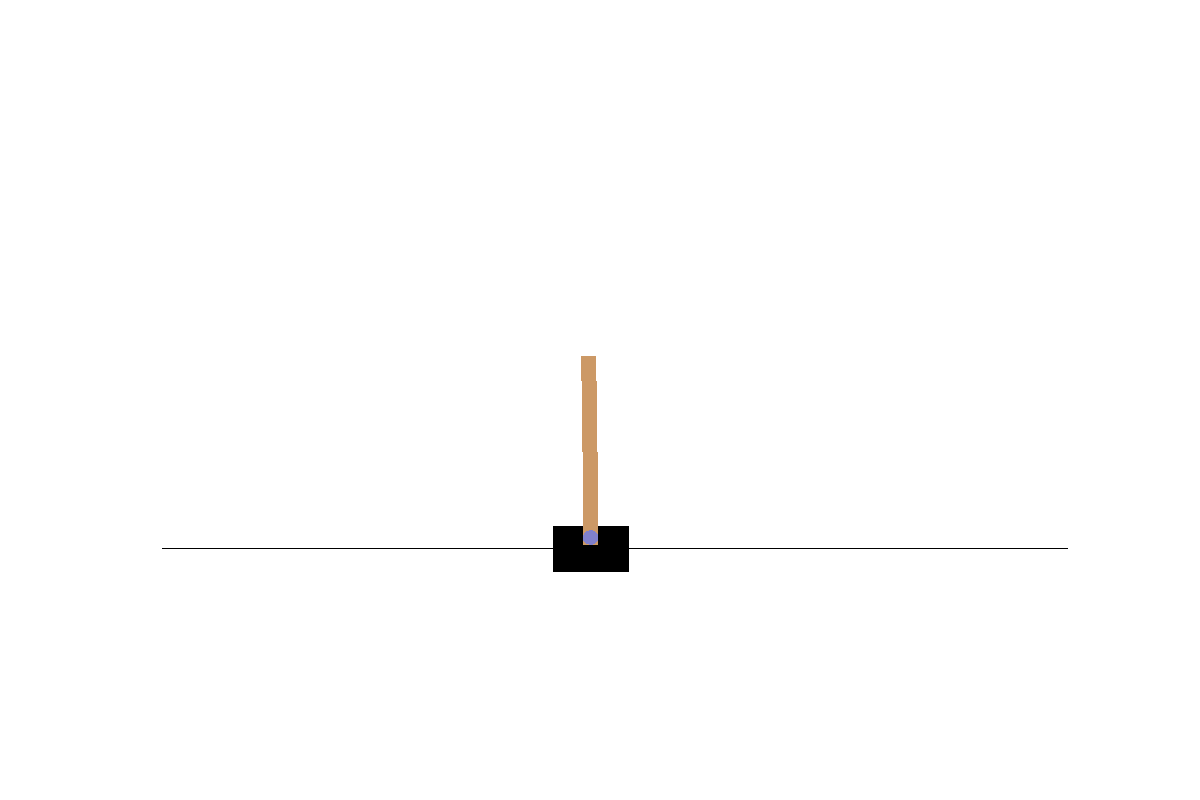
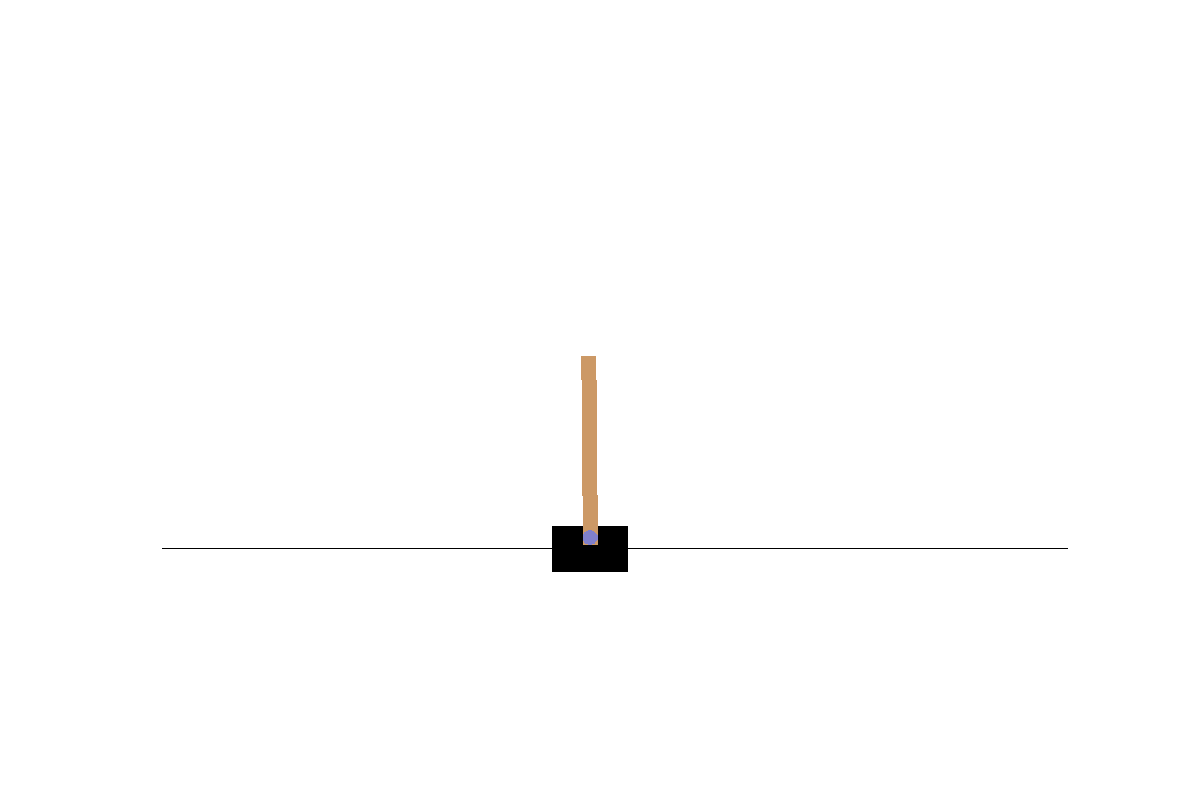
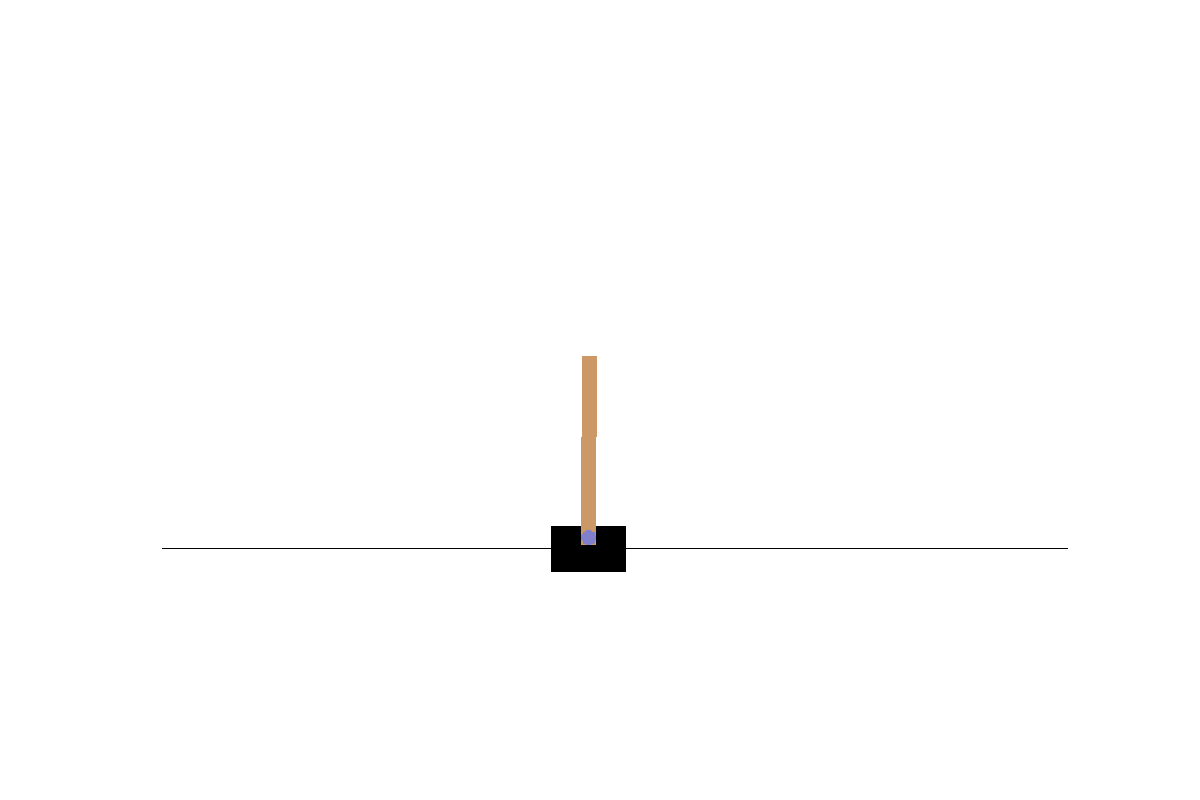
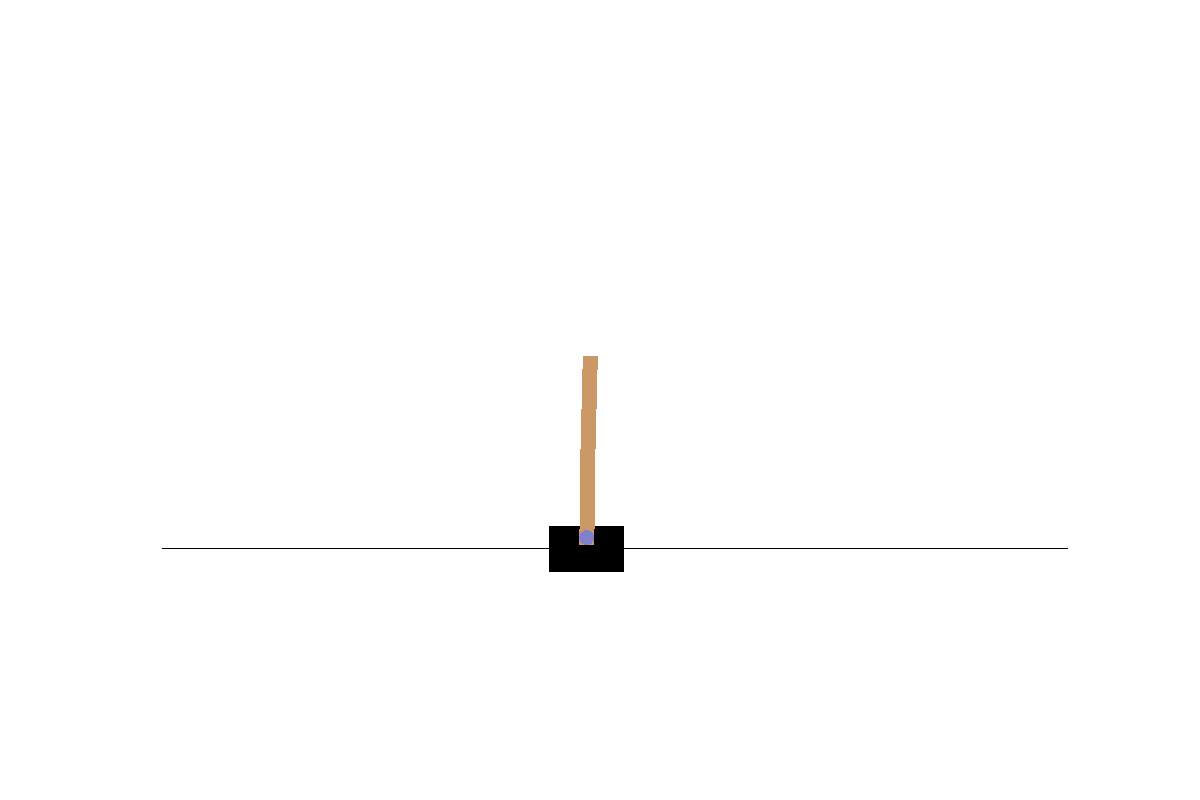
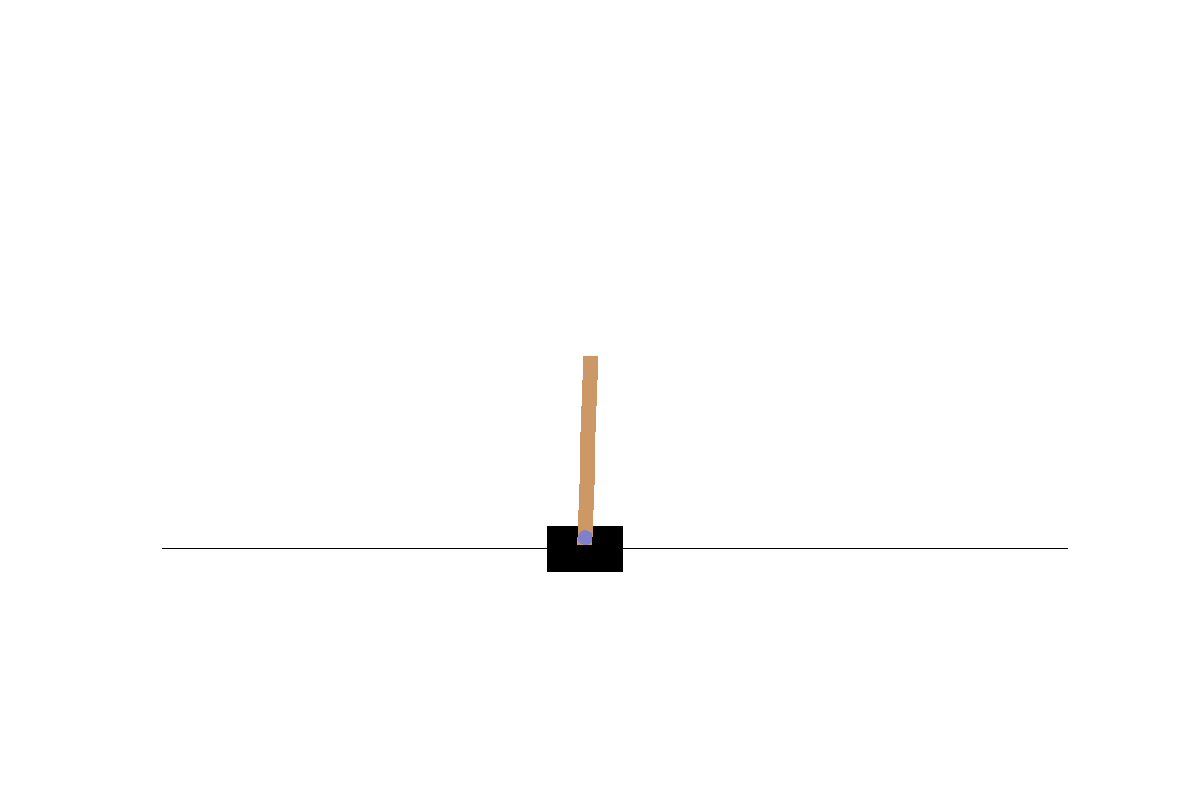
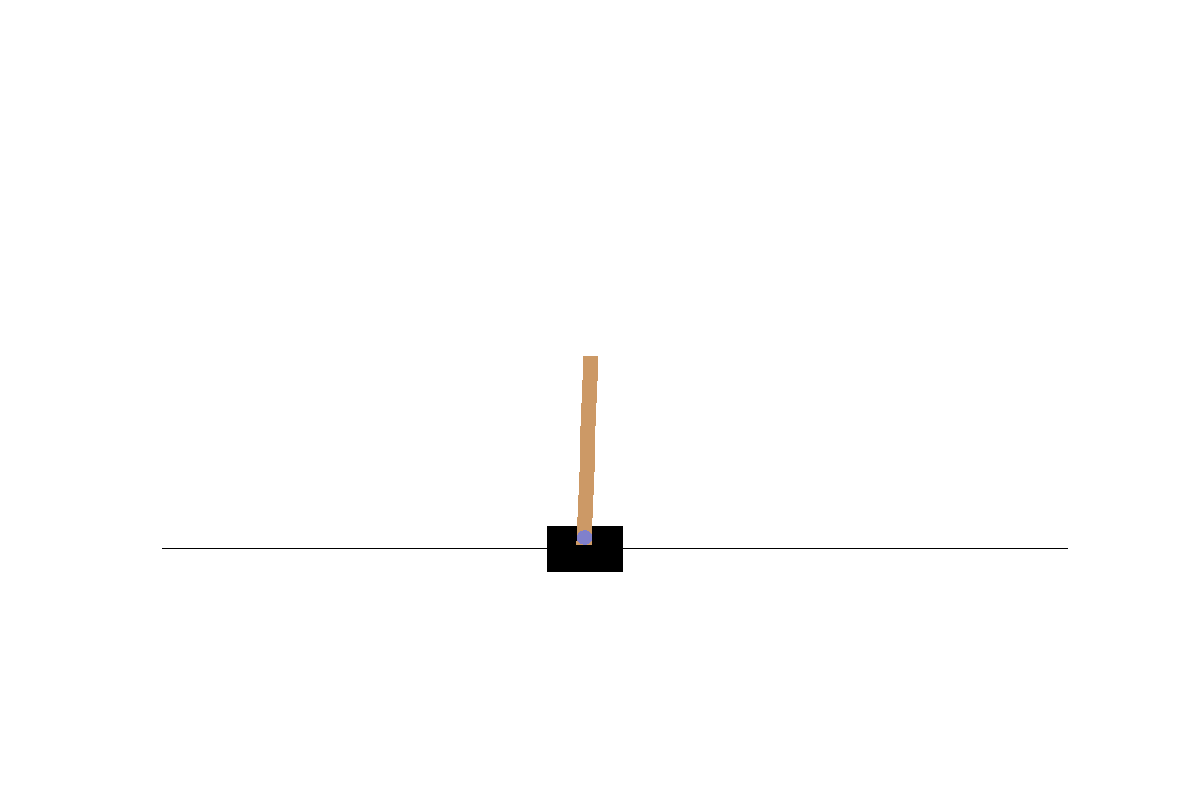
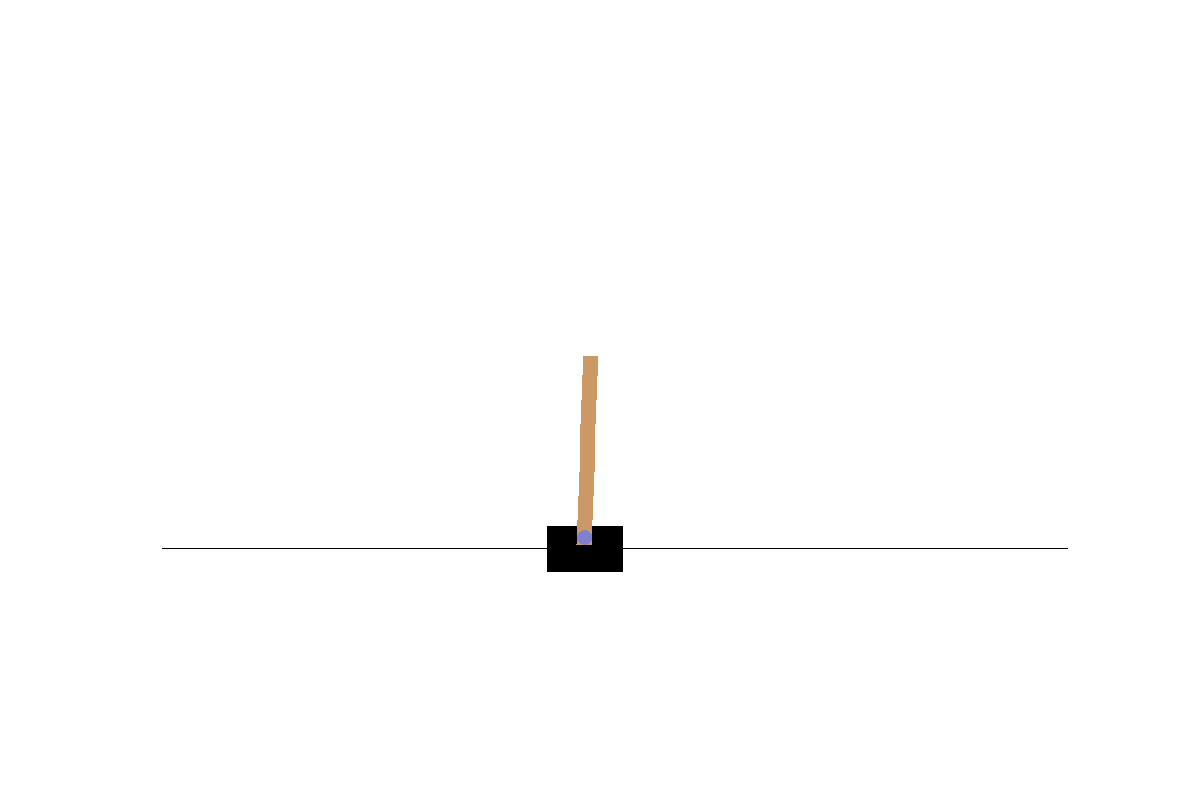
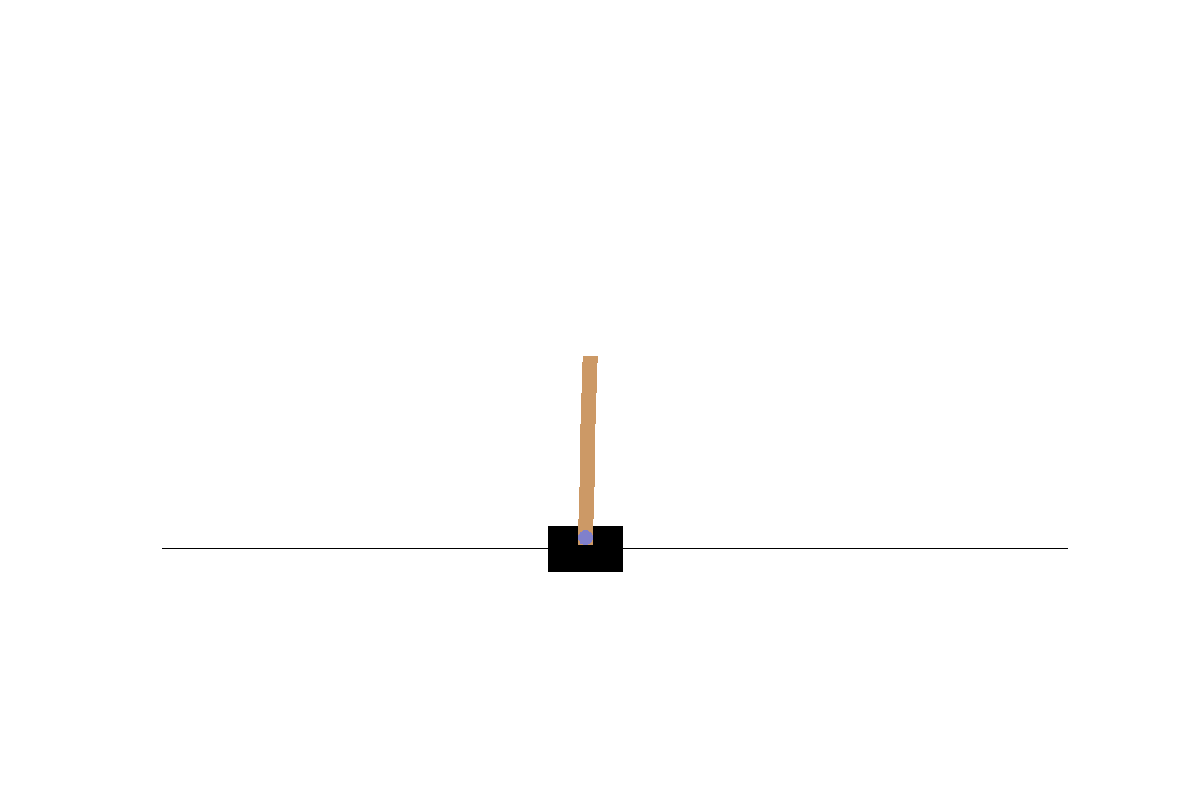
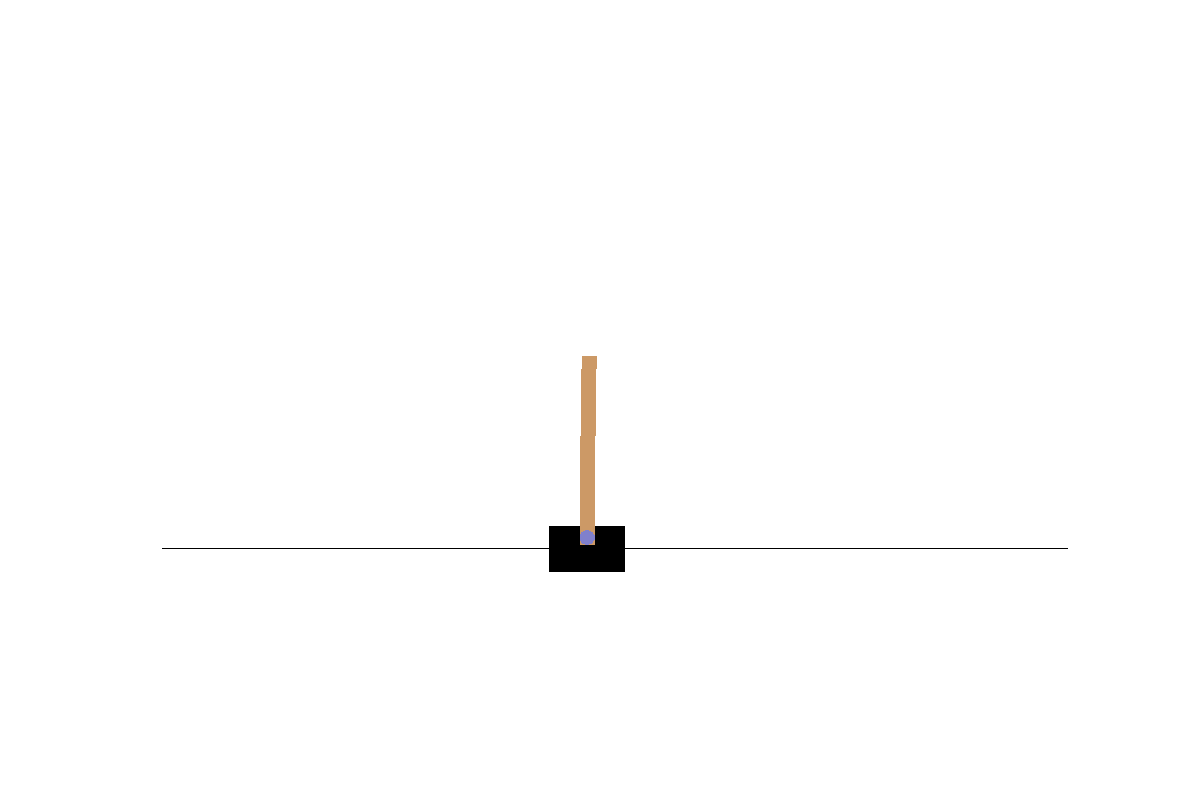
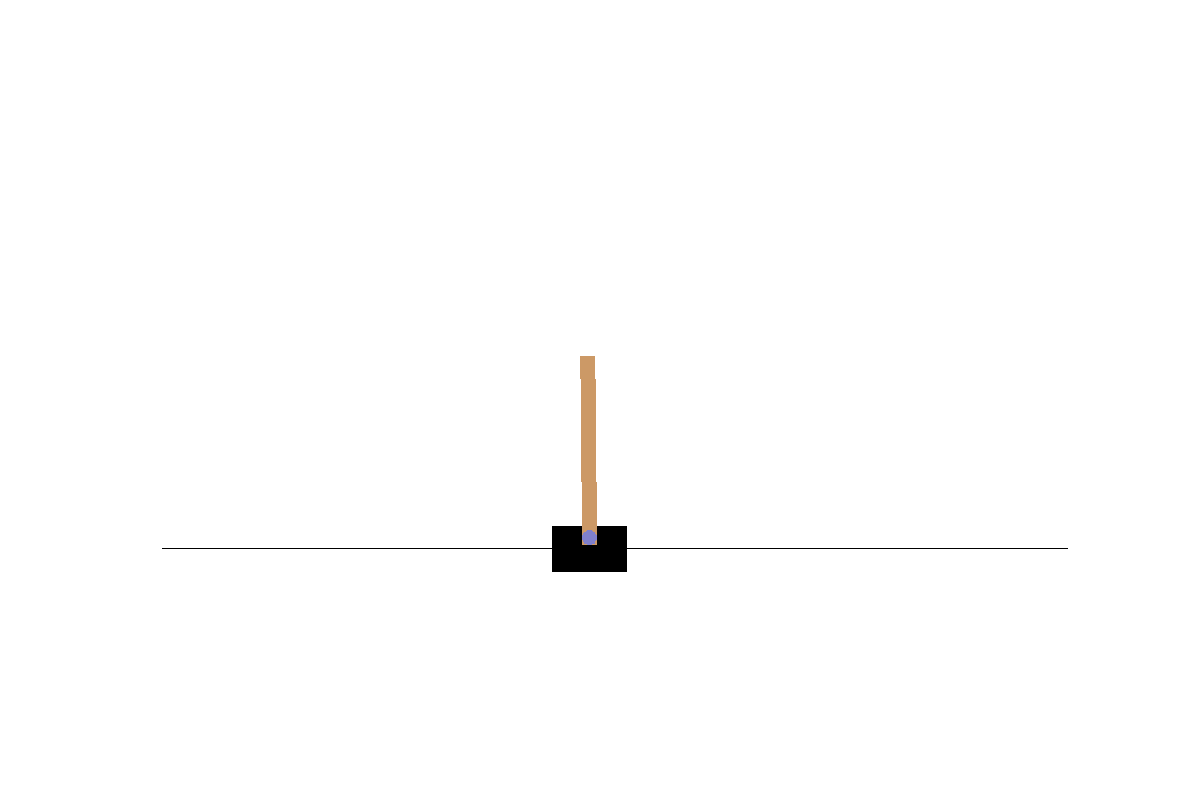
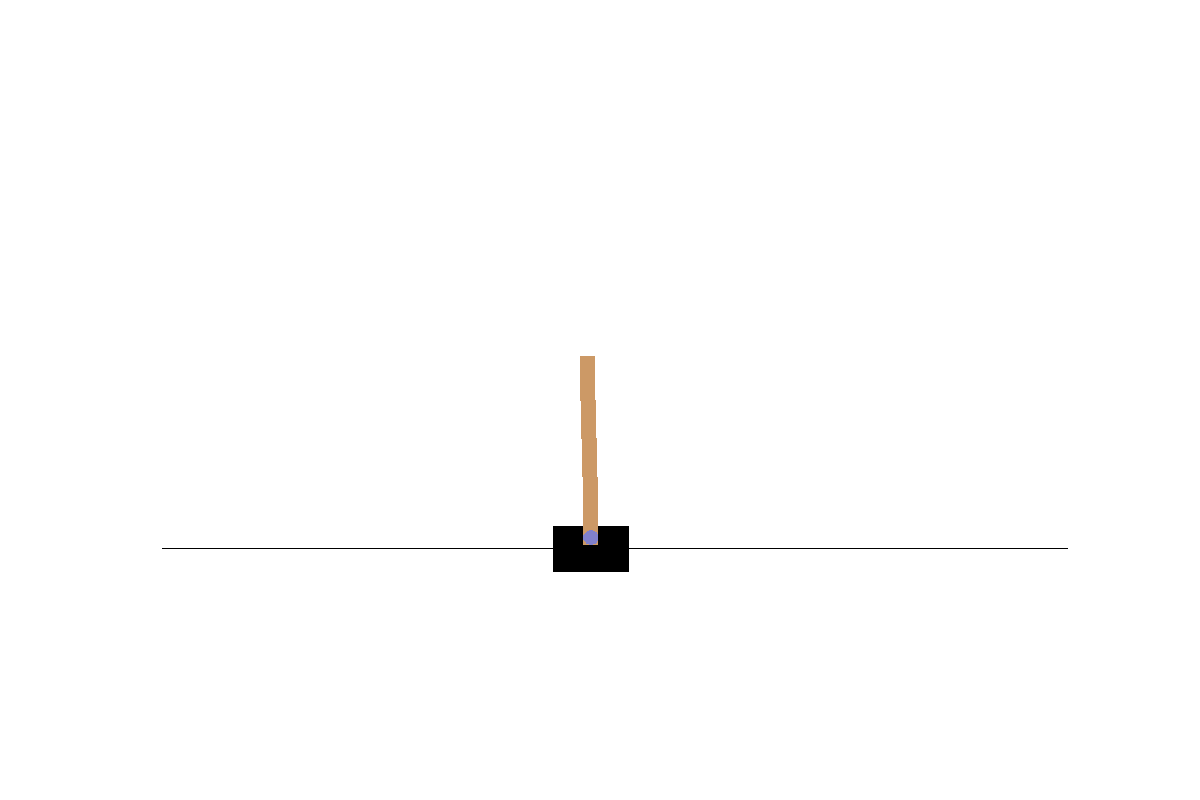
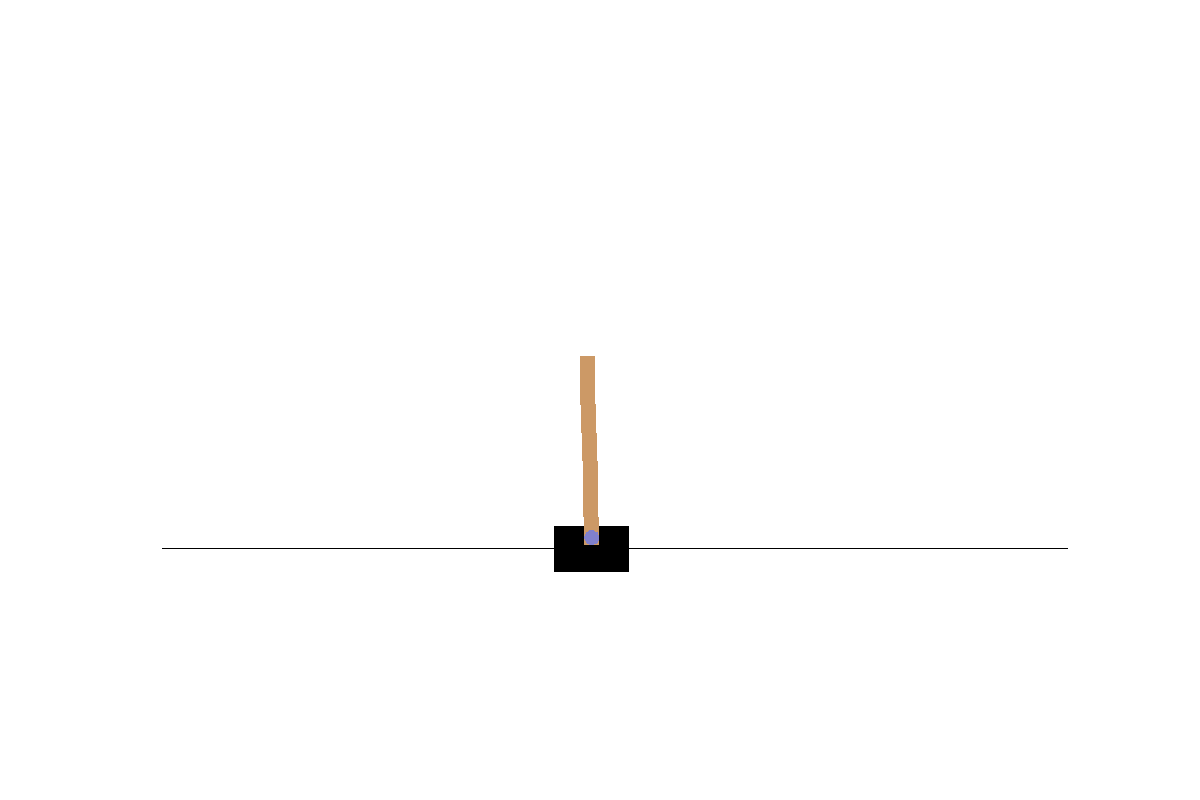
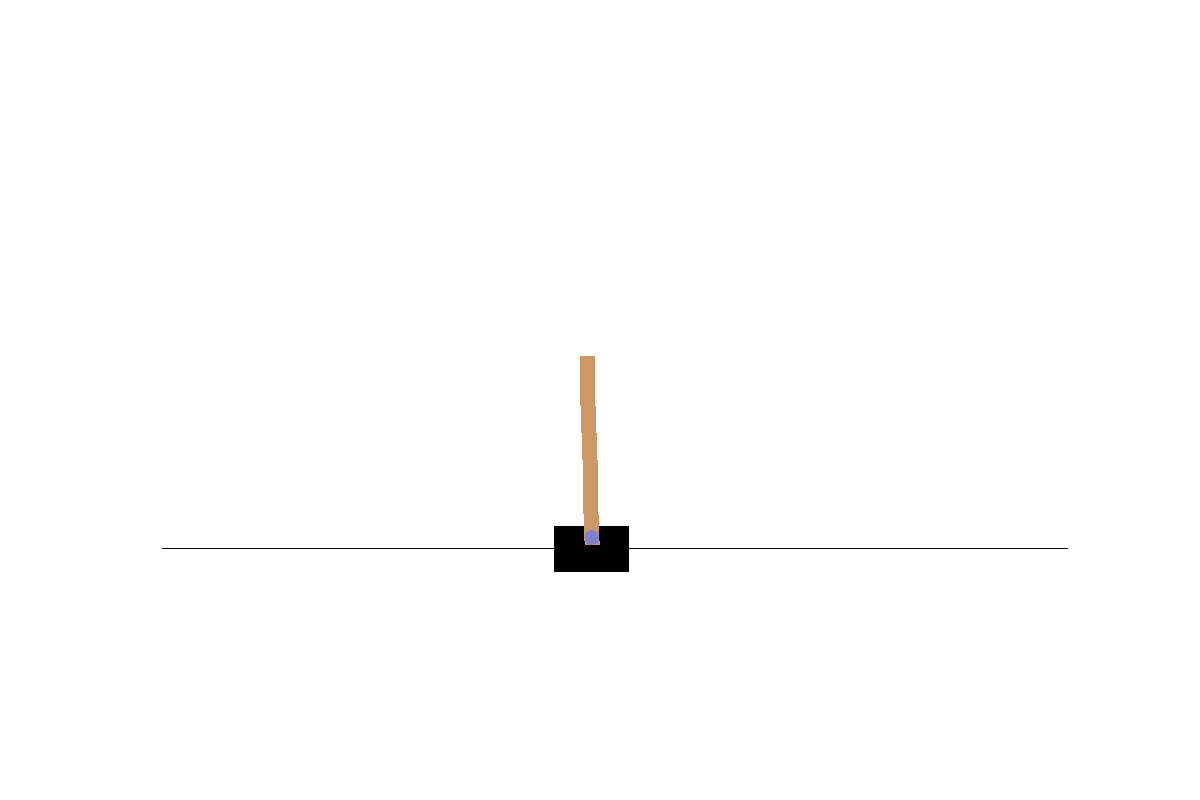
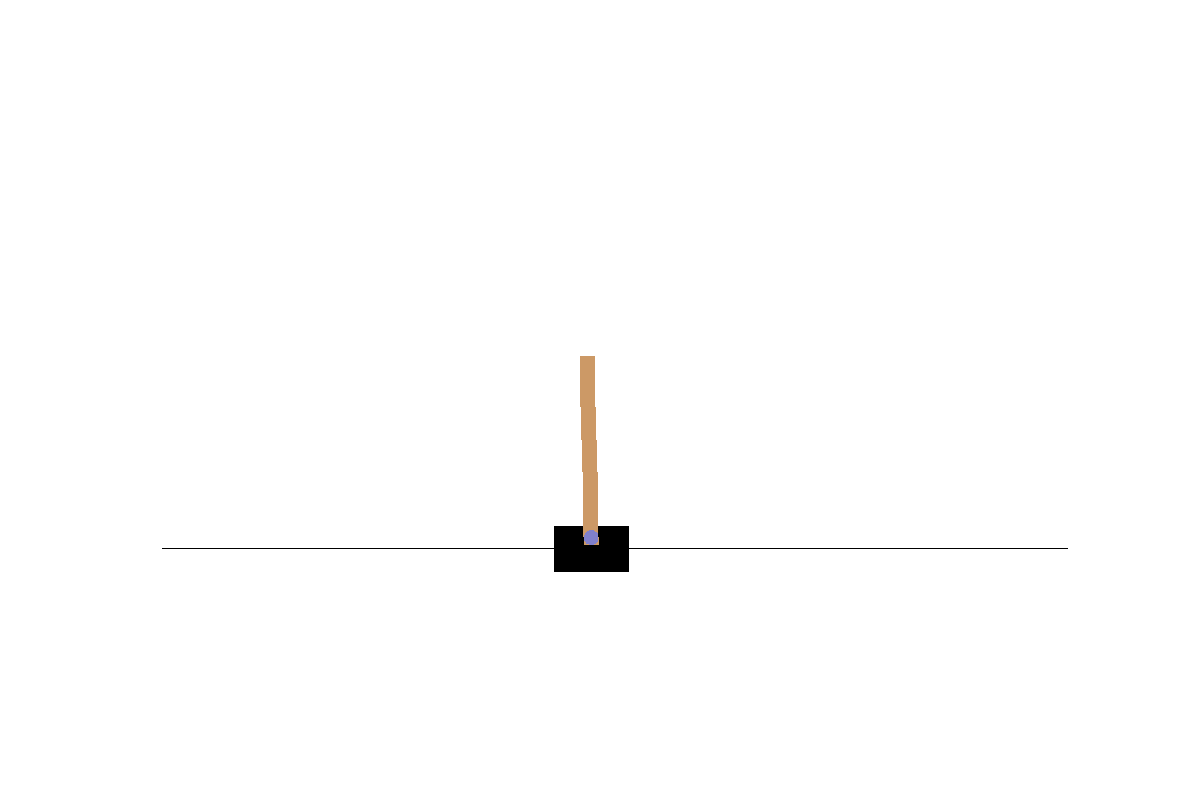
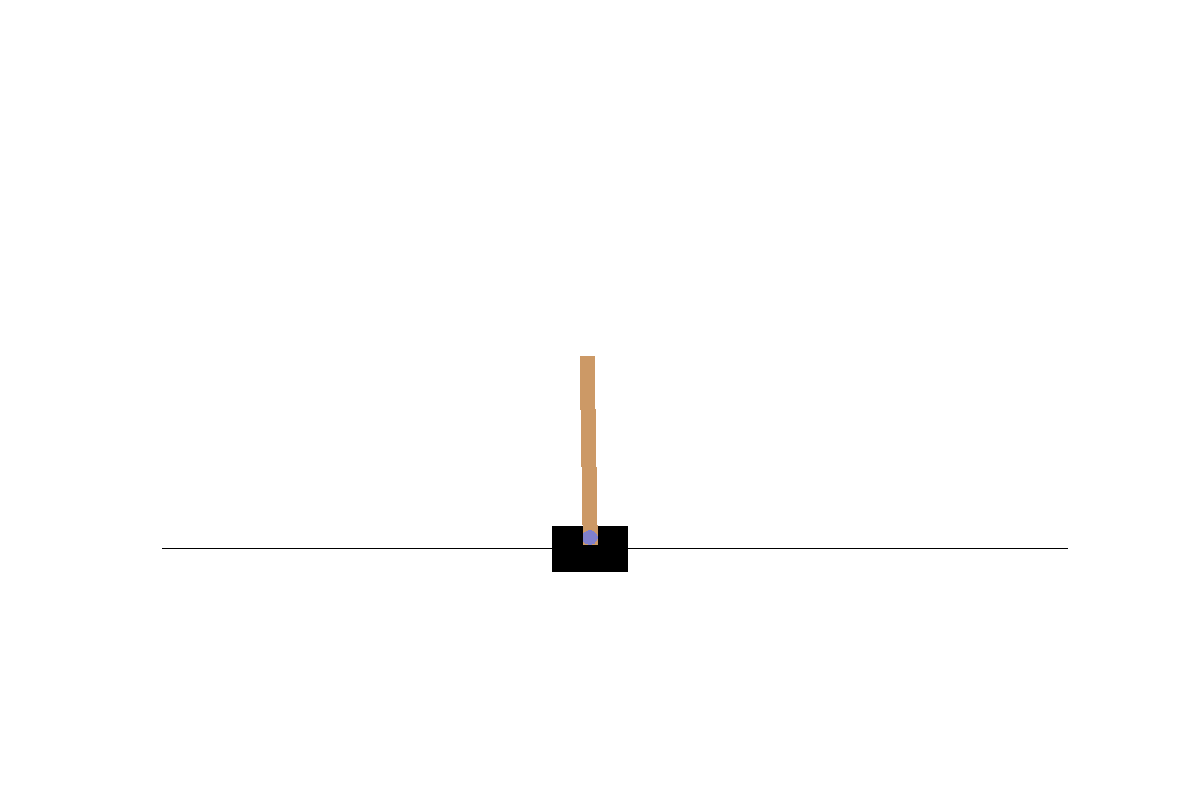
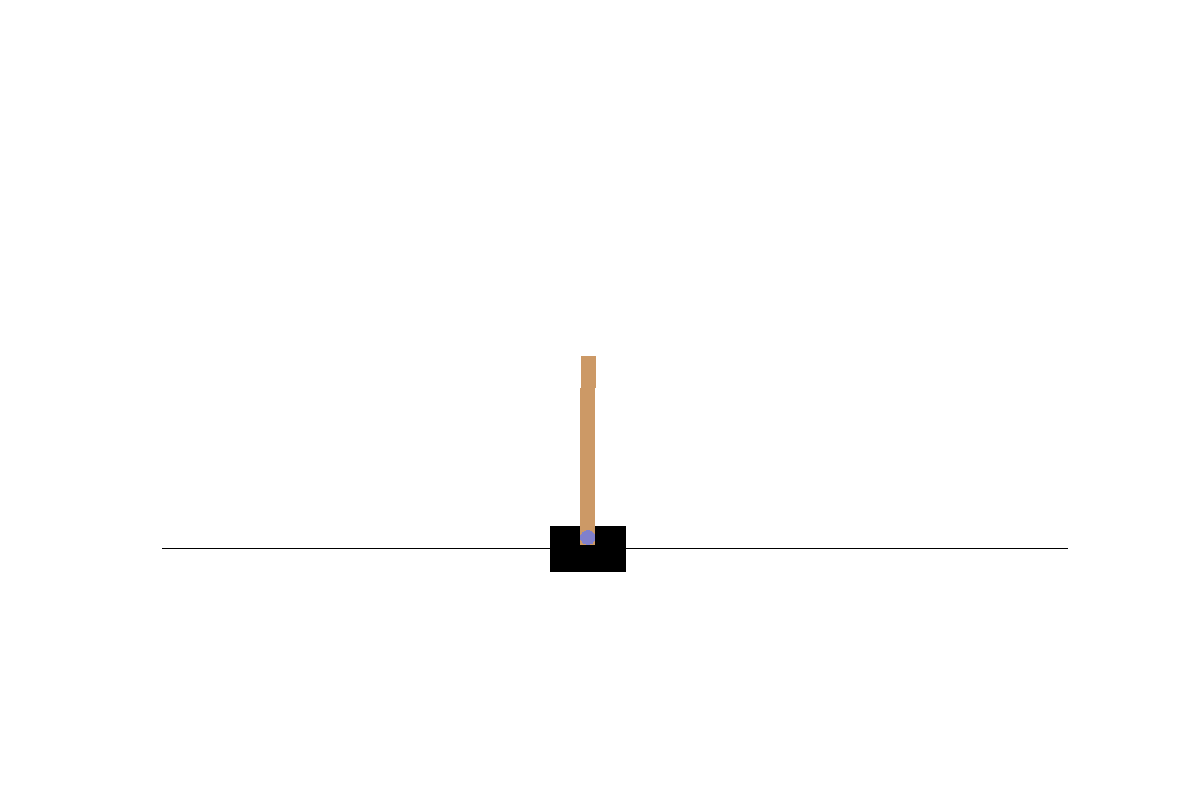
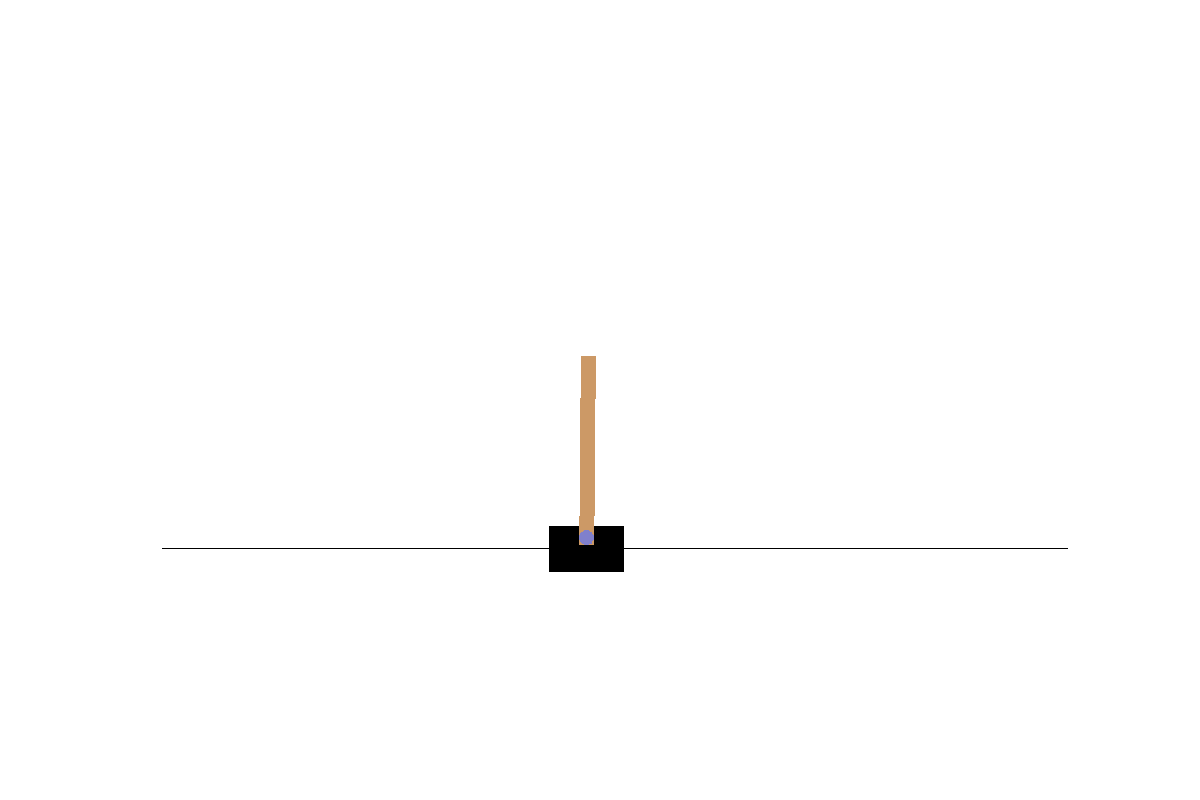
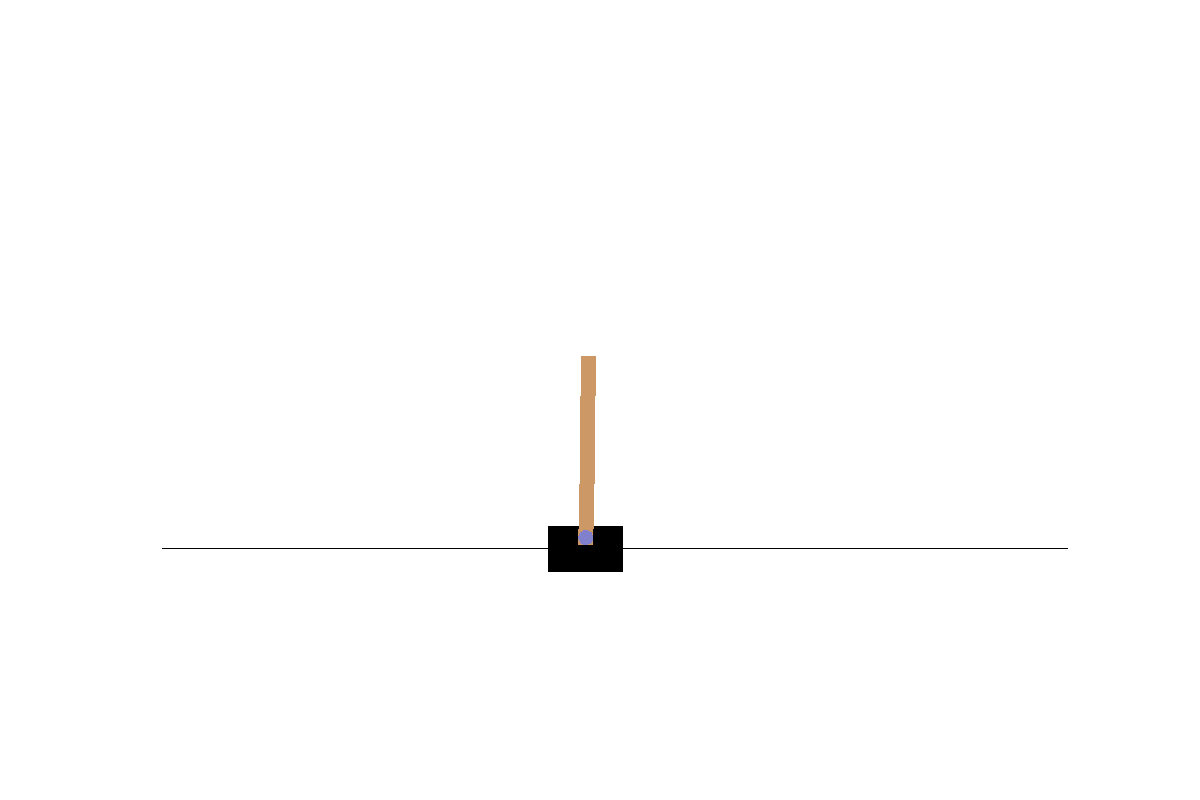
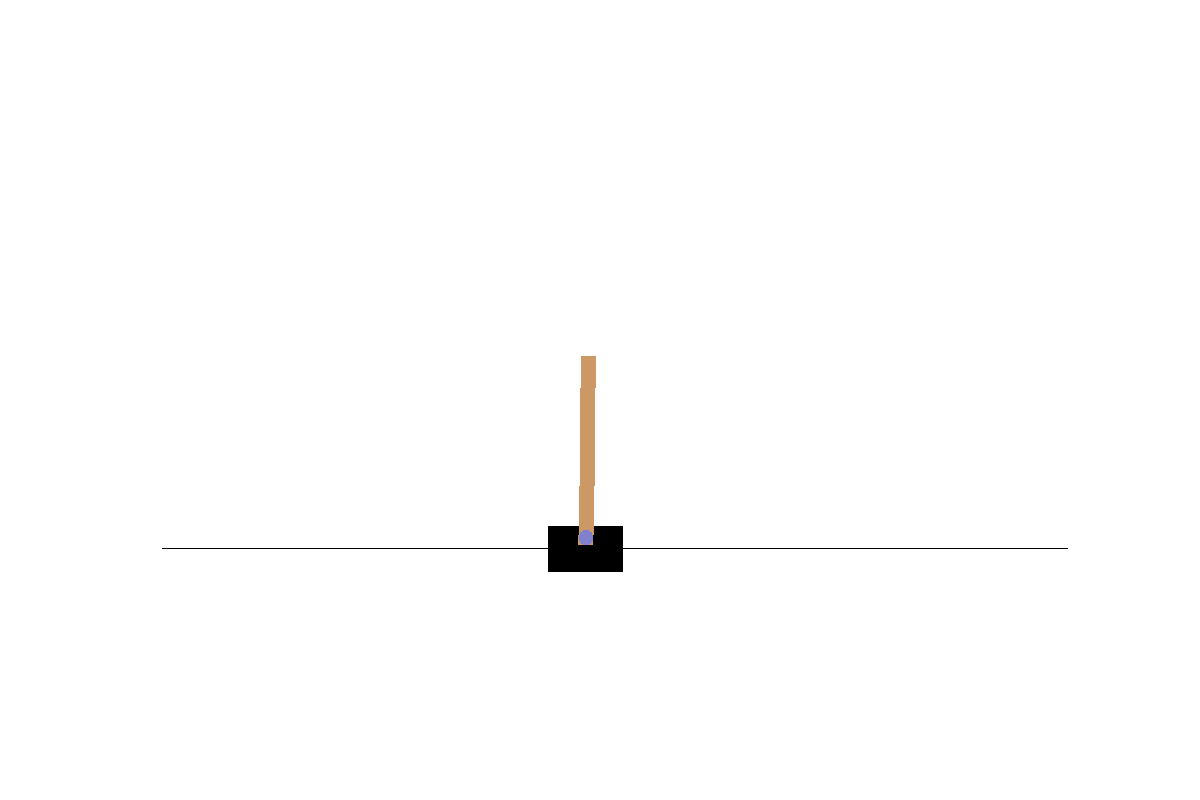
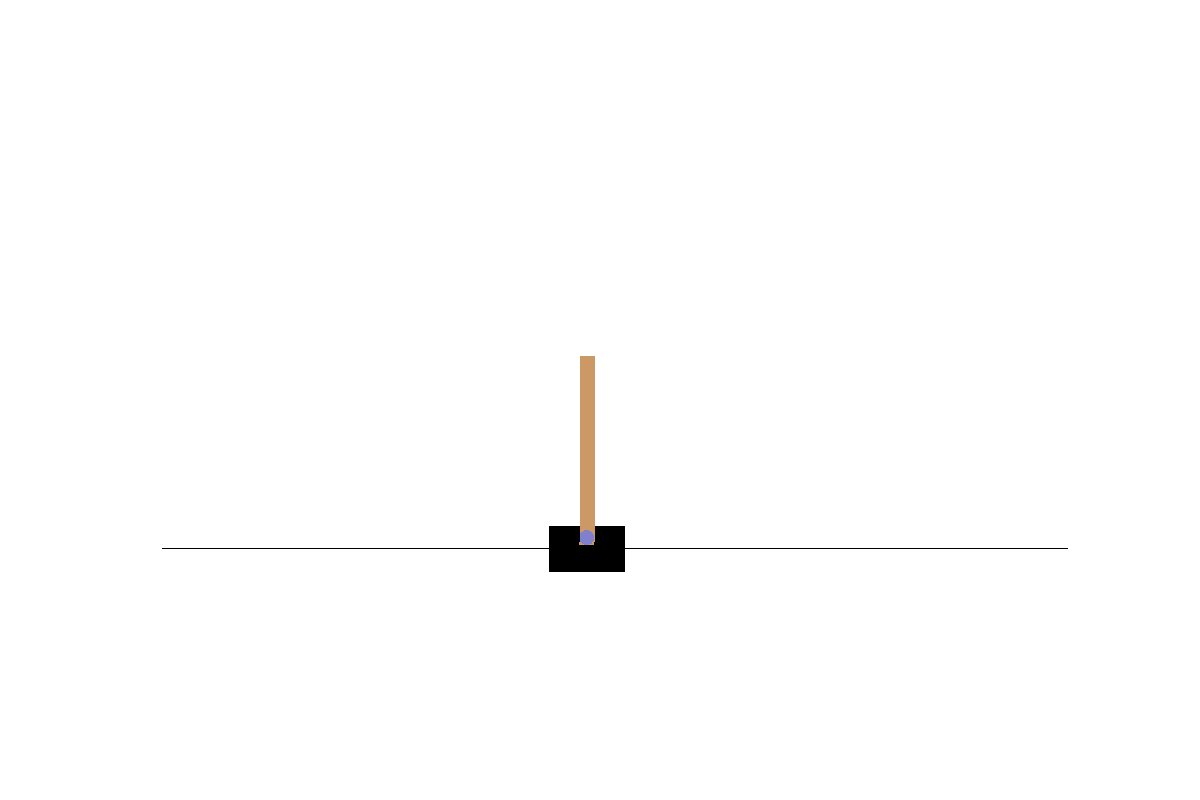
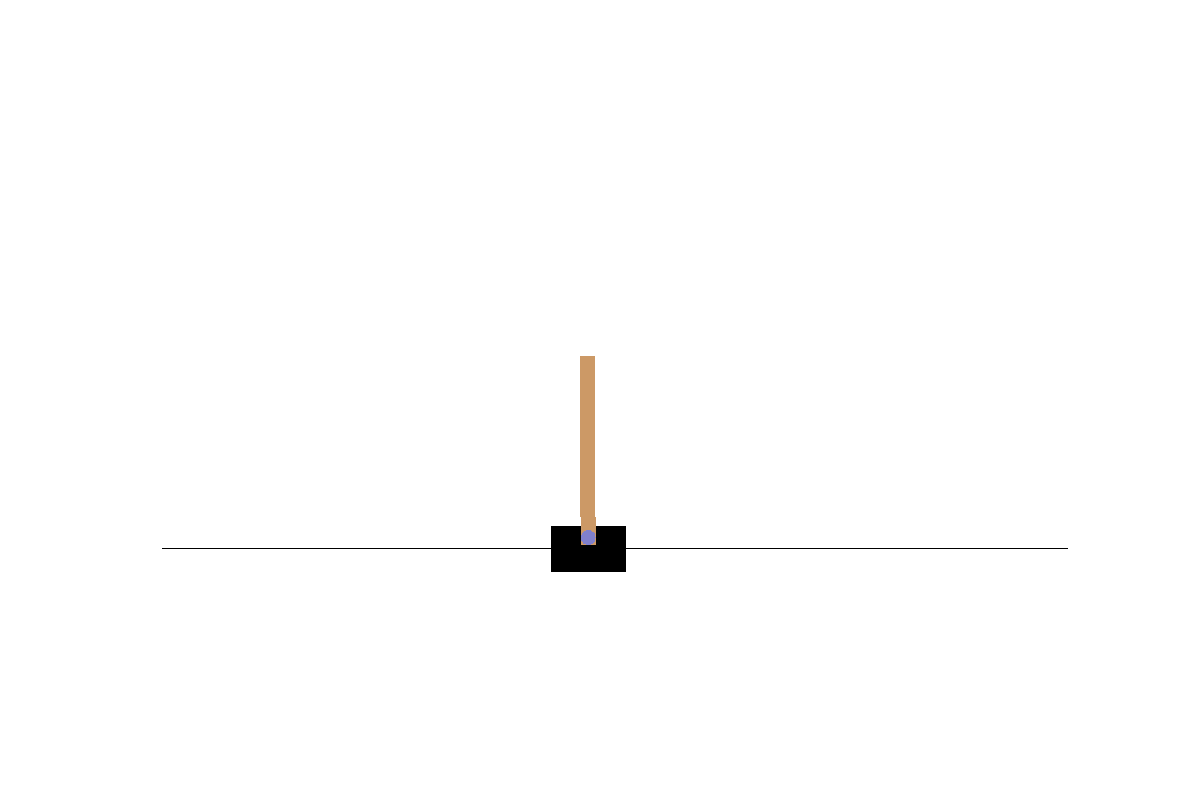
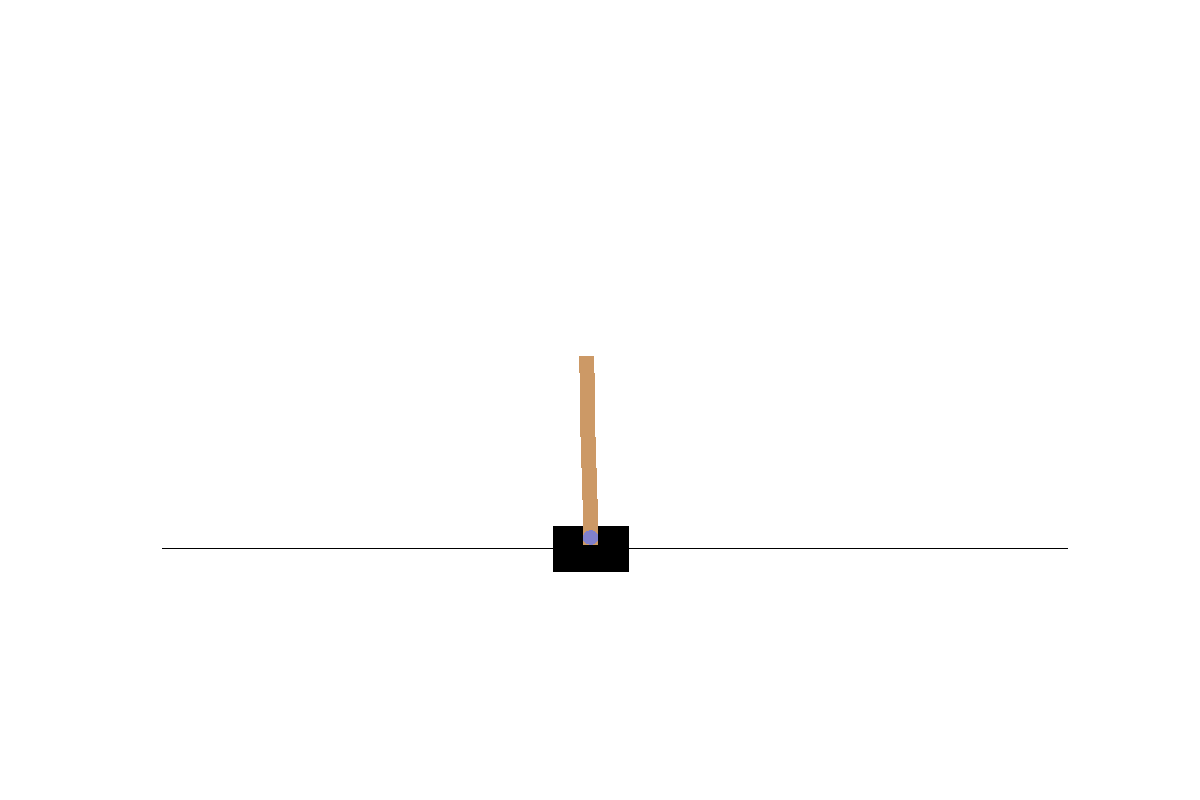
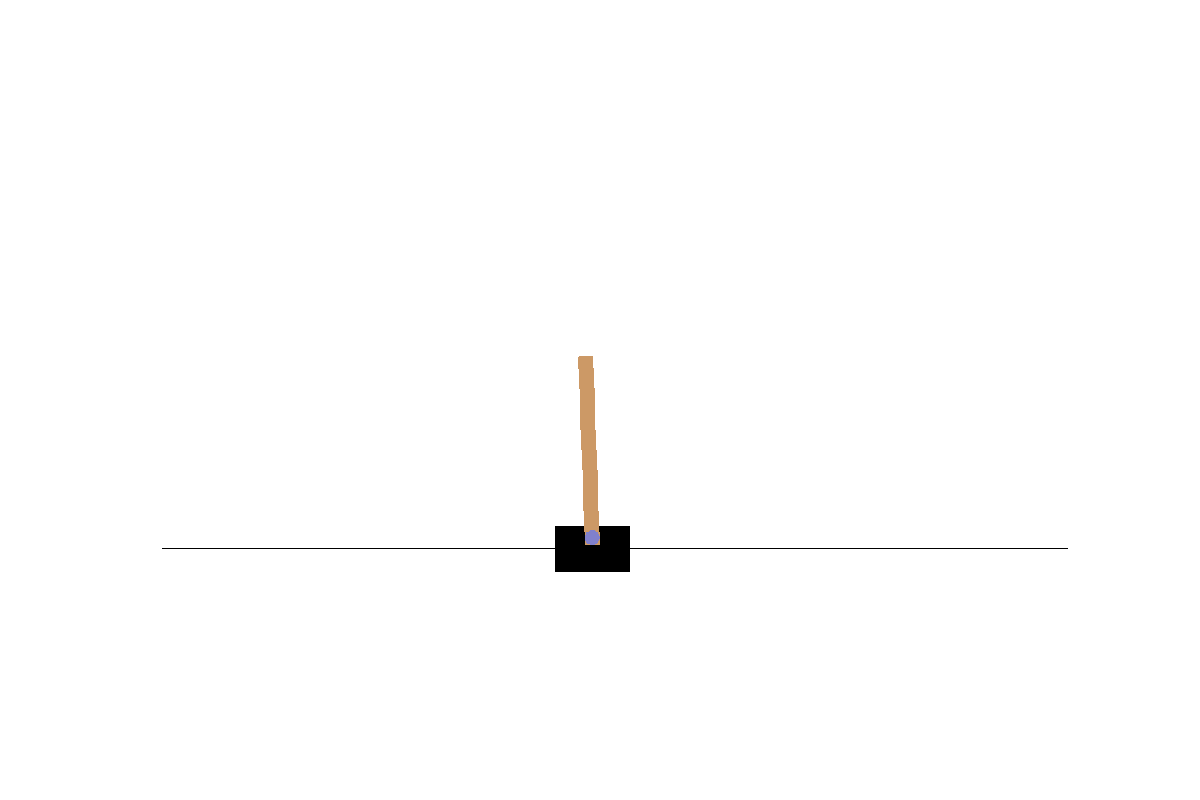
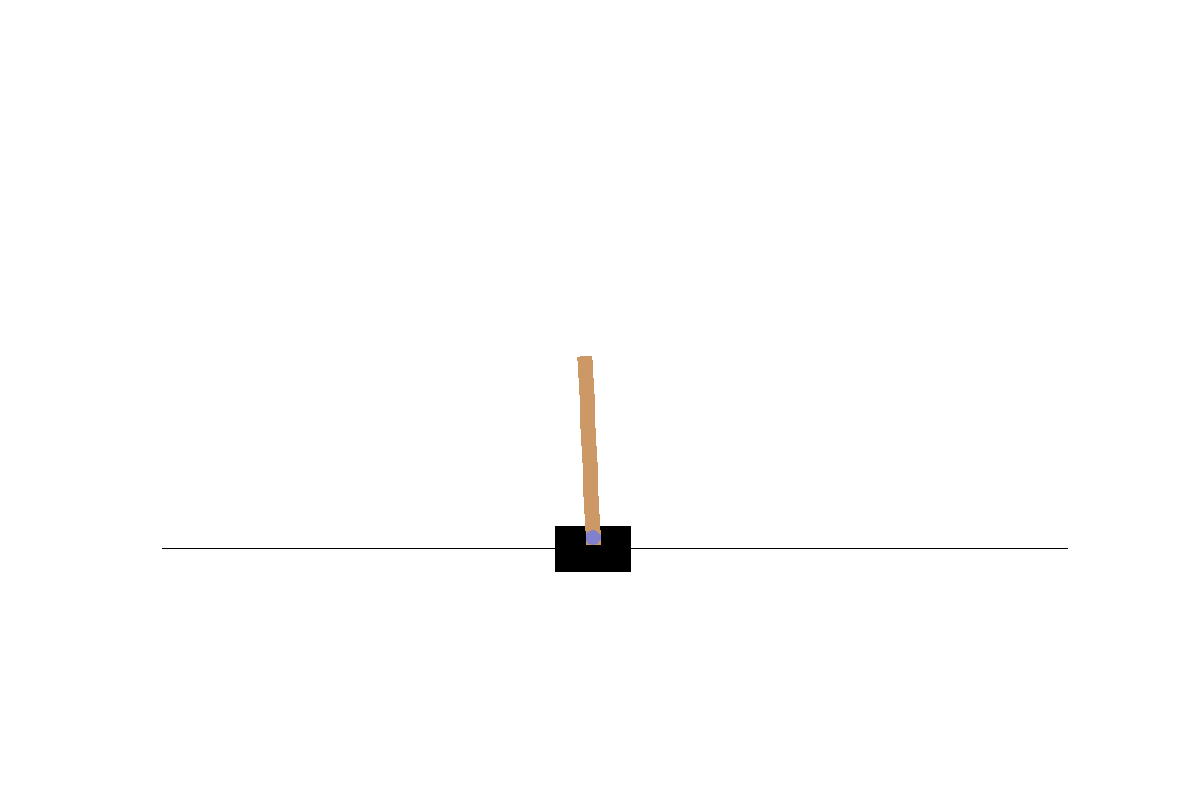
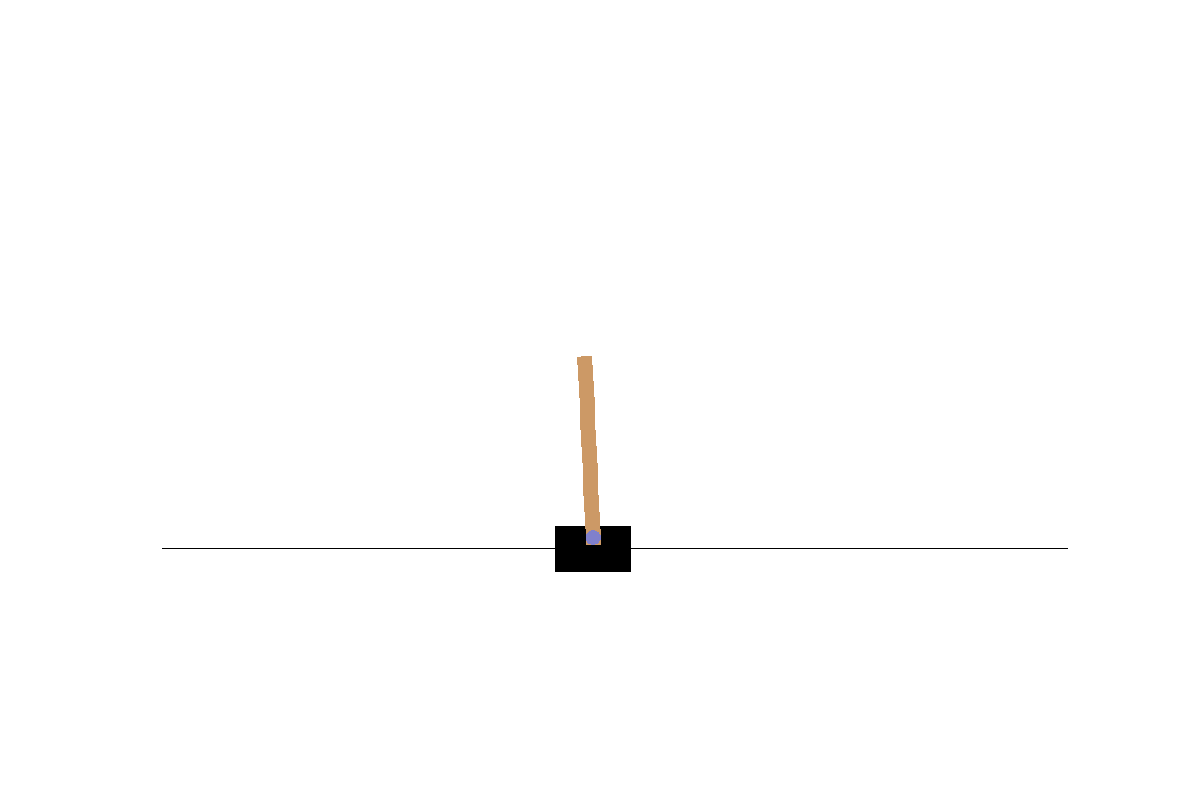
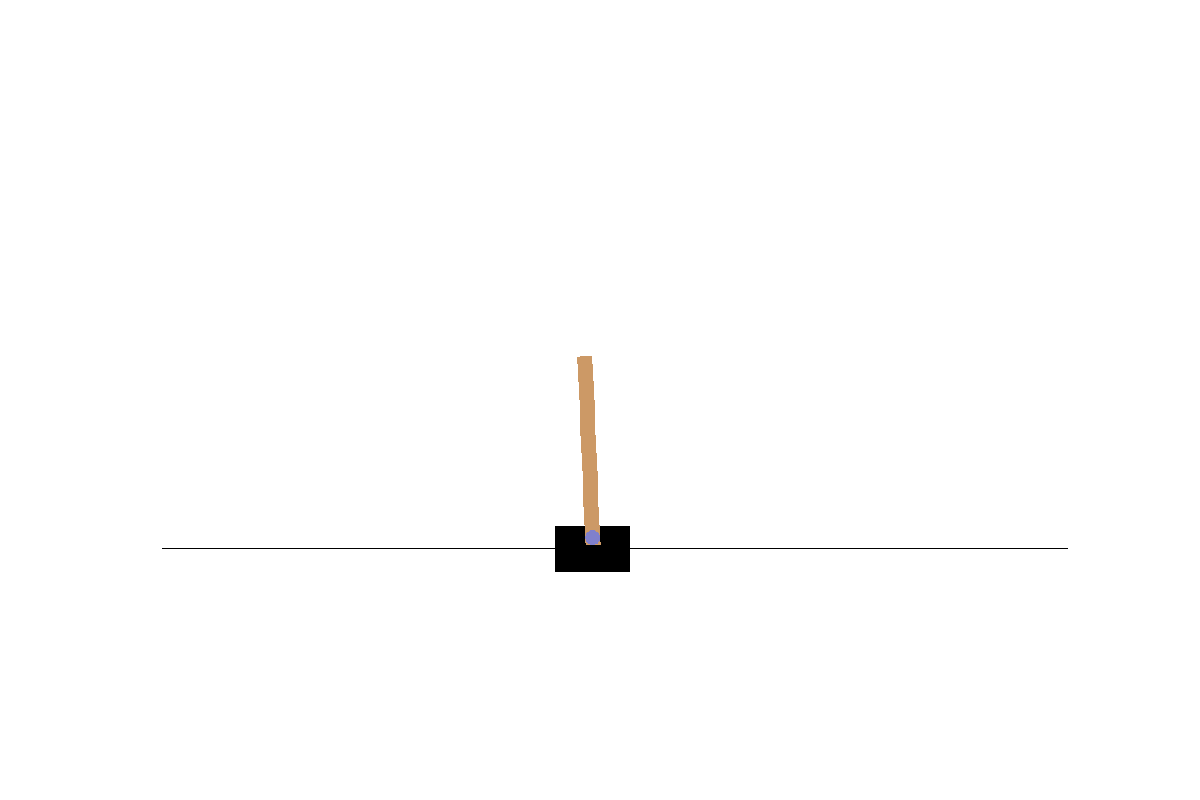
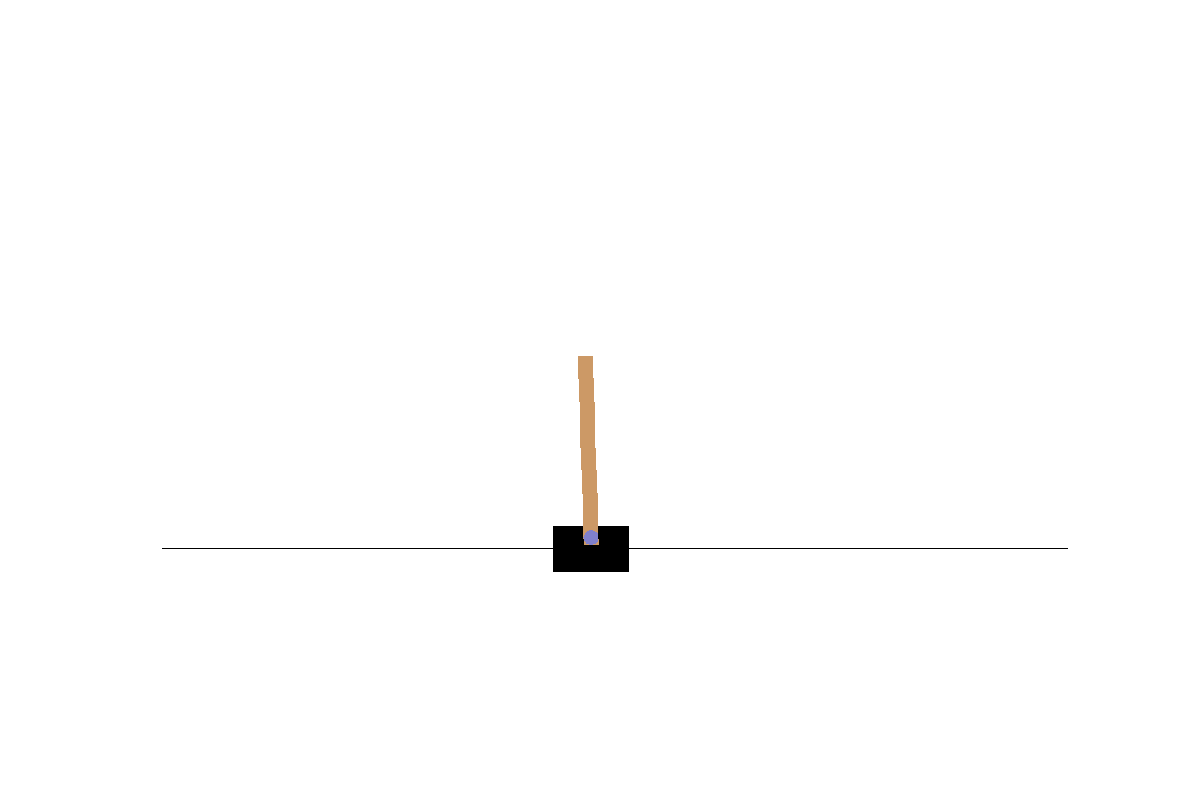
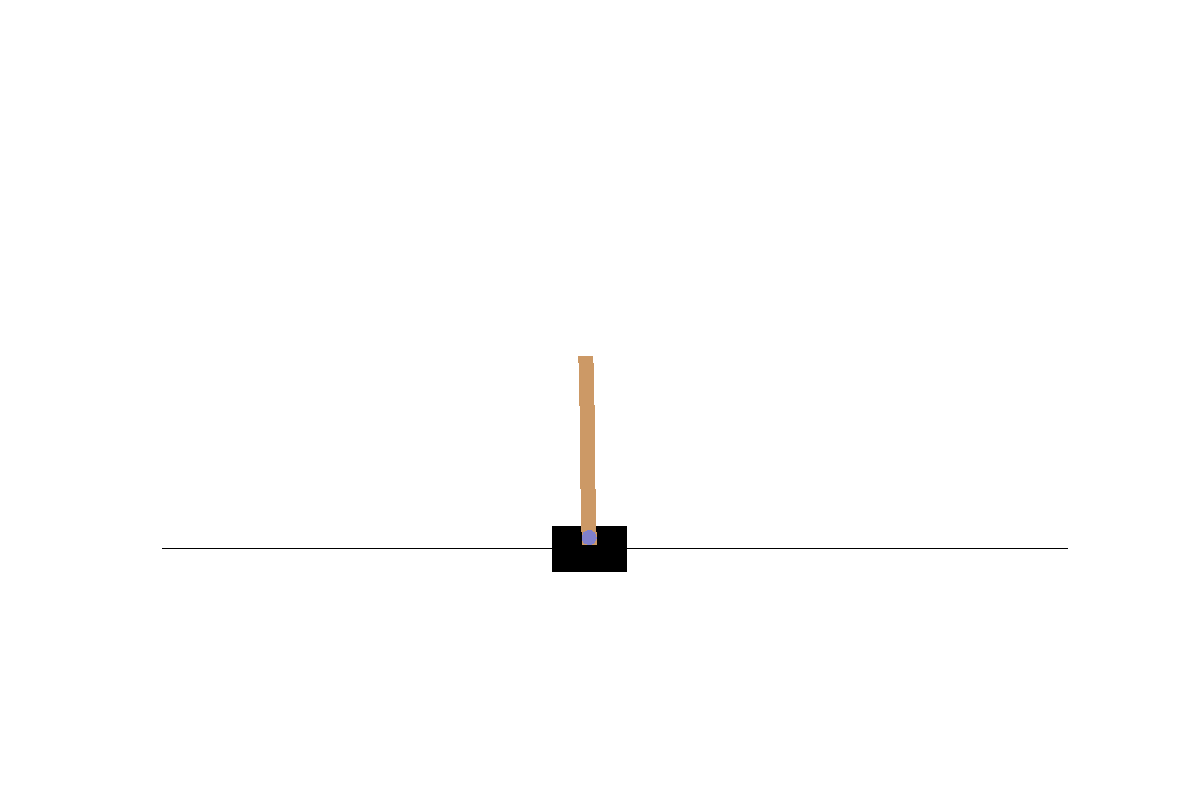
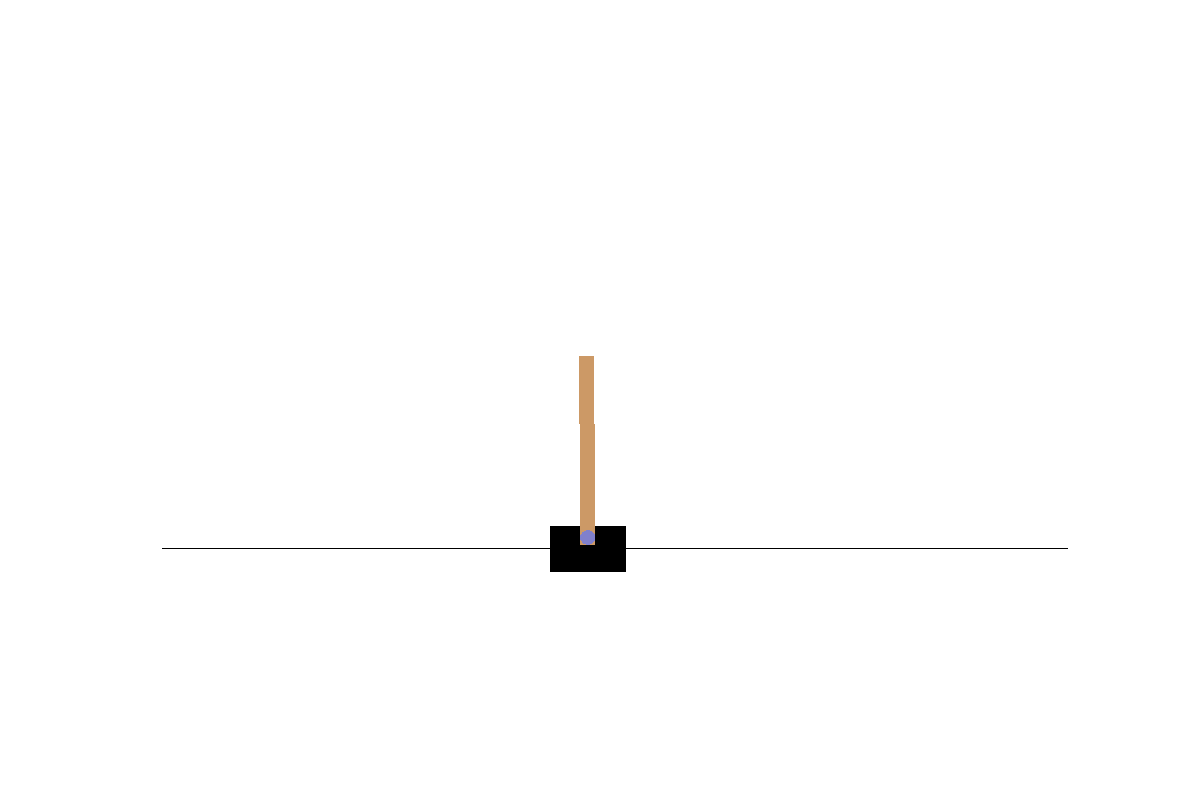
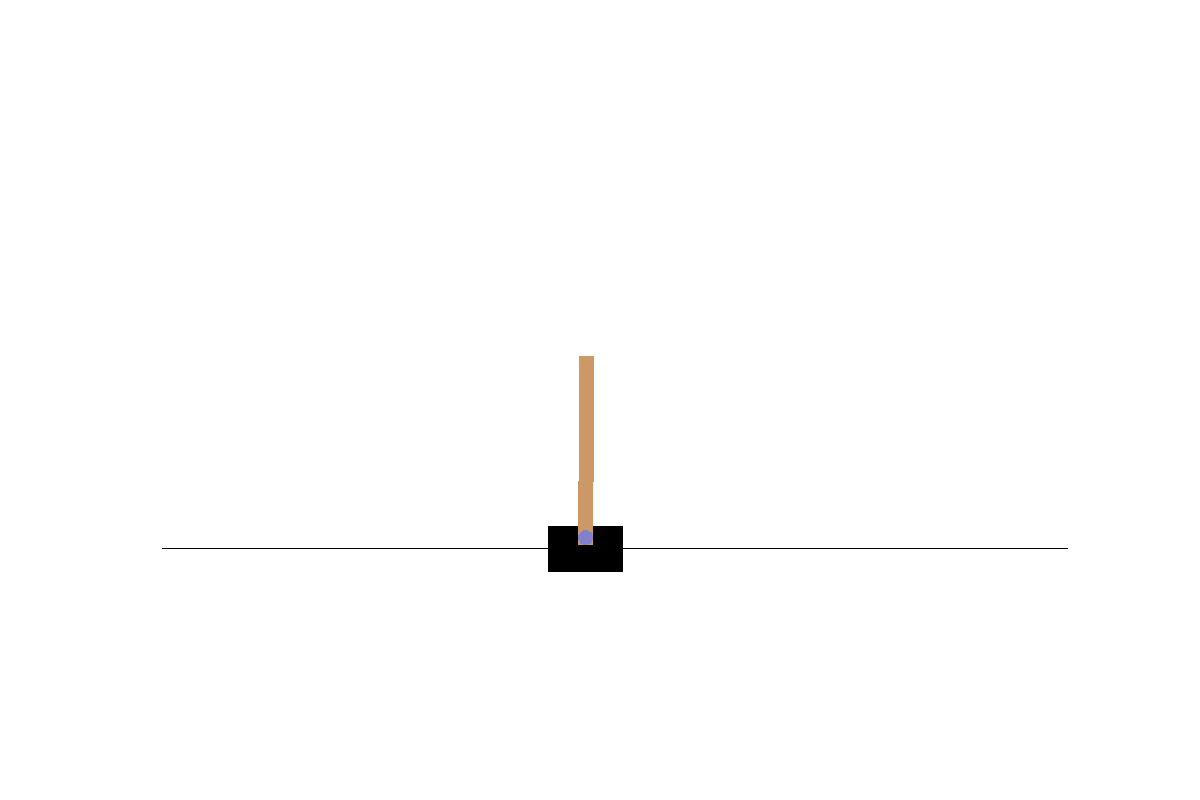
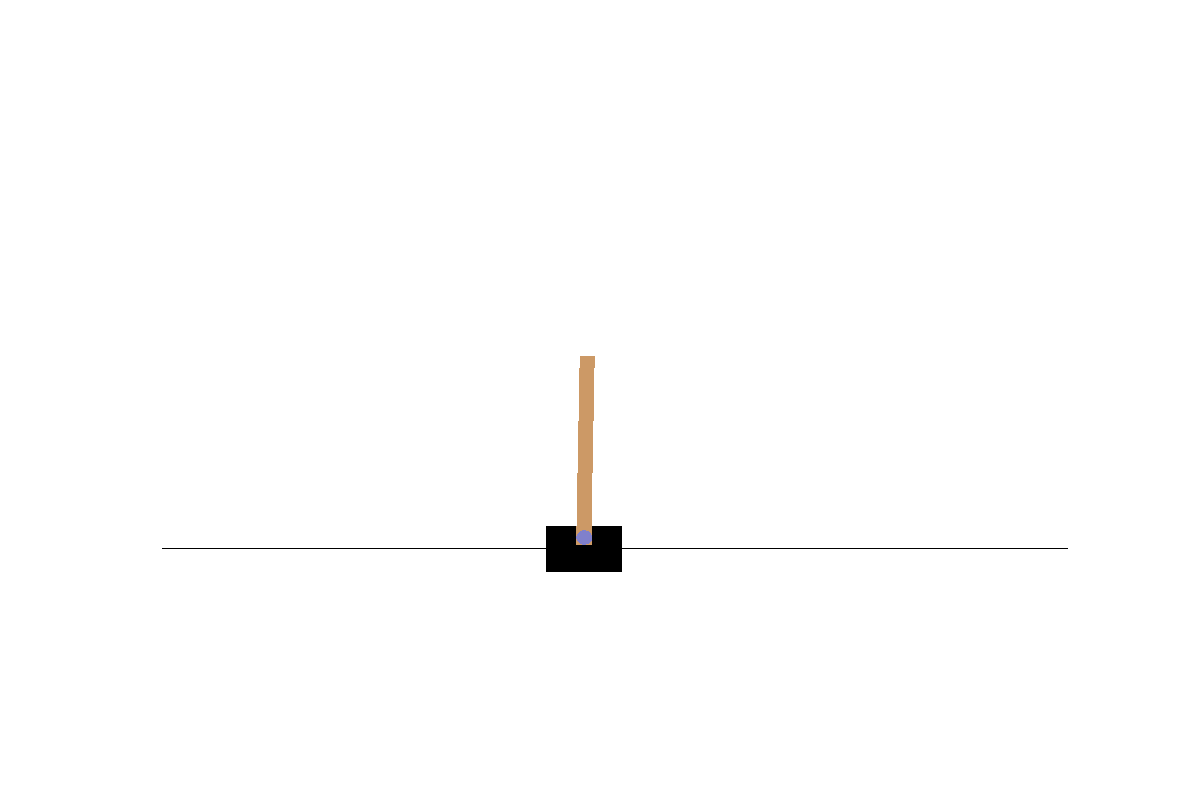
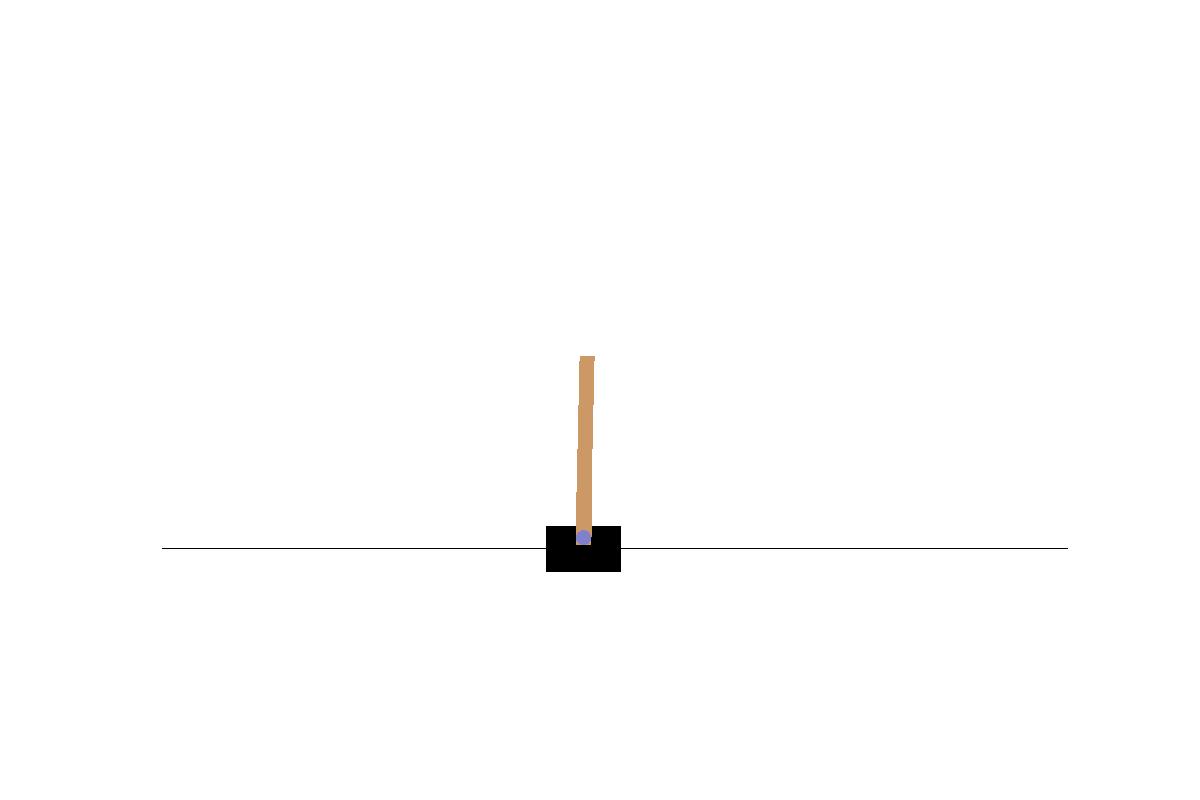
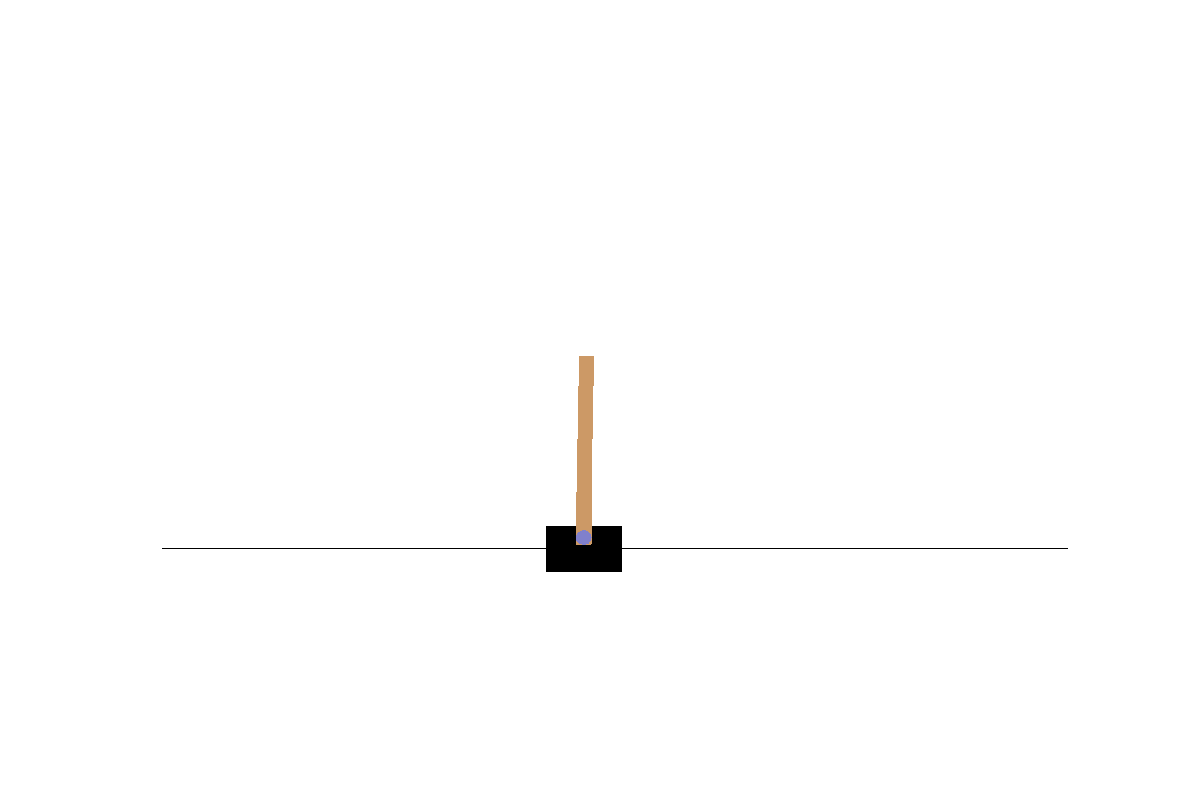
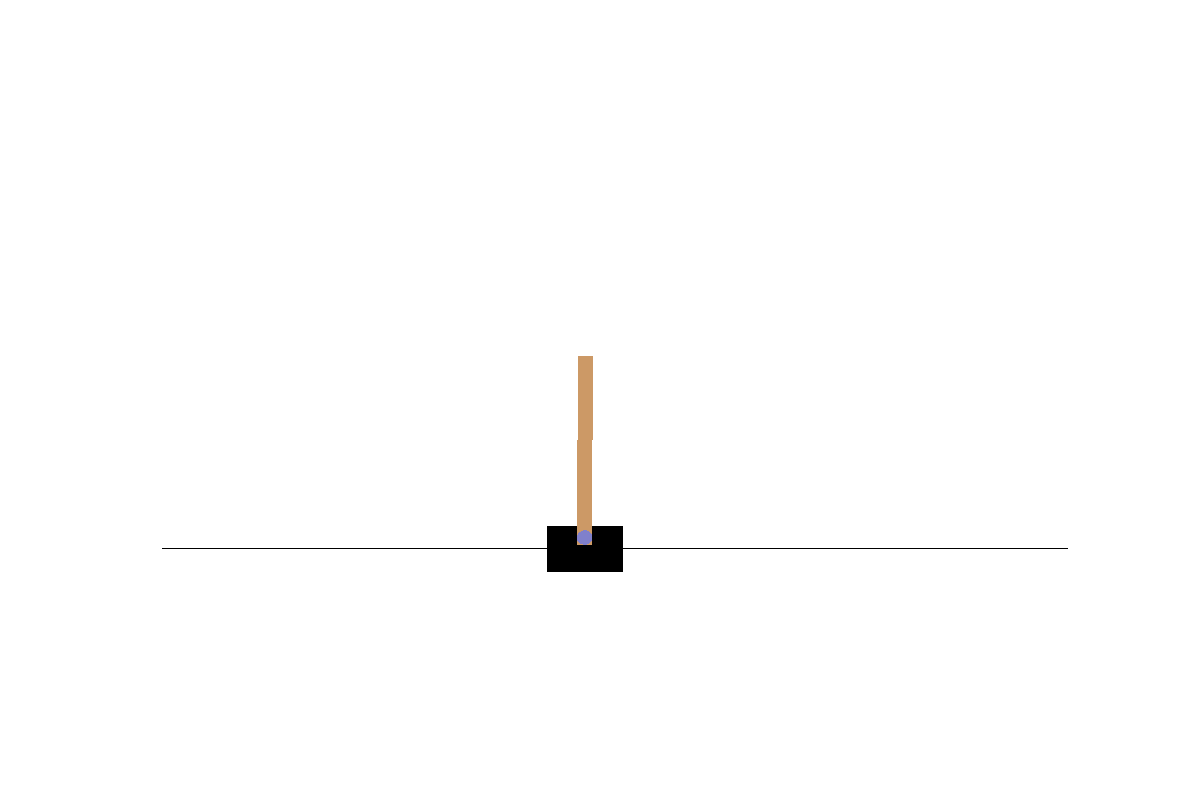
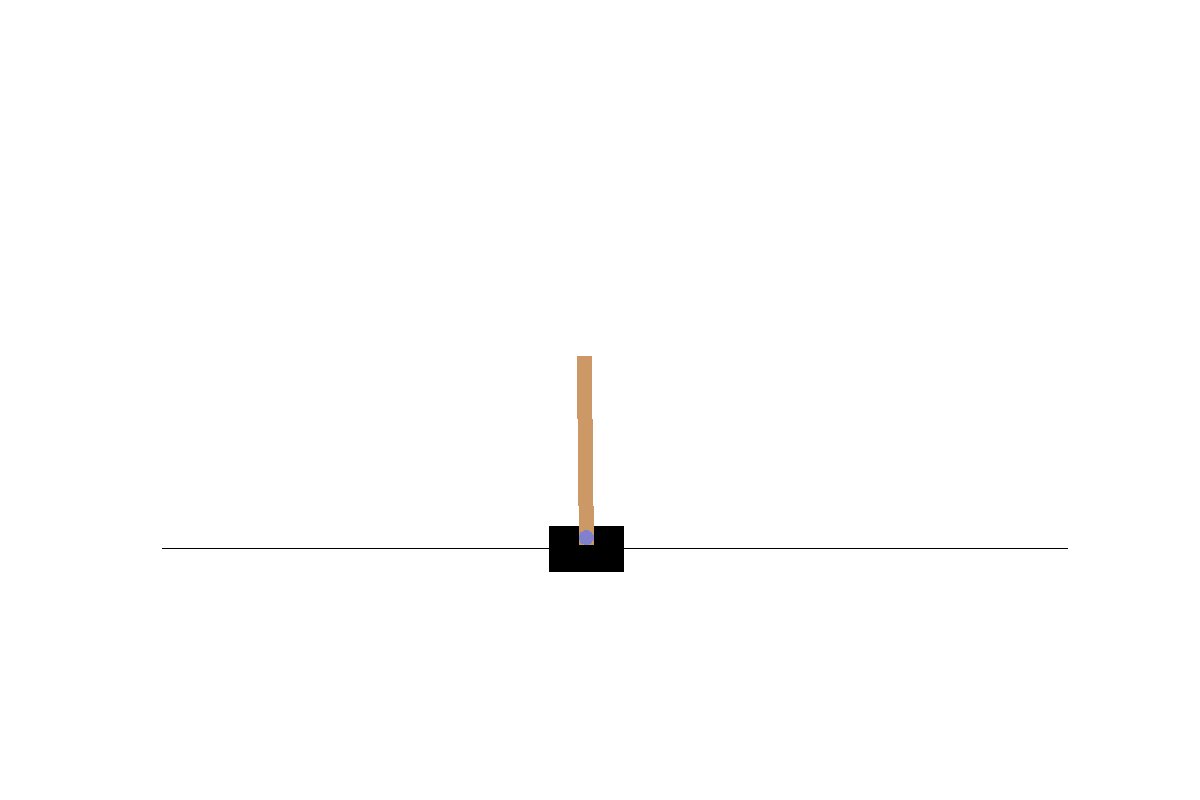
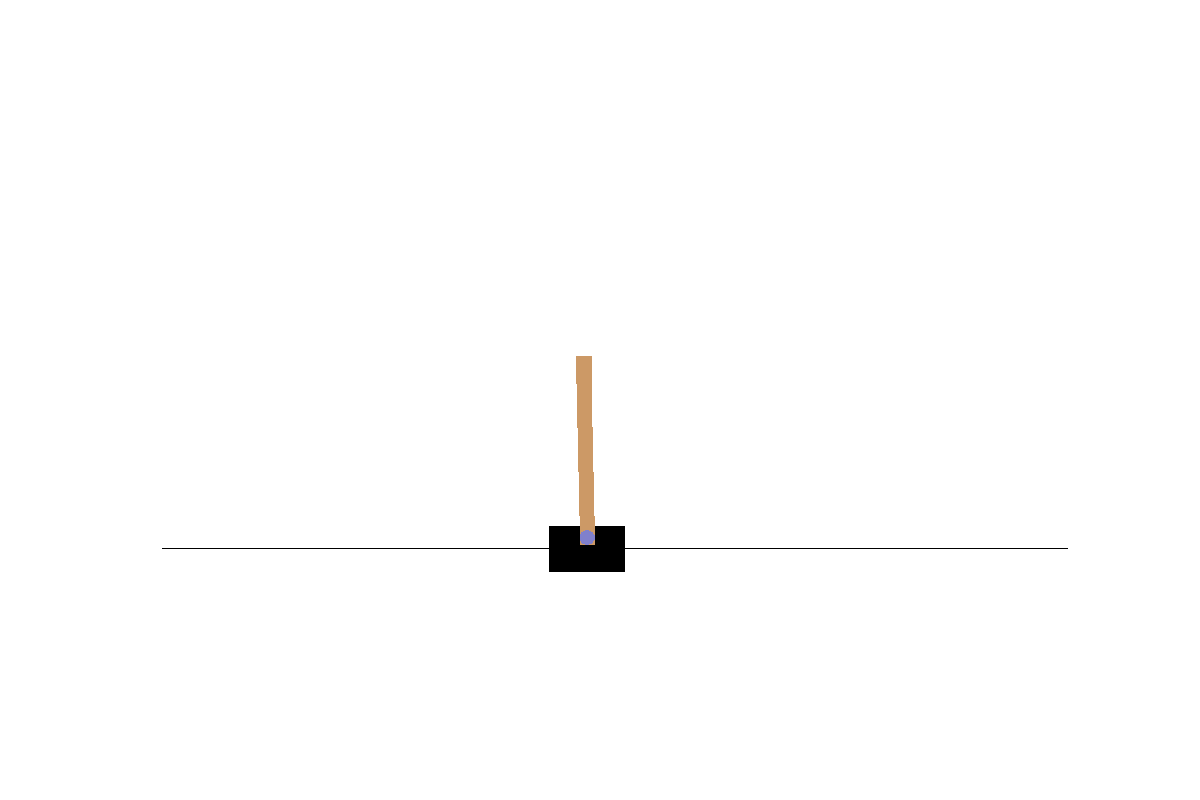
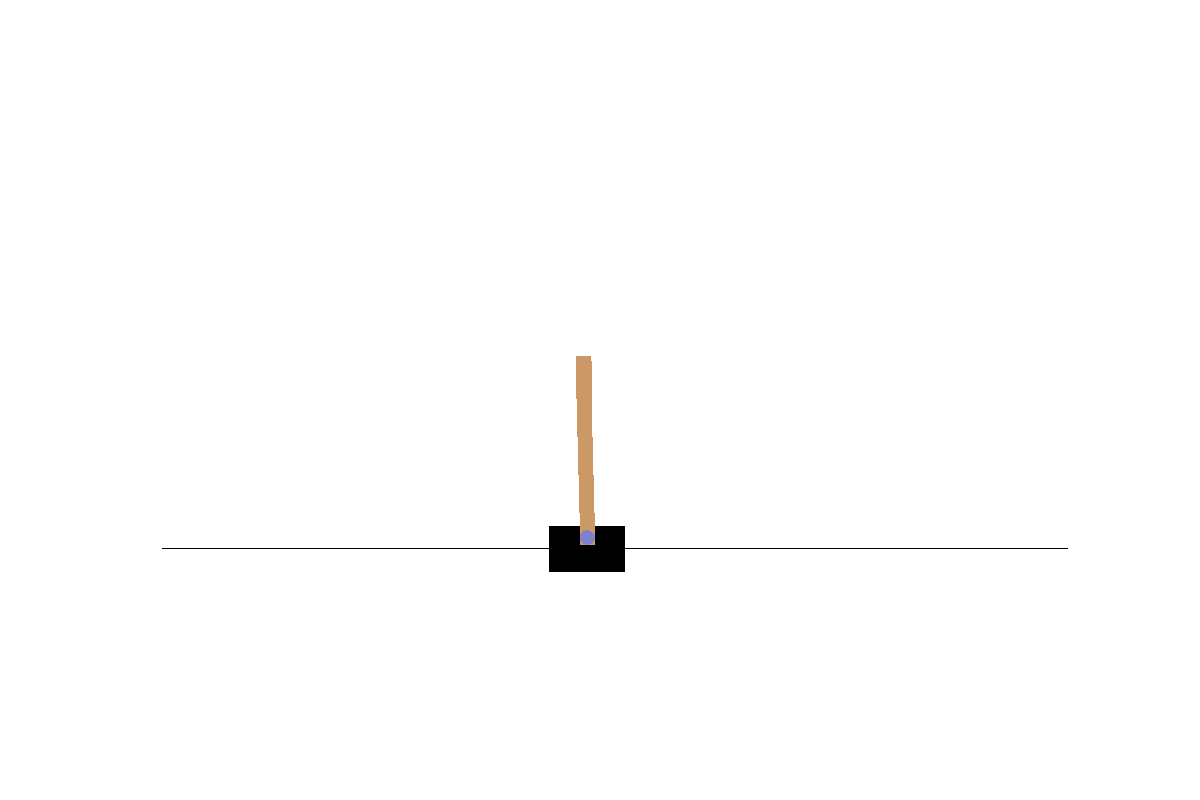
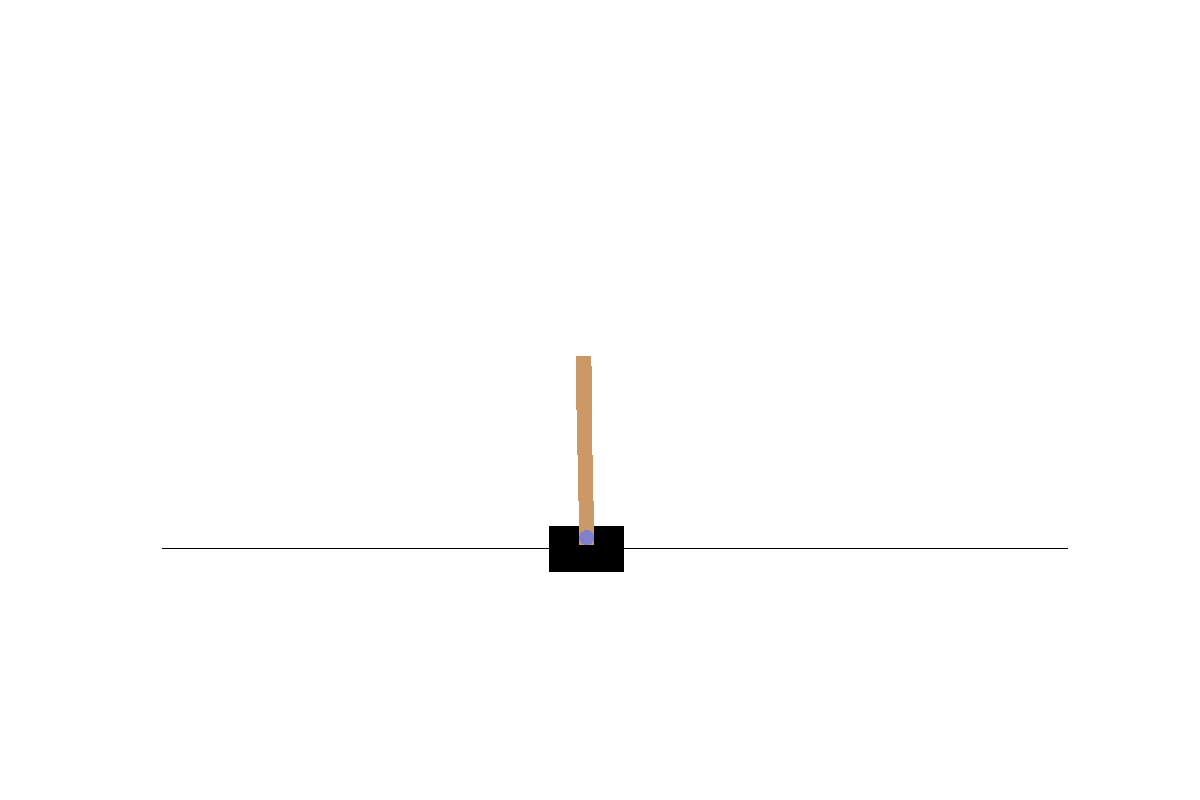
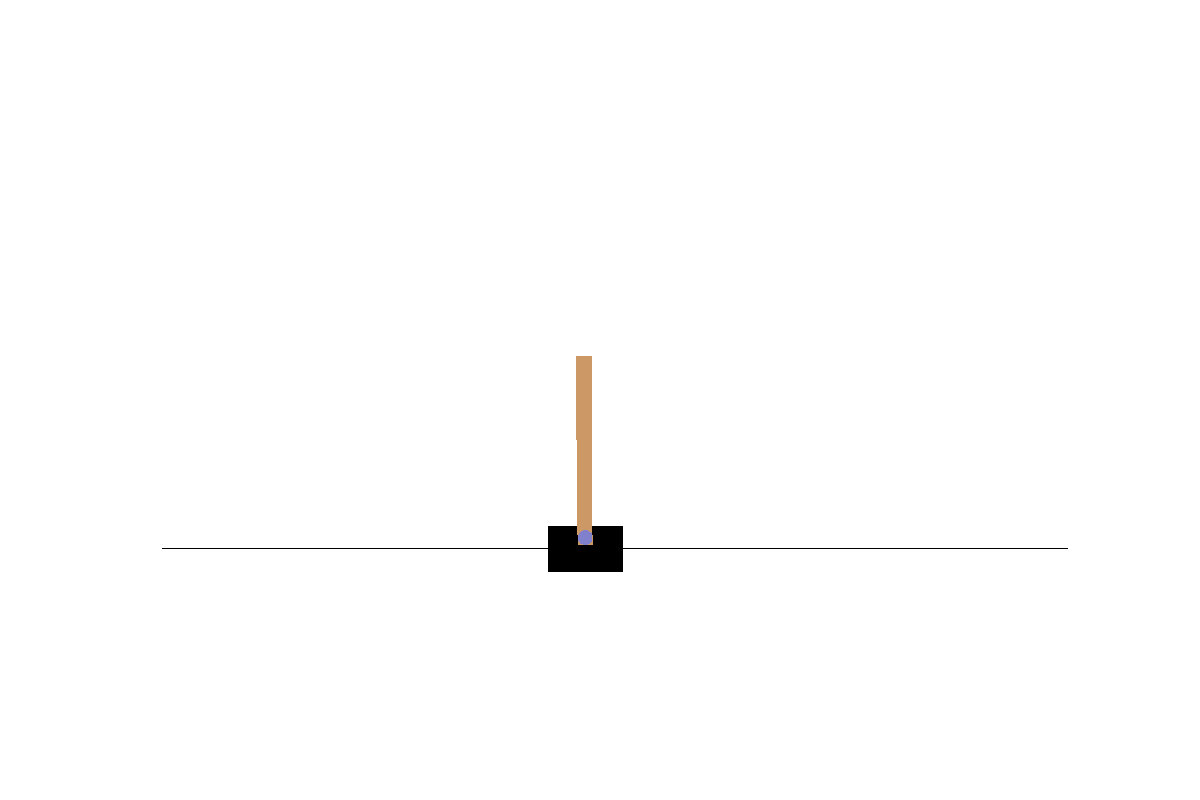
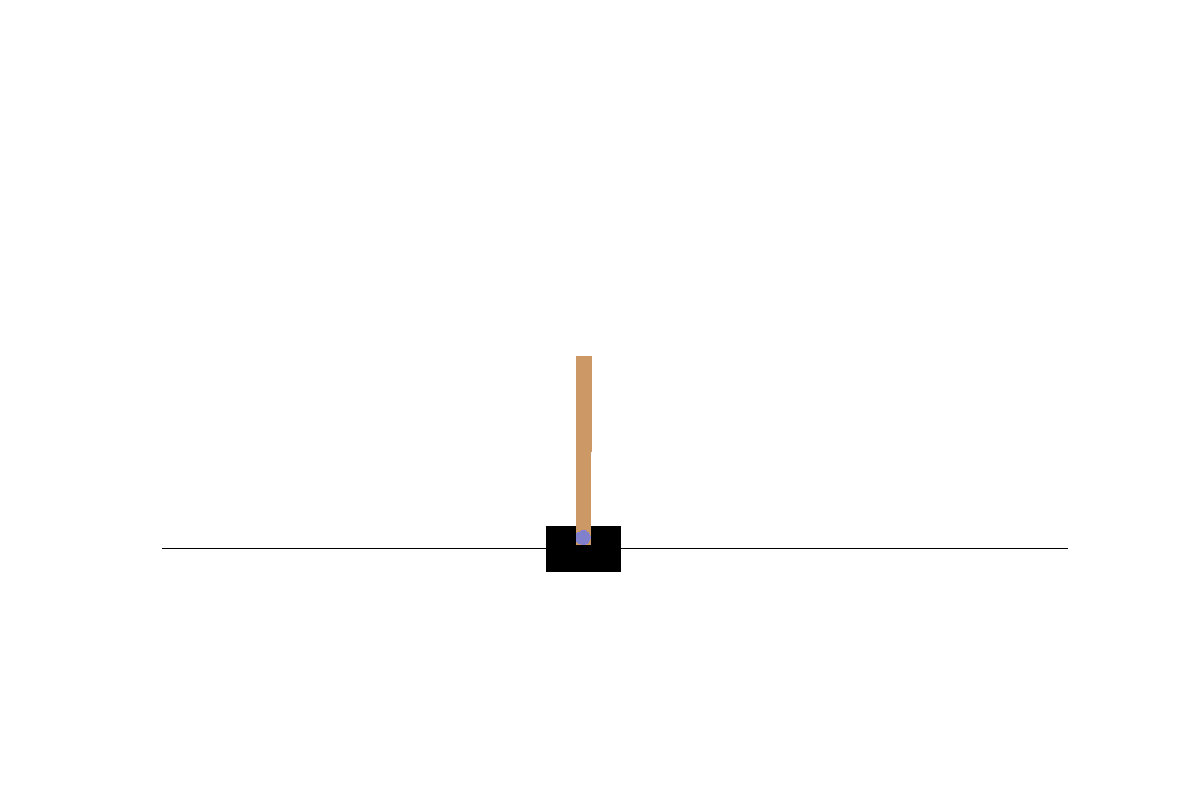
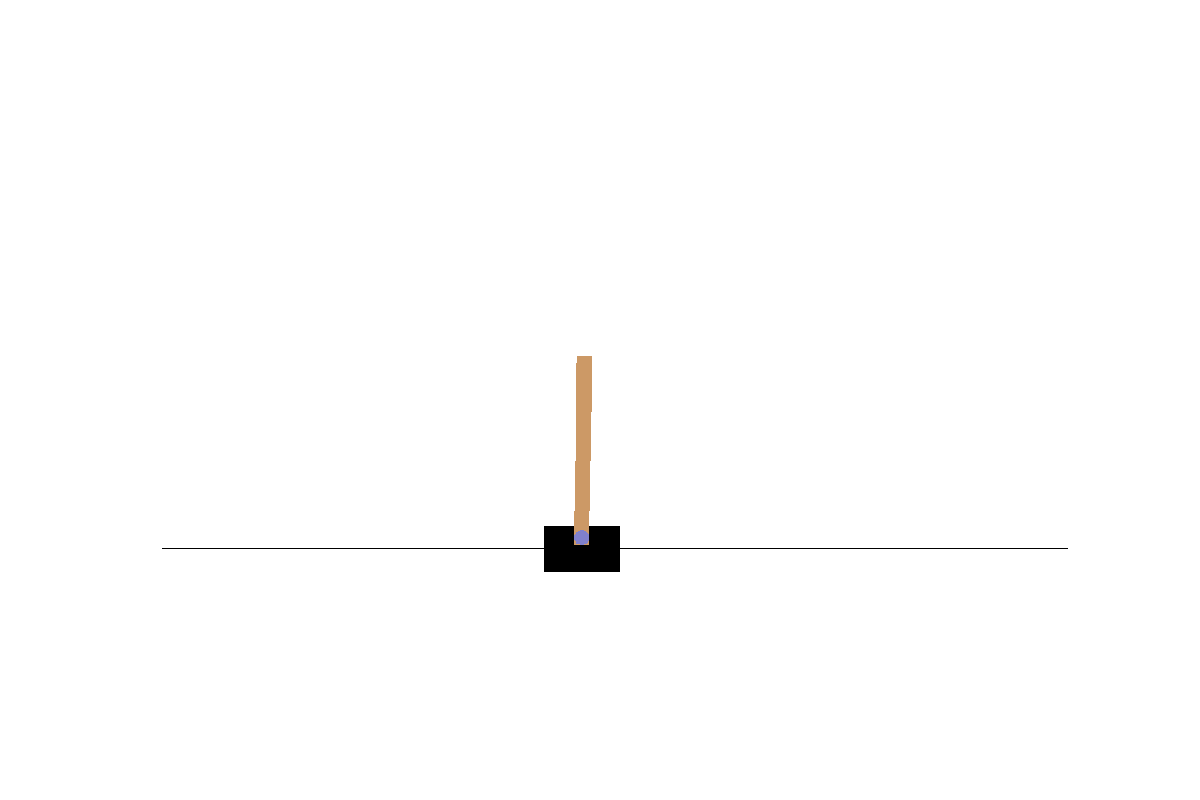
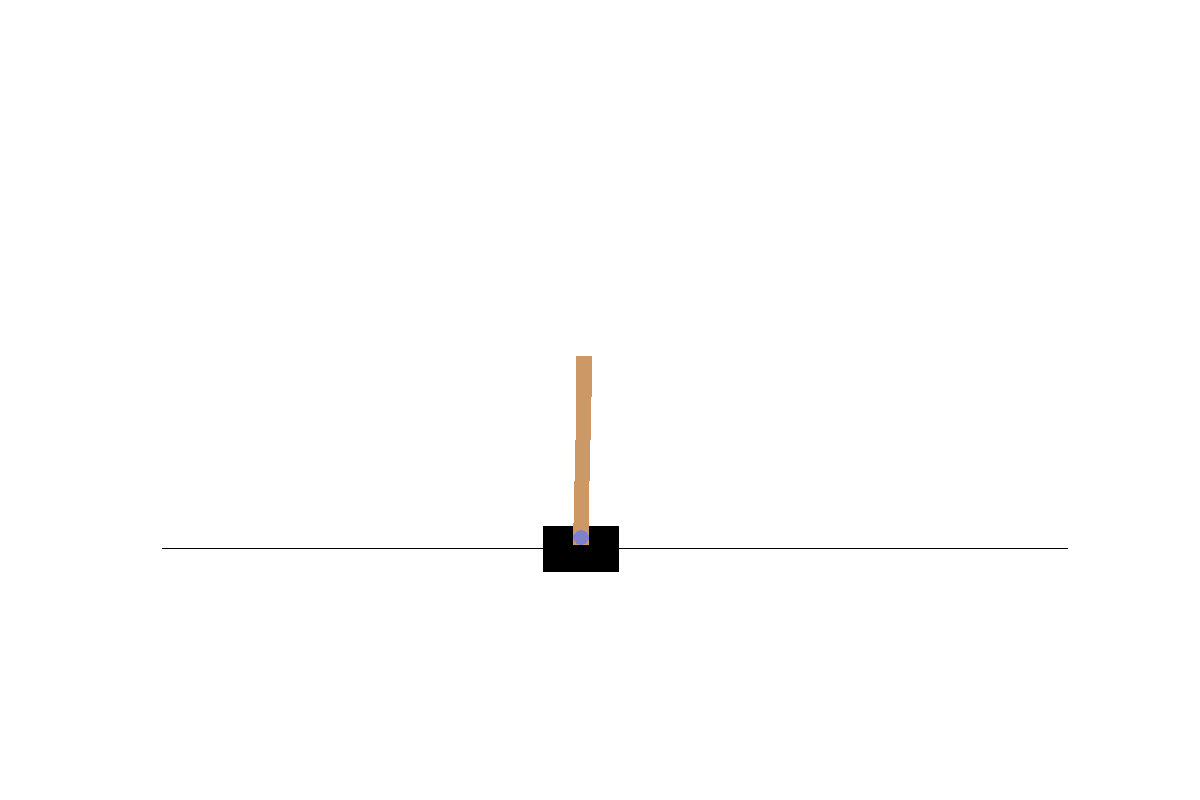
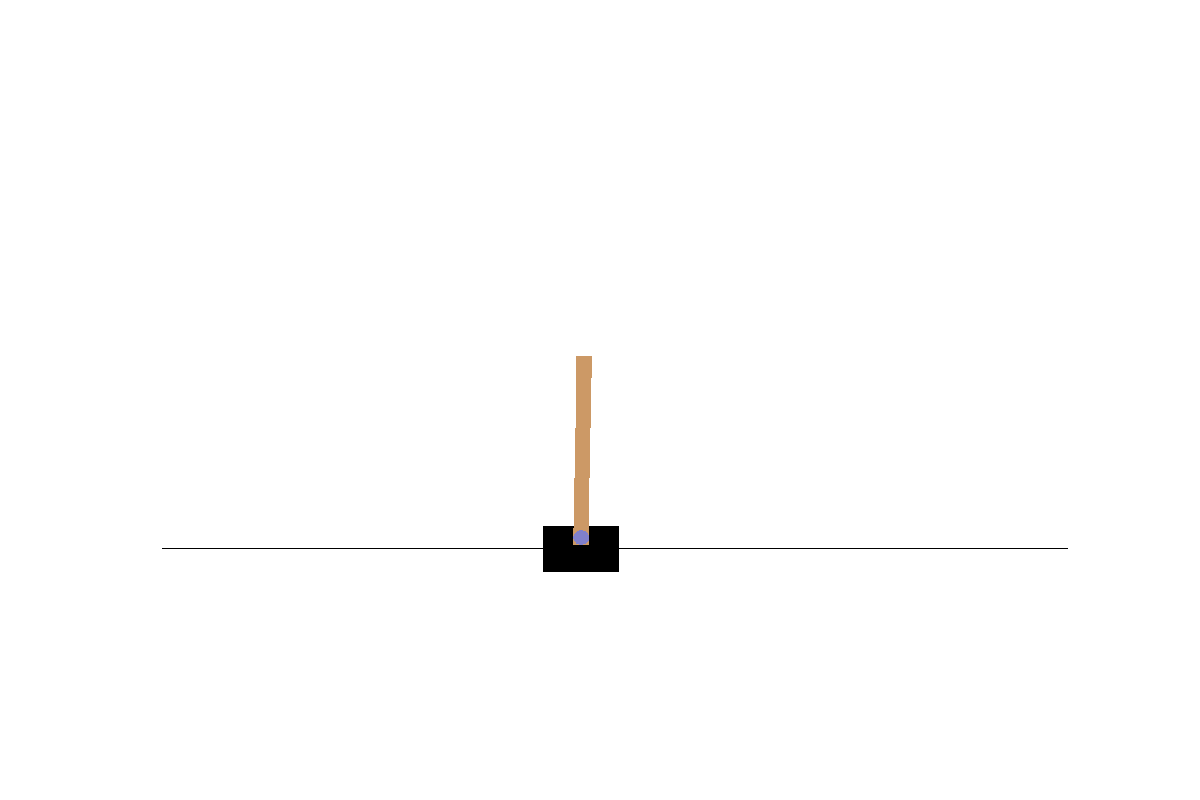
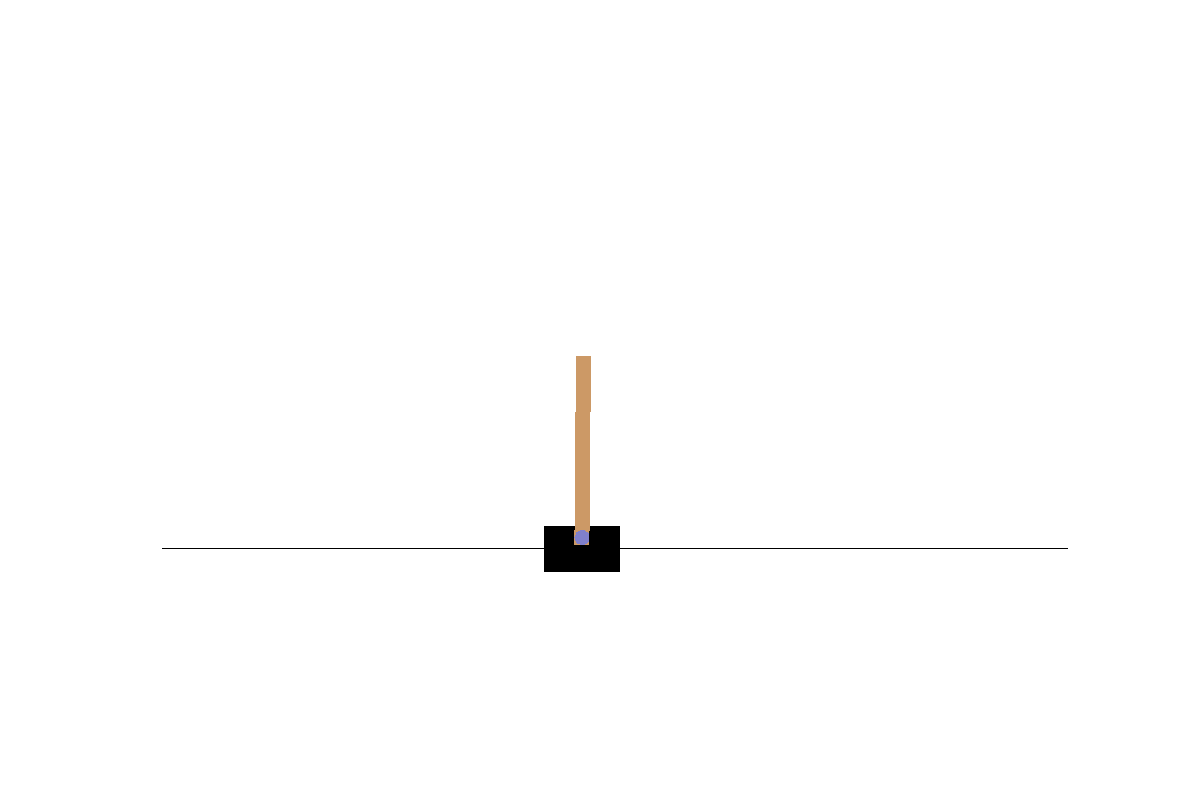
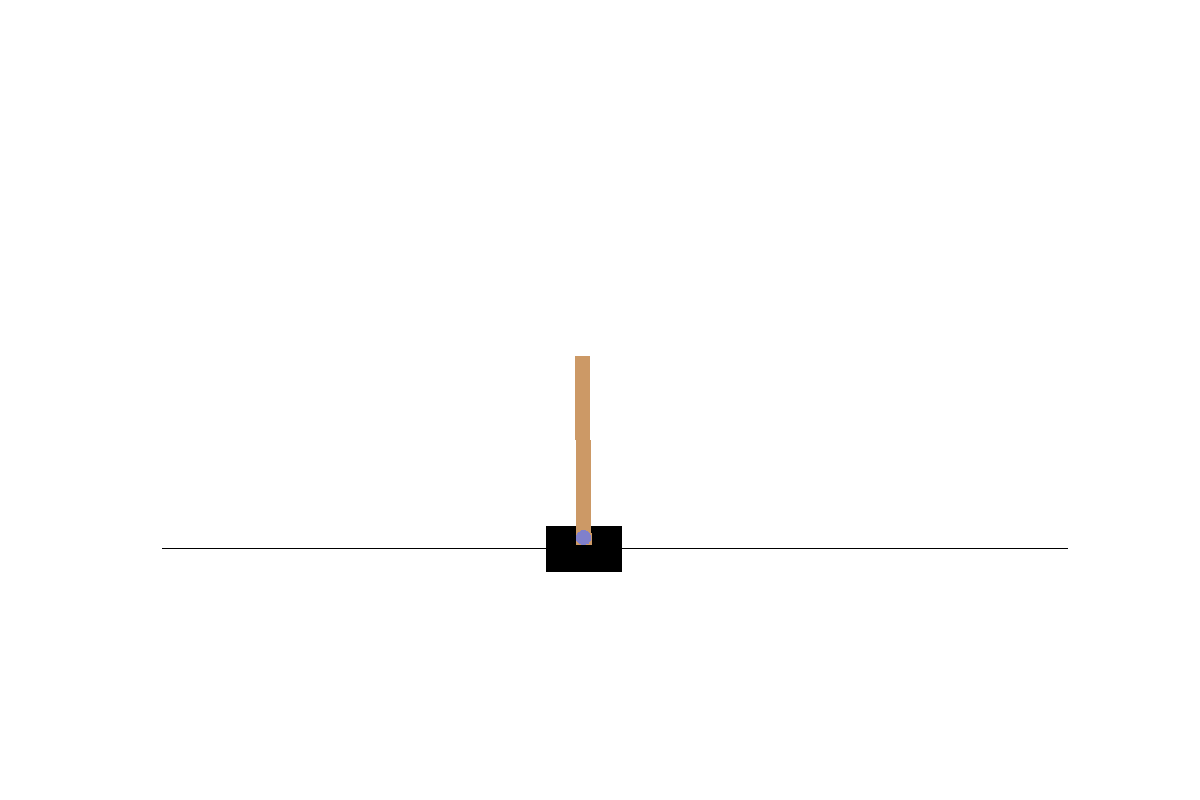
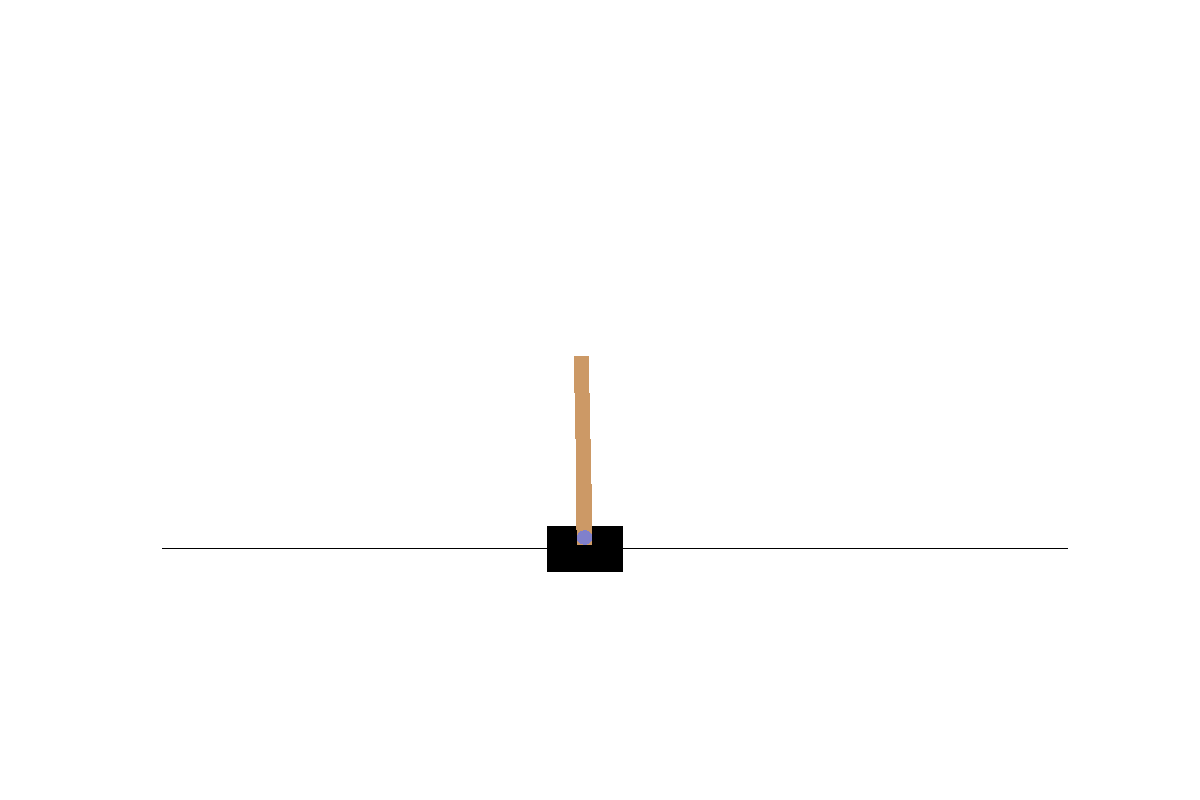
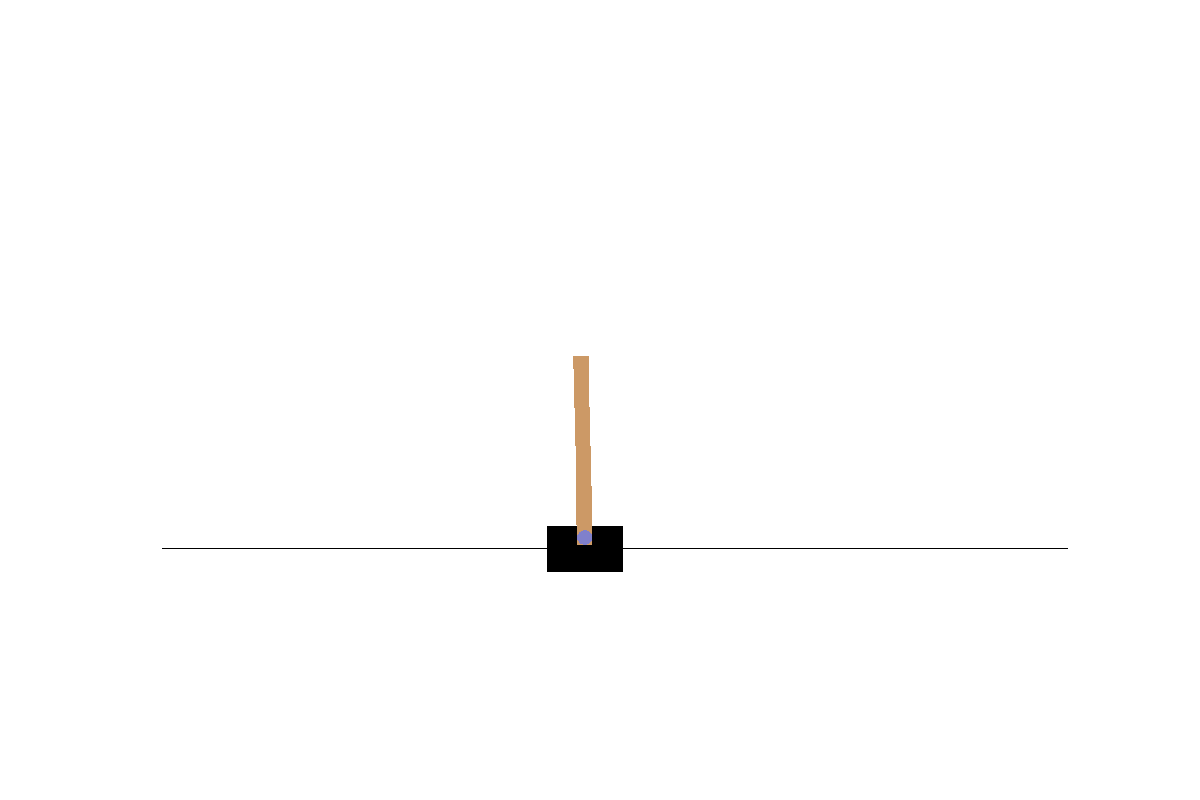
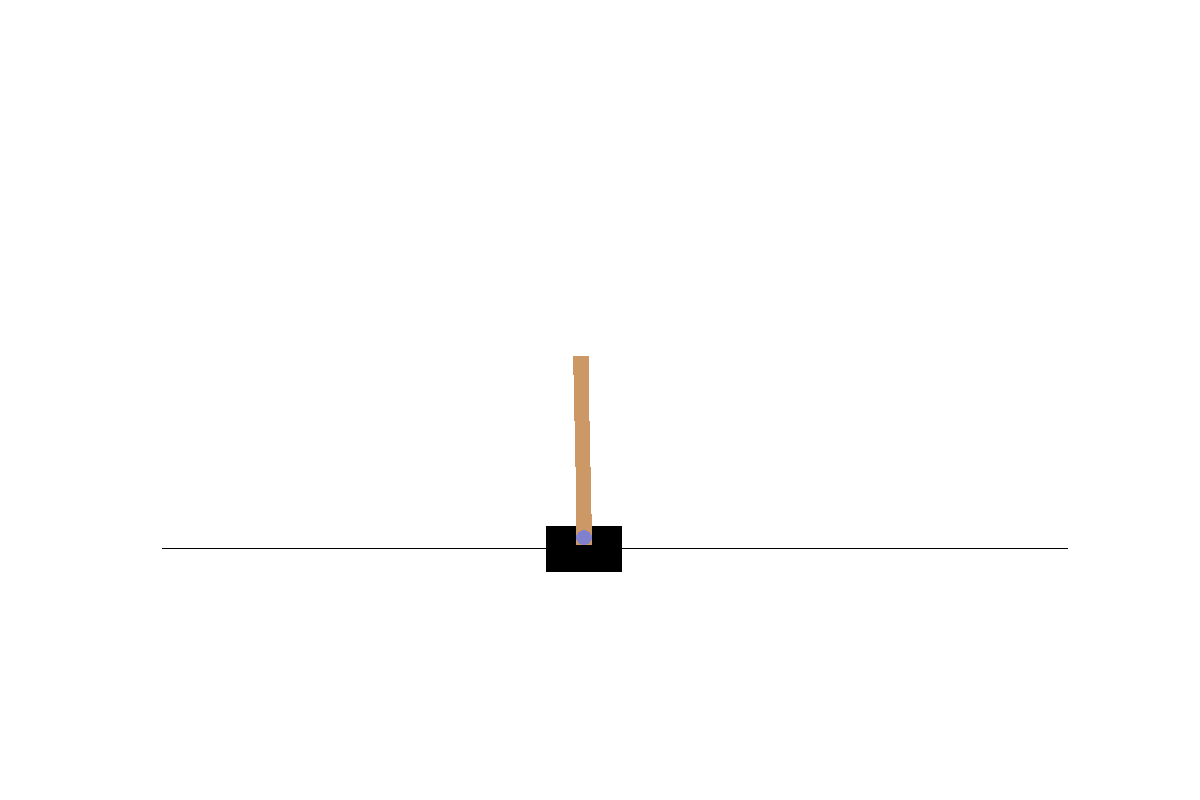
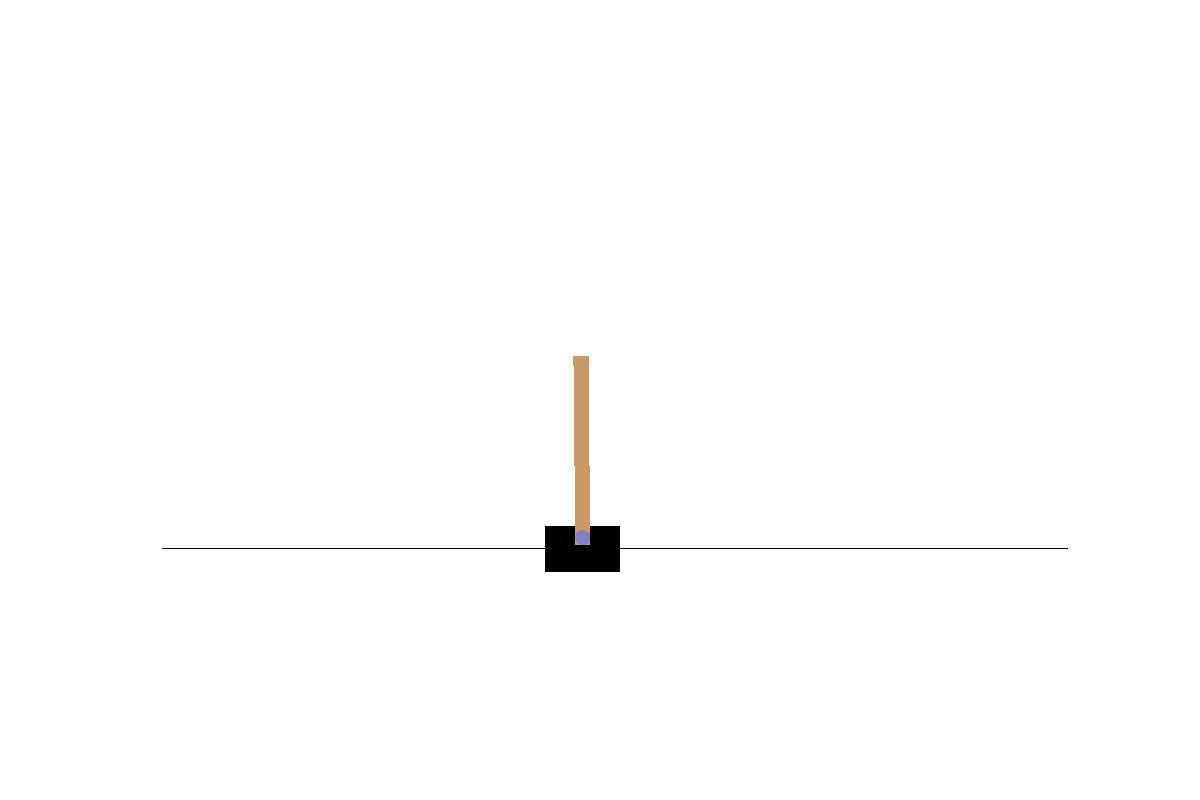
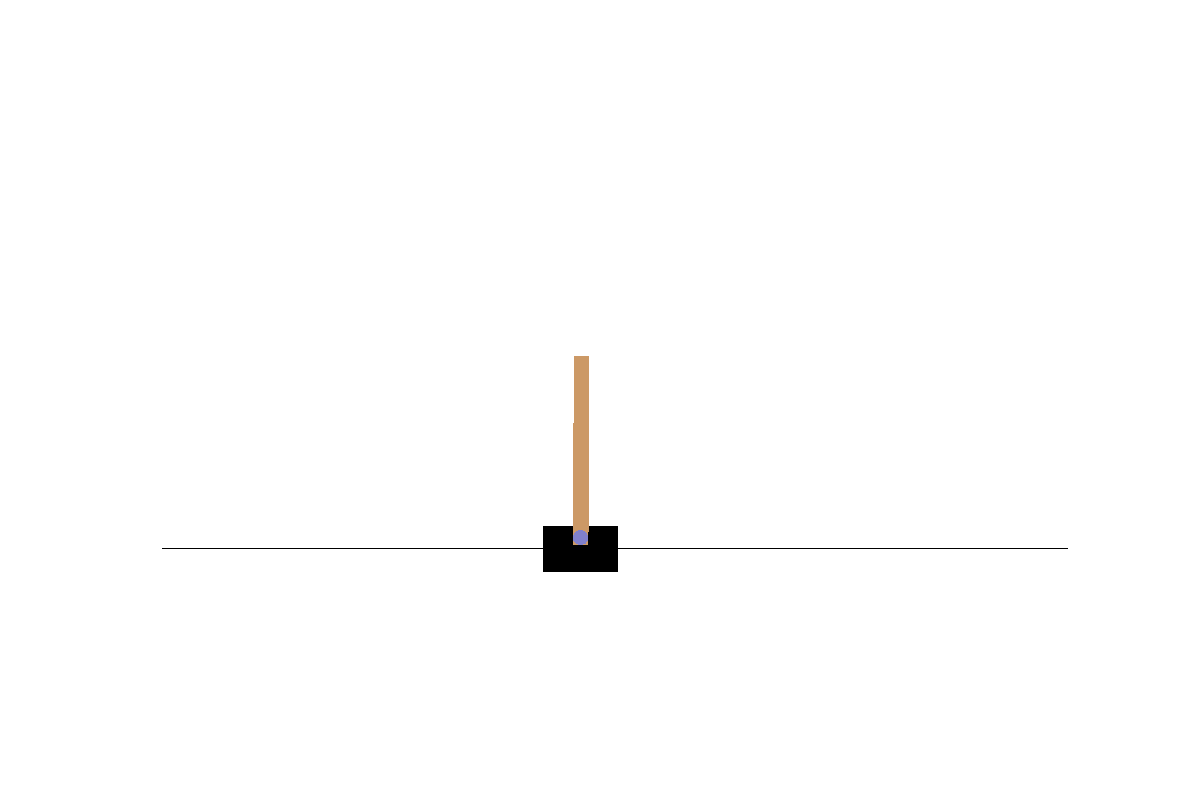
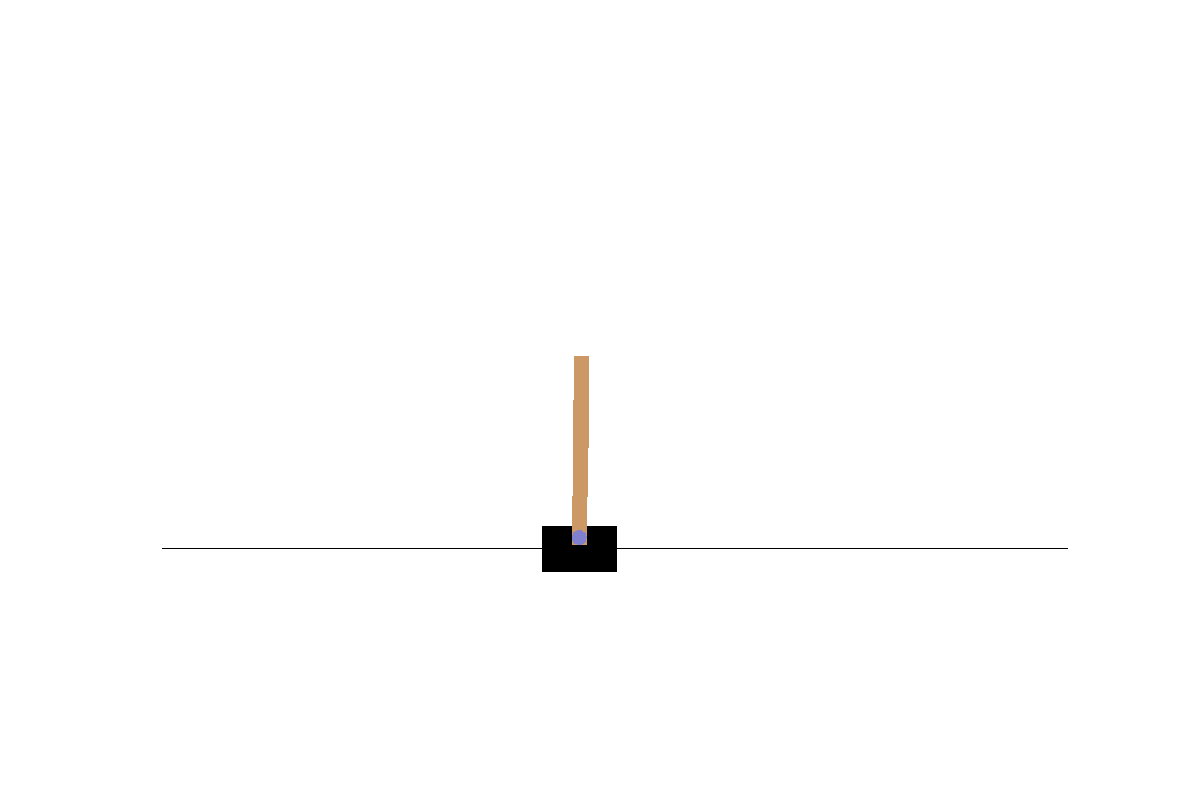
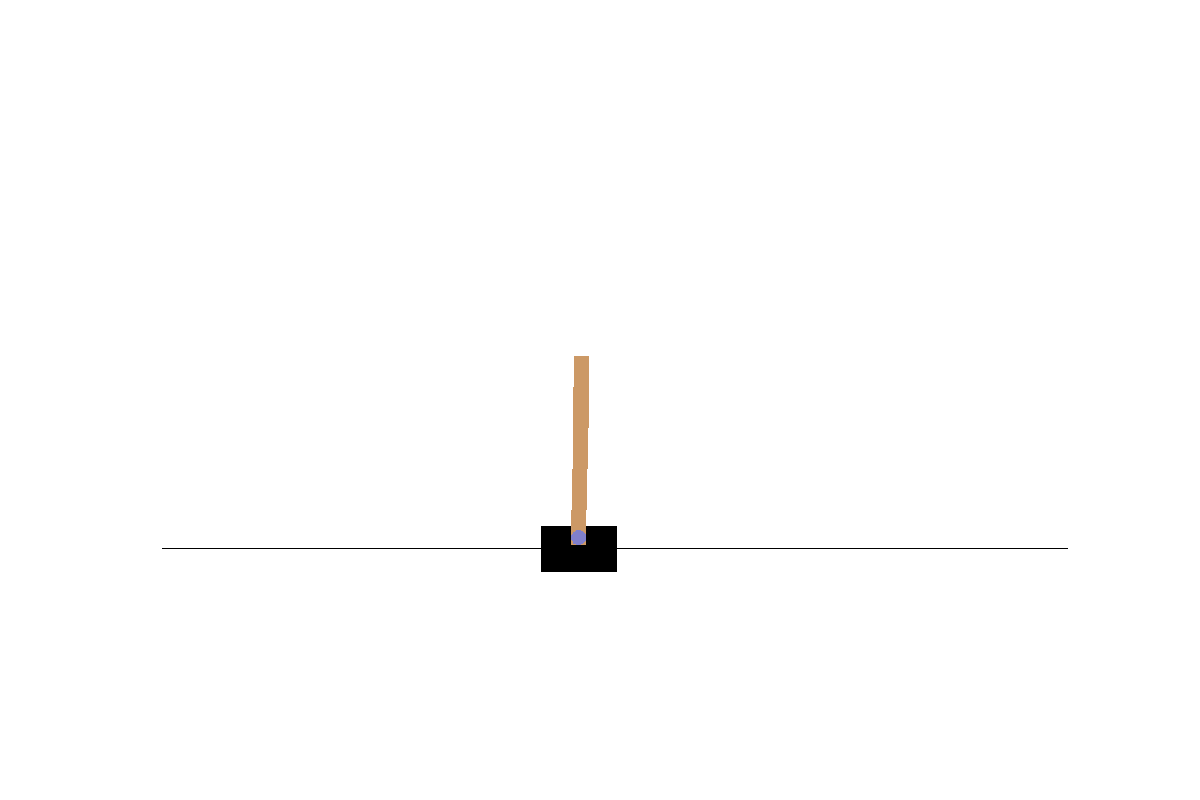
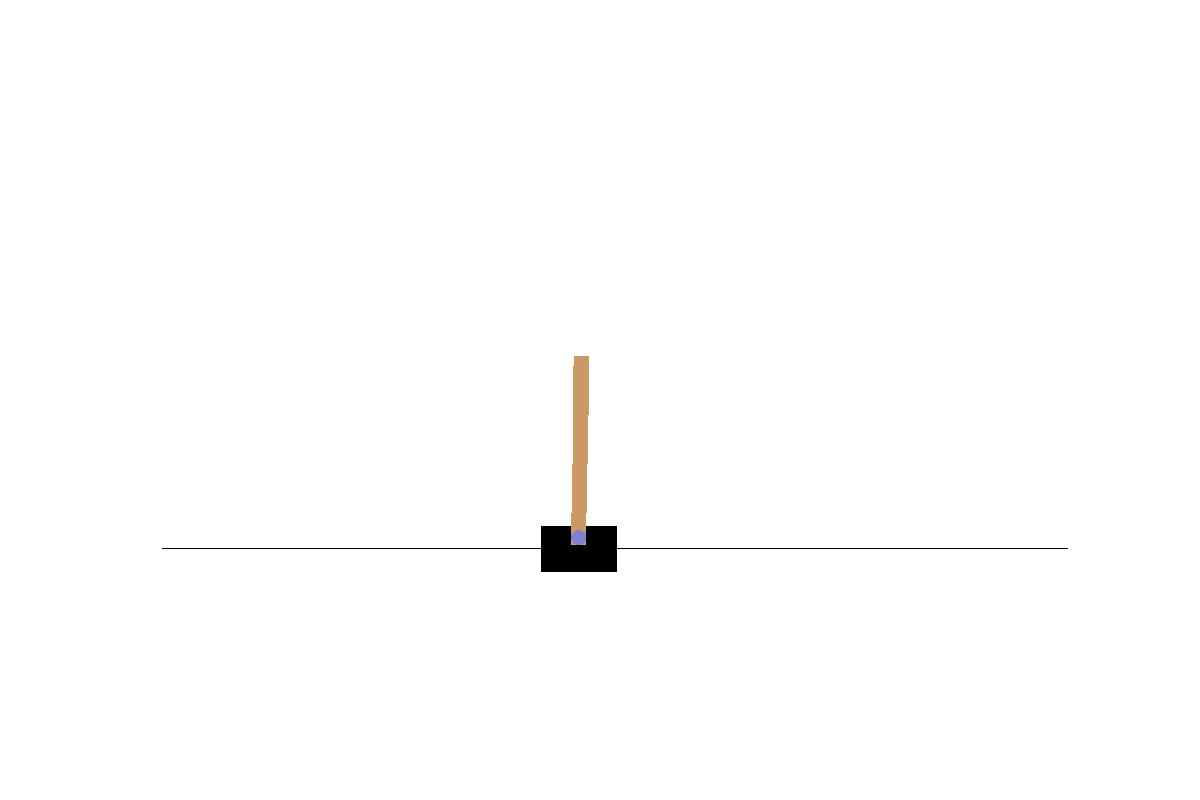

In [8]:
# main
cartpole_env = Environment()
cartpole_env.run()